# Проект: Определение стоимости автомобилей

## Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Перед нами стоит задача регрессии. Для оценки качества моделей мы будем применять метрику *RMSE*. Значение метрики должно быть меньше $2500$. По условию задачи одной из моделей должна быть *LightGBM* и как минимум одна — не бустинг.

## Описание данных

Данные находятся в файле `/datasets/autos.csv`.

**Признаки:**

- *DateCrawled* — дата скачивания анкеты из базы
- *VehicleType* — тип автомобильного кузова
- *RegistrationYear* — год регистрации автомобиля
- *Gearbox* — тип коробки передач
- *Power* — мощность (л. с.)
- *Model* — модель автомобиля
- *Kilometer* — пробег (км)
- *RegistrationMonth* — месяц регистрации автомобиля
- *FuelType* — тип топлива
- *Brand* — марка автомобиля
- *Repaired* — была машина в ремонте или нет
- *DateCreated* — дата создания анкеты
- *NumberOfPictures* — количество фотографий автомобиля
- *PostalCode* — почтовый индекс владельца анкеты (пользователя)
- *LastSeen* — дата последней активности пользователя

**Целевой признак:**

- *Price* — цена (евро)

## Этапы проекта

1. Загрузим данные и сделаем первичный обзор;
2. Изучим данные и проведём необходмую предобработку;
3. Подготовим выборки для обучения моделей;
4. Обучим разные модели и подберём для них гиперпараметры;
5. Проанализируем время обучения, время предсказани и качество моделей;
6. Опираясь на критерии заказчика, выберем лучшую модель и проверим её качество на тестовой выборке.

## Предварительные настройки

In [1]:
# импортируем необходимые библиотеки
import warnings

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
import category_encoders as ce

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
# устанавливаем необходимые настройки
pd.set_option('display.precision', 2)
pd.set_option('display.max_columns', None)

sns.set_style('whitegrid')
sns.set_palette('flare')

# настраиваем графики по умолчанию
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelpad'] = 20

rcParams['figure.figsize'] = [12, 6]
rcParams['figure.autolayout'] = True
rcParams['figure.dpi'] = 300

rcParams['font.size'] = 12
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10

# настраиваем предупреждения
warnings.filterwarnings('ignore')

In [3]:
# объявляем функцию для подсчёта процента строк после удаления
def get_sample_delta(current_data, source_data, display_mode='missed'):
    '''
    Функция считает процент строк после удаления данных.
    В зависимости от режима отображения будет выводится 
    процент удалённых или оставшихся строк текущих данных.
    
    Параметры
    ---------
    current_data : DataFrame 
        Объект датафрейма с текущими данными.
    source_data : DataFrame 
        Объект датафрейма с исходными данными.
    display_mode : 'missed' | 'saved' (по умолчанию 'missed')
        Режим отображения результата. 
        
    Возвращает
    ----------
    Функция по умолчанию возвращает исходную форму датафрейма, форму переданного датафрейма  
    и разницу строк в процентах. Если выбран режим 'saved',
    то будет возвращен процент оставшихся строк.
    '''
    
    # пробуем выполнить код
    try:
        # выводим текущую форму данных
        print('-' * 76)
        print(f'Исходная форма данных: {source_data.shape}')
        # выводим исходную форму данных
        print('-' * 76)
        print(f'Текущая форма данных: {current_data.shape}')
        print('-' * 76)
        
        # выполняем условие выбранного режима
        if display_mode == 'missed':
            # считаем процент удалённых данных
            result = 1 - current_data.shape[0] / source_data.shape[0]
            # выводим результат условия
            print(f'Было удалено {result:.1%} строк')
            print('-' * 76)
        
        # выполняем второе условие выбранного режима
        elif display_mode == 'saved':
            # считаем процент сохранённых данных
            result = current_data.shape[0] / source_data.shape[0]
            # выводим результат второго условия
            print(f'Было сохранено {result:.1%} данных')
            print('-' * 76)
        
        # выполняем условие в случае невыполнения предыдущих
        else:
            # выводим предупреждение
            print('Не удалось вычислить процент. Необходимо задать один из режимов: "missed" или "saved".')
            print('-' * 76)
            
    # в случае возникновения исключения        
    except:
        # возвращаем предупреждение
        print('Для подсчёта процента необходимо передать текущие данные и исходные данные.')
        print('-' * 76)

In [4]:
# объявляем функцию для отрисовки парного распределения
def get_distplots(data, bins=200, log_scale=False):
    '''
    Функция рисует два графика распределения:
    гистограмму и диаграмму размаха (боксплот).
    Масштаб графиков можно логарифмировать. 
    
    Параметры
    ---------
    data : Series 
        Объект серии с данными.
    bins : int (по умолчанию 200)
        Количество корзин гистограммы.
    log_scale : bool (по умолчанию False)
        Флаг для логарифмирования масштаба. Если количество
        выбросов достаточно велико, то информативность графиков
        пропадает. В таком случае лучше выбрать логарифмическое 
        масштабирование.
    
    Возвращает
    ----------
    Функция возвращает два графика друг под другом.
    '''
    # строим общую фигуру
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    fig.suptitle(f'Распределение значений {data.name.upper()}', fontsize=16)
    
    # рисуем гистограмму
    sns.histplot(data, bins=bins, ax=ax[0])
    # рисуем диаграмму размаха
    sns.boxplot(x=data, ax=ax[1])
    
    # настраиваем метки осей
    ax[0].set(xlabel='', ylabel='')
    ax[1].set(xlabel='', ylabel='')
    
    # условие для масштабирования 
    if log_scale:
        ax[0].set_xscale('log')
        ax[1].set_xscale('log')
    
    # настройка сетки графиков
    fig.tight_layout(pad=1.5)

In [5]:
# объявляем фунцкию расчёта границ полуторного IQR 
def get_outlier_bounds(data, display=False):
    '''
    Функция предназначена для расчёта границ 
    полуторного межквартильного размаха.
    При необходимости можно вывести
    информацию расчётов на экран.
    
    Параметры
    ---------
    data : Series 
        Объект серии с данными.
    display : bool (по умолчанию False)
        Флаг для вывода. Если True, то
        вся расчётная информация будет выведена на экран.
    
    Возвращает
    ----------
    Функция возвращает нижнюю и верхнюю границы
    полуторного межквартильного размаха.
    '''
    
    # получаем первый и третий квартили
    q1, q3 = np.percentile(data, [25, 75])
    # получаем межквартильный размах
    iqr = q3 - q1
    # считаем нижнуюю границу
    lower_bound = q1 - (1.5 * iqr) 
    # считаем верхнюю границу
    upper_bound = q3 + (1.5 * iqr)
    
    # выполняем условие отображения
    if display:
        # выводим информацию
        print('-' * 42)
        print('Первый квартиль:', q1)
        print('-' * 42)
        print('Третий квартиль:', q3)
        print('-' * 42)
        print('Межквартильный размах:', iqr)
        print('-' * 42)
        print('Нижняя граница 1.5(IQR):', lower_bound)
        print('-' * 42)
        print('Верхняя граница 1.5(IQR):', upper_bound)
        print('-' * 42)
    
    # возвращаем результат
    return lower_bound, upper_bound

In [6]:
# объявляем функцию заполнения пропусков по группе
def groupby_fillna(data, groupby_columns, target_column):
    '''
    Функция заполняет пропуски в целевом столбце
    по заданной группе признаков одним из характерных значений:
    медианой или модой.
    
    Параметры
    ---------
    data : DataFrame 
        Объект датафрейма, с которым необходимо работать.
    groupby_columns : list или str
        Список столбцов или имя столбца,
        по которым будет происходить группировка.
    target_column : str
        Строковое значение столбца, 
        в котором необходимо заполнить пропуски.
    
    Возвращает
    ----------
    Функция возвращает объект Series 
    с заполенными пропусками
    '''
    # определяем заполнитель, в зависимости от типа данных target_column     
    filler = lambda x: x.median() if np.issubdtype(x.dtype, np.number) else x.mode(dropna=False)[0]
    # находим характерные значения для target_column по группировке признаков       
    values = data.groupby(groupby_columns)[target_column].transform(filler)
    # заполняем пропуски в target_column найденными значениями     
    filled_series = data[target_column].fillna(values)
    # возвращаем результат     
    return filled_series

# Обзор данных

* Загрузим файл с данными;
* Проведём первичный осмотр; 
* Изучим структуру данных;
* Определим явные ошибки, присутствующие в данных.

In [7]:
# загружаем данные
data = pd.read_csv('autos.csv')

In [8]:
# выводим первые строки таблицы
data.head(10)

DateCrawled  Price  VehicleType  RegistrationYear Gearbox  Power  \
0  2016-03-24 11:52:17    480          NaN              1993  manual      0   
1  2016-03-24 10:58:45  18300        coupe              2011  manual    190   
2  2016-03-14 12:52:21   9800          suv              2004    auto    163   
3  2016-03-17 16:54:04   1500        small              2001  manual     75   
4  2016-03-31 17:25:20   3600        small              2008  manual     69   
5  2016-04-04 17:36:23    650        sedan              1995  manual    102   
6  2016-04-01 20:48:51   2200  convertible              2004  manual    109   
7  2016-03-21 18:54:38      0        sedan              1980  manual     50   
8  2016-04-04 23:42:13  14500          bus              2014  manual    125   
9  2016-03-17 10:53:50    999        small              1998  manual    101   

     Model  Kilometer  RegistrationMonth  FuelType       Brand Repaired  \
0     golf     150000                  0    petrol  volkswagen      NaN   
1      NaN     125000                  5  gasoline        audi      yes   
2    grand     125000                  8  gasoline        jeep      NaN   
3     golf     150000                  6    petrol  volkswagen       no   
4    fabia      90000                  7  gasoline       skoda       no   
5      3er     150000                 10    petrol         bmw      yes   
6  2_reihe     150000                  8    petrol     peugeot       no   
7    other      40000                  7    petrol  volkswagen       no   
8    c_max      30000                  8    petrol        ford      NaN   
9     golf     150000                  0       NaN  volkswagen      NaN   

           DateCreated  NumberOfPictures  PostalCode             LastSeen  
0  2016-03-24 00:00:00                 0       70435  2016-04-07 03:16:57  
1  2016-03-24 00:00:00                 0       66954  2016-04-07 01:46:50  
2  2016-03-14 00:00:00                 0       90480  2016-04-05 12:47:46  
3  2016-03-17 00:00:00                 0       91074  2016-03-17 17:40:17  
4  2016-03-31 00:00:00                 0       60437  2016-04-06 10:17:21  
5  2016-04-04 00:00:00                 0       33775  2016-04-06 19:17:07  
6  2016-04-01 00:00:00                 0       67112  2016-04-05 18:18:39  
7  2016-03-21 00:00:00                 0       19348  2016-03-25 16:47:58  
8  2016-04-04 00:00:00                 0       94505  2016-04-04 23:42:13  
9  2016-03-17 00:00:00                 0       27472  2016-03-31 17:17:06

Данные загрузились без ошибок и имеют следующую структуру: строки представляют собой анкеты о продаже автомобиля;
столбцы — признаки, в основном описывающие характеристики автомобиля. Есть признаки, которые не относятся к самому автомобилю. Например, *дата создания анкеты*, *дата скачивания анкеты*, *почтовый индекс владельца* и *дата последней активности пользователя*. 

Нашей задачей является предсказание рыночной стоимости автомобиля, и здравый смысл подсказывает, что она скорее всего зависит от характеристик самого автомобиля. Это значит, что иные признаки нам не понадобятся на этапе обучения моделей, но пригодятся при разведывательном анализе. Целевым признаком является *цена*. Её мы и должны предсказывать.

In [9]:
# получаем общую информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Данные содержат $354369$ наблюдений и $16$ описывающих признаков. Необходимо будет выяснить, все ли наблюдения нам нужны. Названия столбцов не соответствуют хорошему стилю написания. Наш стиль — *snake_case*.

В некоторых признаках неверно определён тип данных: дата и время определены как `object`, также как и булево значение *была ли машина в ремонте или нет*. Некоторые категориальные признаки, например *тип кузова* и *модель автомобиля*, можно перевести в тип данных `category`. Это является хорошей практикой — зачастую такое преобразование ускоряет работу с категориями и уменьшает использование памяти. За исключением, если категорий будет слишком много. 

В первых строках таблицы присутствуют пропущенные значения. Согласно общей информации масштаб пропусков представляется незначительным. Проверим наше ощущение — посчитаем количество пропусков и их процентное соотношение.

In [10]:
# соединяем две серии
pd.concat(
    [
        # считаем количество пропусков
        data.isna().sum().rename('na_value'), 
        # считаем процент пропусков
        data.isna().mean().rename('na_percent') * 100
    ], axis=1
).style.background_gradient('coolwarm')

Не все алгоритмы машинного обучения умеют работать с данными, в которых есть пропуски. Поэтому одной из наших задач является их заполнение или удаление наблюдений с пропущенными значениями. Во втором случае допустимым значением считается удаление не больее $10\%$ данных. У нас же есть признаки, удаление пропусков в которых превышает эту норму. 

С другой стороны нам предоставили достаточное количество наблюдений. И если удалить те наблюдения, в которых есть пропуски, то оставшегося количества должно хватить для обучения моделей. В любом случае, мы сначала попытаемся найти оптимальную стратегию заполнения, а удалить пропуски мы сможем всегда.      

Напоследок проверим наличие явных дубликатов в наблюдениях.

In [11]:
# считаем количество дубликатов
print('Дубликатов найдено:', data.duplicated().sum())

Дубликатов найдено: 4


Не обошлось без дубликатов. Полностью совпадающих наблюдений оказалось совсем мало. Но не стоит забывать про неявные дубликаты. Ведь какая-то часть анкеты заполнялась владельцем вручную, а это значит, что есть вероятность возникновения такой ошибки. Проверим это при анализе данных, на следующем этапе.

## Вывод

Для решения поставленной задачи нам предоставили файл. Первым делом мы его загрузили и изучили. Нам удалось выяснить следующее:

* при загрузке данных не возникло ошибок или каких-либо проблем;
* данные имеют структуру широкой таблицы, где строки это наблюдаемые анкеты о продаже автомобиля, а столбцы — признаки, которые описывают технические характеристики автомобиля, цену, регистрационные данные анкеты и локацию владельца;
* всего в данных содержится $354369$ наблюдений и $16$ описывающих признаков.
* в данных имеются некоторые проблемы:
    
    * имена столбцов не соответствуют хорошему стилю написания, *snake_case*;
    * тип данных некоторых признаков определён неверно (например, дата и время, булев признак `Repaired`);
    * имеются пропущенные значения;
    * обнаружены явные дубликаты;

* категориальные признаки стоит преобразовать в тип данных `category`;
* данные стоит проверить на неявные дубликаты.

# Предобработка и анализ данных

На этом этапе проекта мы изучим признаки более детально, по возможности исправим найденные проблемы, и сформулируем дальнейшую стратегию подготовки данных для моделирования. Но сперва мы должны сделать несколько вещей:

* Первым делом зафиксируем иходные данные. Это необходимо, чтобы мы могли сверяться с формой данных, когда будем что-либо менять, удалять. Ну, и так спокойней, когда знаешь, что есть копия неизменённых данных;
* Создадим пустой список для столбцов. Не все признаки будут необходимы для моделирования. Те, что никак не связаны с целевым признаком мы добавим в этот список. После анализа данных мы легко сможем удалить ненужное;  
* Создадим пустой список для категориальных признаков. Модели не умеют напрямую работать с категориями, поэтому всегда требуется преобразование таких признаков в числа. Мы будем наполнять этот список категориальными признаками, чтобы облегчить себе работу в дальнейшем; 
* Изменим имена столбцов и избавимся от явных дубликатов.

In [12]:
# фиксируем форму исходных данных
SOURCE_DATA = data.copy(deep=True)
# создаём список столбцов на удаление
features_for_delete = []
# создаём список категориальных признаков
cat_features = []

In [13]:
# заменяем имена столбцов на новые
data.columns = (
    data.columns
    .str.replace(r"([A-Z])", r" \1", regex=True)
    .str.lower().str.replace(' ', '_').str[1:]
)
# проверяем результат
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [14]:
# удаляем явные дубликаты
data.drop_duplicates(inplace=True)
# проверяем результат
print('Дубликатов найдено:', data.duplicated().sum())

Дубликатов найдено: 0


Подготовку выполнили, можно перейти к анализу признаков. Из выявленных пробем у нас ещё остались пропуски, некорректные типы данных и возможные неявные дубликаты. Также не забудем и про выбросы с аномальными значениями признаков.

## Дата создания, скачивания и последнего визита

Начнём с дат. Признаки фиксируют *дату создания* и *дату скачивания* анкеты владельца авто, а также его *последнюю активность*. 

* Исправим тип данных на `datetime`
* Посмотрим на временной период наблюдений.

In [15]:
# делаем преобразования с помощью цикла 
for col in ['date_crawled', 'date_created', 'last_seen']:
    # назначаем текущему признаку правильный
    data[col] = pd.to_datetime(data[col])
    # получаем даты без времени
    date = data[col].dt.date
    print('-' * 42)
    # выводим имя признака
    print('Признак:', col)
    # выводим самую раннюю отсечку по времени
    print('Первая отсечка:', date.min())
    # выводим самую позднюю отсечку по времени
    print('Последняя отсечка:', date.max())
    # выводим уникальные значения
    print('Уникальных значений:', date.nunique())
print('-' * 42)    

------------------------------------------
Признак: date_crawled
Первая отсечка: 2016-03-05
Последняя отсечка: 2016-04-07
Уникальных значений: 34
------------------------------------------
Признак: date_created
Первая отсечка: 2014-03-10
Последняя отсечка: 2016-04-07
Уникальных значений: 109
------------------------------------------
Признак: last_seen
Первая отсечка: 2016-03-05
Последняя отсечка: 2016-04-07
Уникальных значений: 34
------------------------------------------


Период наблюдаемых анкет — $2$ года. Первая анкета в выборке была создана в $2014$ году, последняя — в $2016$. Примечательно, что за это время наблюдается $109$ уникальных дат создания. Можно предположить, что компания пользуется большой популярностью, если учитывать среднее количество объявлений в день.

Анкеты скачивались из базы за последние $34$ дня до момента последней временной отсечки. Последняя активность владельца совпадает по временным отсечкам скачивания, и также наблюдалась за последние $34$ дня. То есть за последний месяц все $350$ тысяч владельцев анкет заходили в сервис компании «Не бит, не крашен».

Такая дикая популярность может говорить либо об успешности компании, либо о возможной ошибке в процессе фиксации временных отсечек. Утверждать природу возникновения данного явления мы не можем с полной уверенностью, тут необходимо получить дополнительную информацию от самого разработчика.

Как бы там ни было, перед нами стоит задача моделирования предсказаний стоимости авто, и временные отсечки могут влиять на результат только в единственном случае — если в данных наблюдается какая-либо периодичность, например сезон продаж. Взглянем на распределение созданных анкет за весь период и за последний год.

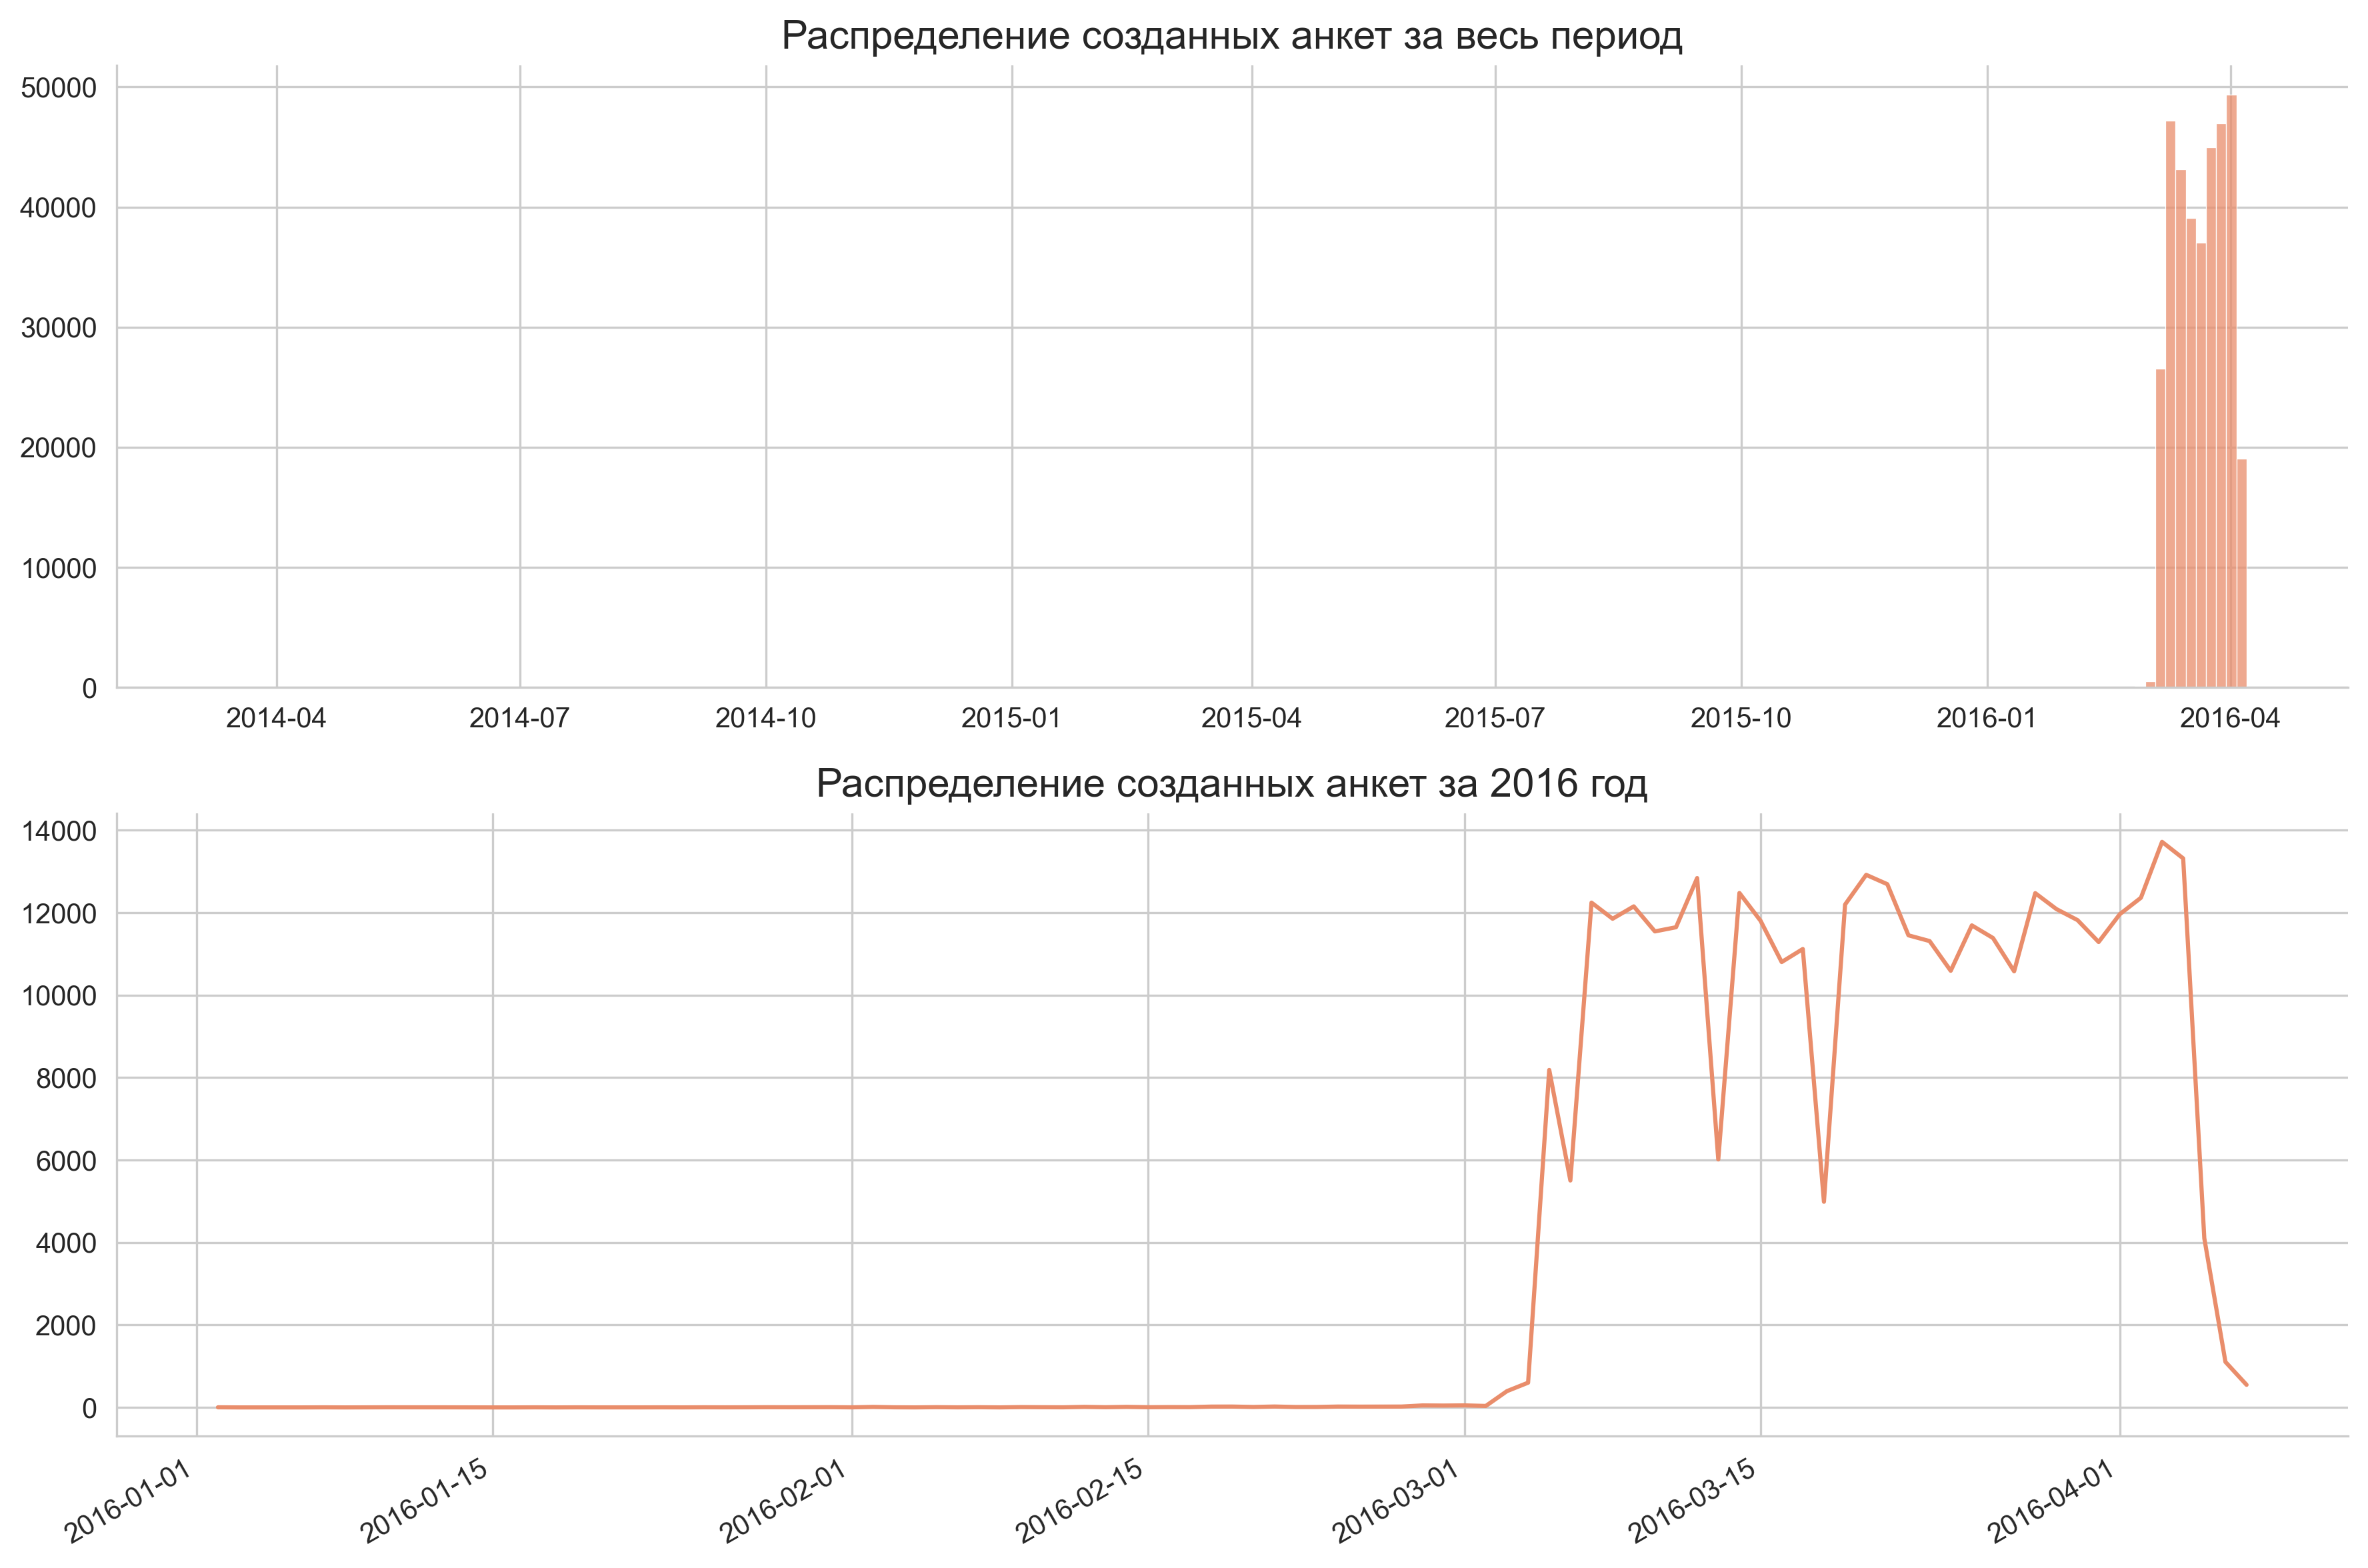

In [16]:
# создаём общую фигуру
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
# создаём гистограмму распределения анкет за весь период
sns.histplot(x=data['date_created'], bins=200, ax=ax[0])
ax[0].set(title='Распределение созданных анкет за весь период', xlabel='', ylabel='')
# создаём график создания анкет за 2016 год
data.loc[data['date_created'].dt.year > 2015, 'date_created'].value_counts().plot(ax=ax[1])
ax[1].set(title='Распределение созданных анкет за 2016 год', xlabel='', ylabel='');

Оказывается, всё наше многообразие данных помещается в наблюдаемый период `last_seen` и `date_crawled` — $34$ дня, с марта по апрель $2016$ года. Либо компания пересмотрела свою маркетинговую стратегию и это оказалось самым лучшим их решением, либо это всё те же огрехи сбора данных.

С такими данными сложно предположить о сезонной активности, цикличной активности в течение месяца тоже не обнаружено. Поэтому мы можем со спокойной душой удалить признаки `date_crawled`, `date_created` и `last_seen`, они не имеют какого-либо очевидного влияния на таргет, а значит, будут лишними при моделировании. Важно отметить, что мы увидели актуальный период активности — с марта по апрель $2016$ года. Эта информация в дальнейшем нам пригодится.

* Запишем актуальный год в константу;
* Добавим в список на удаление рассматриваемые признаки.

In [17]:
# фиксируем актуальный год
LAST_ACTUAL_YEAR = 2016
# создаём список признаков, которые необходимо будет удалить
features_for_delete.extend(['date_crawled', 'date_created', 'last_seen'])

## Почтовый индекс пользователя

Почтовый индекс пользователя это по сути его географическая метка в данных. Различные страны имеют свой уровень жизни, развитые города могут влиять на экономическую составляющую каждого его жителя. Больше возможностей заработать, лучше покупательская способность. Владельцы могут чаще менять авто, например раз в два года. Значит, на вторичном рынке будет спрос и предложение. Благополучные район, состоятельные обетатели. Связь неочевидная и её стоит проверить.

Задача определения локации по индексу представляется достаточно сложной, потому что вероятность дублирования индекса высока. Лучшим геолокационным идентификатором являются координаты, широта и долгота. Но у нас нет таких данных по пользователям. Остается работать с почтовым индексом.

* Посчитаем сколько у нас уникальных локаций;
* Проверим их взаимосвязь с ценой продажи авто. Для этого вычислим среднюю цену по индексам и построим диаграмму рассеяния.    

In [18]:
# вычисляем количество уникальынх значений
data['postal_code'].nunique()

8143

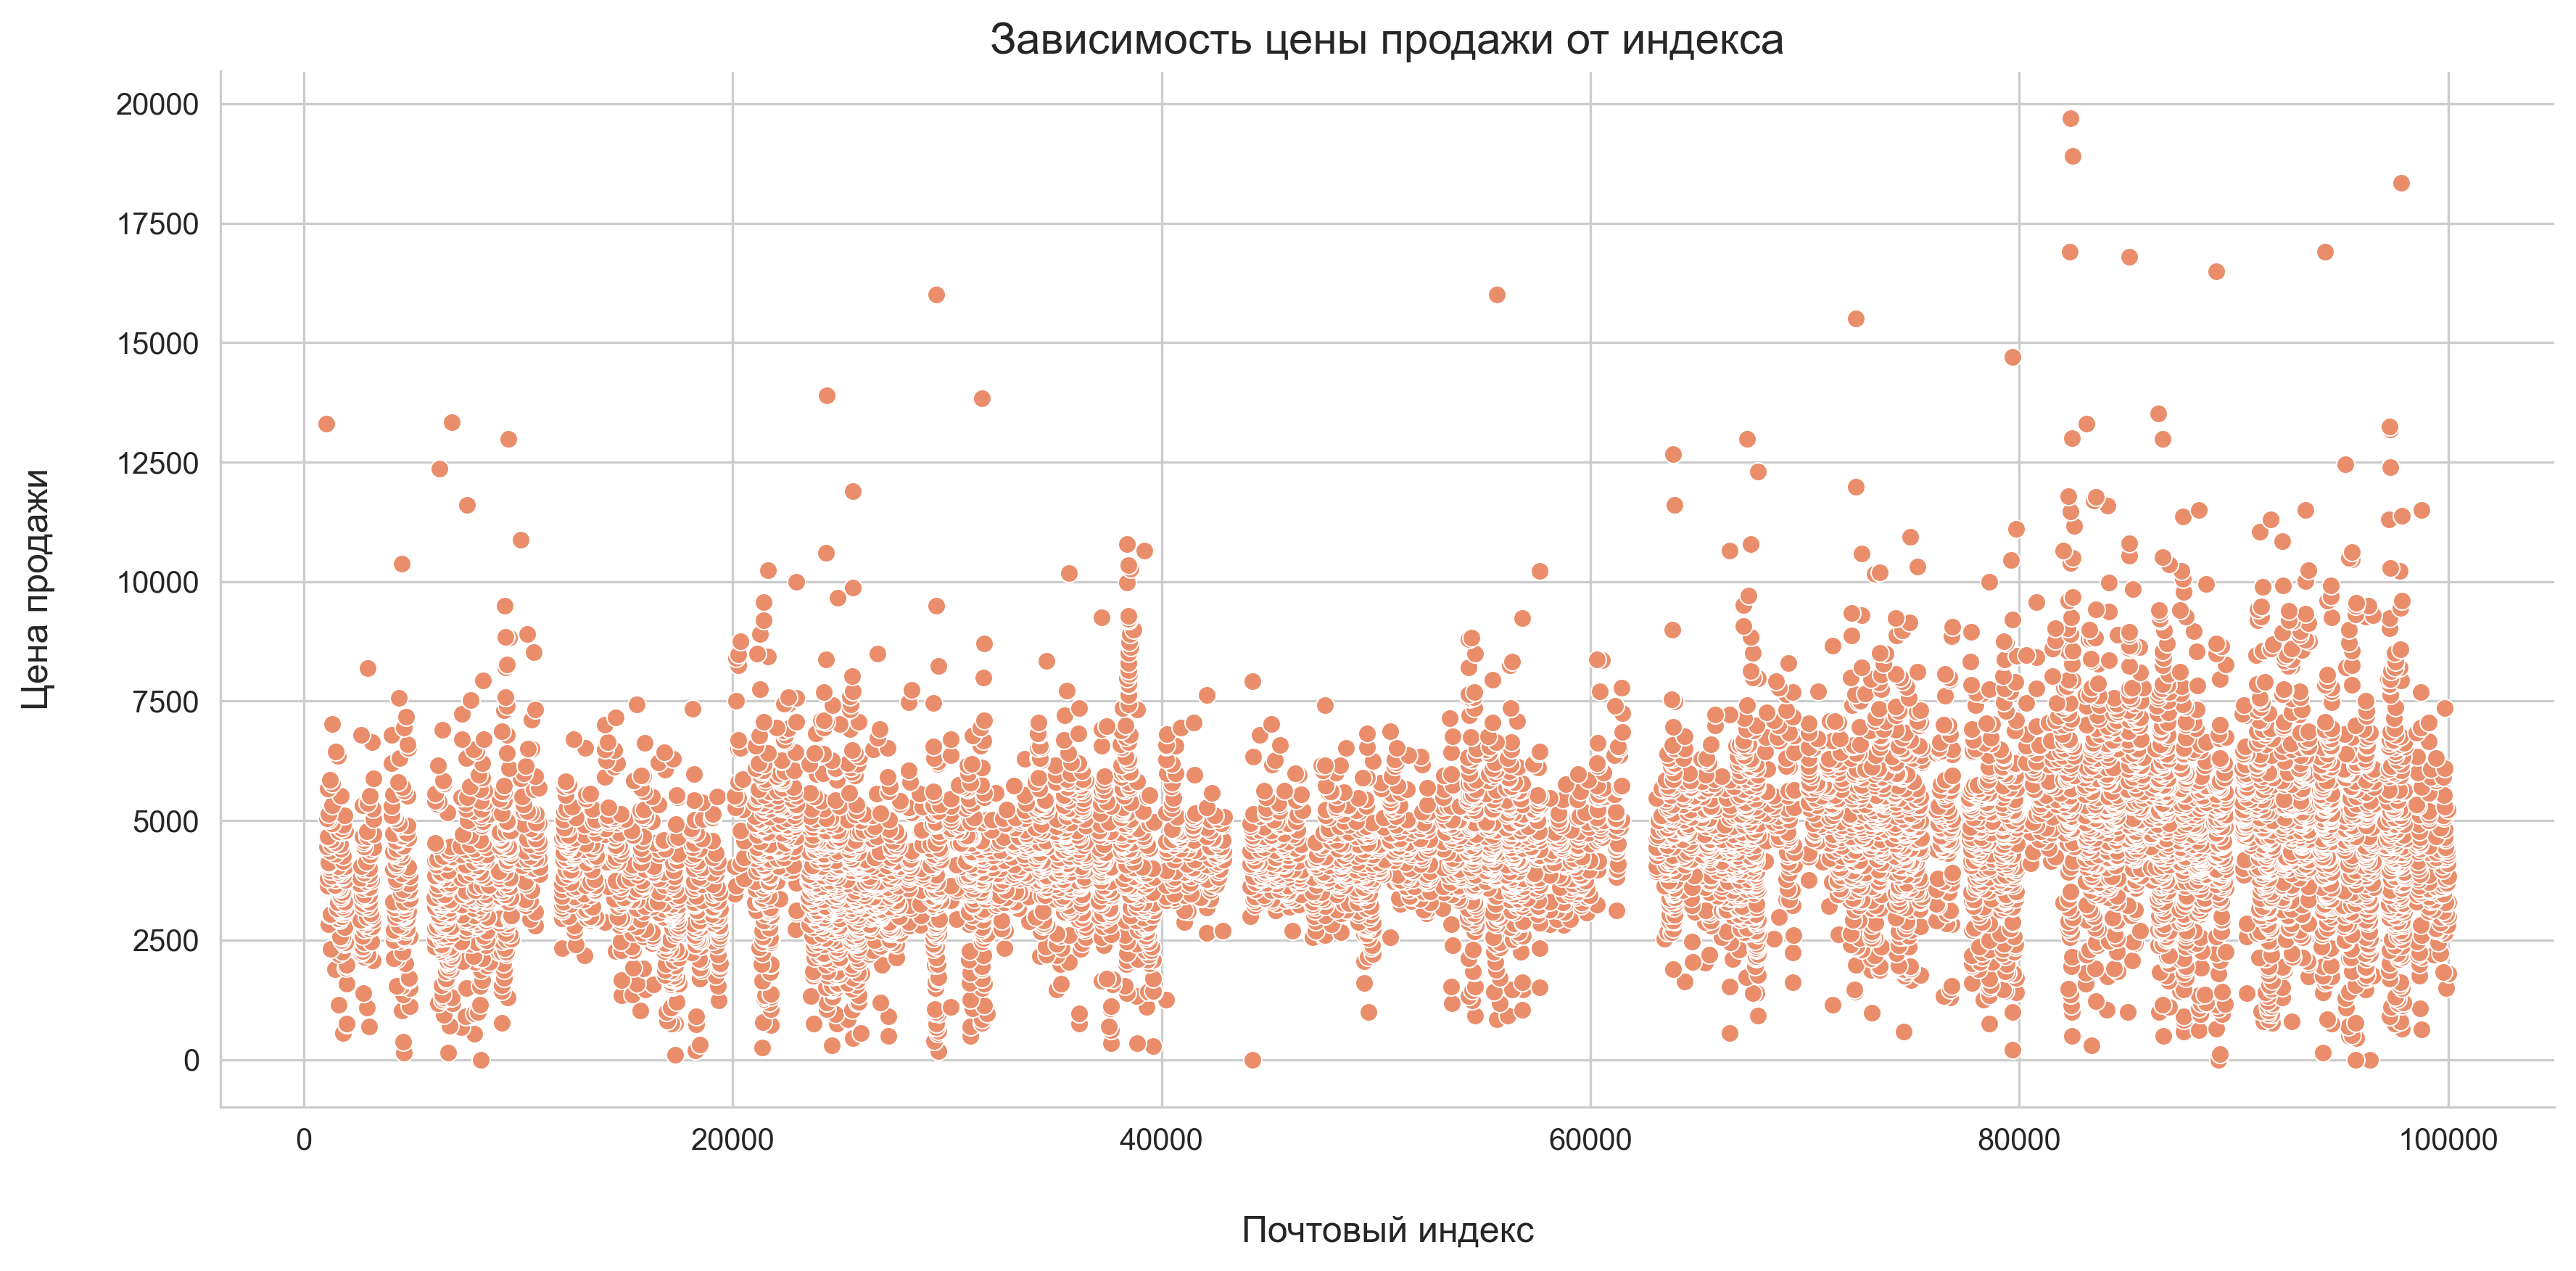

In [19]:
# считаем среднюю цену по индексам
g = data.groupby('postal_code')['price'].mean().sort_values()
# строим диаграмму зависимости цены от индекса
sns.scatterplot(x=g.index, y=g)
plt.title('Зависимость цены продажи от индекса')
plt.xlabel('Почтовый индекс')
plt.ylabel('Цена продажи');

Этот признак можно считать категориальным, так как почтовый индекс это локация, будь то город или страна. Всего у нас $8115$ уникальных локаций, указывающих на некоторый адрес пользователя. Какой-либо линейной зависимости на точечной диаграмме не наблюдается, разве что к шестизначным индексам плотность продаж увеличивается. Это могут быть крупные города в наблюдениях. Убедимся, что между `postal_code` и `price` нет линейной зависимости с помощью коэффициента Пирсона. 

In [20]:
# вычисляем корреляцию признаков
data[['postal_code', 'price']].corr()

postal_code  price
postal_code         1.00   0.08
price               0.08   1.00

Корреляция практически нуевая, линейная связь между признаками отсутствует. Данный признак можно удалить, чтобы он не создавал шум в данных при моделировании. 

In [21]:
# добавляем признак на удаление
features_for_delete.extend(['postal_code'])

## Количество фотографий

Это малоинформативный дискретный признак для будущего моделирования. Причём его значения равны нулю, судя по первичному обзору данных. Ничего кроме шума это на ничего не даст.

In [22]:
# проверяем количество уникалдьных значений 
data['number_of_pictures'].nunique()

1

In [23]:
# добавляем признак на удаление
features_for_delete.extend(['number_of_pictures'])

## Год и месяц регистрации

Эти признаки фиксируют год и месяц регистрации автомобиля. Скорее всего заполняются пользователем при регистрации анкеты. Значит, мы ожидаем ошибки в даннных, таков человеческий фактор. Обезопасить себя от такого рода ошибок можно грамотно составленной формой заполнения анкеты и проверкой введённых данных. Это не даст $100\%$ корректности, но позволит снизить количество некорректных данных.

Из двух признаков нас в большей степени интересует `registration_year`, *год регистрации авто*. Зная актуальный год анкеты на момент исследования, мы можем определить возраст авто как разницу между *датой скачивания анкеты* и *годом регистрации авто*. Точность до месяца будет излишней. Жизненный опыт подсказывает, что такая характеристика округляется до года, а сам возраст значительно влияет на цену продажи автомобиля. Последнее мы можем проверить с помощью корреляции или графиков зависимости. 

Если мы сгенерируем новый признак, то избавимся от двух других (`registration_year` и `registration_month`). Тем самым мы снизим размерность данных, что влияет на расчётное время моделей. Мы могли бы оставить и *год регистрации*, но возраст будет куда более информативым и лучше интерпретируемым признаком.

Сперва изучим `registration_month` для формирования общего представления о данных. Если мы обнаружим систематические ошибки, то их стоит внести в репорт для разработчиков сервиса.

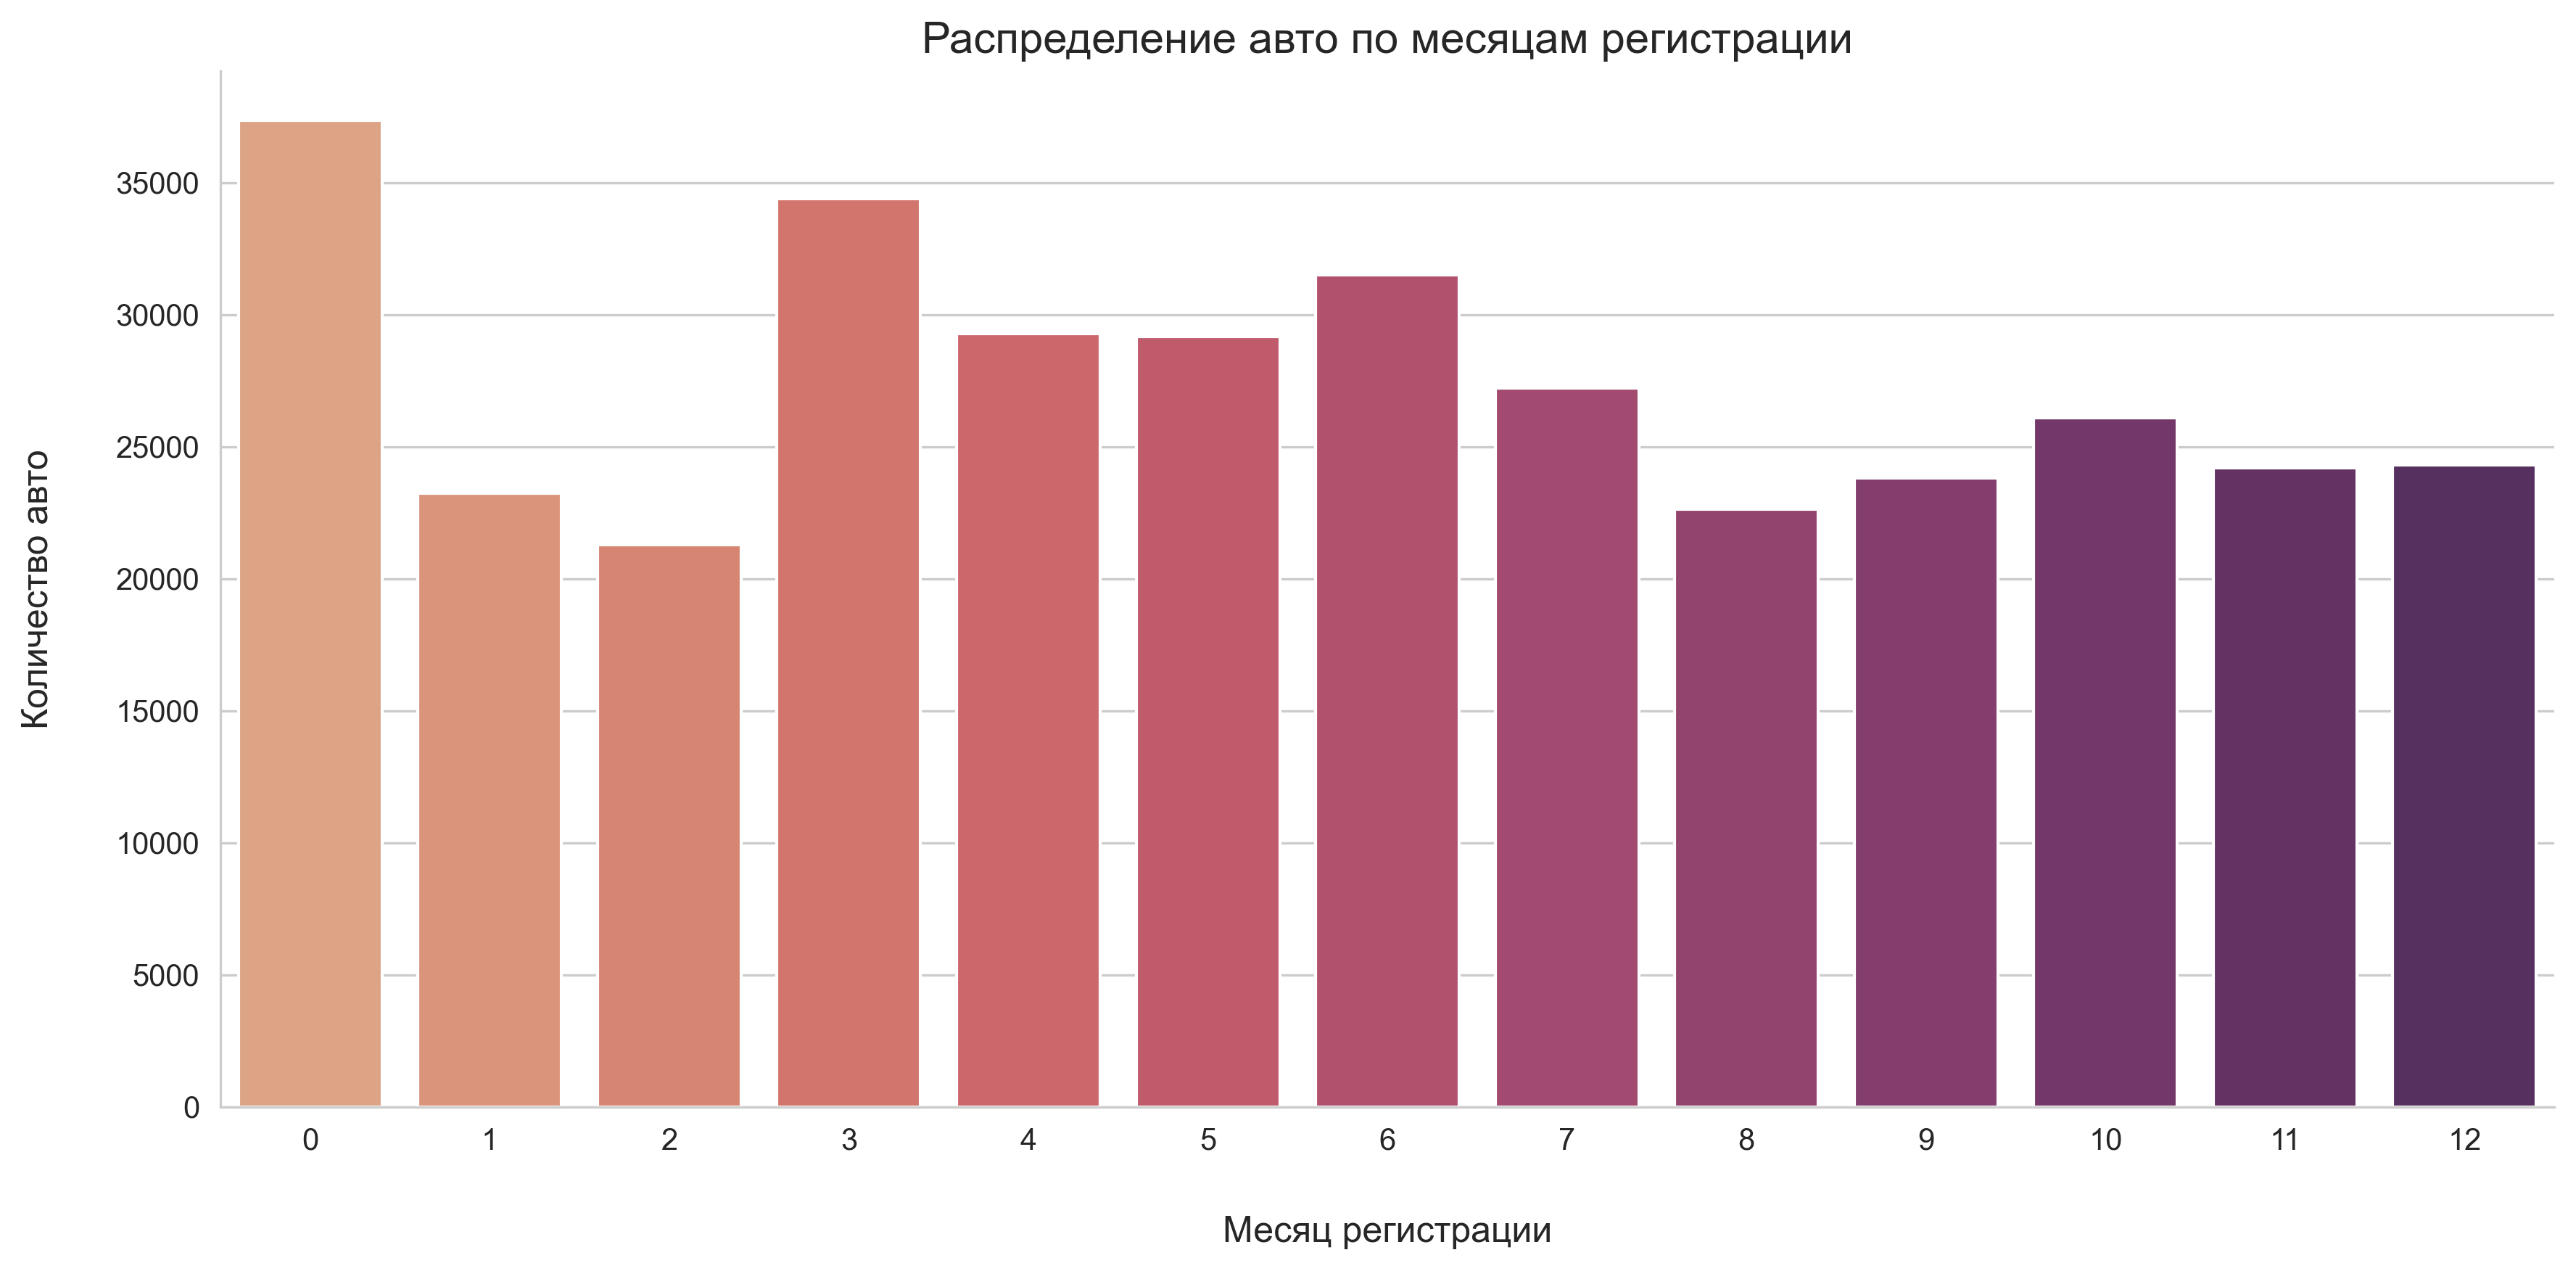

In [24]:
# строим столбчатую диаграмму 
sns.countplot(x='registration_month', data=data, palette='flare')
# настраиваем элементы графика
plt.title('Распределение авто по месяцам регистрации')
plt.xlabel('Месяц регистрации')
plt.ylabel('Количество авто');

В этом признаке наблюдается тринадцатый месяц под номером $0$. Если мы правильно понимаем данный признак, то он означает месяц, когда автомобиль впервые встал на учёт. Тогда нулевое значение может означать пропуск. Пользователь сервиса мог оставить поле в анкете незаполненным, в результате чего система сбора данных автоматически присвоила нулевое значение. Возможно, разработчики сервиса смогут пролить свет на природу возникновения этого значения.

Теперь по другим значениям. Чаще всего автомобили регистрировались весной и в начале лета. Это можно объяснить практикой [модельного года](https://translated.turbopages.org/proxy_u/en-ru.ru.49d1a22c-648b75b5-ece708e5-74722d776562/https/en.wikipedia.org/wiki/Model_year). В северо-американской и канадской части света он начинается в августе-сентябре. Это тесно связано с телевизионным сезоном: новый модельный ряд активно рекламируется, и весь следующий год идёт производство представленной модели на продажу. К концу этого периода цены на автомобили значительно снижаются, потому что автомобильному машиностроению необходимо распродать все остатки к переоснащению производства для новой модели. Как результат, цены снижаются, потребитель охотнее покупает товар. 

В европейской части, начиная с $1980$-ого года, новые модели производятся в июне или июле, а представление в автосалонах начинается в марте или сентябре в зависимости от региона. И опять же, учитывая психологию потребителя, большинство покупателей будут приобретать новую модель автомобиля не сразу, а дожидаясь снижения стартовой цены. Какой географический регион перед нами представлен на диаграмме сложно сказать, но сам механизм индустрии вполне объясняет наблюдаемое распределение значений.

Теперь взглянем на уникальные значения интересного для нас признака `registration_year`.

In [25]:
# выводим уникальные значения года регистрации авто
data['registration_year'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

У этого признака встерчаются аномальные значения, которые выглядят совсем неправдоподобно. [Первые автомобили](https://ru.wikipedia.org/wiki/%D0%98%D1%81%D1%82%D0%BE%D1%80%D0%B8%D1%8F_%D0%B0%D0%B2%D1%82%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D1%8F), приводимые в движение двигателем внутреннего сгорания, появились в $1806$ году. А первые зарегестрированные авто массового производства стали доступны в $1886$ году, благодаря [Карлу Бецу](https://ru.wikipedia.org/wiki/Benz_Patent-Motorwagen). Всё, что зафиксировано раньше этого года является ошибкой.

С начала двадцатого века автомобильное машиностроение стало набирать обороты, поэтому наличие таких годов как $1910-1920$ вполне оправдано, но слабо укладывается в реальную действительность. Если в данных присутствует анкета с таким *годом регистрации*, то на продажу выставлен редкий раритет. Даже если это так, то такой экзепляр не вписывается в бизнес-логику нашего сервиса, его место на аукционе. Наш же сервис ориентирован на современный автомобиль, и на данный момент цель компании — привлечь больше клиентов. С раритетом это не вяжется. 

Возьмём более позднее время. Неактуальными являются года позже $2016$: временная отсечка данных уже произошла, а самый последний наступивший год это $2019$. Отфильтруем данные от невозможных дат и взглянем на распределение значений года регистрации авто.   

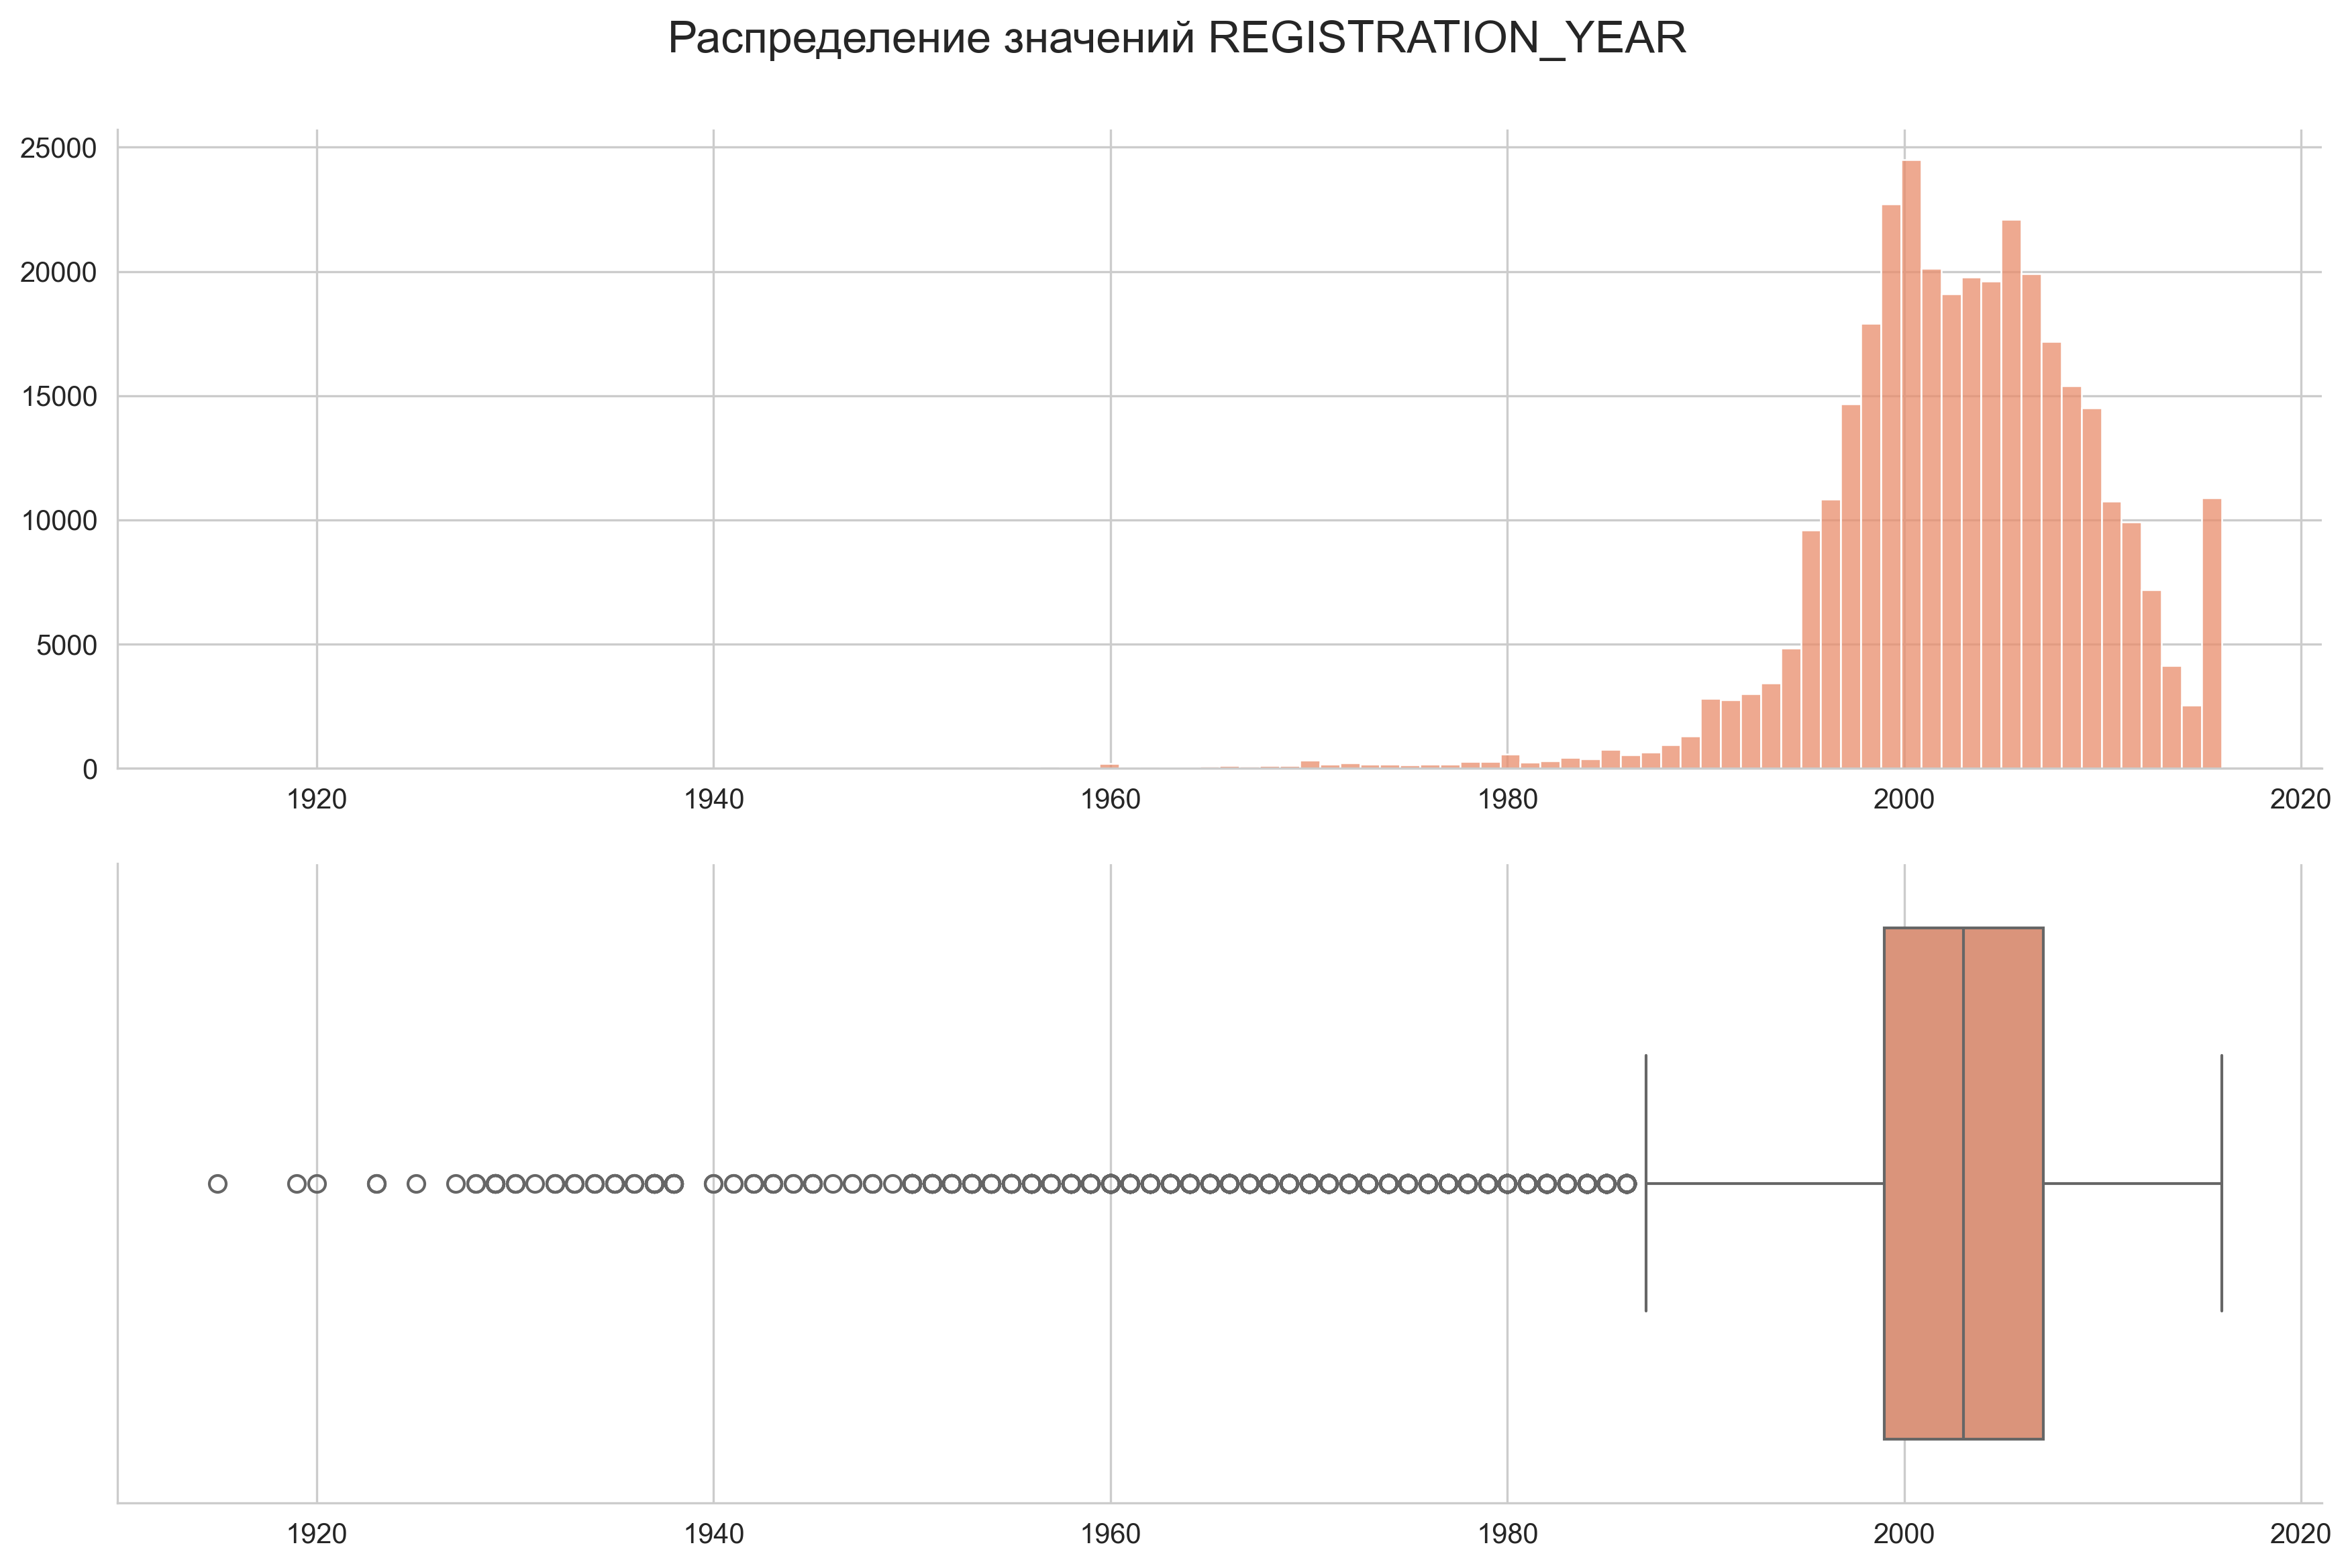

In [26]:
# фильтруем данные
data = data.query('registration_year > 1910 & registration_year <= 2016')
# вызываем функцию отрисовки распределений
get_distplots(data['registration_year'], bins=100)

Подавляющая часть набюдаемых авто была зарегистрирована в конце $90$-х — в начале $00$-х. Распределение значений похоже на нормальное, наблюдается повышение частотности значений расположенных у правой границы. Это свежие авто, зарегистрированные в $2016$ году. Актуальным для нас периодом можно считать года после $1980$ до $2016$ включительно, что является полуторным *IQR*. Отфильтруем данные по этому диапазону, тем самым избавившись от выбросов и аномальных значений.   

In [27]:
# получаем границы полуторного межквартильного размаха
lower_bound, upper_bound = get_outlier_bounds(data['registration_year'], display=True)
# фильтруем данные по полученному диапазону
data = data.loc[(data['registration_year'] >= lower_bound) & (data['registration_year'] <= upper_bound)]

------------------------------------------
Первый квартиль: 1999.0
------------------------------------------
Третий квартиль: 2007.0
------------------------------------------
Межквартильный размах: 8.0
------------------------------------------
Нижняя граница 1.5(IQR): 1987.0
------------------------------------------
Верхняя граница 1.5(IQR): 2019.0
------------------------------------------


In [28]:
# проверяем форму данных
get_sample_delta(data, SOURCE_DATA, display_mode='missed')

----------------------------------------------------------------------------
Исходная форма данных: (354369, 16)
----------------------------------------------------------------------------
Текущая форма данных: (333093, 16)
----------------------------------------------------------------------------
Было удалено 6.0% строк
----------------------------------------------------------------------------


Мы откинули допустимое количество строк с аномальными значениями в `registration_year`. Добавим `registration_month` и `registration_year` в список на удаление. Здесь же вычислим возраст авто и посмотрим его влияние на цену продажи.

In [29]:
# вычисляем возраст авто и добавляем в датафрейм
data['age'] = data['registration_year'].apply(lambda x: LAST_ACTUAL_YEAR - x)
# добавляем признаки на удаление
features_for_delete.extend(['registration_month', 'registration_year'])

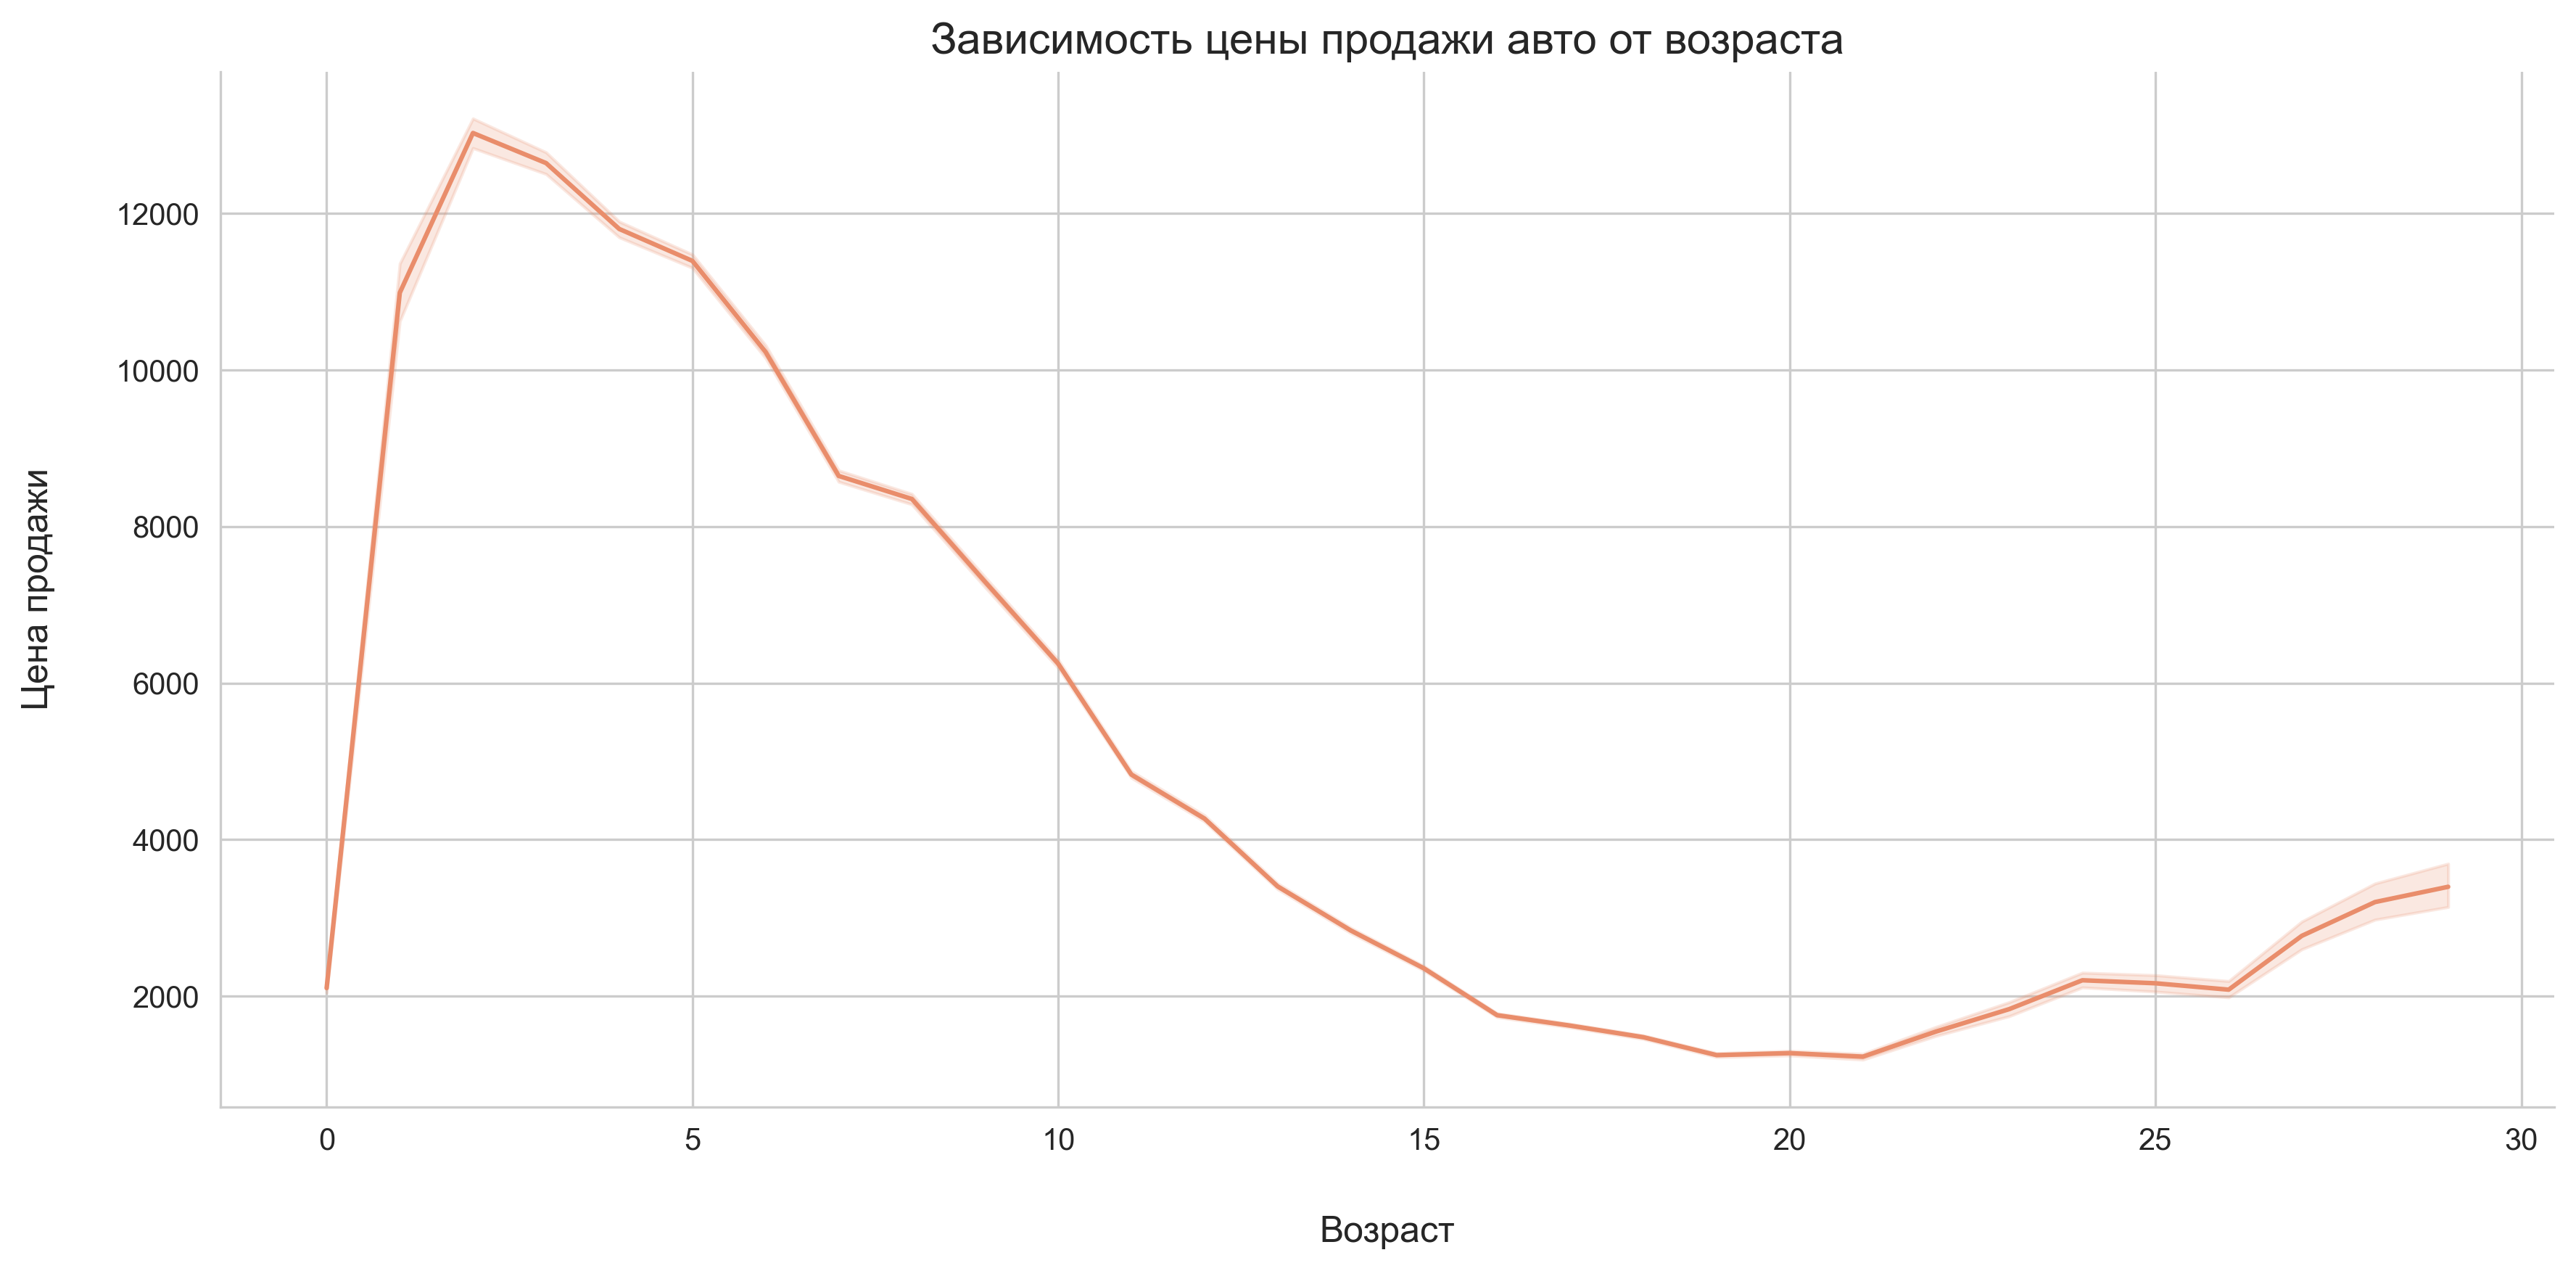

In [30]:
# строим график зависимости возраста авто от цены
sns.lineplot(data=data, x='age', y='price')
plt.title('Зависимость цены продажи авто от возраста')
plt.xlabel('Возраст')
plt.ylabel('Цена продажи');

Если не обращать внимания рост цены автомобилей от $0$ до $2$ лет, то в целом тенденция снижения *цены* с увеличением *возраста* четко наблюдается. Начиная с $21$ года цена начинает немного расти. Возможно это происходит из-за наличия каких-либо ценных экземпляров, выставленных на продажу. И действительно, поискав первую десятку самых дорогих авто с возрастом больше $20$ лет, мы не найдём противоречий. Данные экземпляры вызывают интерес у колекционеров и автолюбителей.    

In [31]:
# выводим топ 10 дорогих авто возрастом более 21 года
data.loc[data['age'] > 21] \
    .groupby(['brand', 'model'])['price'].mean() \
    .sort_values(ascending=False).head(10)

brand          model      
mercedes_benz  g_klasse       12203.37
volkswagen     kaefer         11433.33
mercedes_benz  sl             11332.82
porsche        boxster        11175.00
               other          11056.65
               911            10392.20
bmw            m_reihe        10367.79
               z_reihe         9999.00
land_rover     range_rover     9749.33
alfa_romeo     spider          9660.69
Name: price, dtype: float64

## Цена

Изучим цены на авто, присутствующие в данных. Это наш целевой признак, он является непрерывным. Значит, перед нами стоит задача регрессии. 

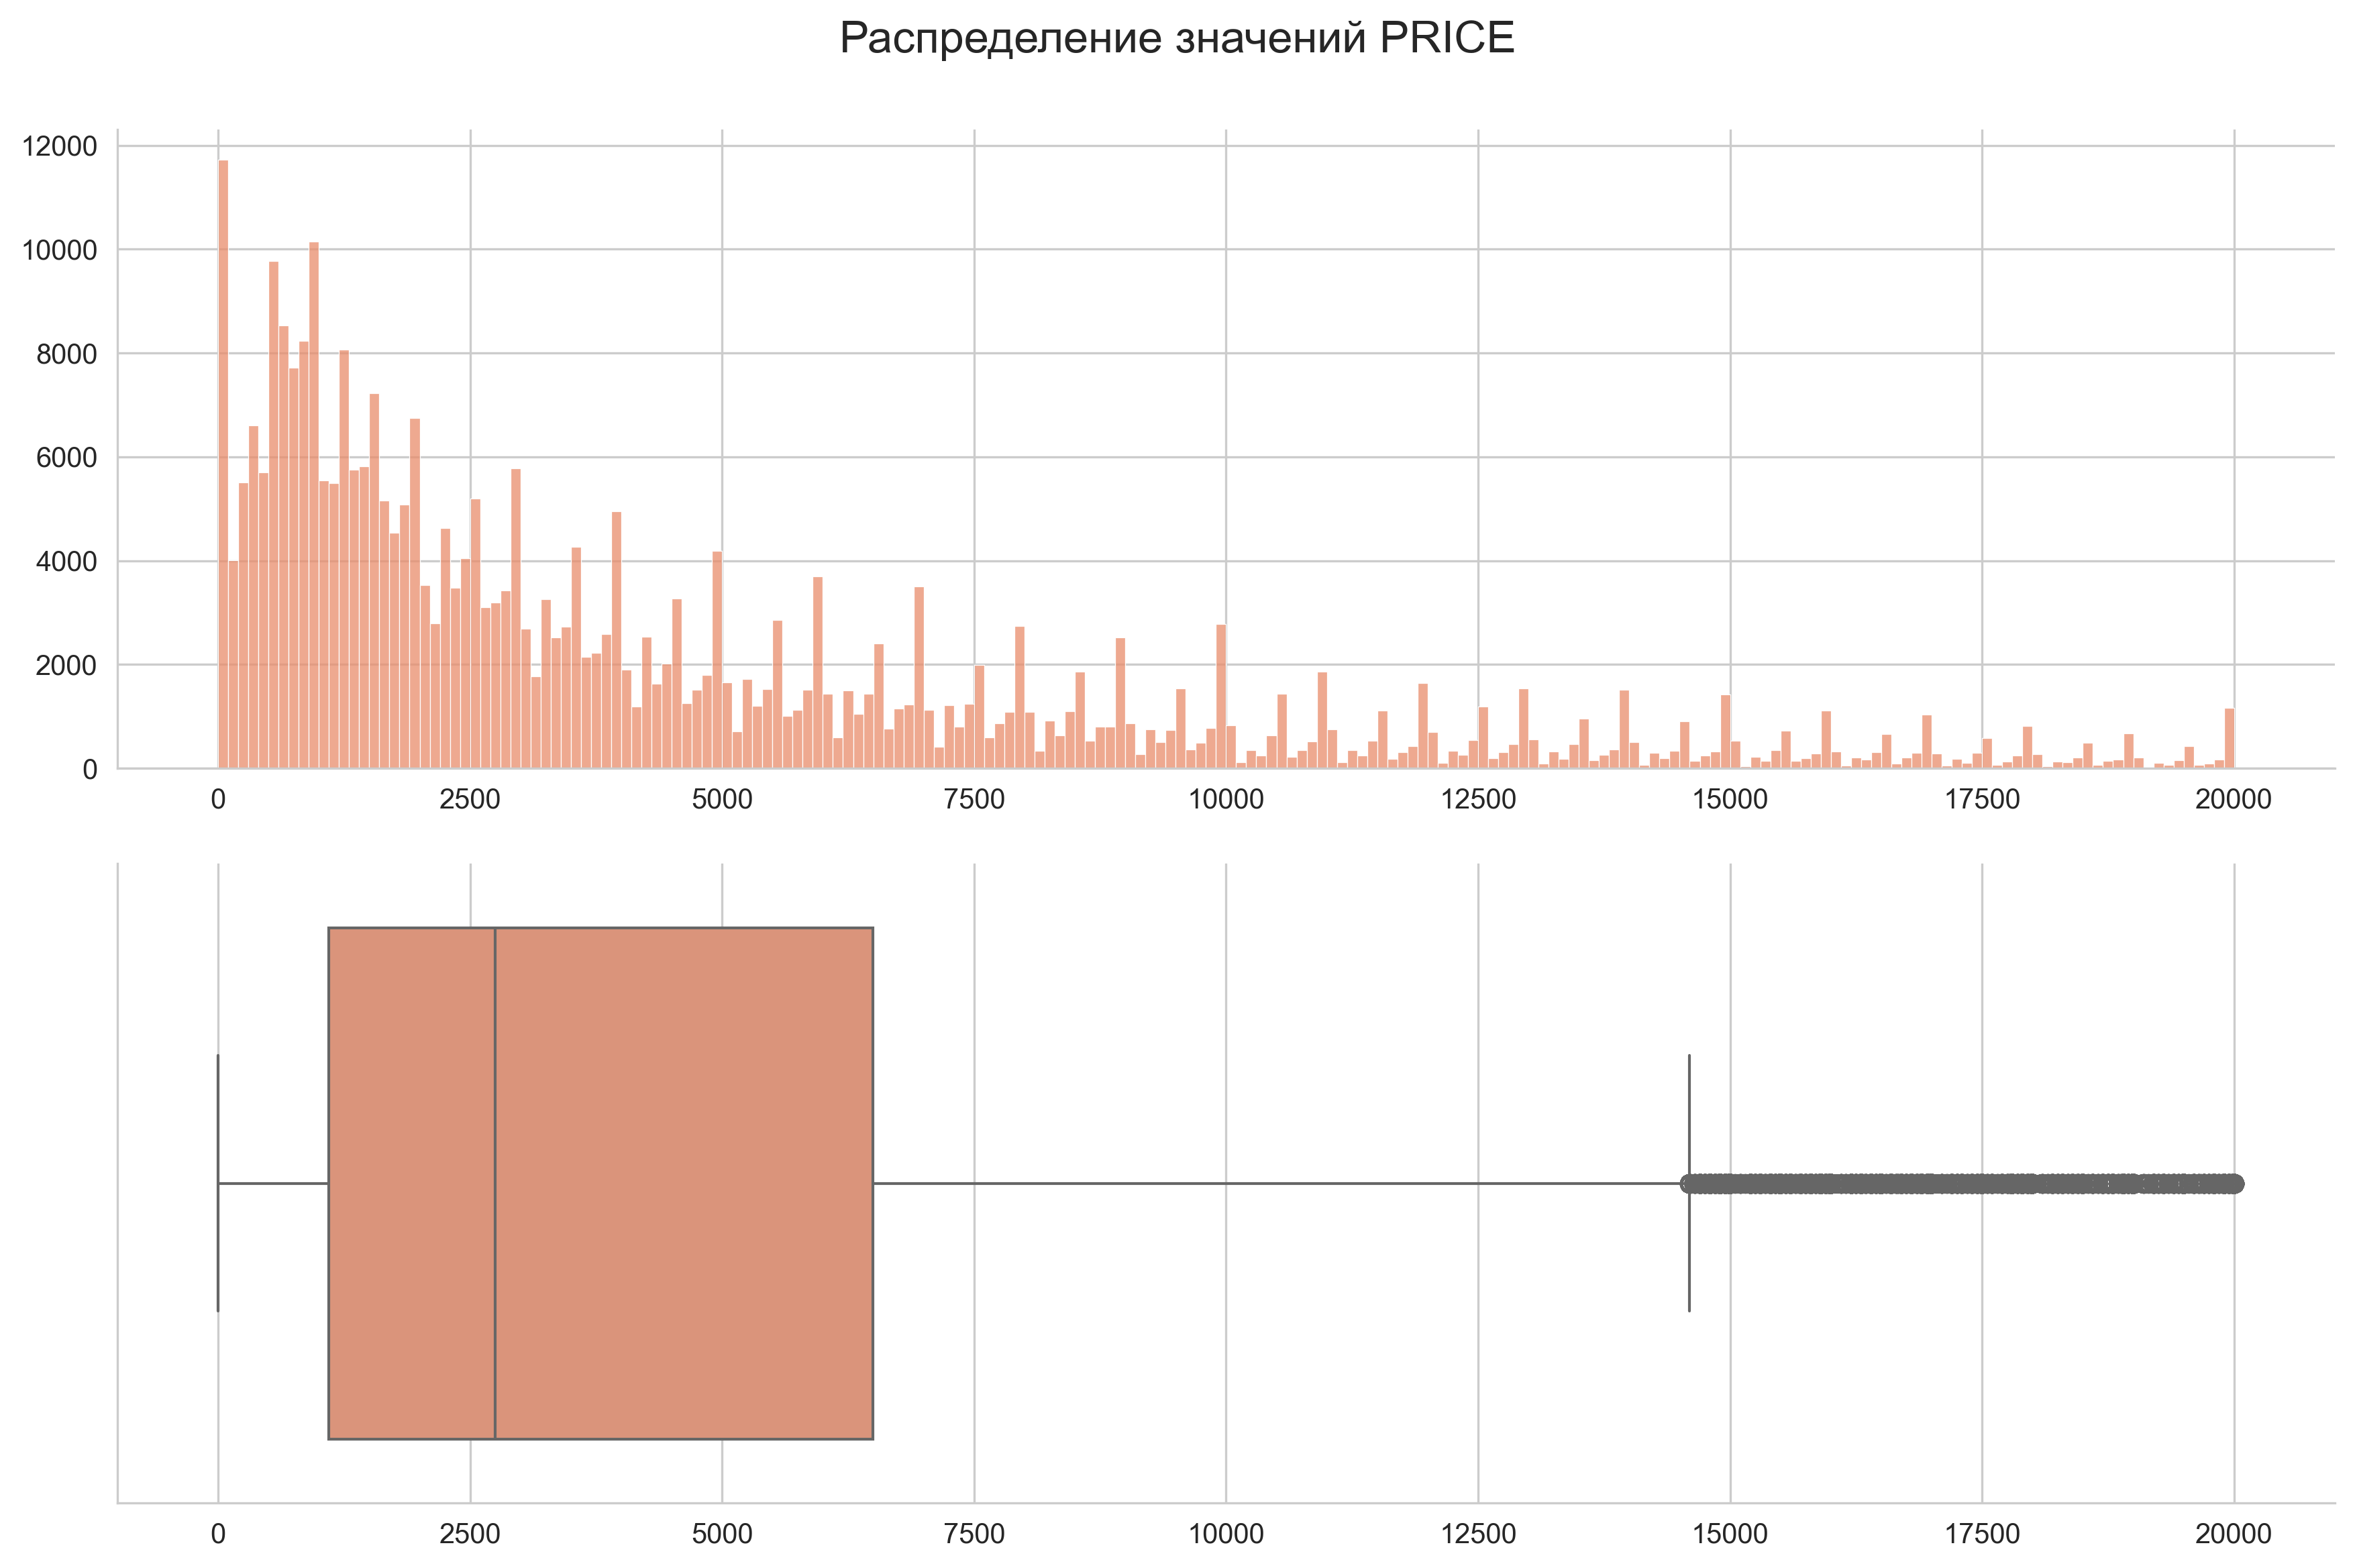

In [32]:
# вызываем функцию отрисовки распределений
get_distplots(data['price'])

In [33]:
# выводим описательные статистики
data['price'].describe()

count    333093.00
mean       4449.58
std        4529.49
min           0.00
25%        1099.00
50%        2750.00
75%        6499.00
max       20000.00
Name: price, dtype: float64

Распределение *цены* перекошено влево, справа длинный хвост, который заканчивается плотно расположенными выбросами. Присутствуют нулевые значения, что может быть ошибкой в данных. Например, владелец мог не заполнить данное поле в анкете, тем самым предполагая договорную цену. Или владелец по какой-то причине решил отдать авто даром. В любом случае, такие данные нас не интересуют. А вот самые дорогие авто допустимы, и вполне существуют. Поэтому, верхнюю границу мы трогать не будем. Что же насчёт минимальных значений цены на авто? Автомобиль за $5, 10, 20$ евро выглядит нереалистично, поэтому нам необходимо выбрать какую-то границу минимума. Например, пятый перцентиль. Тем самым можно отсечь сомнительные данные не в ущерб исследованию.  

In [34]:
# отбрасываем сомнительные данные
data = data.loc[data['price'] > data['price'].quantile(.05)]
# проверяем форму данных
get_sample_delta(data, SOURCE_DATA, display_mode='missed')

----------------------------------------------------------------------------
Исходная форма данных: (354369, 16)
----------------------------------------------------------------------------
Текущая форма данных: (315433, 17)
----------------------------------------------------------------------------
Было удалено 11.0% строк
----------------------------------------------------------------------------


Ещё $5\%$ данных мы выкинули из датафрейма. Общее количество превысило допустимую норму, но у нас нет выхода. Нам достались грязные данные, а как мы знаем: 

>**Garbage In → Grabage Out** 

## Бренды и модели автомобилей

Эту пару признаков следует рассматривать неразрывно. Так сложилось, что модель является продолжением бренда. Бренд занимает своё место на рынке с помощью позиционирования и уникальности торгового предложения. Индустрия автомобилестроения не исключение. В действиетльности, особо успешные модели становятся самостоятельными категориями, в отрыве от бренда. Всем и так понятно кто стоит за производством, например, *Polo*, *Focus* или *X5*. Исходя из такой мысли, возможно имеет смысл объединить эти признаки в один. Но сначала изучим их.

In [35]:
# выводим количество брендов
print('-' * 42)    
print('Количество брендов:', data['brand'].nunique())
print('-' * 42)    
# выводим количество моделей
print('Количество моделей:', data['model'].nunique())
print('-' * 42)    

------------------------------------------
Количество брендов: 40
------------------------------------------
Количество моделей: 247
------------------------------------------


Количество разных брендов и их моделей внушительное. Оба признака являются категориальными повышенной кардинальности. В дальнейшем нам необходимо будет их правильно закодировать, учитывая их кардианльность и отсутствие порядка. Взглянем на популярность брендов.

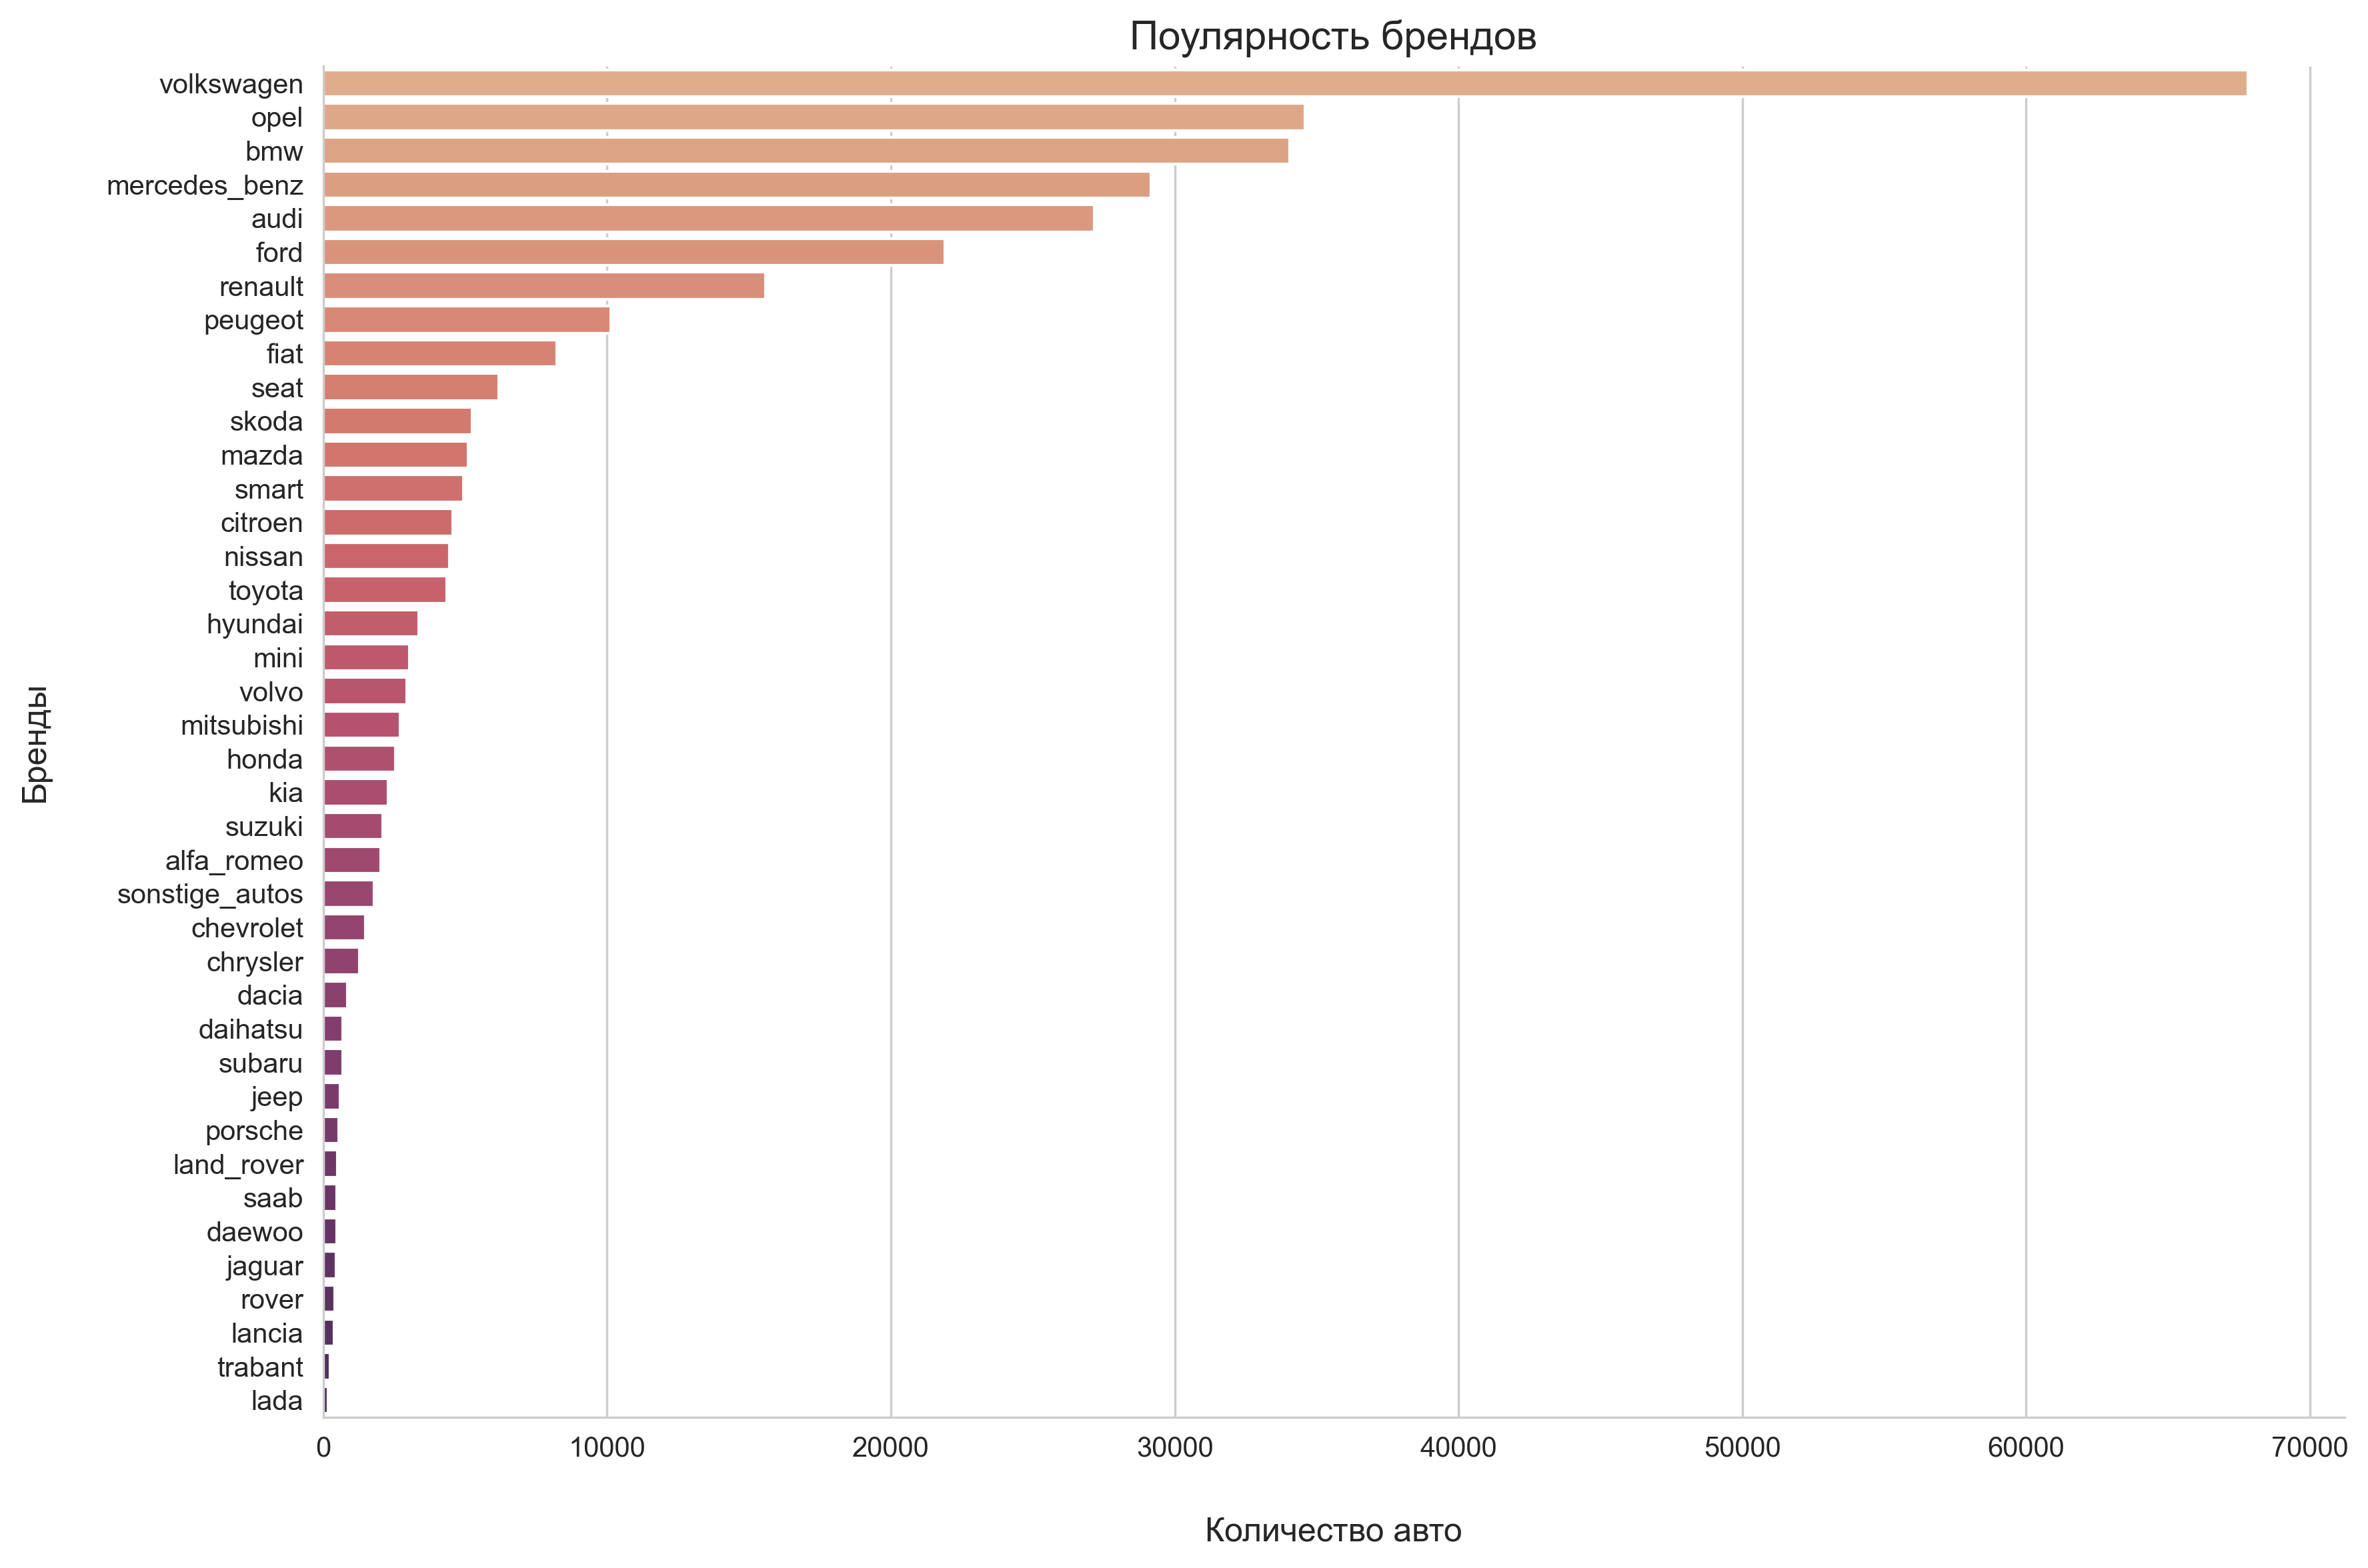

In [36]:
# строим фигруру
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# строим столбчатую диаграмму брендов
sns.countplot(y='brand', data=data, order=data['brand'].value_counts().index, palette='flare')
# настраиваем элементы графика
plt.title('Поулярность брендов')
plt.xlabel('Количество авто')
plt.ylabel('Бренды');

В первой пятёрке находятся исключительно немцы. Что и говорить, Карл Бенц был первым, а соотечественники продолжают держать пальму первенства. Шестое место у *Ford*, далее французы и итальянцы. Среди значений есть несколько неоднозначных брендов: `sonstige_autos`, `rover` и `land_rover`. 

Первый в переводе с немецкого означает «другие автомобили». Запрос по сети не выдает наличие такого бренда, вероятнее всего перед нами некая сборная категория разных автомобилей, невошедших в основные категории. Важно отметить, что само название категории намекает нам на то, что сервис может быть немецким.

Категория других авто будет лишним шумом для моделей, поэтому мы должны избавиться от неё. Проверим количество и удалим эту категорию.

In [37]:
# фильруем данные
display(data.query('brand == "sonstige_autos"').head())
print('-' * 42)  
# считаем количество строк
print('Количество других авто:', data.query('brand == "sonstige_autos"').shape[0])
print('-' * 42)    

date_crawled  price vehicle_type  registration_year gearbox  power  \
431 2016-03-20 20:45:27   3950        small               2004    auto      5   
661 2016-04-01 15:56:27   9900          suv               2000    auto    250   
700 2016-03-30 21:37:21   6999        sedan               2010    auto    186   
985 2016-03-15 16:37:22    500        sedan               2010  manual    101   
999 2016-04-02 23:39:49   3900        wagon               1990  manual      0   

    model  kilometer  registration_month fuel_type           brand repaired  \
431   NaN      70000                   5  gasoline  sonstige_autos       no   
661   NaN     150000                   4       lpg  sonstige_autos       no   
700   NaN     125000                   4    petrol  sonstige_autos       no   
985   NaN      70000                   1    petrol  sonstige_autos      yes   
999   NaN      30000                   5    petrol  sonstige_autos      NaN   

    date_created  number_of_pictures  postal_code           last_seen  age  
431   2016-03-20                   0        90562 2016-04-03 04:17:08   12  
661   2016-04-01                   0        17309 2016-04-07 14:56:03   16  
700   2016-03-30                   0        81929 2016-04-05 11:18:33    6  
985   2016-03-15                   0        76829 2016-03-21 14:15:21    6  
999   2016-04-02                   0        15345 2016-04-07 01:46:23   26

------------------------------------------
Количество других авто: 1793
------------------------------------------


In [38]:
# удаляем категорию
data = data.query('brand != "sonstige_autos"')
# проверяем форму данных
get_sample_delta(data, SOURCE_DATA, display_mode='missed')

----------------------------------------------------------------------------
Исходная форма данных: (354369, 16)
----------------------------------------------------------------------------
Текущая форма данных: (313640, 17)
----------------------------------------------------------------------------
Было удалено 11.5% строк
----------------------------------------------------------------------------


Теперь разберёмся с брендами `rover` и `land_rover`. Как ни странно, но это две разные компании, [одна](https://ru.wikipedia.org/wiki/Rover_Company) была основана в $1887$ году и поглощена *Ford* в $2005$, [вторая](https://ru.wikipedia.org/wiki/Land_Rover) — начиналась в $1947$ году как промежуточный вариант для компании *Rover*, но вскоре стала самостоятельной. Компании разные, но пользователями сервиса могут подразумеваться как одно и то же. Проверим это. 

In [39]:
# сводим данные по моделям брендов rover и land_rover
data.query('brand == "rover" | brand == "land_rover"') \
    .groupby(['brand', 'model'])['price'] \
    .count()

brand       model             
land_rover  defender               68
            discovery              76
            freelander            206
            other                   3
            range_rover            71
            range_rover_evoque      2
            range_rover_sport      54
rover       defender                1
            discovery               2
            freelander              2
            other                 337
            rangerover              3
Name: price, dtype: int64

Похоже, что не все пользователи знают разницу между *Rover* и *Land Rover*, благодаря чему у нас есть неявные дубликаты: модели *Rover* совпадают с [модельным рядом](https://ru.wikipedia.org/wiki/%D0%9A%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D1%8F:%D0%90%D0%B2%D1%82%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D0%B8_Land_Rover) *Land Rover*. А вот c `other` не всё так однозначно. Это категория моделей, которые по каким-то причинам не попали в одну из имеющихся. Вполне возможно, что заказчик не знал название своей модели и указал в анкете «другое». Но как учесть одновременно путаницу в брендах и неоднозначную категорию `other`? 

Во первых, *Rover* выпускала автомобили раньше *Land Rover*, вплоть до своего банкротства в $2005$ году. *Land Rover* же выпускает свои автомобили по сей день. В таком случае у нас могут быть пересечения  до $2005$ года. Во-вторых, модельный ряд *Rover* составляли в основном седаны, а *Land Rover* ориентрован только на внедорожники. Значит, чтобы определить какие из моделей *Rover* в `other` могут пренадлежать *Land Rover*, мы должны ориентироваться на *возраст авто* до $2005$ года включительно и *тип кузова*.

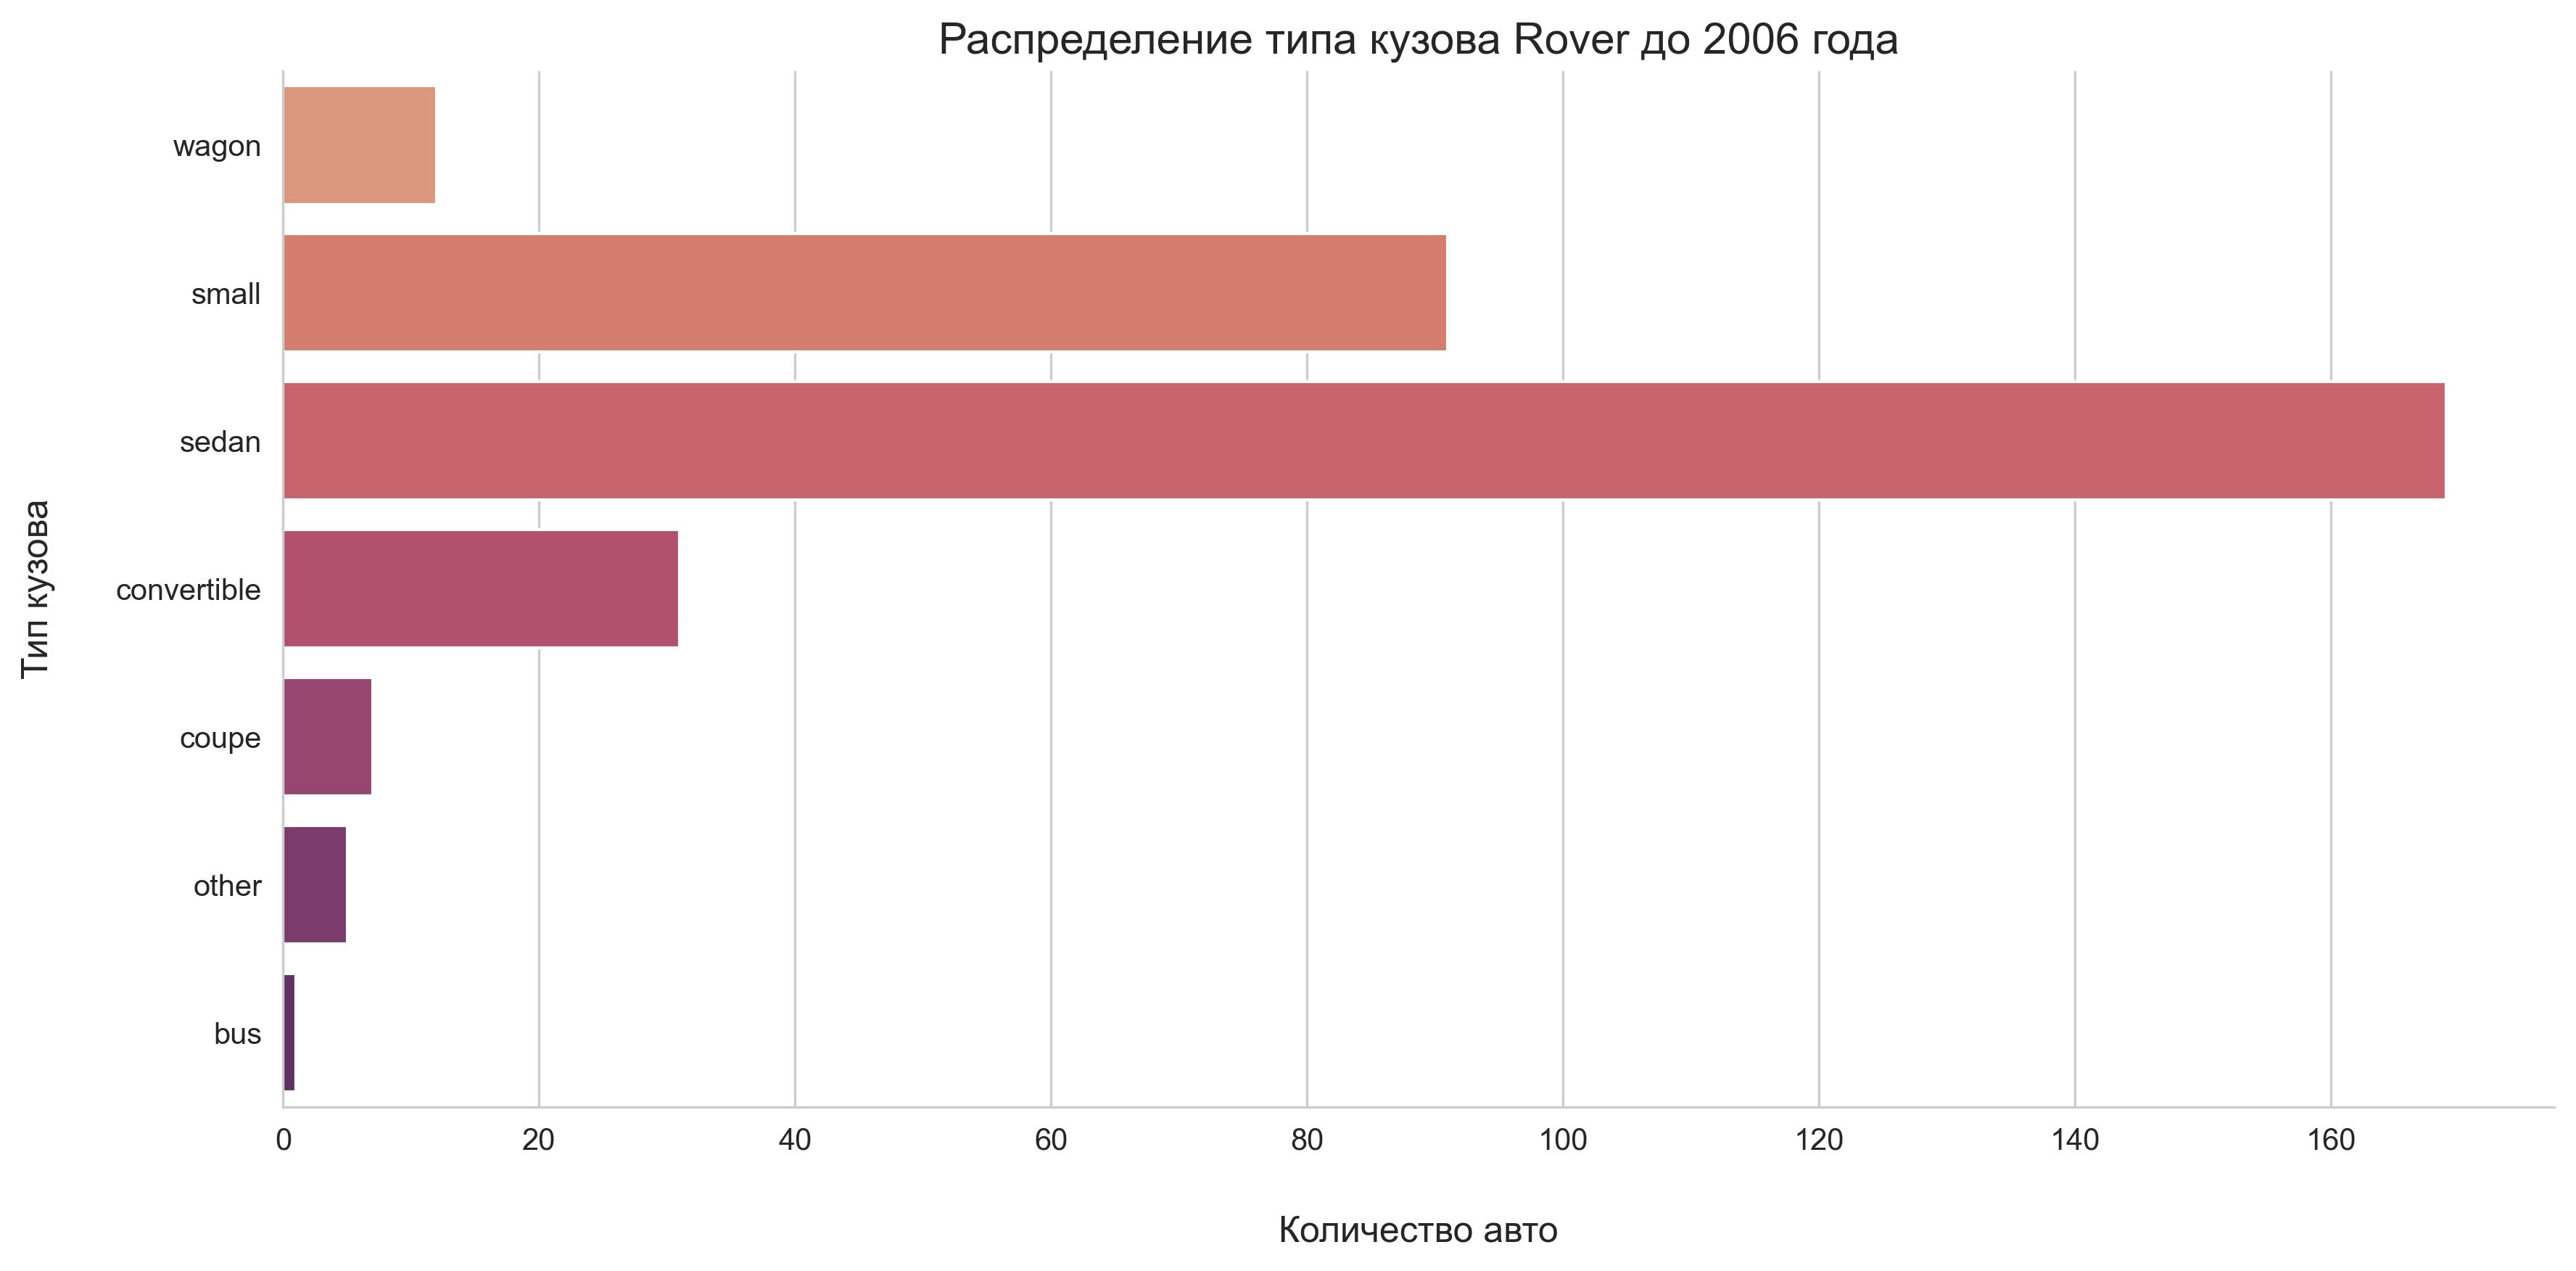

In [40]:
# получаем тип кузова по фильтру 
g = data.query('brand == "rover" & registration_year < 2006') \
    .loc[data['model'] == 'other', 'vehicle_type']
# строим столбчатую диаграмму фильтра
sns.countplot(y=g, palette='flare')
plt.title('Распределение типа кузова Rover до 2006 года')
plt.xlabel('Количество авто')
plt.ylabel('Тип кузова');

Из перечисленных типов кузова только `bus` не может принадлежать модельному ряду *Rover*. В сети Интернет по запросу «Land Rover bus» можно найти изображение автобуса, на котором проглядывается шильдик *Land Rover*. Значит, они существуют! 

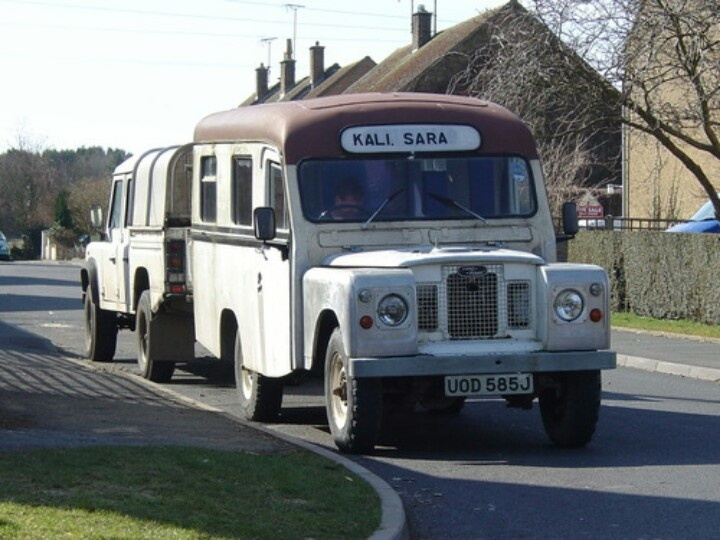

Насчёт типа кузова `other` мы ничего сказать не можем кроме того, что это сборная категория. Её оставим без изменений, а автобусу сменим бренд. Также сменим бренд таким моделям как `discovery` `freelander` `defender` и `rangerover` в *Rover*, переименовав последнюю в `range_rover`.

In [41]:
# меняем бренд кузову bus
data.loc[(data['brand'] == 'rover') & (data['vehicle_type'] == 'bus'), 'brand'] = 'land_rover'
# исправляем имя модели
data['model'].replace('rangerover', 'range_rover', inplace=True)
# меняем бренд моделям в Rover
for model in ['discovery', 'freelander', 'defender', 'range_rover']:
    data.loc[(data['brand'] == 'rover') & (data['model'] == model), 'brand'] = 'land_rover'

# проверяем результат
data.query('brand == "rover" | brand == "land_rover"') \
    .groupby(['brand', 'model'])['price'] \
    .count()

brand       model             
land_rover  defender               69
            discovery              78
            freelander            208
            other                   4
            range_rover            74
            range_rover_evoque      2
            range_rover_sport      54
rover       other                 336
Name: price, dtype: int64

Порядок в брендах навели, теперь можно разобраться с пропусками в `model`. Познакомимся с ними поближе.

In [42]:
# выводим данные с пропусками в признаке
data[data['model'].isna()].head(10)

date_crawled  price vehicle_type  registration_year gearbox  power  \
1   2016-03-24 10:58:45  18300        coupe               2011  manual    190   
81  2016-04-03 12:56:45    350        small               1997  manual     54   
135 2016-03-27 20:51:23   1450        sedan               1992  manual    136   
151 2016-03-27 20:47:22   6799        small               2009     NaN     60   
160 2016-03-19 19:49:15    500        small               1999  manual      0   
161 2016-03-28 10:50:04   1495        wagon               2001     NaN     64   
186 2016-03-16 15:51:08  14000        sedan               2008     NaN    235   
193 2016-03-27 12:47:45   1200        coupe               1990  manual     45   
260 2016-04-04 09:49:59    450          NaN               2016  manual      0   
273 2016-03-29 23:38:02   1500        coupe               1994  manual    116   

    model  kilometer  registration_month fuel_type       brand repaired  \
1     NaN     125000                   5  gasoline        audi      yes   
81    NaN     150000                   3       NaN        fiat      yes   
135   NaN     150000                   0       NaN        audi       no   
151   NaN      20000                   5    petrol  volkswagen       no   
160   NaN     150000                   0    petrol     renault       no   
161   NaN     150000                   9  gasoline  volkswagen      NaN   
186   NaN     150000                   0       NaN         bmw       no   
193   NaN     150000                   0    petrol  volkswagen      NaN   
260   NaN     150000                   3    petrol  mitsubishi       no   
273   NaN     150000                   8       NaN        audi       no   

    date_created  number_of_pictures  postal_code           last_seen  age  
1     2016-03-24                   0        66954 2016-04-07 01:46:50    5  
81    2016-04-03                   0        45665 2016-04-05 11:47:13   19  
135   2016-03-27                   0        38709 2016-04-05 20:17:31   24  
151   2016-03-27                   0        89077 2016-03-27 20:47:22    7  
160   2016-03-19                   0        26969 2016-04-01 11:17:48   17  
161   2016-03-28                   0        99086 2016-04-04 11:45:46   15  
186   2016-02-12                   0        95131 2016-04-07 14:56:12    8  
193   2016-03-27                   0        83317 2016-04-07 08:17:08   26  
260   2016-04-04                   0        59302 2016-04-06 11:17:11    0  
273   2016-03-29                   0        32791 2016-04-06 20:16:34   22

Непохоже, что пропуски в *модели* авто как-то связаны с другими признаками. Но возможно есть такой бренд, который попросту не имеет модельный ряд. В нашей десятке наблюдений присутствуют довольно популярные бренды, в широком ассортименте которых мы уверены. Значит, пропуски могли возникнуть из-за незнания владельца модели своего авто или по причине технического сбоя в сборе данных. Да-да, причины всегда одни и те же: технический сбой или человеческий фактор 🤷‍♂️. 

Стратегию заполнения пропусков в `model` мы выберем следующую: заполним пропуски модой группы по *бренду* и *году регистрации*. Так мы увеличим точность характерного значения в отличие от заполнения общей модой (модой всей выборки). Воспользуемся для этого функцией заполнения, которую заранее написали. Обязательно проверим распределение моделей до преобразования и после, чтобы проконтролировать корректность нашего заполнения.

------------------------------------------
Текущее количество пропусков: 11663
------------------------------------------


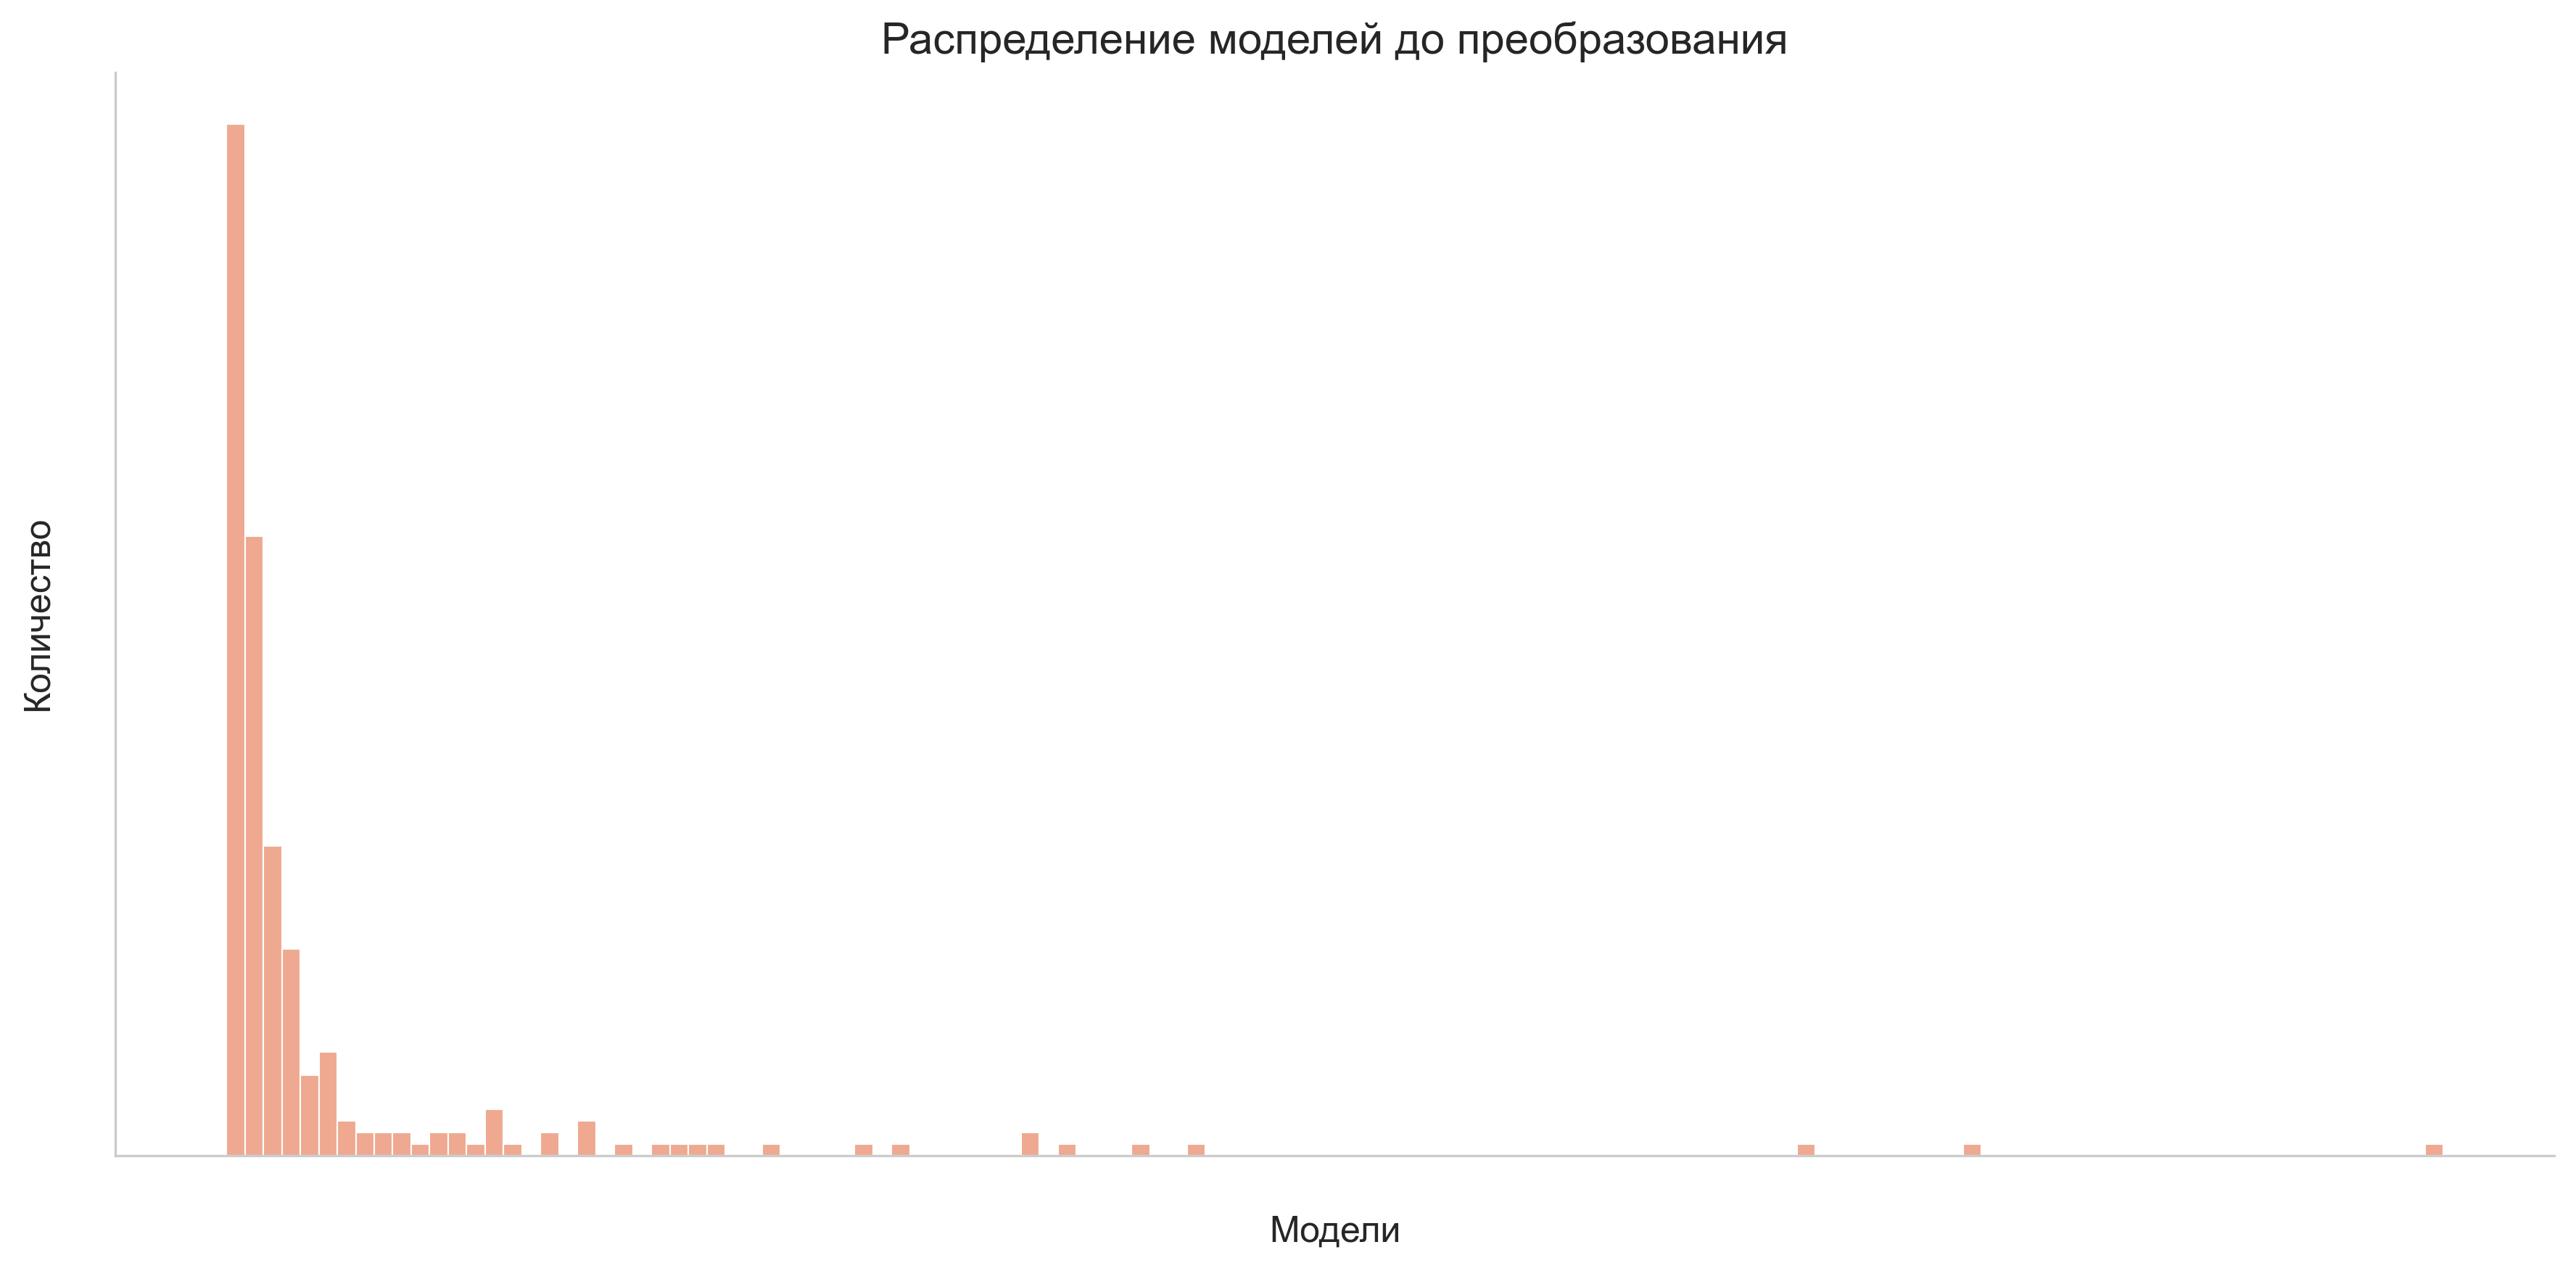

In [43]:
# считаем количество пропусков в признаке
print('-' * 42)
print('Текущее количество пропусков:', data['model'].isna().sum())
print('-' * 42)

# строим гистограмму распределения моделей
sns.histplot(x=data['model'].value_counts())
plt.title('Распределение моделей до преобразования')
plt.xlabel('Модели')
plt.ylabel('Количество')
plt.xticks(ticks=[])
plt.yticks(ticks=[]);

In [44]:
# заполняем с помощью функции пропуски в признаке
data['model'] = groupby_fillna(data, ['brand', 'registration_year'], 'model')

------------------------------------------
Текущее количество пропусков: 14
------------------------------------------


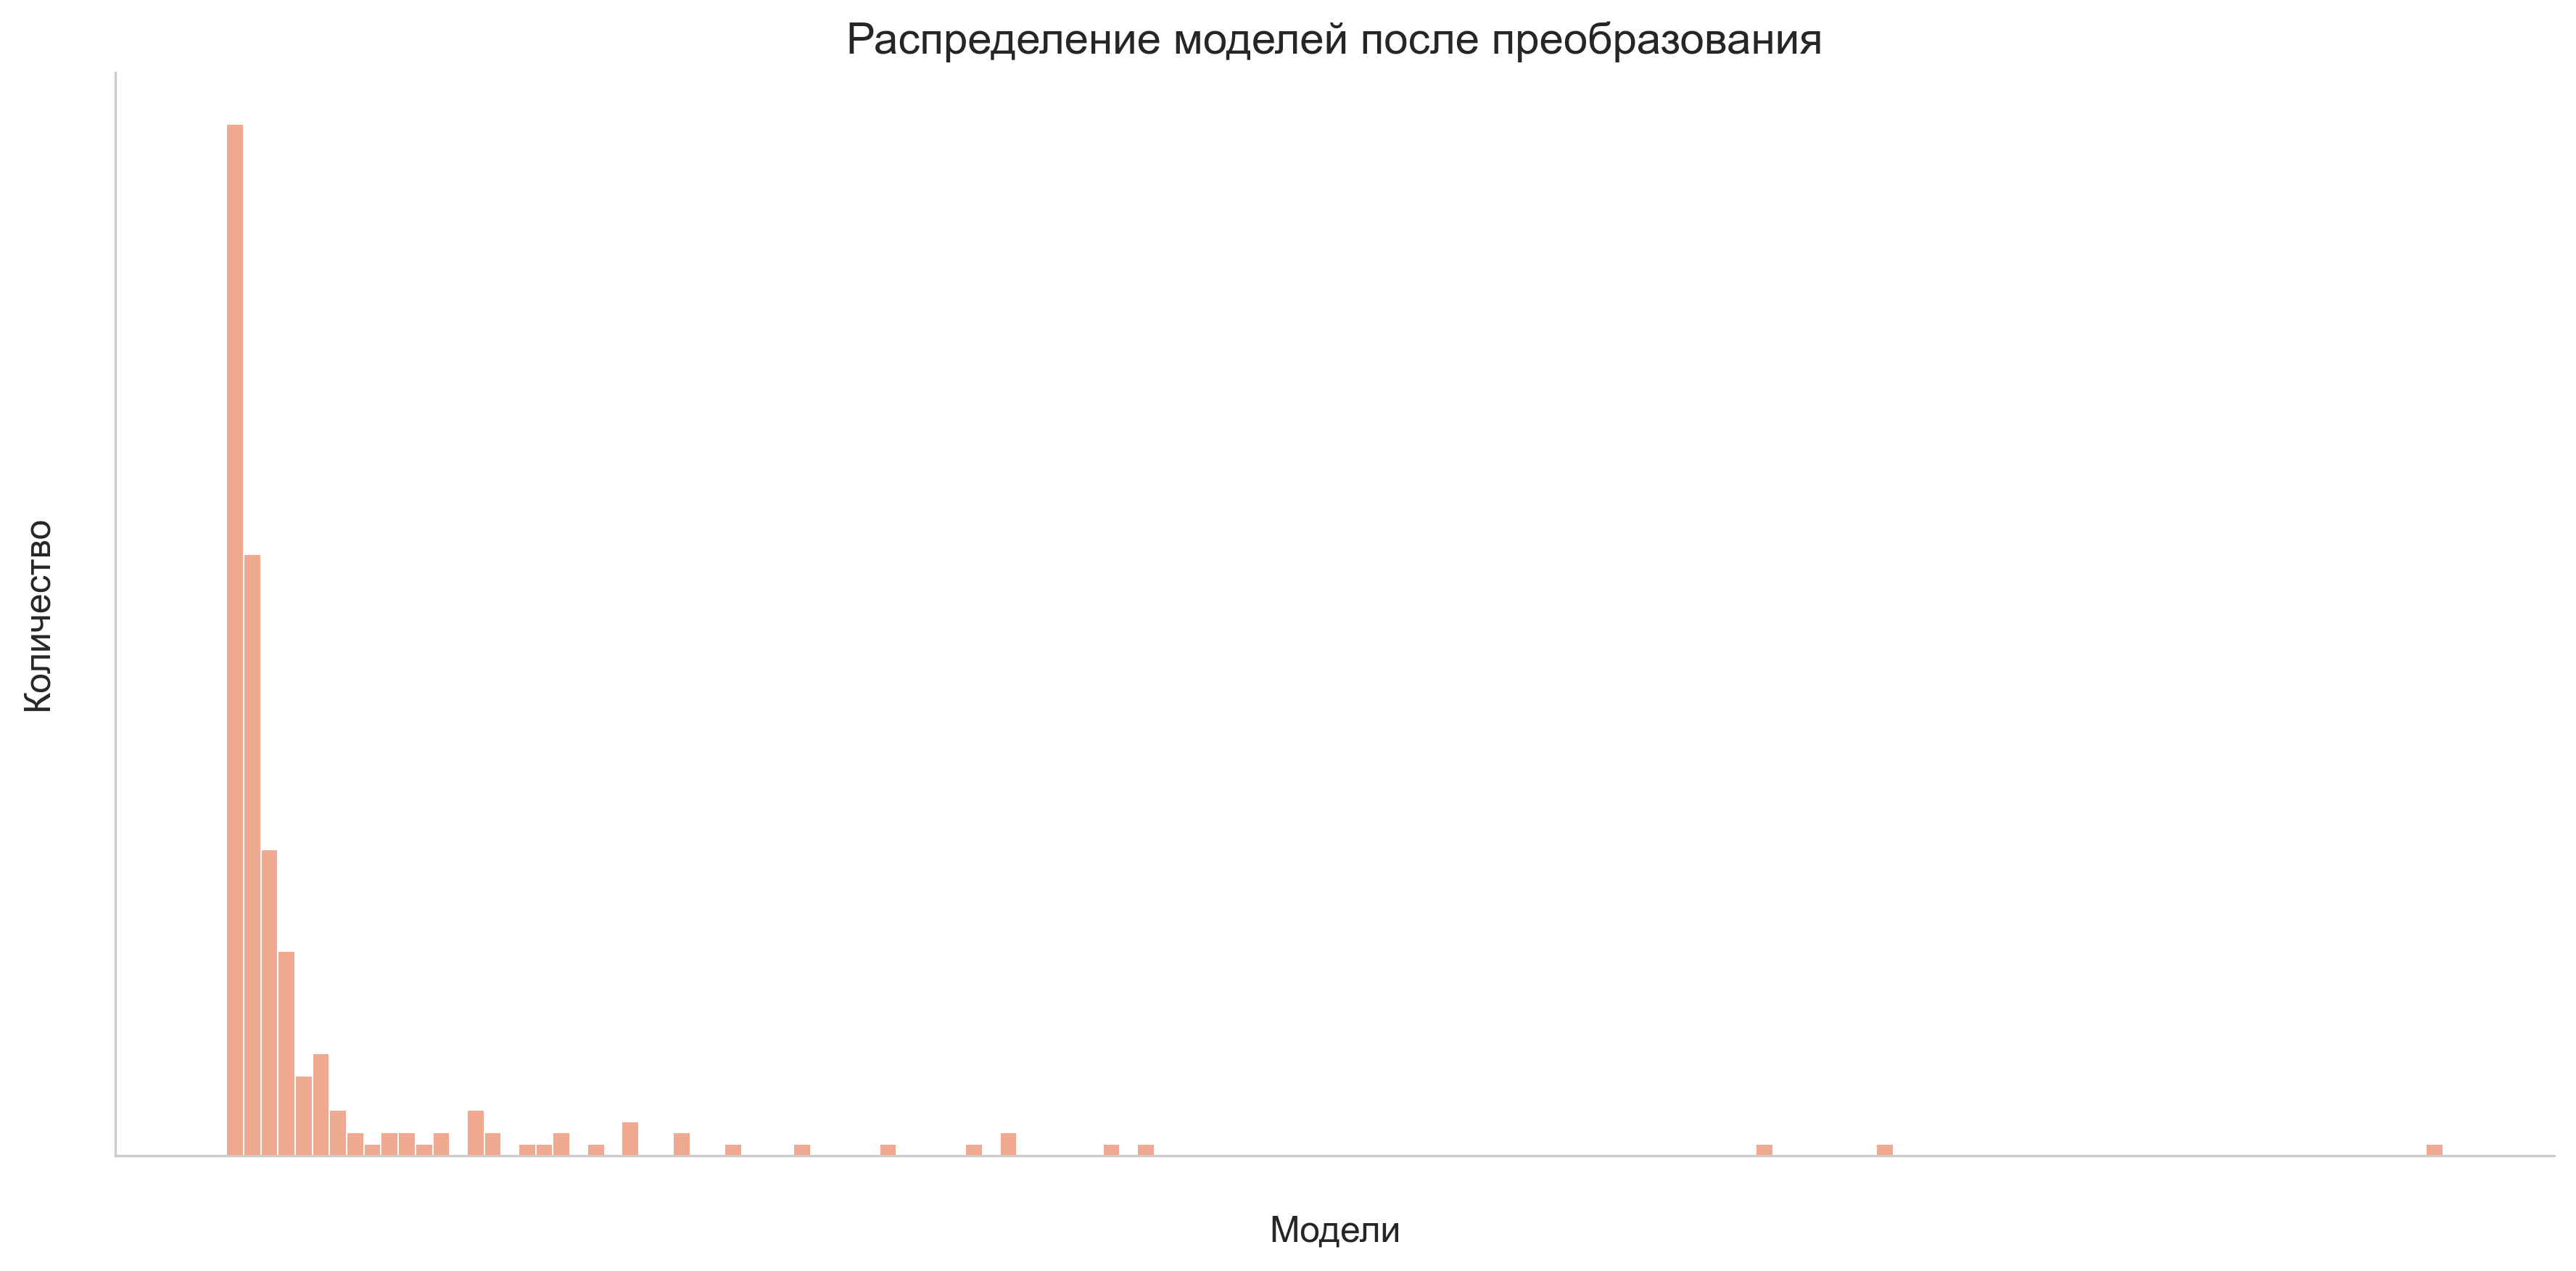

In [45]:
# проверяем распределение после преобразования
sns.histplot(x=data['model'].value_counts())
plt.title('Распределение моделей после преобразования')
plt.xlabel('Модели')
plt.ylabel('Количество')
plt.xticks(ticks=[])
plt.yticks(ticks=[]);

# проверяем наличие пропусков в признаке
print('-' * 42)
print('Текущее количество пропусков:', data['model'].isna().sum())
print('-' * 42)

После нашего заполнения распределение признака `model` кардинально не поменялось. Несколько пропусков функции не удалось заполнить, их мы просто откинем. Типом данных и инжинирингом этих признаков мы займёмся после анализа. 

In [46]:
# удаляем оставшиеся пропуски
data.dropna(subset=['model'], inplace=True)

## Тип кузова

Автомобили могут иметь множество вариантов кузовов. Классификация не всегда однозначна, разные производители могут трактовать названия по-разному. 

* Попробуем разобраться какие типы присутствуют в наших данных; 
* Какие из них больше всего встречаются в модельных рядах у брендов; 
* Изучим зависимость цены продажы авто от его типа кузова.

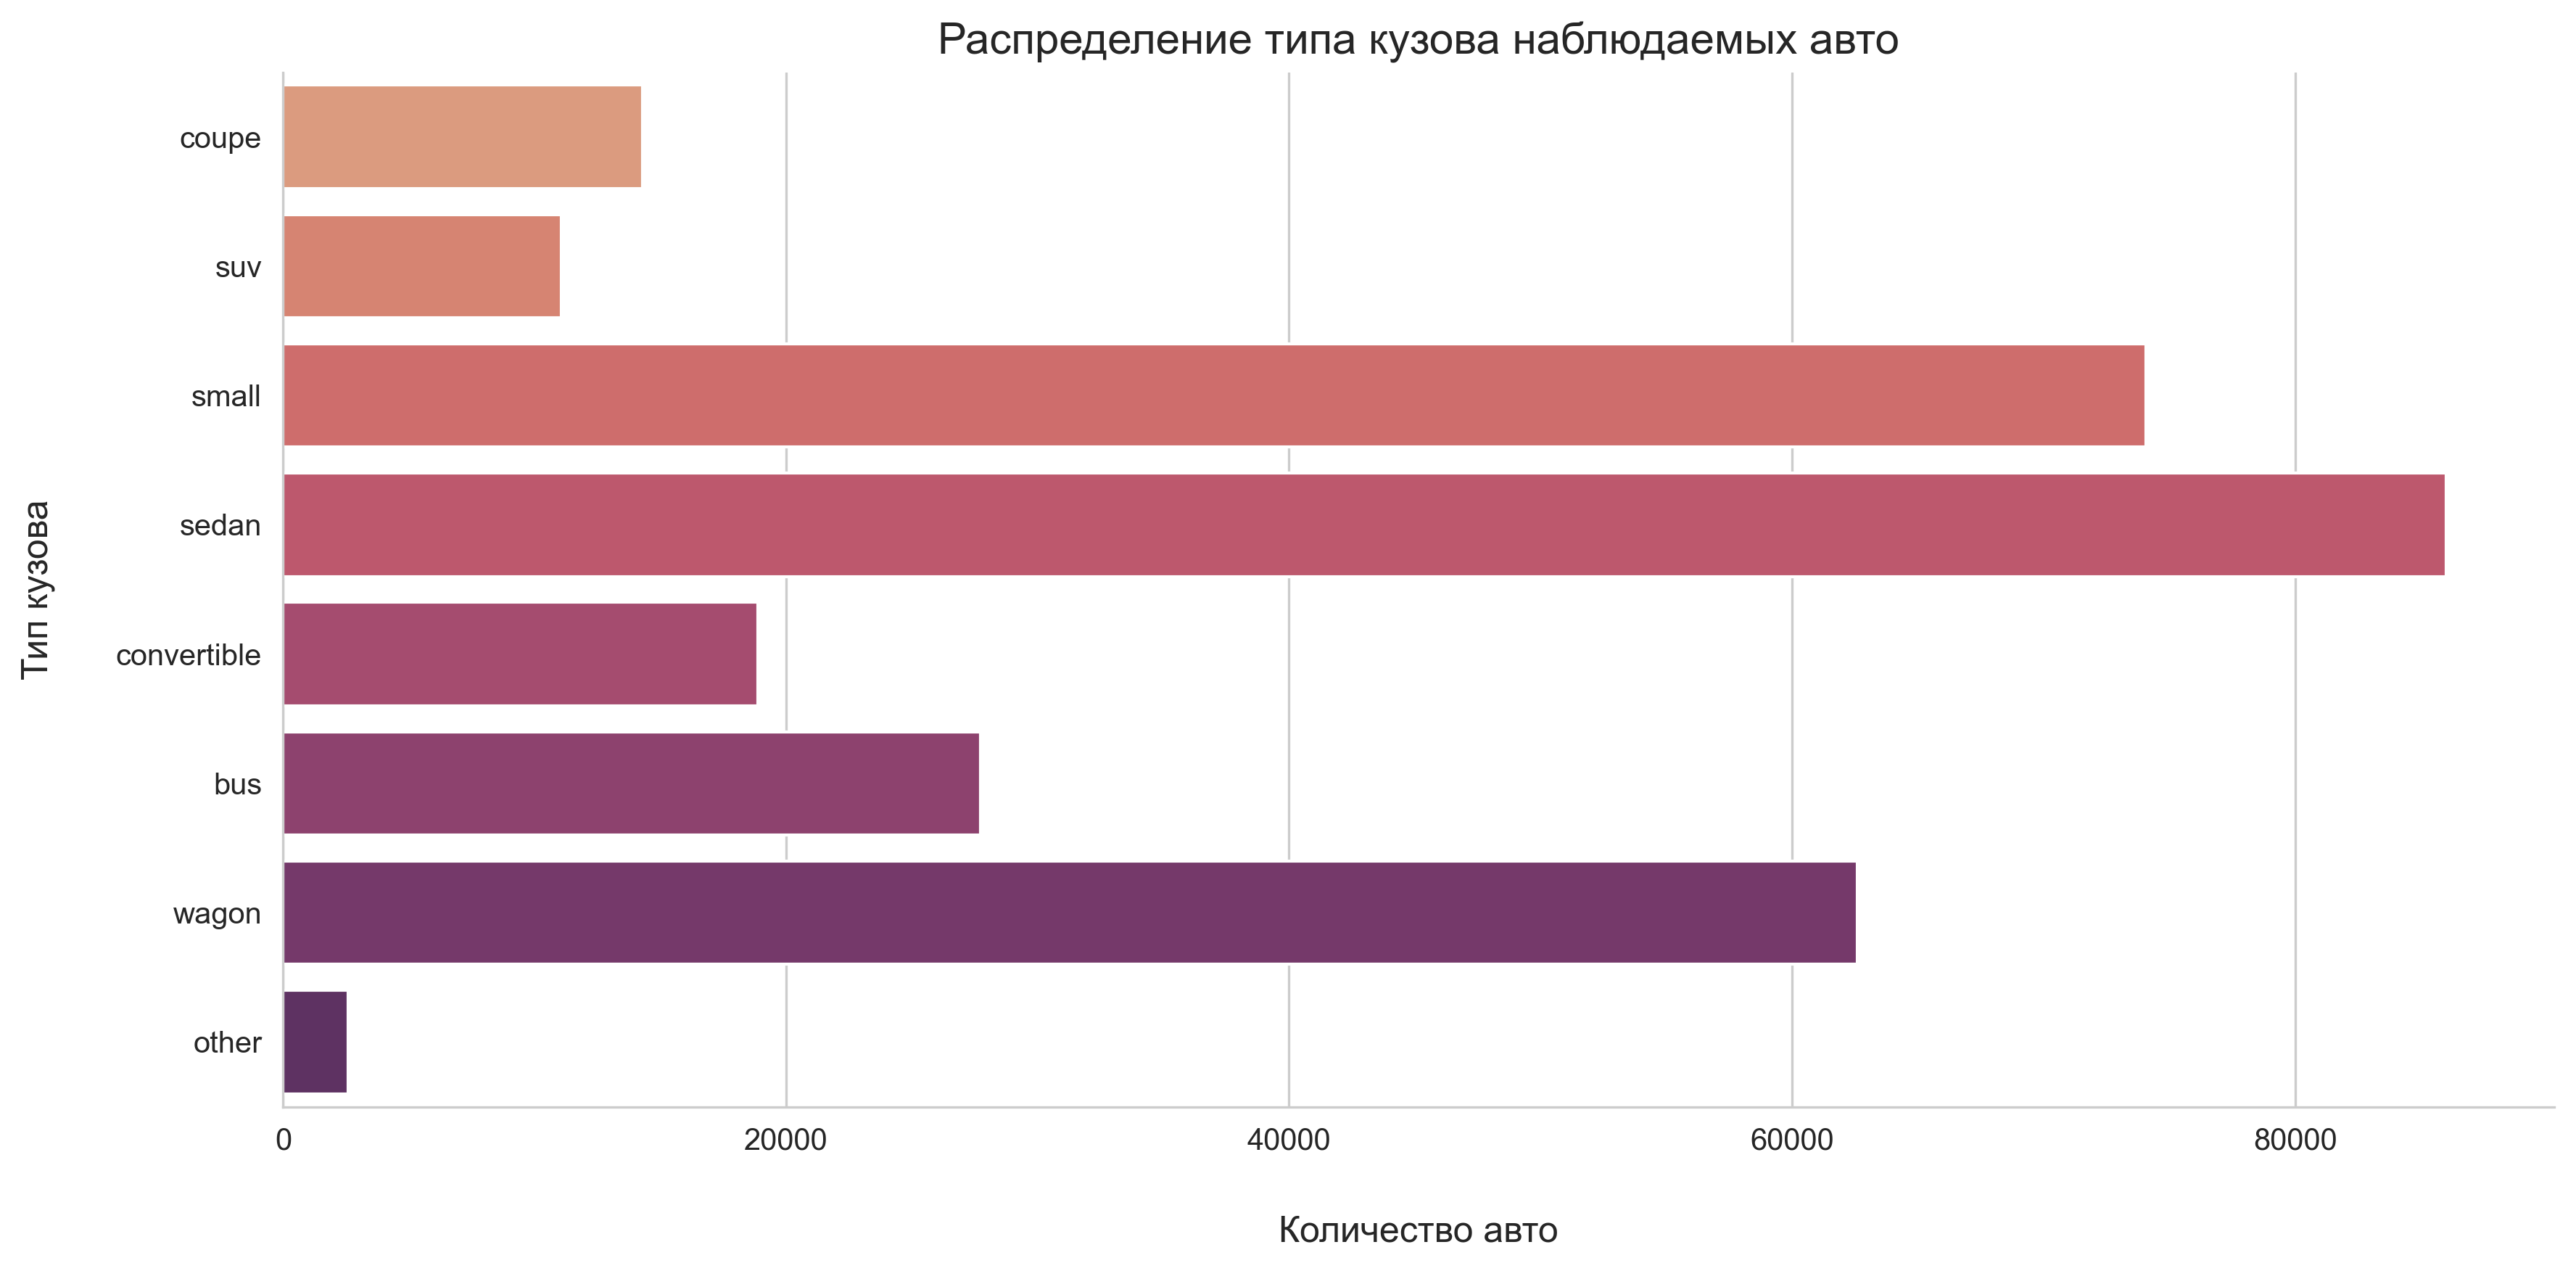

In [47]:
# строим диаграмму и настраиваем график
sns.countplot(y=data['vehicle_type'], palette='flare')
plt.title('Распределение типа кузова наблюдаемых авто')
plt.xlabel('Количество авто')
plt.ylabel('Тип кузова');

Среди авто мы наблюдаем $7$ однозначных *типов кузова* и сборную категорию `other`. Опишем данные типы, пользуясь общедоступной информацией из сети Интернет (например, [этой](https://auto.ru/mag/article/klassifikaciya-vidov-kuzovov-legkovyh-avtomobiley/), [этой](https://avilon.ru/articles/kakie-sushchestvuyut-klassy-avtomobiley/) и вот [этой](https://techautoport.ru/nesuschaya-sistema/kuzov-i-rama/tipy-kuzovov.html)). Расположим описание в порядке убывания частотности *типа кузова* в данных. Категорию `other` мы рассматривать не будем.

* `sedan` — классическое определение седана — это автомобиль, который имеет жёсткую несъёмную крышу, как минимум пару боковых дверей, два ряда сидений и отделённый от салона багажник. В более узком смысле это исключительно трёхобъёмный кузов с визуально отделёнными секциями (моторный отсек, салон, багажник);
* `small` — в этой категории в основном хетчбэки и компактные седаны, габаритная длина которых может достигать $4$ метров. Характеристики те же самые, что и у классического седана, только более компактные. В случае хетчбэка это двухобъёмеый кузов (моторный отсек и совмещённый салон с багажником).  Популярный рыночный сегмент в Европе;
* `wagon` — универсал — тот же хетчбэк, только с удлинённым задним свесом и более вместительным багажником. Главным потребителем универсалов является Европа;
* `bus` — в данную категорию входят автомобили вместимостью более $4-5$ человек. Если мы изучим первую пятерку популярных моделей с таким типом кузова, то это будут минивены, компактвены и микроавтобусы. Кузов одно- или двухобъёмный, высокая крыша, два или более рядов сидений и отдельная дверь грузового отсека. Данную категорию ещё называют универсалом повышенной вместимости. Пик популярности пришёлся на начало двухтысячных, но сегодня спрос сильно упал из-за всемирной экспансии кроссоверов.

In [48]:
# выводим пятёрку самых популярных моделей типа bus
data.loc[data['vehicle_type'] == 'bus', 'model'].value_counts().head()

model
other          4135
transporter    3772
touran         2634
zafira         2363
sharan         1122
Name: count, dtype: int64

* `convertible` — кабриолет, относится к классу автомобилей с открывающейся или откидной крышей. Крыша может быть жесткой или мягкой. Отличительные черты кабриолета – это две удлиненные двери и один или два ряда сидений. В свою очередь, класс кабриолетов подразделяется на несколько подклассов, таких как фаэтон, родстер, ландо, брогам.
* `coupe` — укороченные автомобили с жёстким верхом, двумя дверями и одним полноценным рядом сидений. Этот тип подразумевает трёхобъёмный кузов. Как правило не самые дорогие, но на сегодняшний день термин стал синонимом дорогих, престижных и быстрых авто;
* `suv` — Sports Utility Vehicle, спортивно-утилитарные автомобили, которые произошли от классических внедорожников, но используются преимущественно в городской среде для движения по асфальтированным дорогам. Иначе сказать это кроссоверы.

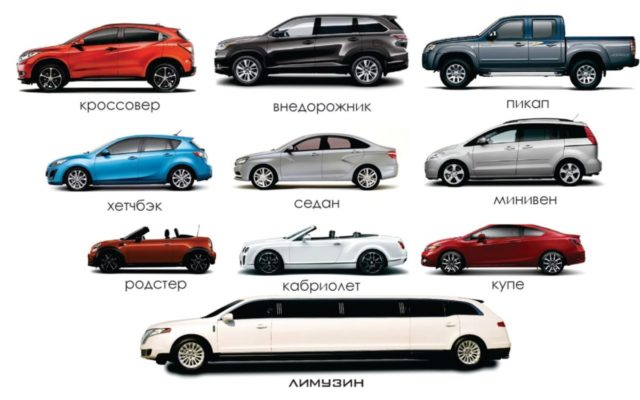

Больше всего наблюдений у *седана* и его компактной модификации *small*. Не удивительно, это самый распространённый тип кузова. Следом идут *универсалы*, как один из самых практичных типов кузова. Остальные типы встречаются реже лидеров: *вэны* и *микроавтобусы* ещё остались с $00$-х, *купе*, *кабриолеты* и *кроссоверы-внедорожники* как более дорогой сегмент. Посмотрим, есть ли определённые предпочтения *типа кузова* популярных брендов.

In [49]:
# получаем 10 популярных брендов
top_brands = data['brand'].value_counts().head(10)
# считаем выпущенные типы кузовов 10 популярных брендов 
top_vehicle_types = data.pivot_table(
    index='brand', 
    columns='vehicle_type', 
    values='model', 
    aggfunc='count'
).loc[top_brands.index]
# проверяем результат
top_vehicle_types

vehicle_type      bus  convertible   coupe  other    sedan    small     suv  \
brand                                                                         
volkswagen     9163.0       2644.0  1578.0  643.0  18869.0  17043.0  1276.0   
opel           3873.0       1531.0  1283.0  232.0   7260.0  11121.0   385.0   
bmw               6.0       3155.0  3551.0  213.0  16949.0    421.0   799.0   
mercedes_benz  2481.0       2076.0  2805.0  255.0  12209.0    947.0  1103.0   
audi             10.0       1611.0  1436.0  100.0  10431.0   1523.0   172.0   
ford           2665.0        556.0   493.0  191.0   3671.0   7047.0   625.0   
renault        2822.0        647.0   317.0  207.0   1586.0   7080.0    89.0   
peugeot         564.0       2184.0   216.0   83.0   1089.0   3978.0    47.0   
fiat            804.0        432.0   152.0  166.0    824.0   4848.0    24.0   
seat            610.0          NaN    82.0   59.0   1708.0   2974.0     4.0   

vehicle_type     wagon  
brand                   
volkswagen     12248.0  
opel            6707.0  
bmw             7701.0  
mercedes_benz   6131.0  
audi           10773.0  
ford            5445.0  
renault         1820.0  
peugeot         1515.0  
fiat             414.0  
seat             382.0

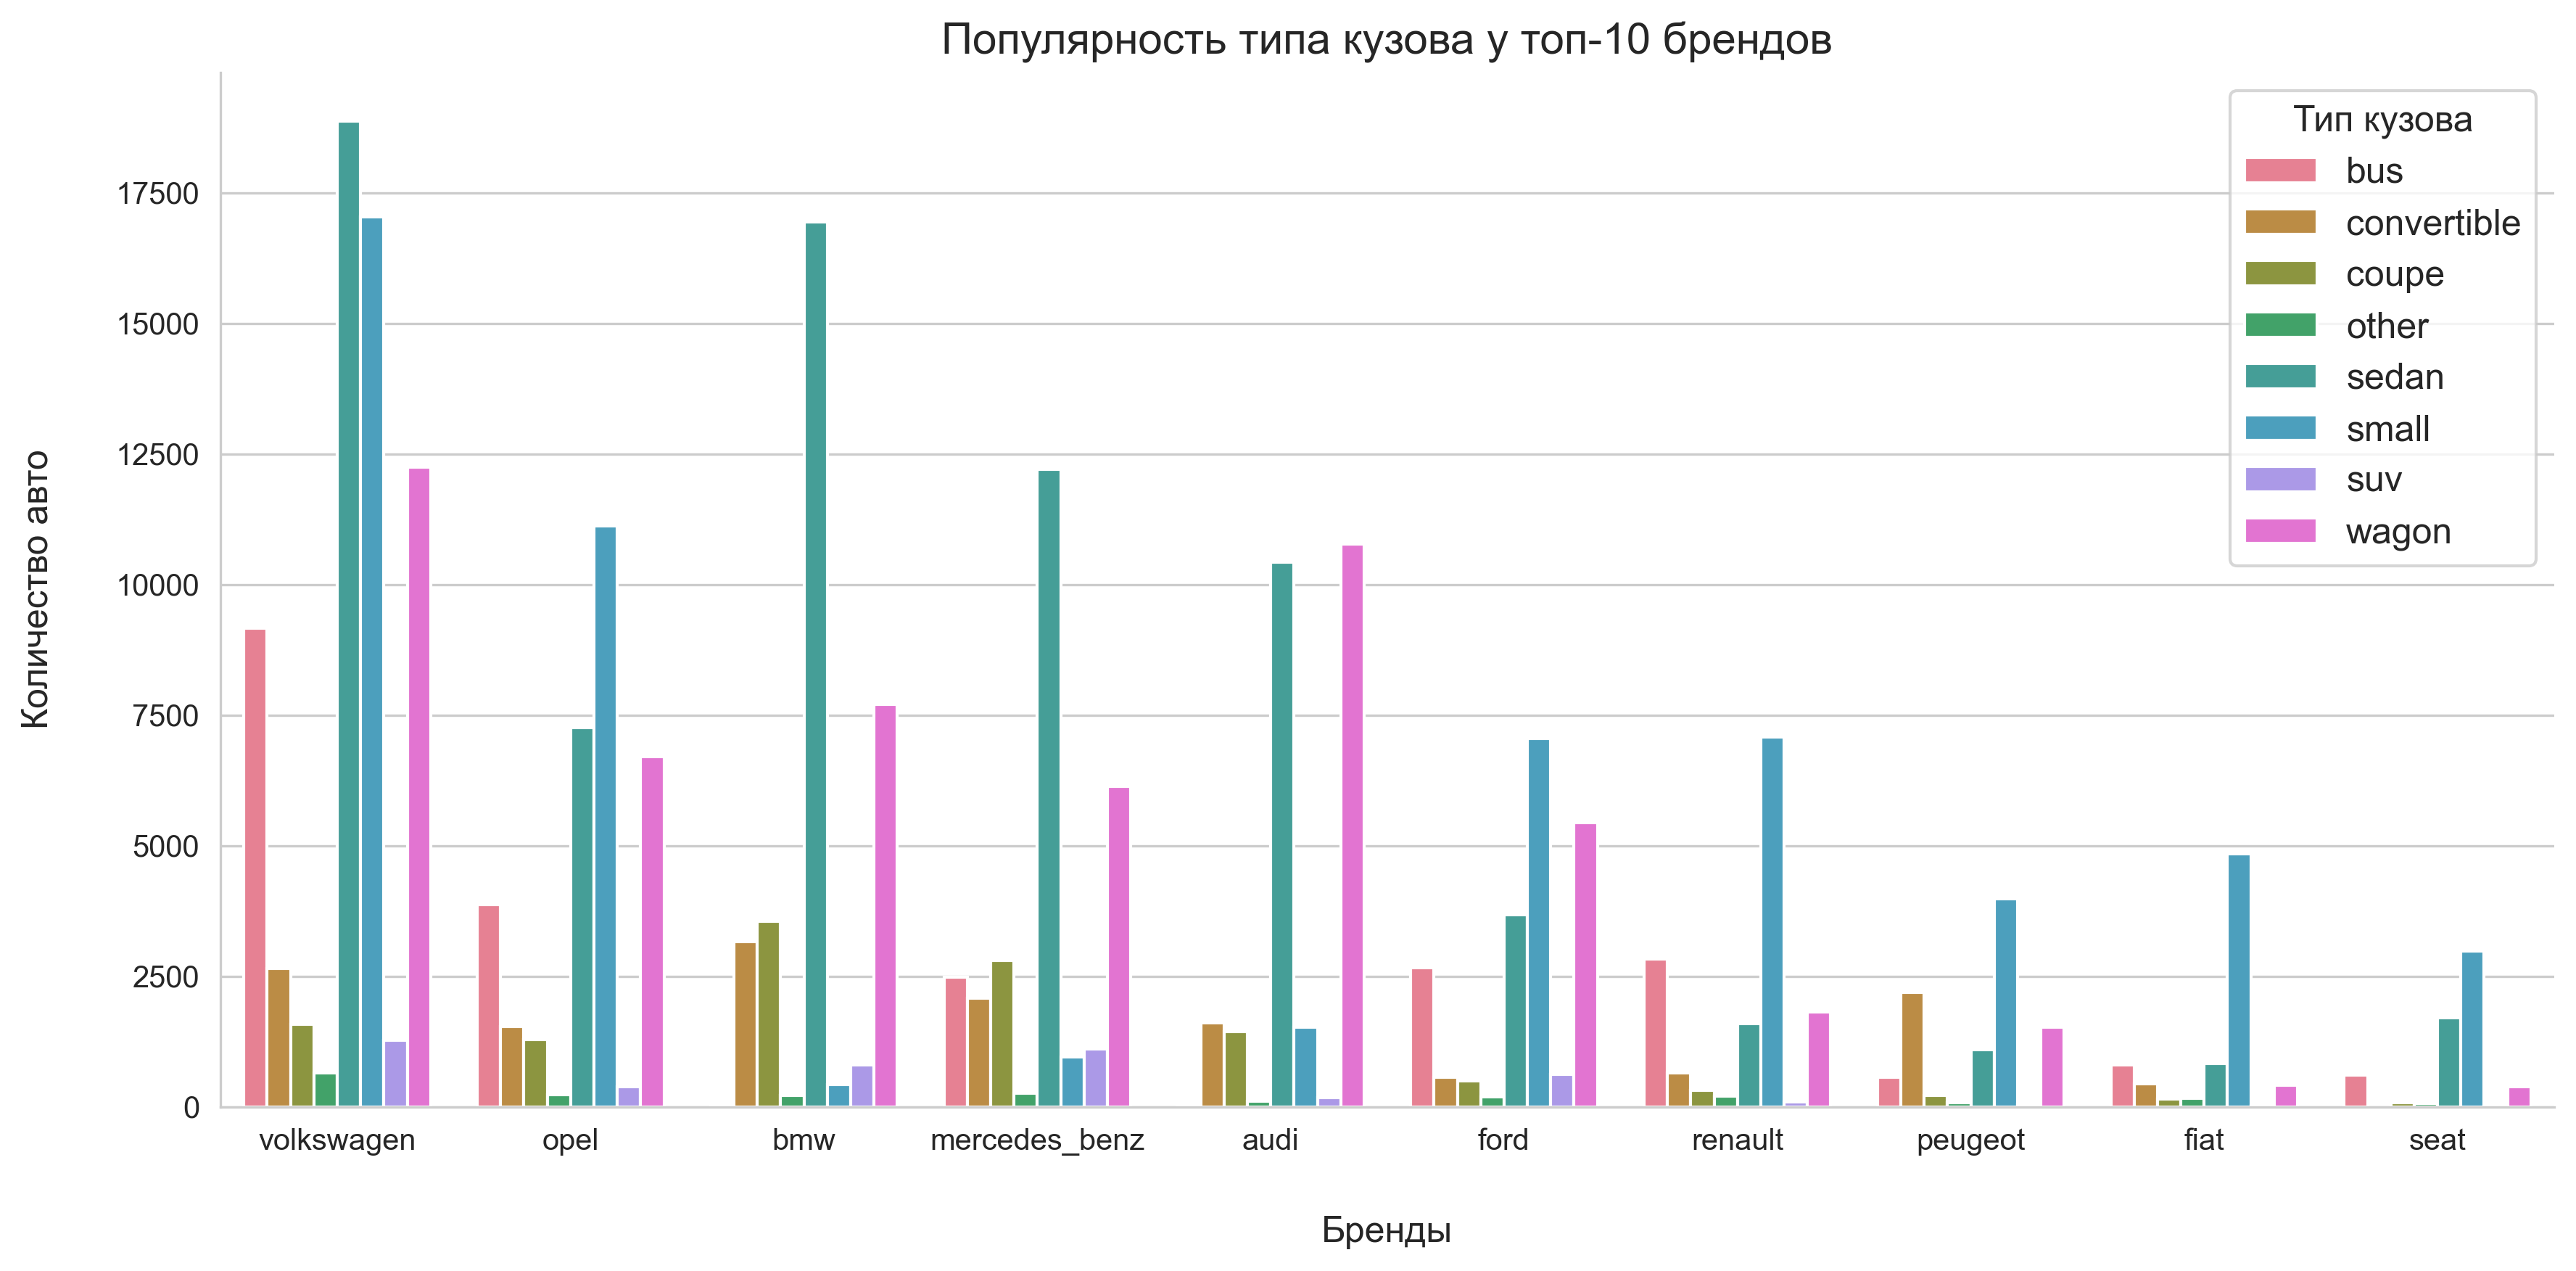

In [50]:
# трансформируем датафрейм
g = top_vehicle_types.melt(ignore_index=False)
# строим столбчатую диаграмму
sns.barplot(data=g.reset_index(), x='brand', y='value', hue='vehicle_type')
plt.title('Популярность типа кузова у топ-10 брендов')
plt.xlabel('Бренды')
plt.ylabel('Количество авто')
plt.legend(title='Тип кузова');

У десяти самых популярных брендов в наших данных самым популярным типом кузова является классический *седан* и компактный *small*. Также популярен *универсал*. У *Volkswagen* и *Opel* можно наблюдать популярность *минивенов* и *микроавтобусов*. Мы не ошибёмся, если решим заполнять пропуски в этом признаке модой. Эти типы кузовов идут с большим отрывом от остальных в популярности среди владельцев. Но сначала проверим как зависит цена авто от его кузова.   

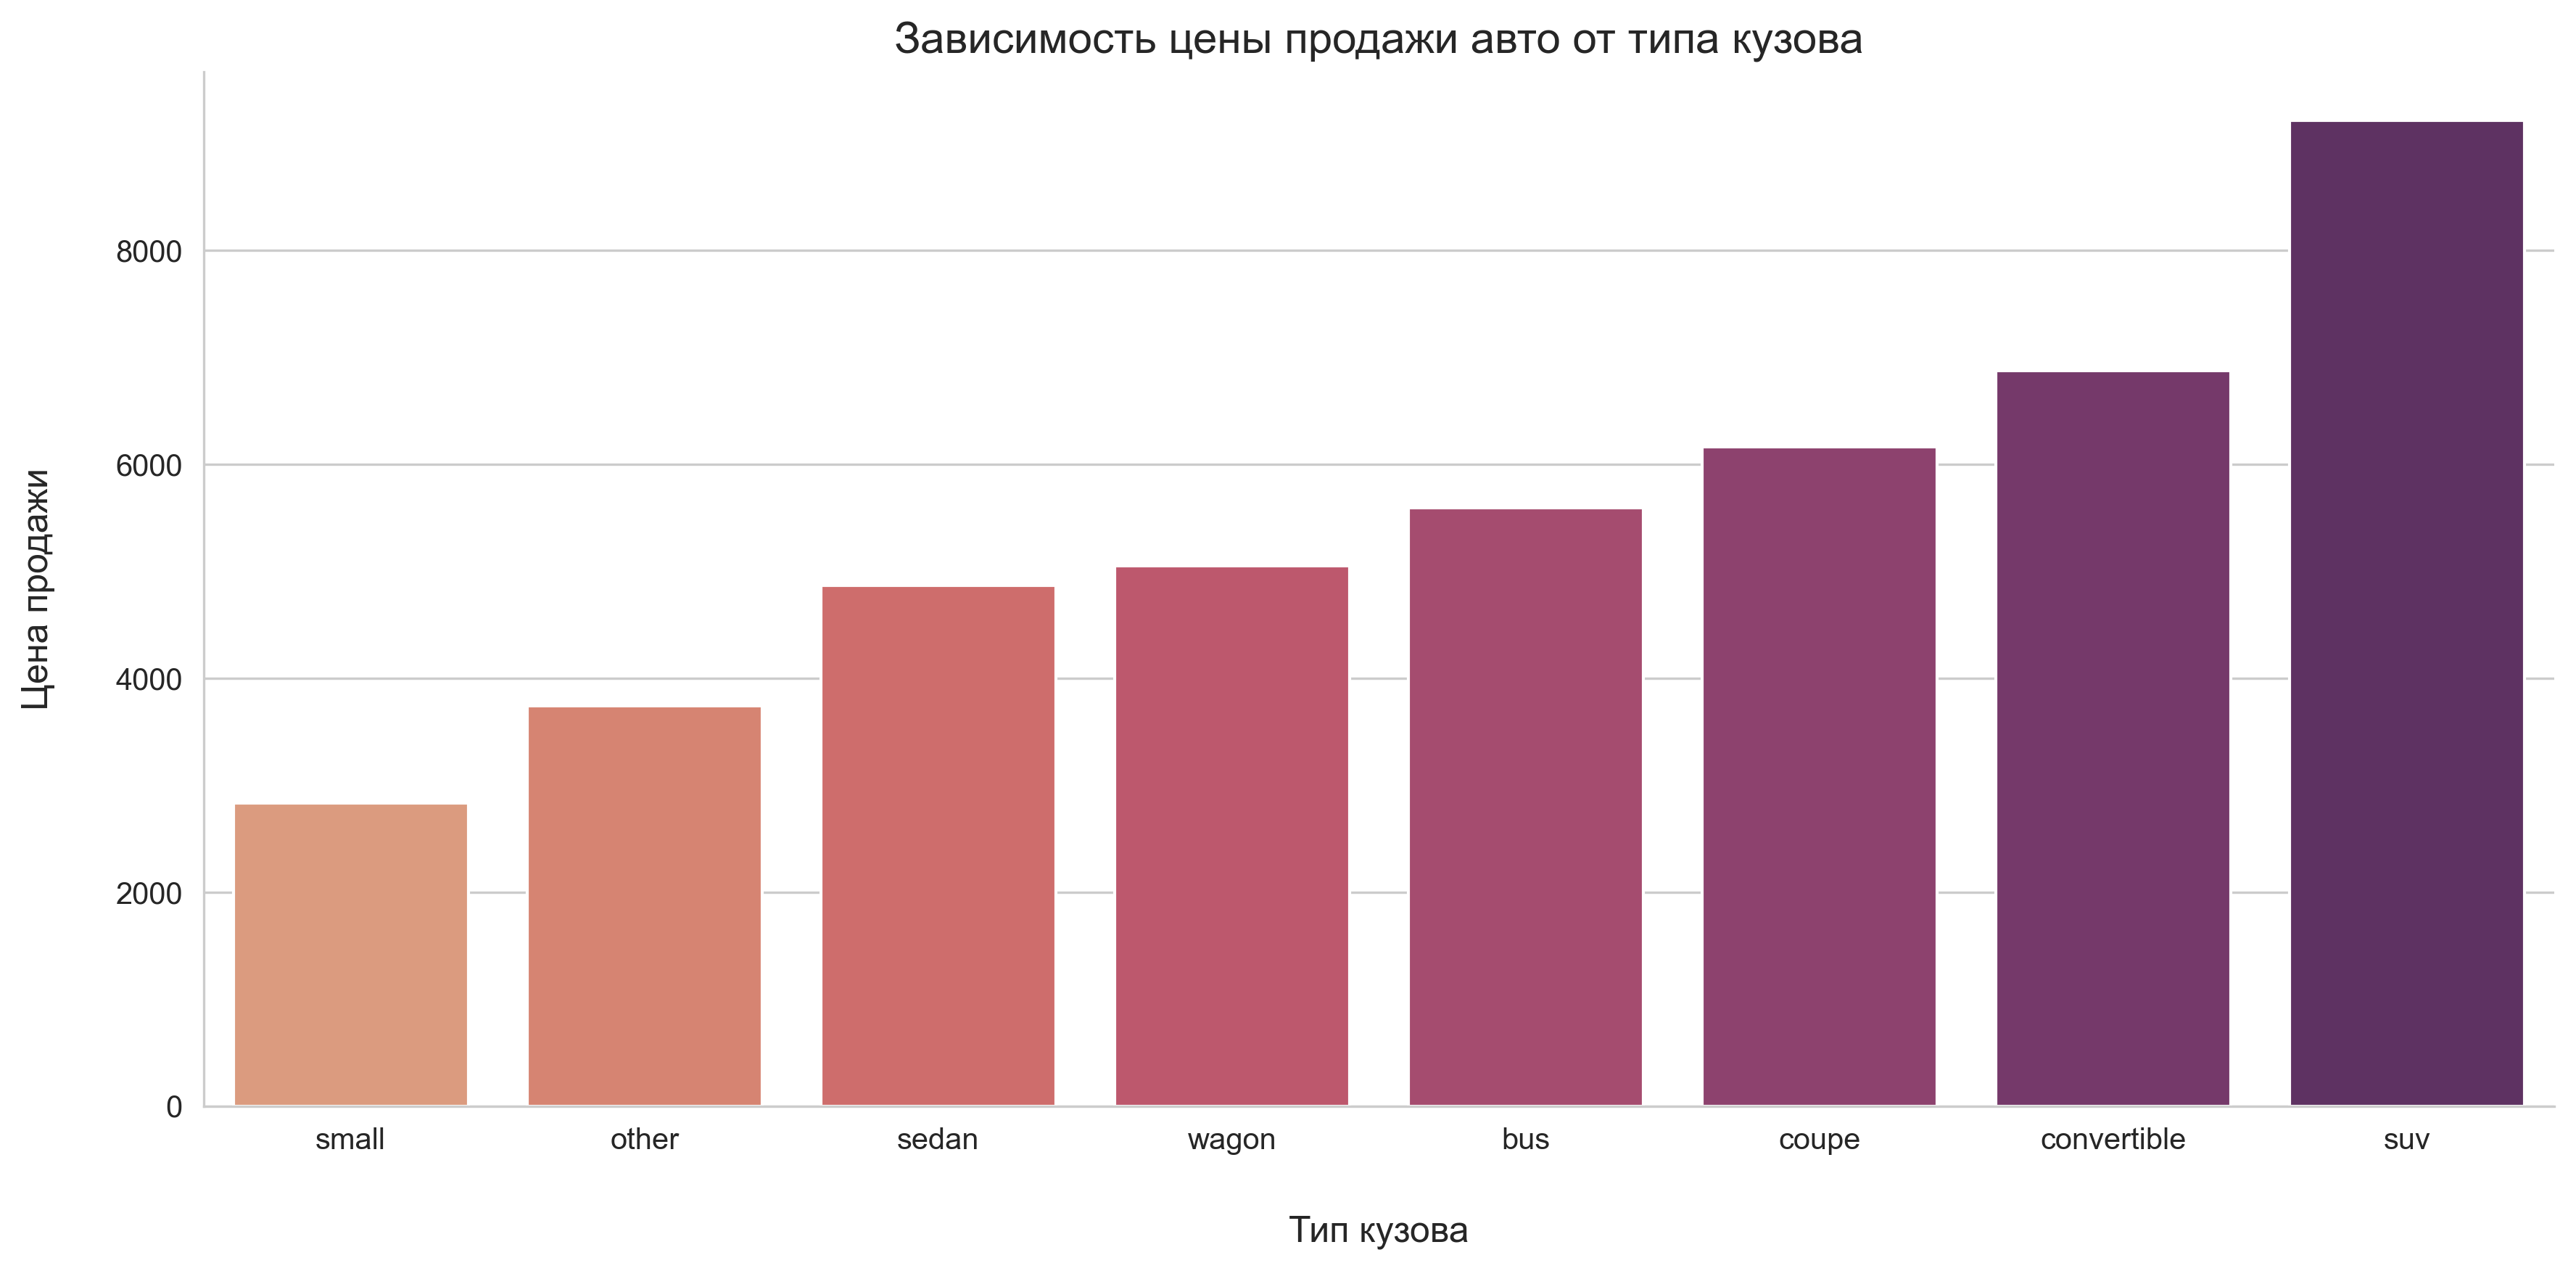

In [51]:
# считаем среднюю цену по типу кузова
g = data.groupby('vehicle_type')['price'].mean().sort_values()
# строим столбчатую диаграмму зависимости
sns.barplot(x=g.index, y=g, palette='flare')
plt.title('Зависимость цены продажи авто от типа кузова')
plt.xlabel('Тип кузова')
plt.ylabel('Цена продажи');

Наблюдается рост цены в зависимости от типа кузова. Популярный рыночный сегмент *small* является самым доступным вариантом для потребителя. *Седаны* и *универсалы* будут уже посерьёзнее, а всякие *вэны* и *микро* ожидаемо стоят дороже из-за своего класса. Как и утверждалось в описании, найденого в сети Интернет, *купе* и *кабриолеты* уже давно перестали быть бюджетным вариантом и ассоциируются с премиум классом. Самым же дорогим авто можно считать кроссоверы и внедорожники. Мощный движок, огромный кузов, современный салон, что уж говорить, это стоит денег.

***Примечание.*** Мы считали среднюю цену каждого типа кузова, так как в признаке `price` отсутствуют аномальные значения. Все наблюдения, превышающие полуторный межквартильный размах, распределены равномерно влоть до максимального значения. Поэтому интерпретация данных не будет искажена.

* Признак `vehicle_type` является категориальным с небольшой кардинальностью. Добавим его в список категориальных признаков;
* Заполним присутствующие пропуски той же стратегией, что заполняли в `model`, применив нашу функцию `groupby_fillna`. Группировку сделаем по *бренду* и *модели*.

------------------------------------------
Текущее количество пропусков: 16384
------------------------------------------


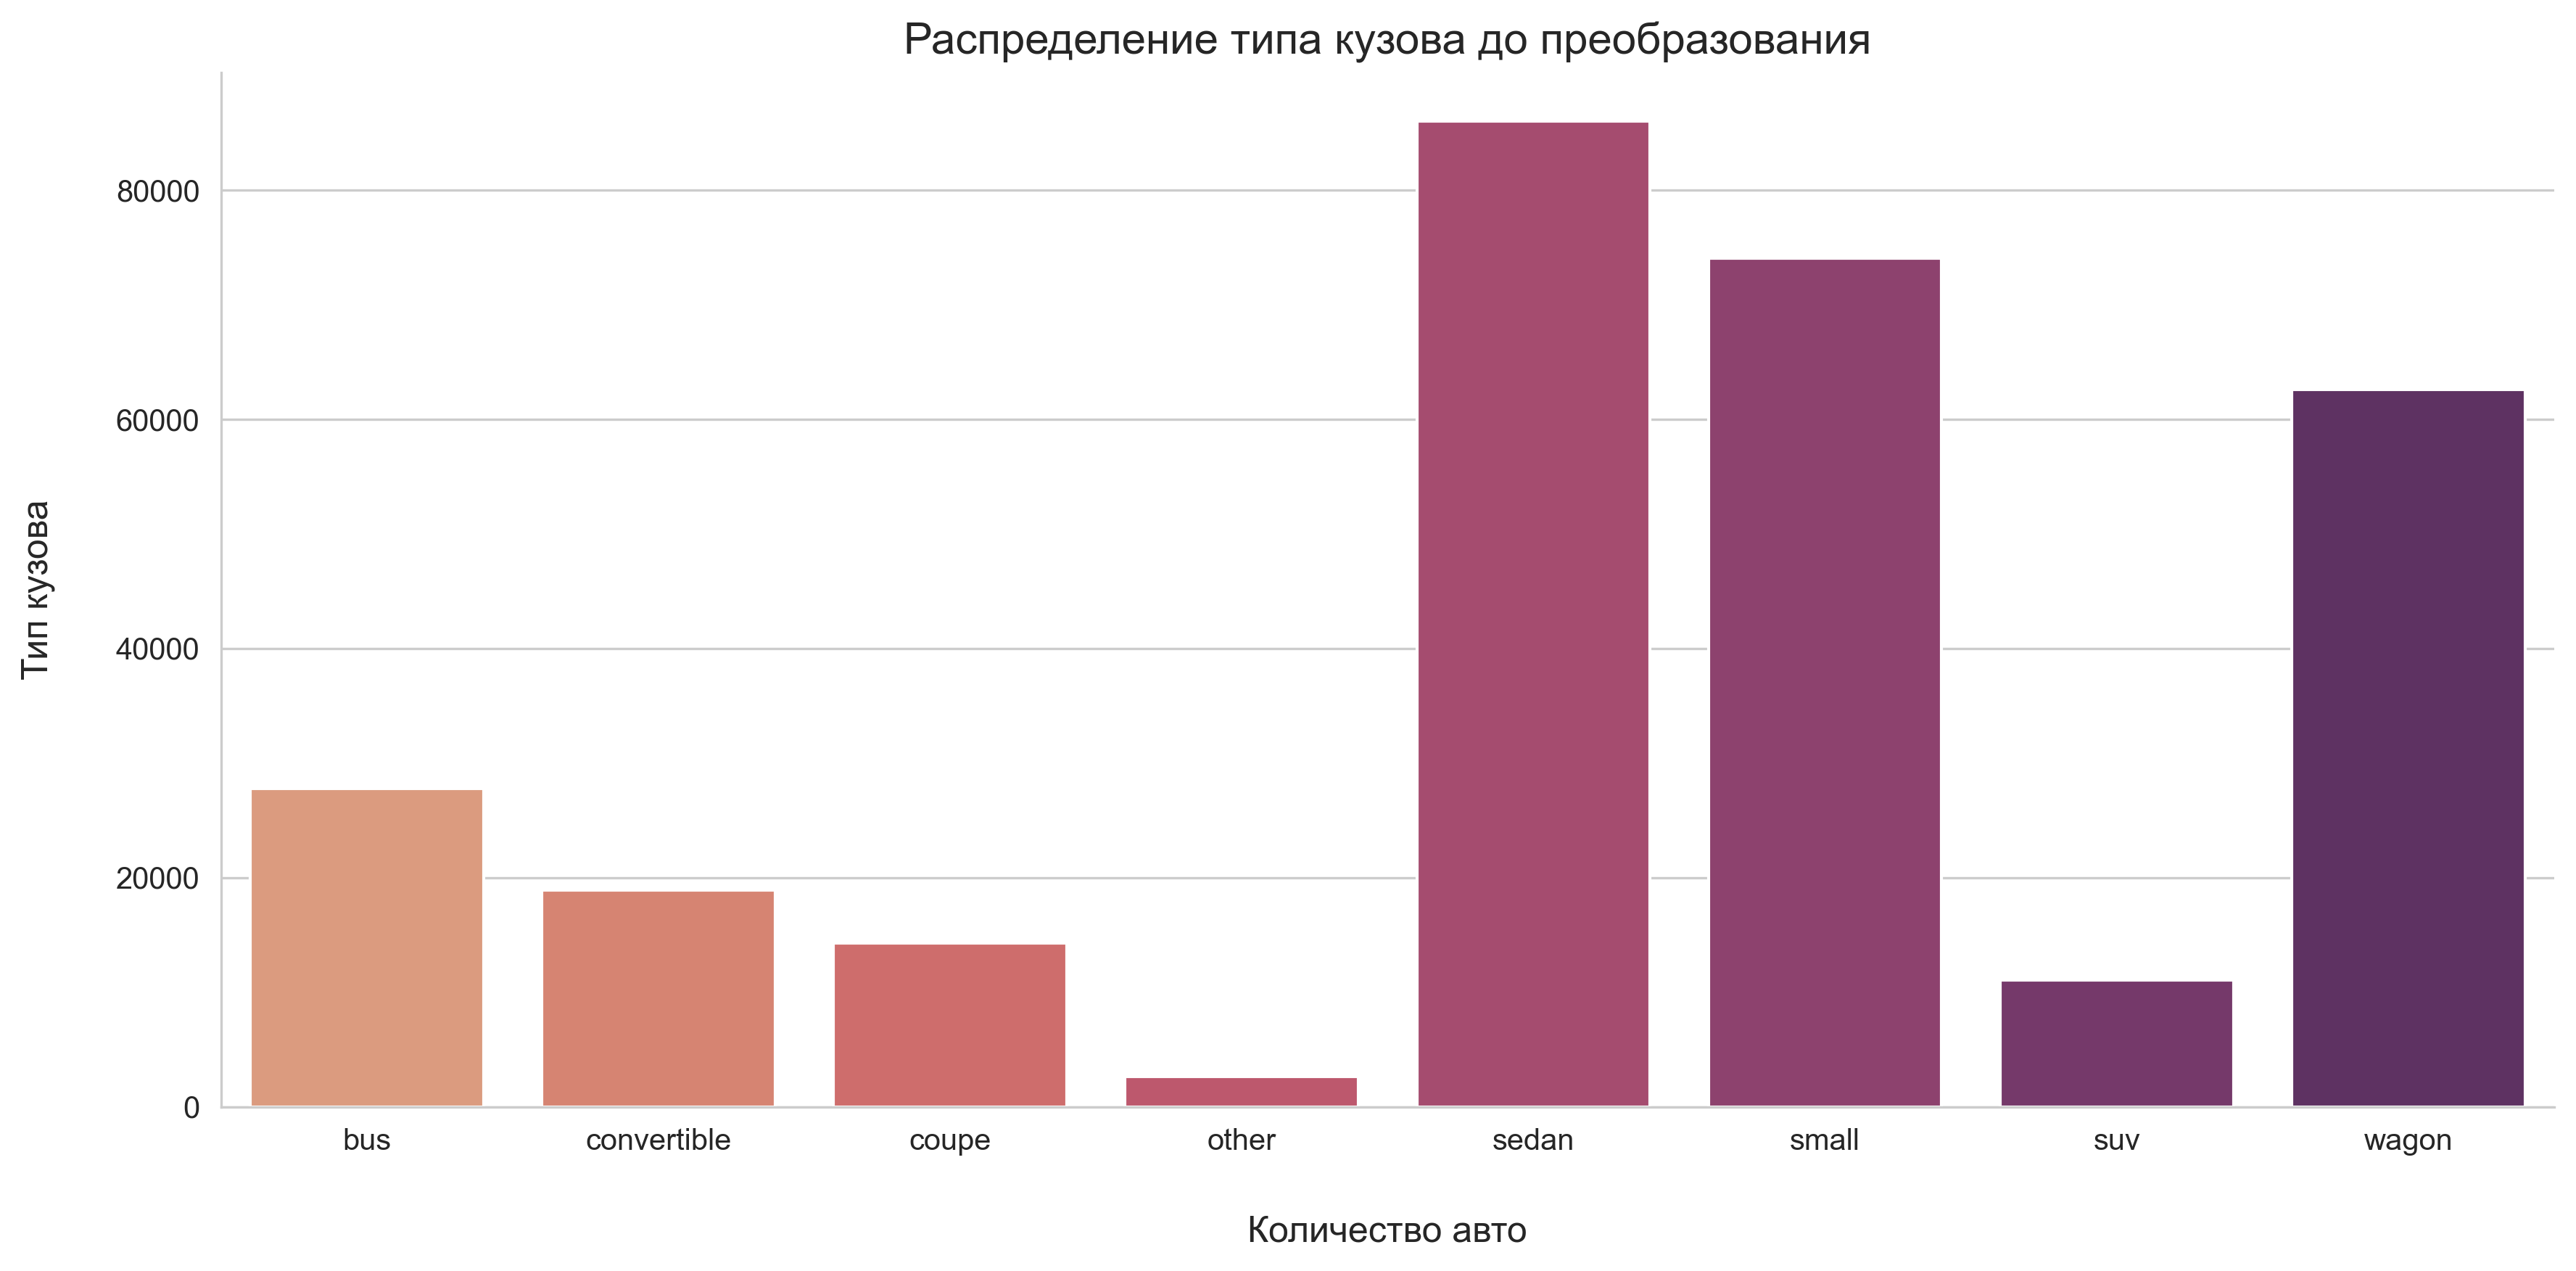

In [52]:
# считаем текущее наличие пропусков в признаке
print('-' * 42)
print('Текущее количество пропусков:', data['vehicle_type'].isna().sum())
print('-' * 42)

# строим распределение признака
sns.countplot(x=data['vehicle_type'].sort_values(), palette='flare')
plt.title('Распределение типа кузова до преобразования')
plt.xlabel('Количество авто')
plt.ylabel('Тип кузова');

In [53]:
# заполняем с помощью функции пропуски в признаке
data['vehicle_type'] = groupby_fillna(data, ['brand', 'model'], 'vehicle_type')

------------------------------------------
Текущее количество пропусков: 0
------------------------------------------


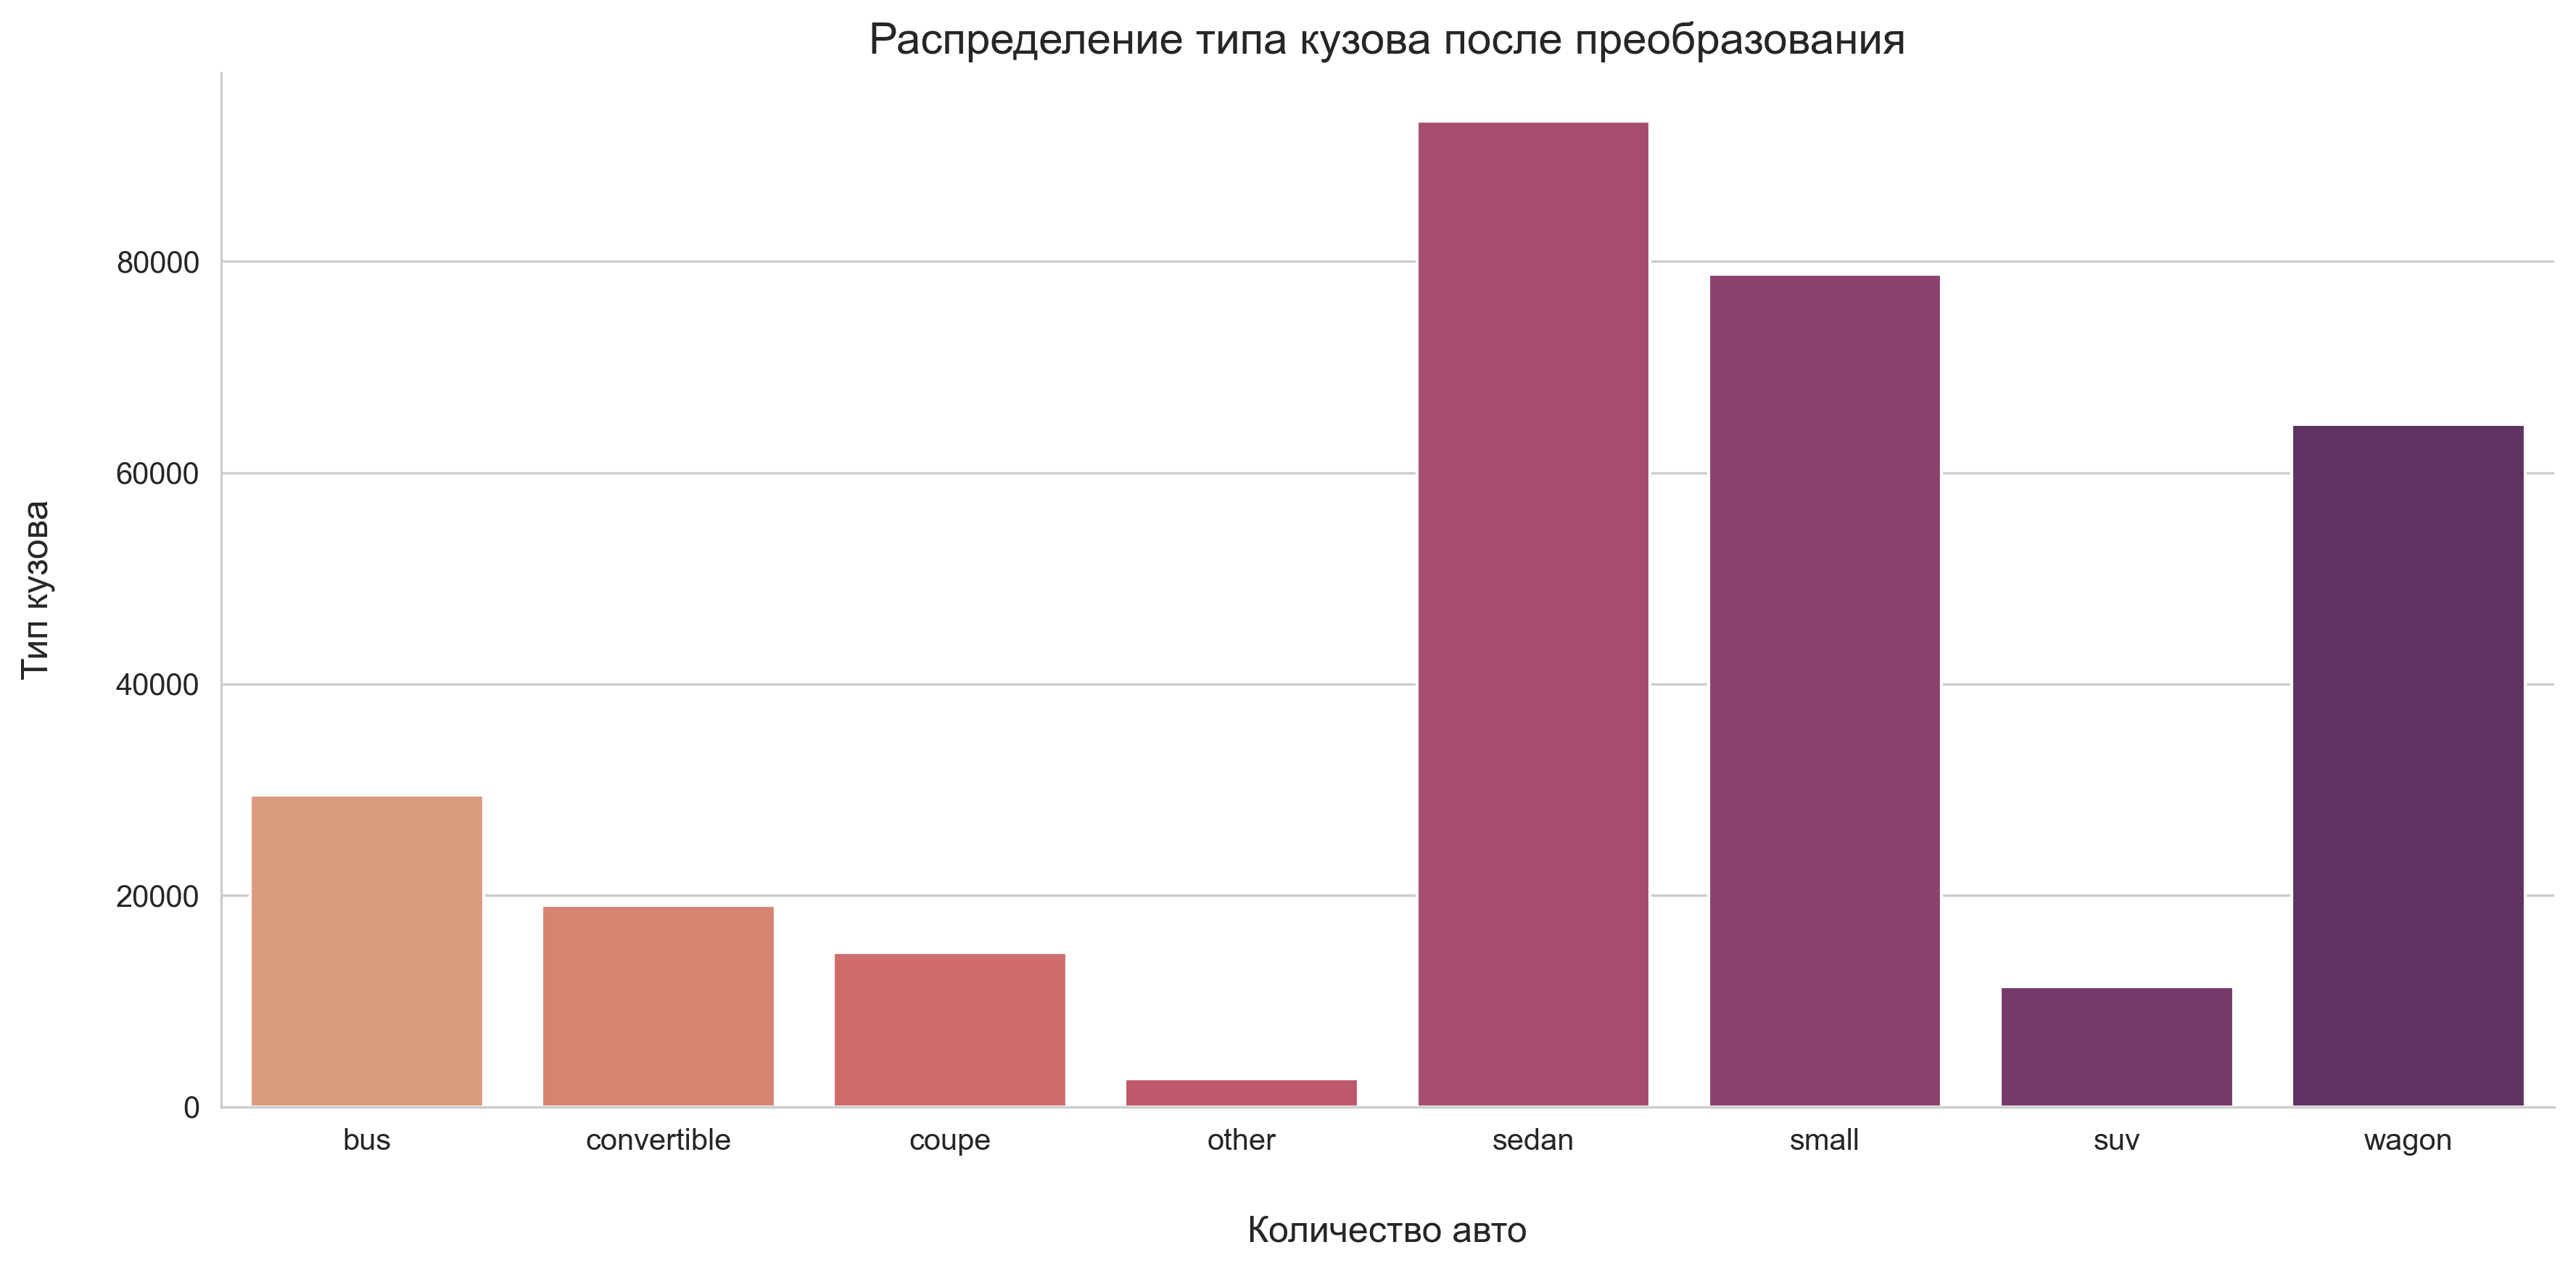

In [54]:
# проверяем распределение признака после преобразования
sns.countplot(x=data['vehicle_type'].sort_values(), palette='flare')
plt.title('Распределение типа кузова после преобразования')
plt.xlabel('Количество авто')
plt.ylabel('Тип кузова');

# проверяем наличие пропусков в признаке
print('-' * 42)
print('Текущее количество пропусков:', data['vehicle_type'].isna().sum())
print('-' * 42)

После заполнения пропусков в данном признаке его распределние кардинально не поменялось. Добавим признак в наш список категориальных признаков. 

In [55]:
# добавляем признак в список
cat_features.extend(['vehicle_type'])

## Тип топлива

Глобально автомобильное топливо можно разделить на четыре вида:

* бензин,
* дизельное топливо,
* природный или синтетический газ, и
* водород.

Водородные автомобили максимально экологичны, но на сегодняшний день фактически находятся в стадии опытных разработок из-за сложности конструкции, взрывоопасности водородно-воздушной смеси и больших затрат на получение водорода. Газовое топливо, наоборот, самое дешёвое из всех, будь то пропан-бутановая смесь или менее распространённый метан. Использовать его в ДВС тоже несложно, поэтому машины, работающие на газе, давно не экзотика. Но всё-таки большинство машин работают на традиционных видах топлива. И они тоже бывают разными: дизельное топливо, бензин. Какие же типы предствленны в наших данных? Взглянем на распределение признака.

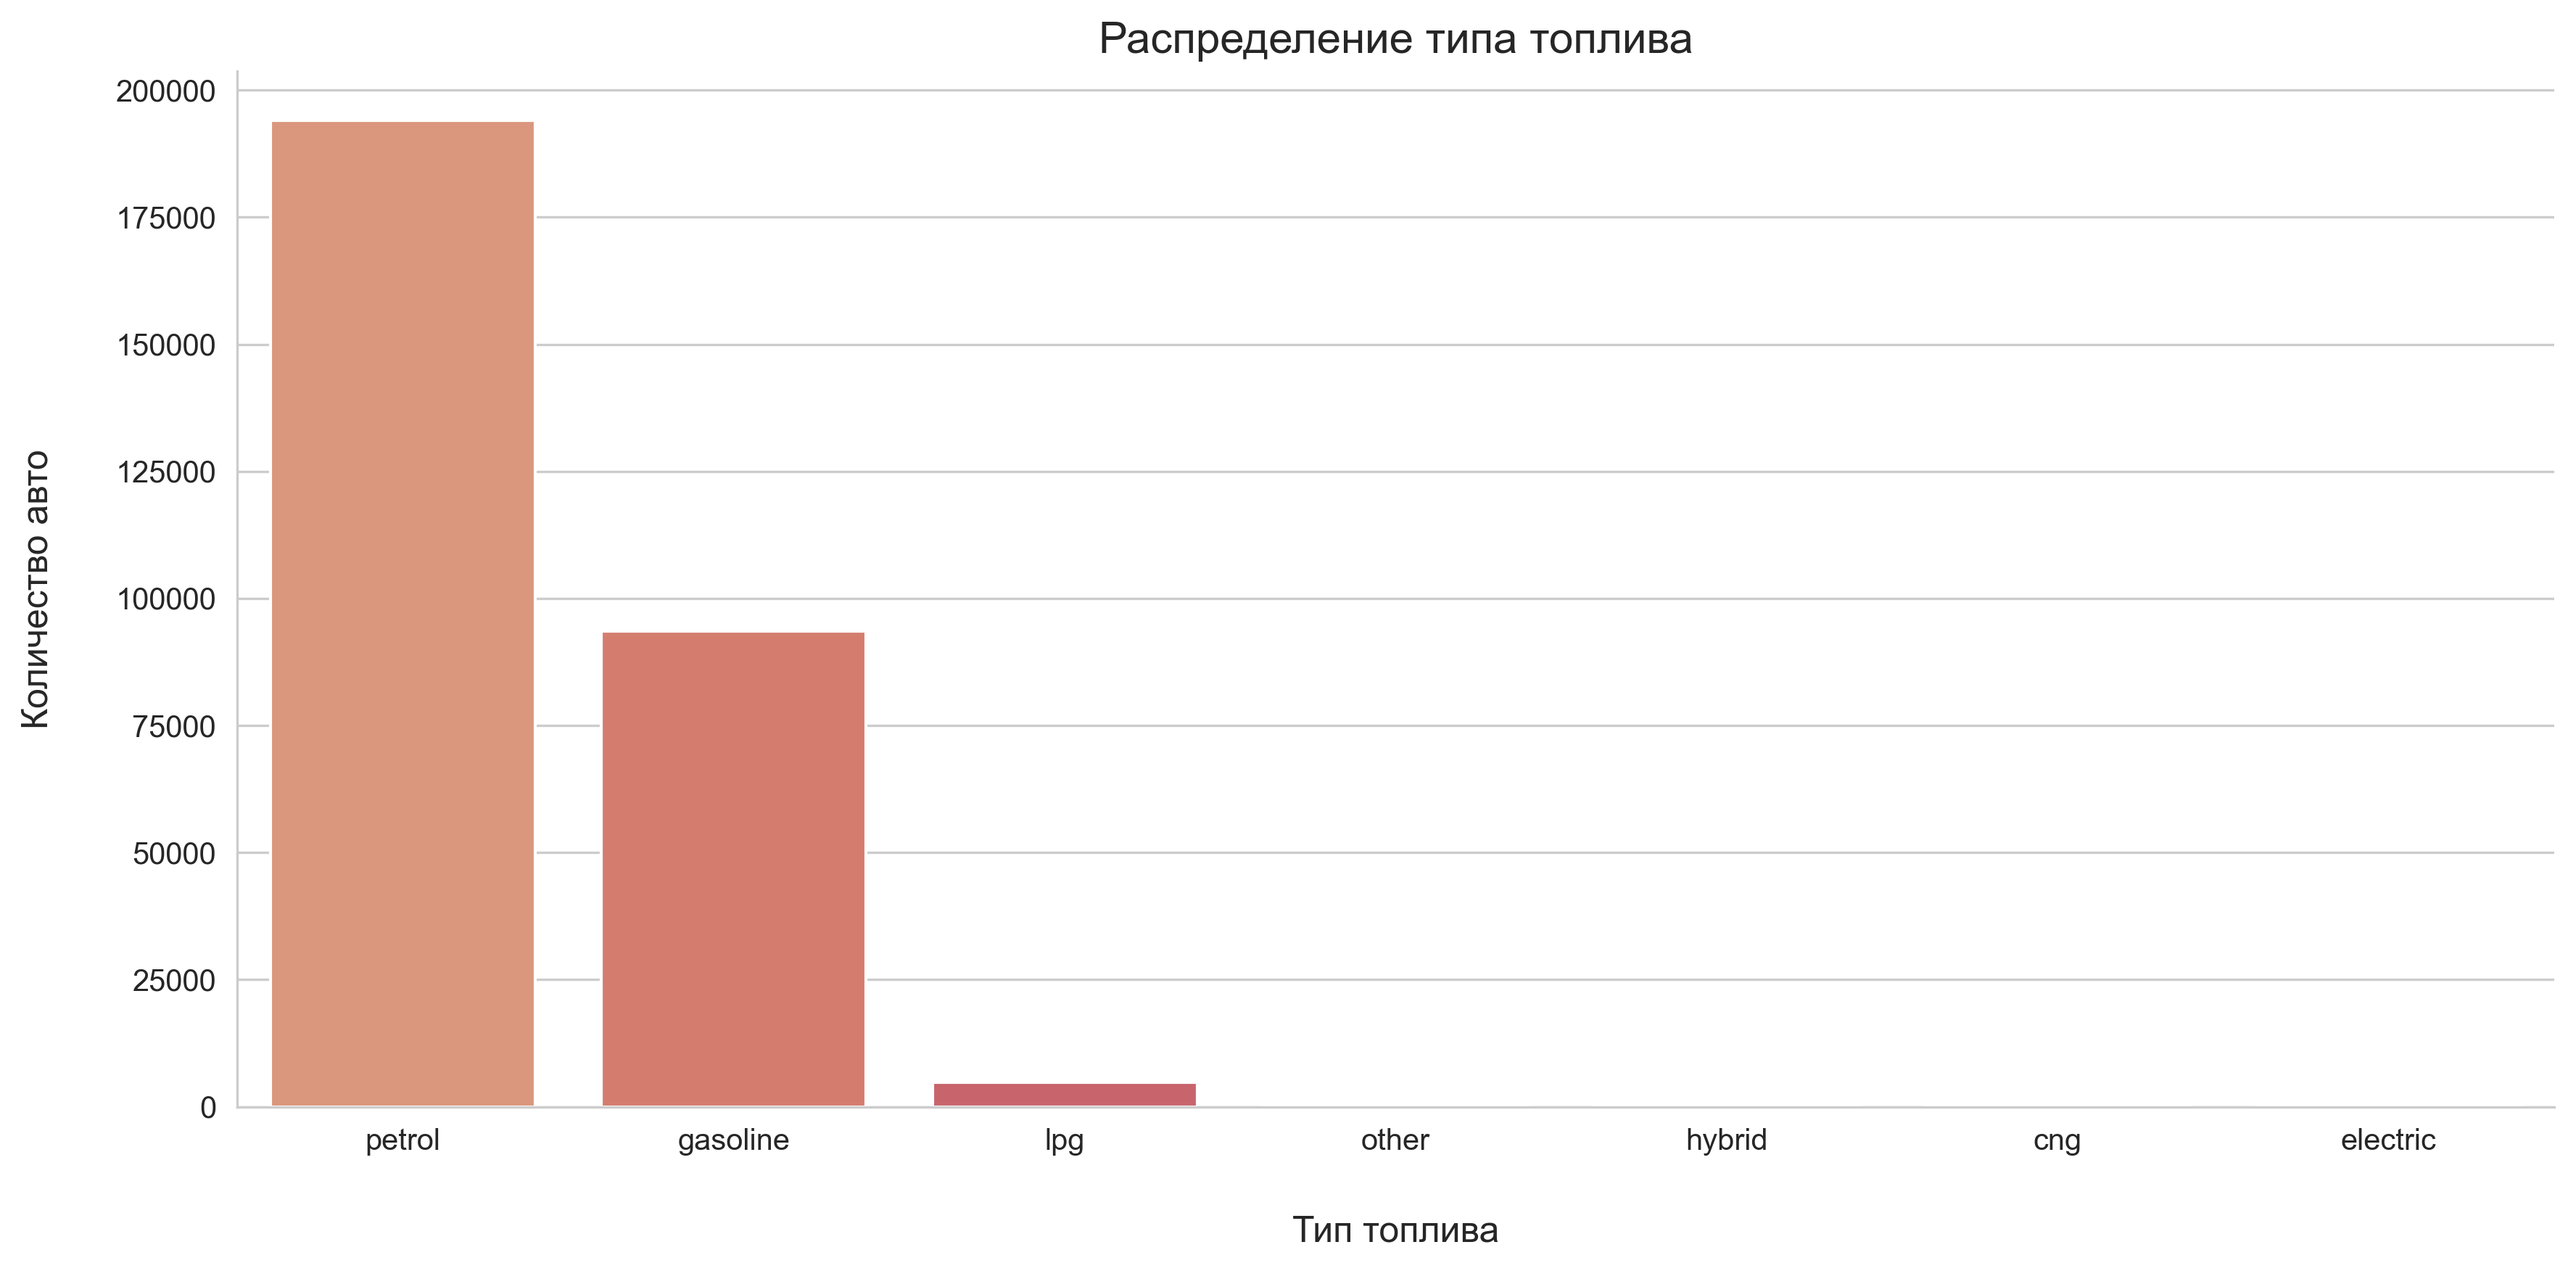

In [56]:
# строим диаграмму распределения признака
sns.countplot(x=data['fuel_type'], palette='flare')
plt.title('Распределение типа топлива')
plt.xlabel('Тип топлива')
plt.ylabel('Количество авто');

Данный признак является категориальным с семью категориями, одна из них — `other`. Попробуем найти какую-либо информацию по маркировке и приведём описание:

* `petrol` — так называют бензин в Британии и [Содружестве наций](https://en.m.wikipedia.org/wiki/Commonwealth_English);
* `gasoline` — а так можно услышать про бензин в Северной Америке и Франции. Примечательно то, что с точки зрения химии [газолин или газовый бензин](https://ru.wikipedia.org/wiki/%D0%93%D0%B0%D0%B7%D0%BE%D0%BB%D0%B8%D0%BD) это наиболее летучие, не растворимые в воде жидкие углеводороды, тот же бензин, но более низкой температурой кипения;
* `lpg` —  *Liquefied petroleum gas* или *сжиженный нефтяной газ*. Смесь сжиженных под давлением лёгких углеводородов;
* `cng` — *Compressed natural gas* или *сжатый природный газ*. Природный газ метан, сжатый на компрессорной станции до давления 200—250 бар;
* `hybrid` — под этой категоирей подразумевается автомобиль, использующий для привода ведущих колёс более одного источника энергии: двигателя внутреннего сгорания и электродвигателя;
* `electric` —  это автомобили, приводимые в движение одним или несколькими электродвигателями с питанием от независимого источника электроэнергии (аккумуляторов, топливных элементов, конденсаторов и т. п.).

Если учесть, что `petrol` и `gasoline` это по-большому счёту одно и то же топливо, то альтернативные источники энергии для ДВС крайне непопулярны в индустрии автостроения. Действиетльно, в $2020$ году доля автомобилей с электрическим двигателем составила $0,7\%$ от общего количества автомобилей в мире. Зависит ли цена продажи авто от типа топлива? [Открытые источники](https://ru.wikipedia.org/wiki/%D0%AD%D0%BB%D0%B5%D0%BA%D1%82%D1%80%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D1%8C#cite_note-2) говорят, что электромобили (в частности) существенно дороже, чем авто того же класса с ДВС. Рассмотрим зависимость `price` от `fuel_type`.    

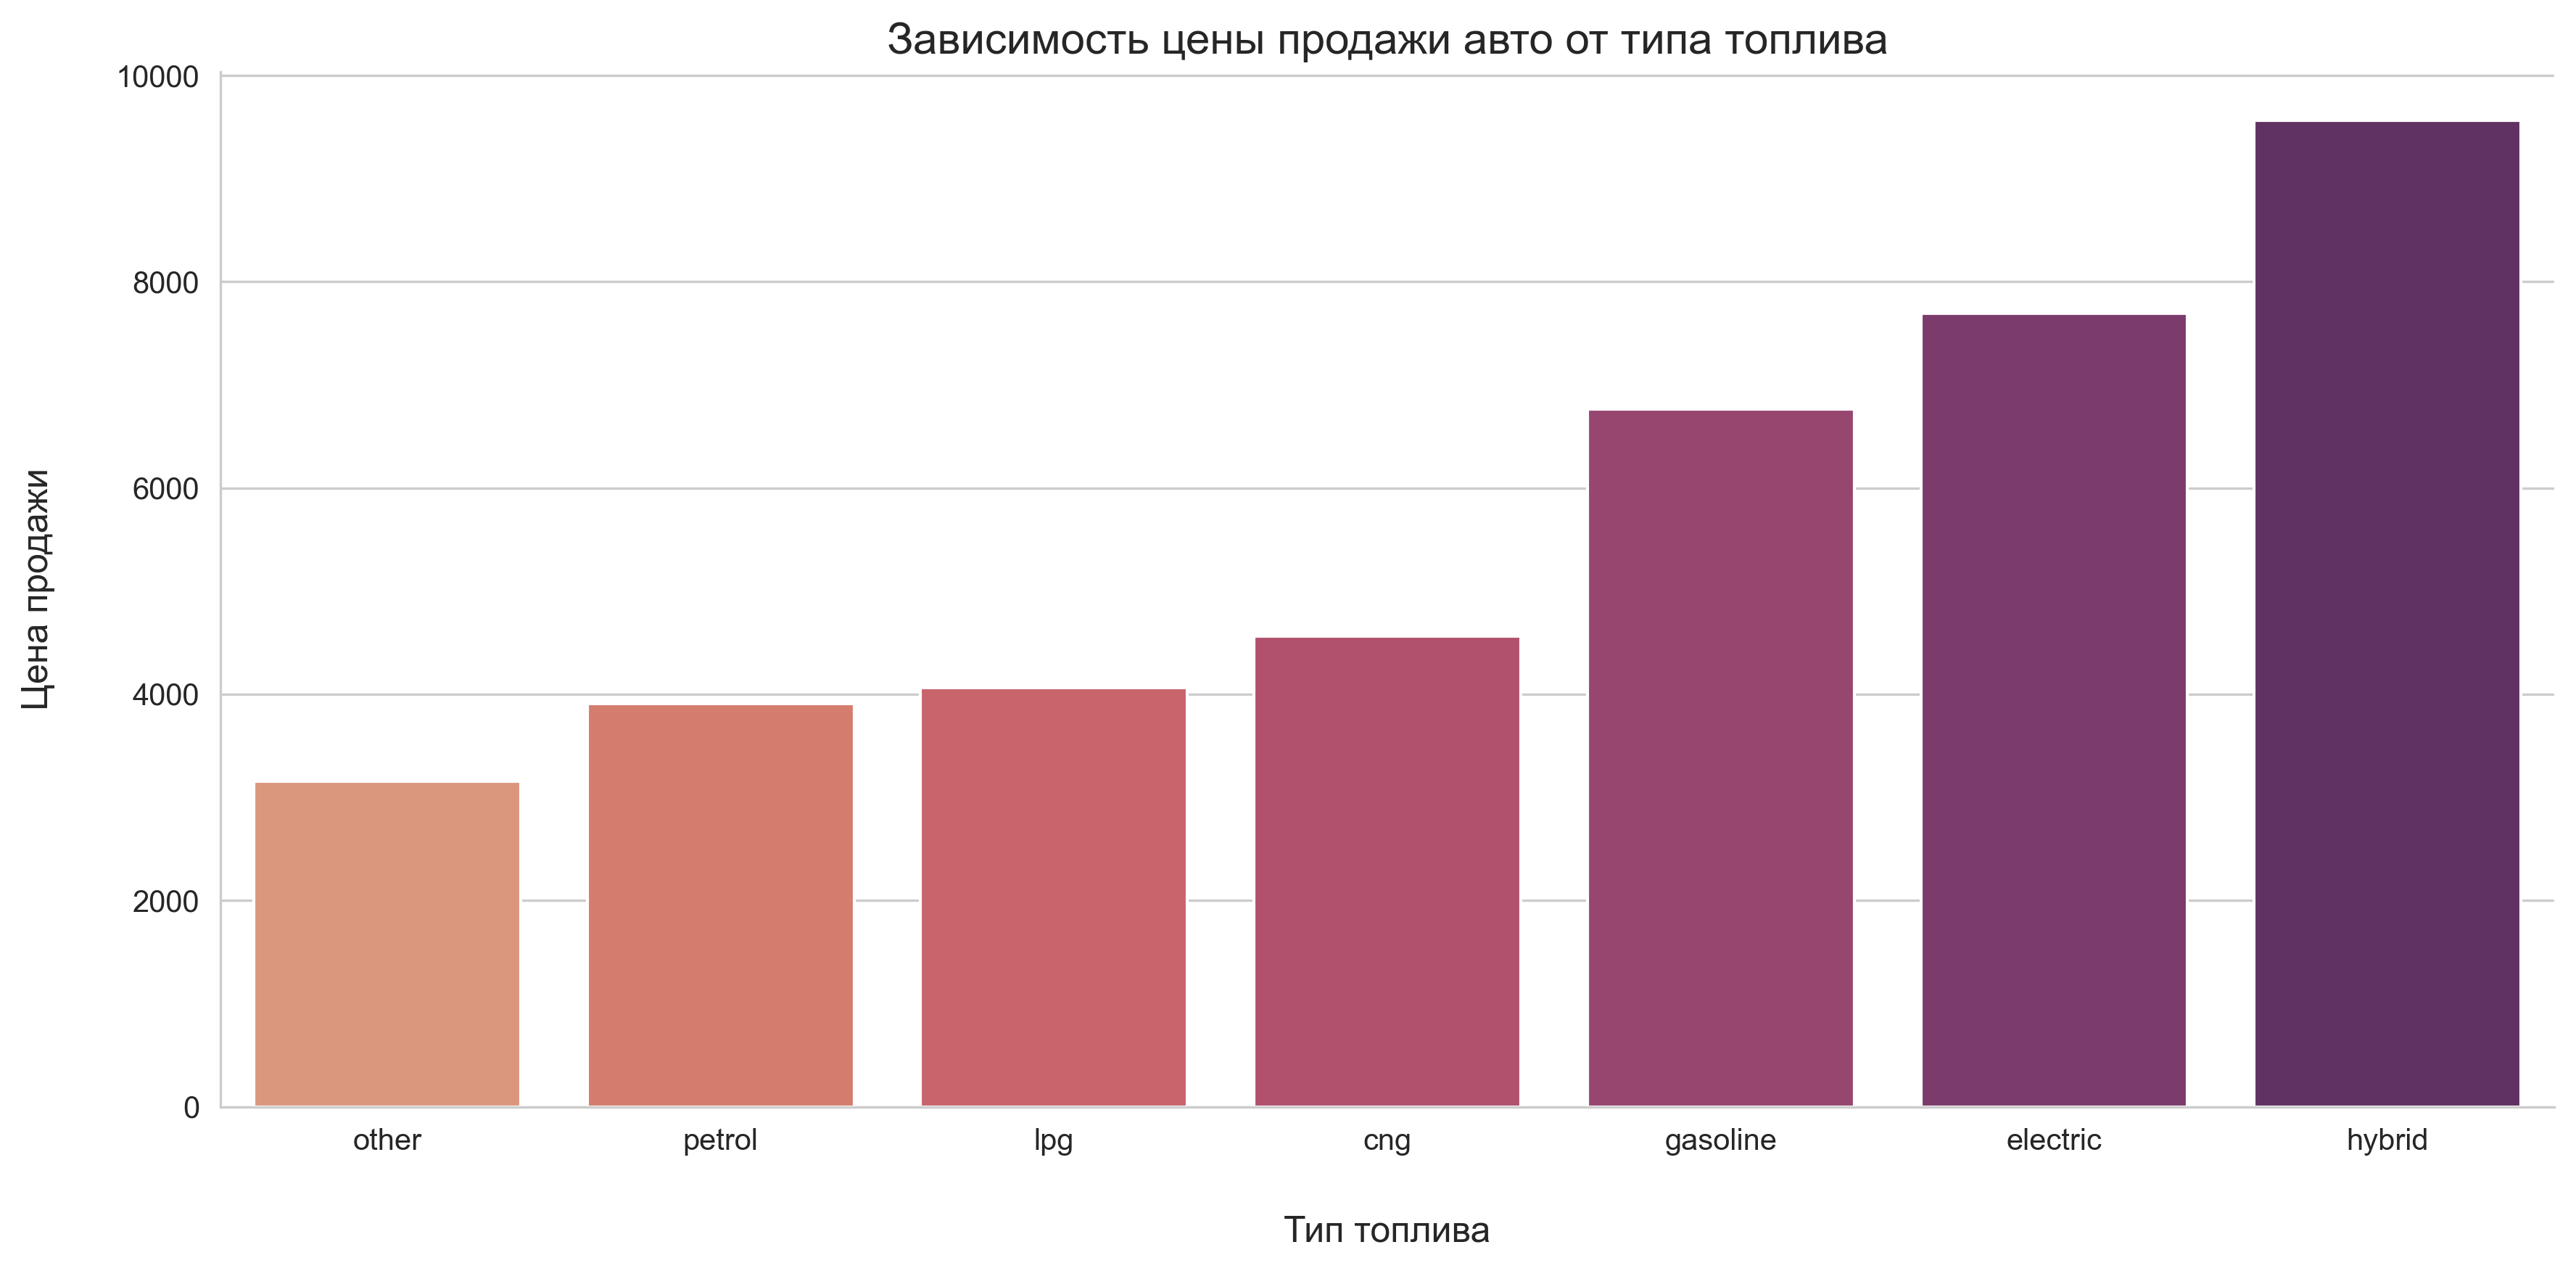

In [57]:
# считаем среднюю цену по типу топлива
g = data.groupby('fuel_type')['price'].mean().sort_values()
# строим столбчатую диаграмму зависимости
sns.barplot(x=g.index, y=g, palette='flare')
plt.title('Зависимость цены продажи авто от типа топлива')
plt.xlabel('Тип топлива')
plt.ylabel('Цена продажи');

Как мы видим электромобили и гибриды по средней цене выходят дороже, чем авто с другими видами топлива. Также жизненный опыт нам подсказывает, что авто «на газу» существенно дешевле обходится на средней временной дистанции при средней эксплуатации.

Для снижения кардинальности признака имеет смысл объединить похожие категории, такие как `petrol` и `gasoline`, `lpg` и `cng`. В категорию `other` скорее всего полали как другие альтернативные виды топлива (солнечные батареи, водород и прочее), так и основные не бензиновые виды топлива (данный признак мог заполнятся пользователем, отюда и неявный дубликат бензина). Мы вынуждены оставить эту категорию без изменения, потому что до конца не понимаем его природу возникновения.

Также в этом признаке имеются пропущенные значения, которые мы можем заполнить модой по группе *моделей* с помощью нашей функции `groupby_fillna`. Итак, наши действия:

* Объединим категории признака;
* Заполним пропуски модой по группе;
* Добавим признак `fuel_type` в список категориальных признаков. 

In [58]:
# объединем категории
data['fuel_type'].replace({
    'petrol': 'gasoline', 
    'lpg': 'gas',
    'cng': 'gas'
}, inplace=True)

------------------------------------------
Текущее количество пропусков: 20303
------------------------------------------


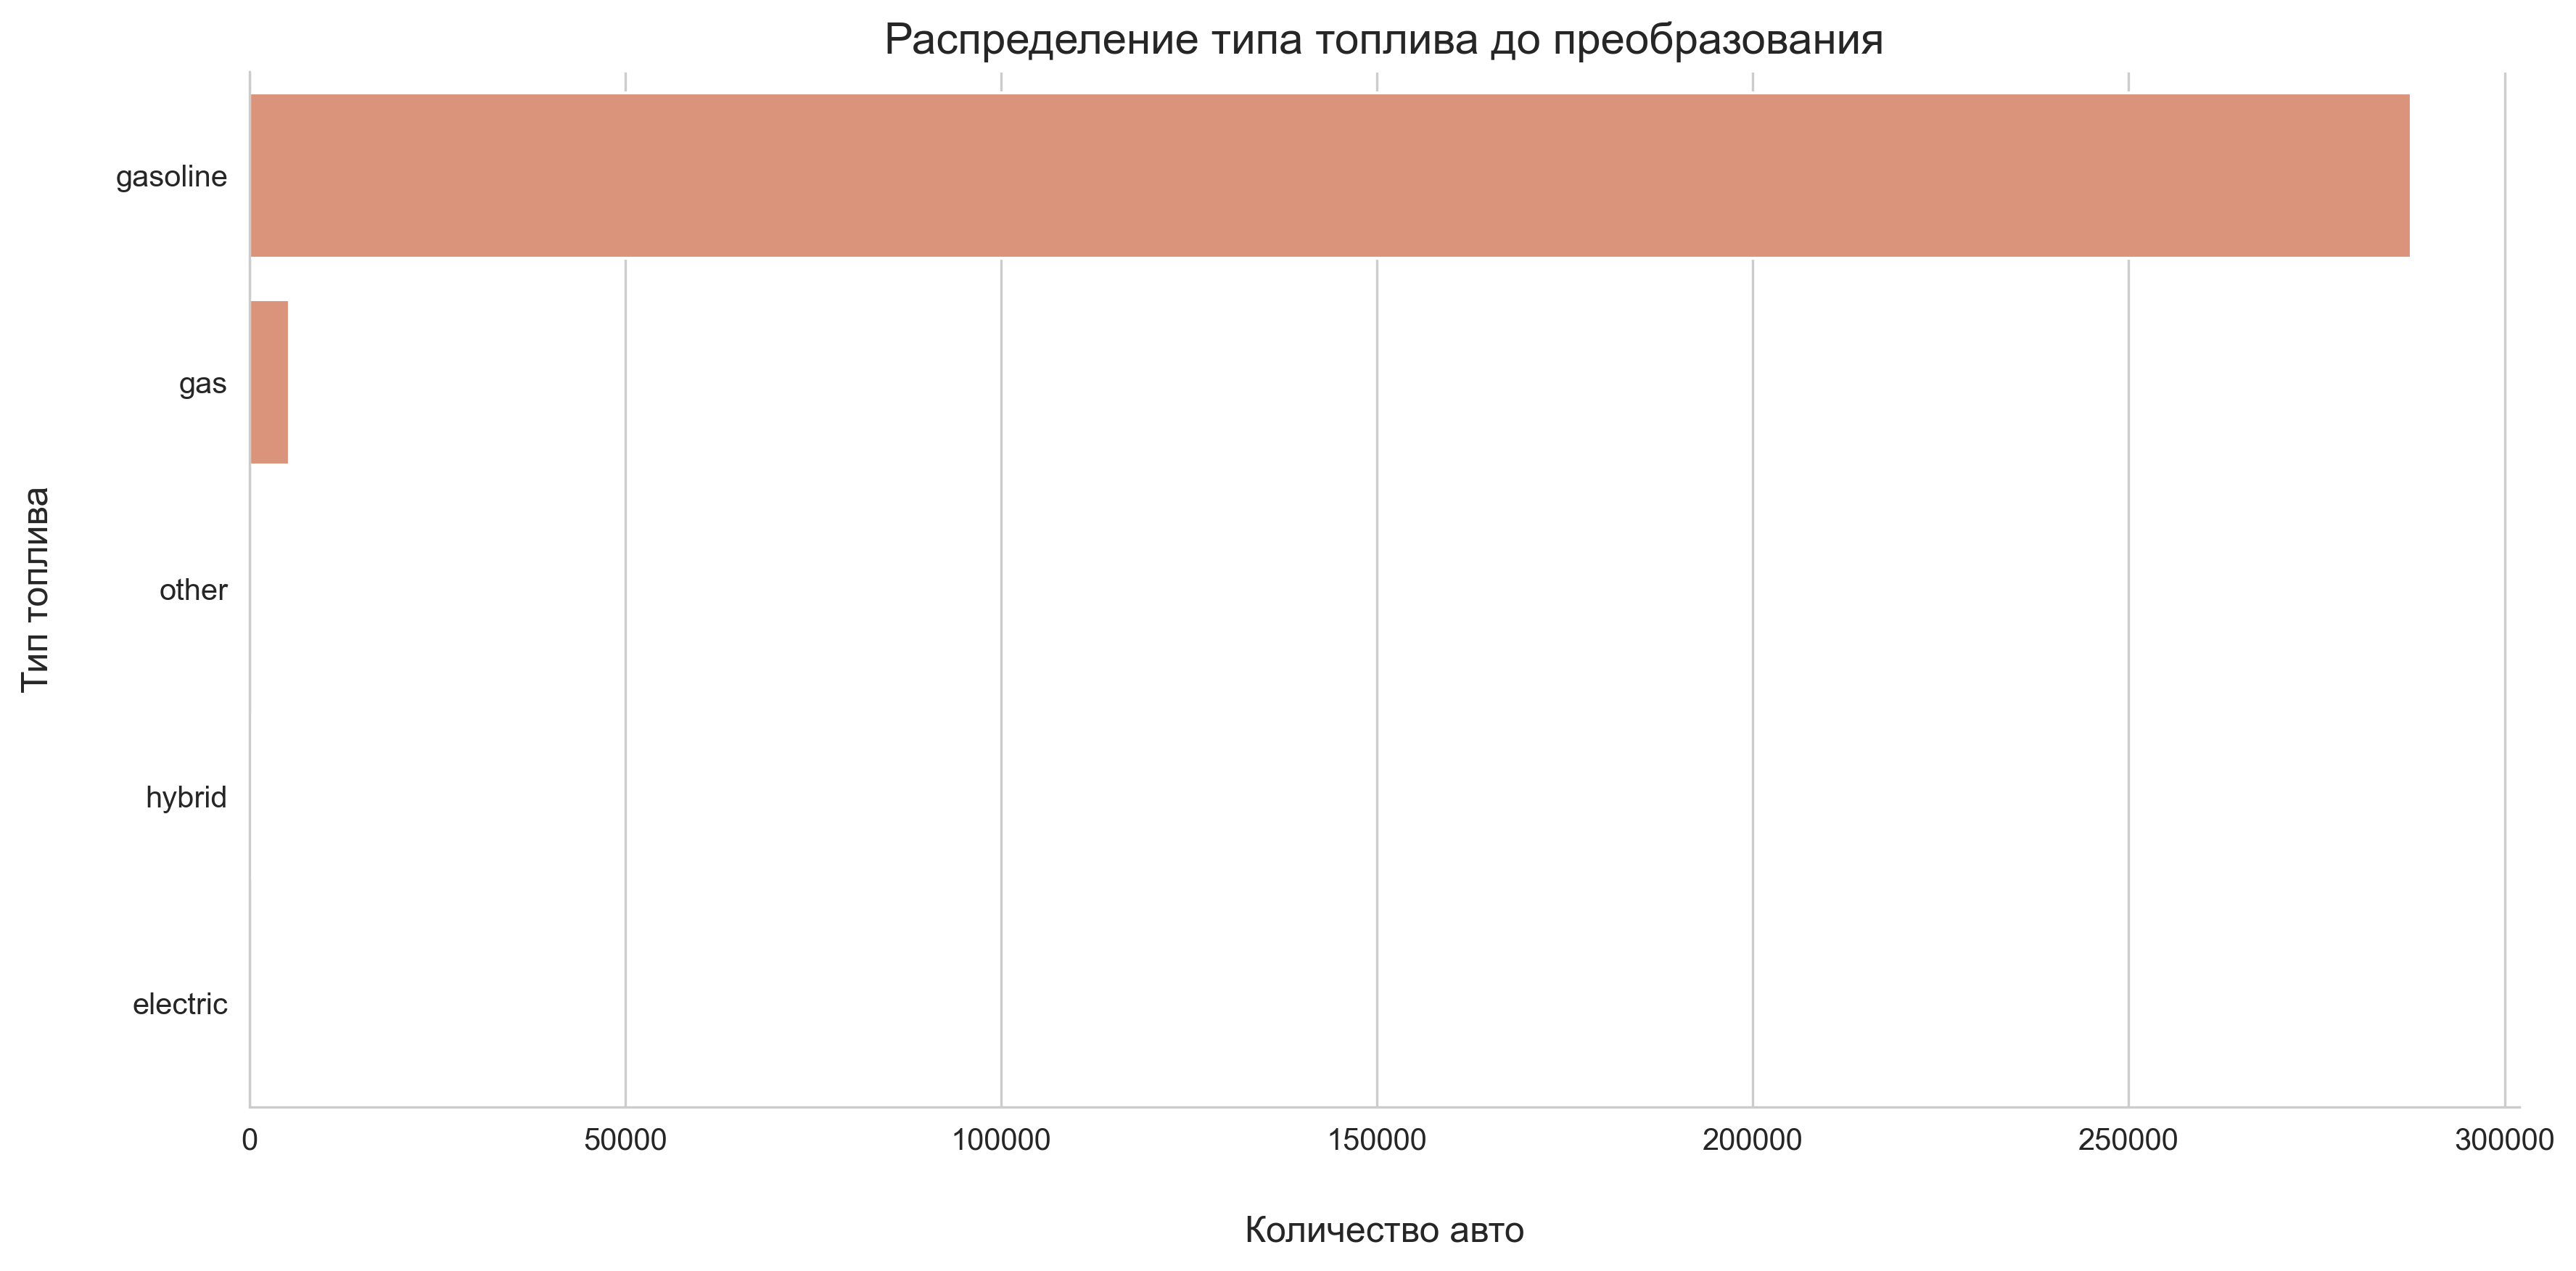

In [59]:
# считаем количество пропусков
print('-' * 42)
print('Текущее количество пропусков:', data['fuel_type'].isna().sum())
print('-' * 42)

# строим распределение до преобразования
sns.countplot(y=data['fuel_type'])
plt.title('Распределение типа топлива до преобразования')
plt.xlabel('Количество авто')
plt.ylabel('Тип топлива');

In [60]:
# заполняем пропуски в признаке
data['fuel_type'] = groupby_fillna(data, 'brand', 'fuel_type')

0

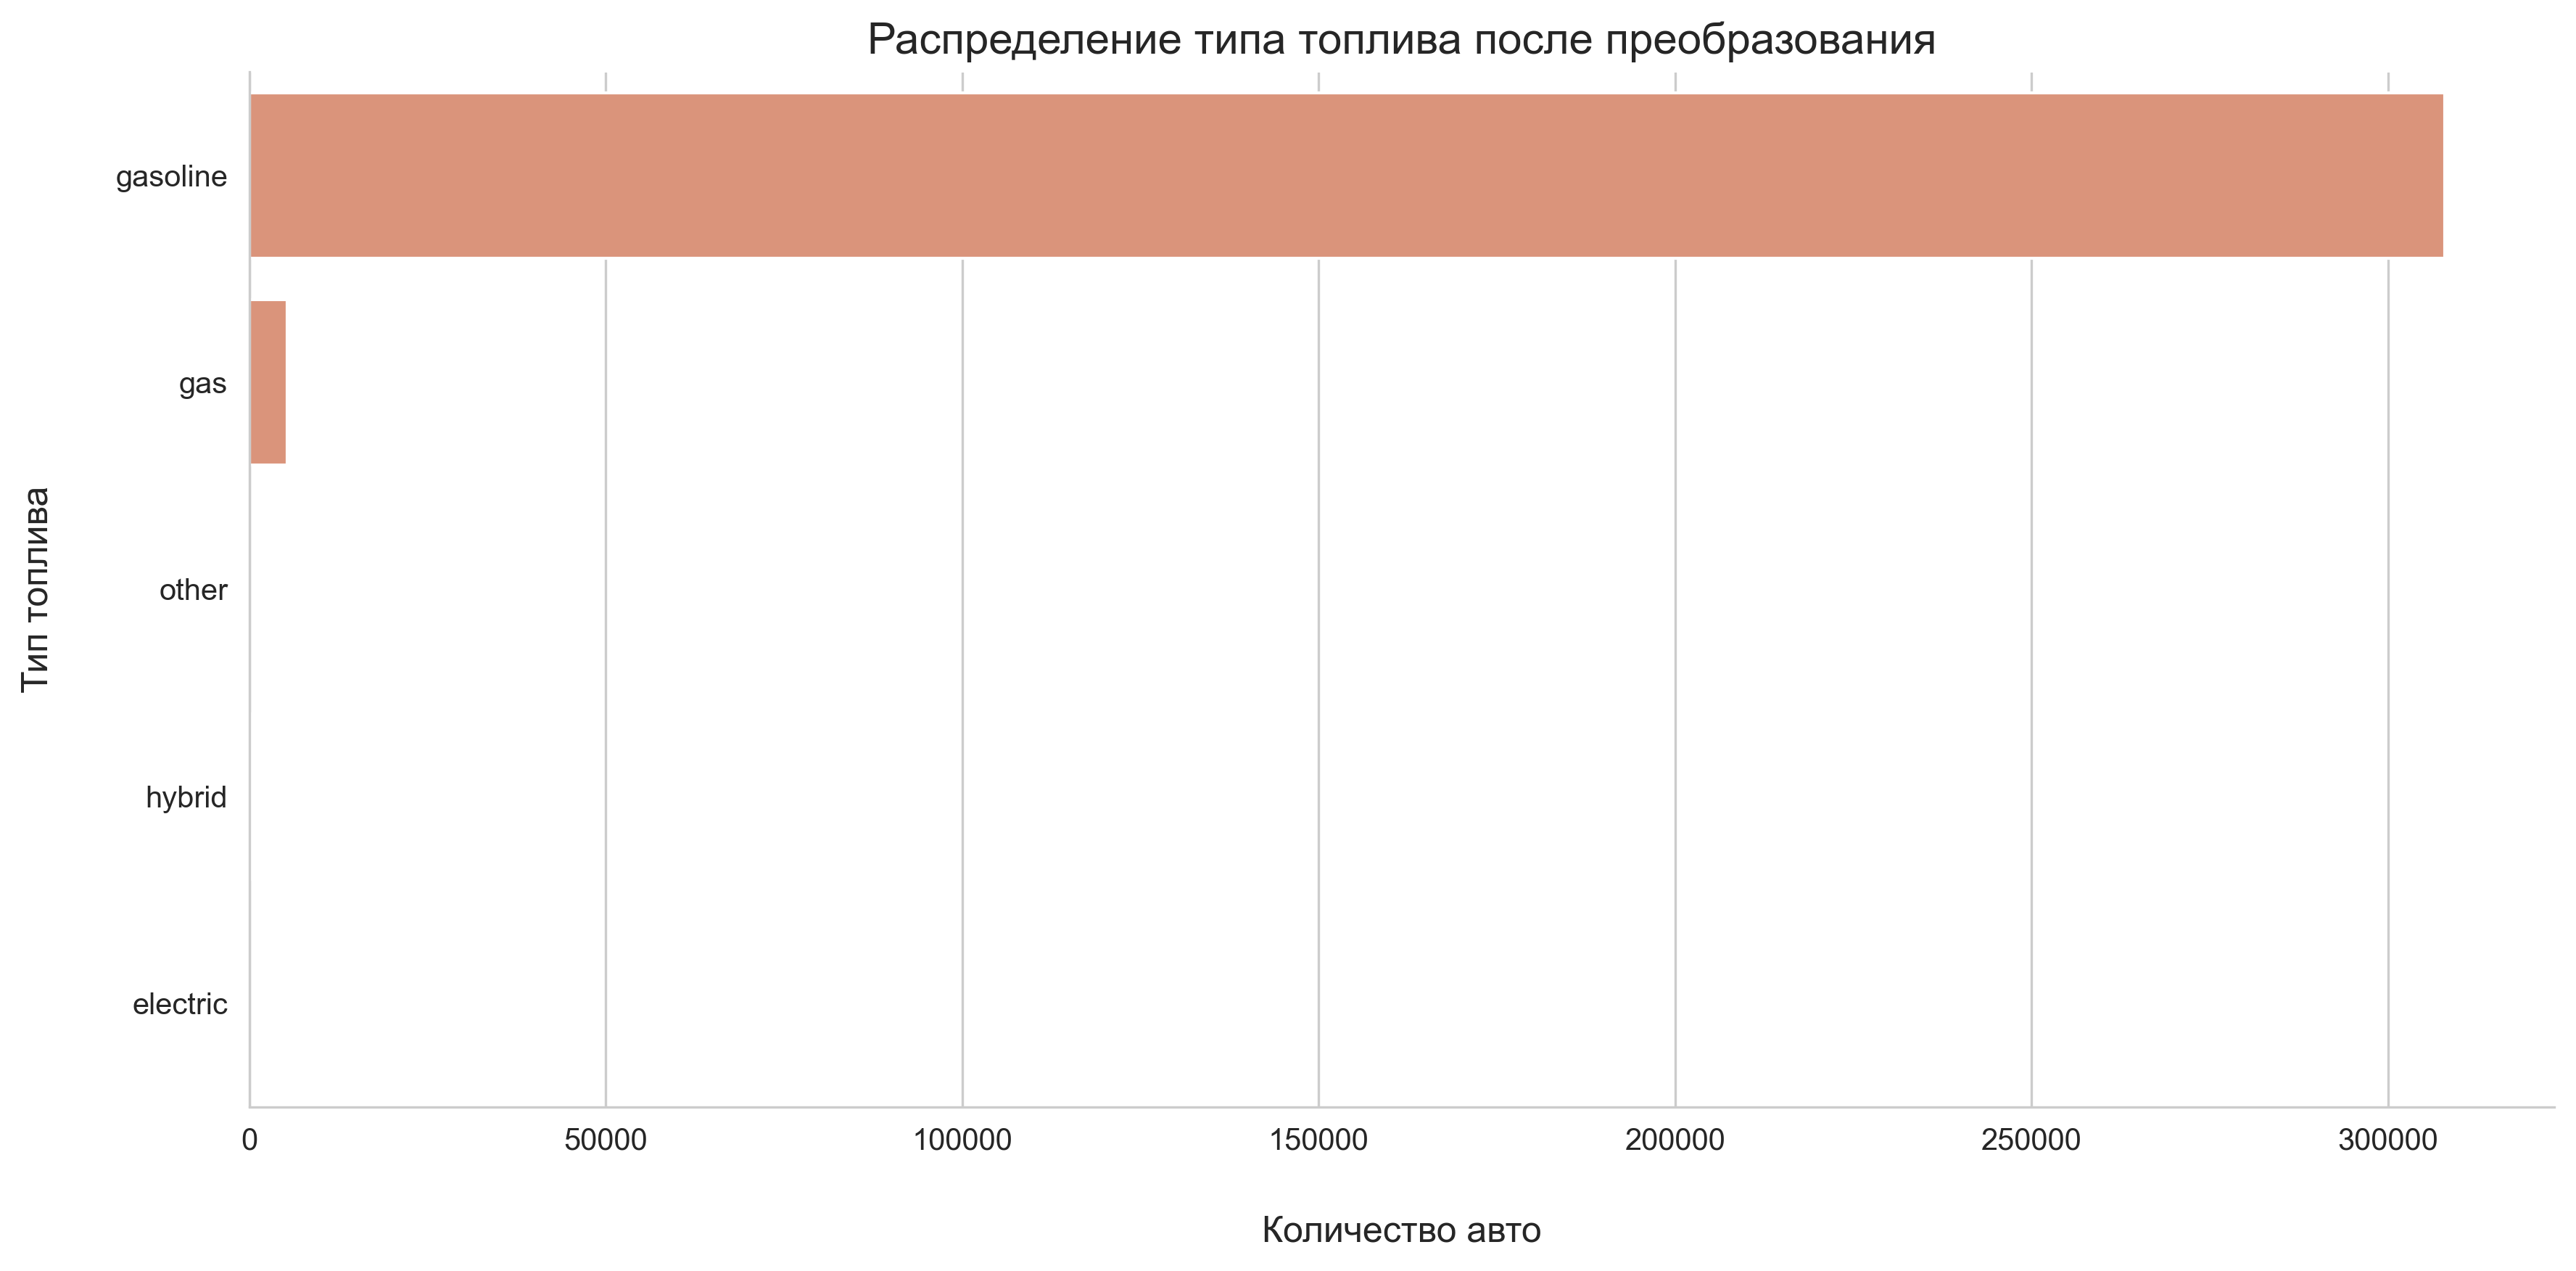

In [61]:
# проверяем распределение признака после преобразования
sns.countplot(y=data['fuel_type'])
plt.title('Распределение типа топлива после преобразования')
plt.xlabel('Количество авто')
plt.ylabel('Тип топлива');

# проверям количество пропусков 
data['fuel_type'].isna().sum()

После преобразования в категорию `gasoline` добавились наблюдения. Это ожидаемо, потому что в данных преобладают автомобили на бензине. Пропусков в признаке больше не наблюдается, теперь можно добавить признак `fuel_type` в список категориальных данных.

In [62]:
# добавляем признак в список
cat_features.extend(['fuel_type'])

## Пробег

Пробег является важным показателем состояния машины, поэтому именно на него ориентируются при покупки автомобиля на вторичном рынке. Учитывая фундаментальный закон рынка «спрос рождает предложение» (который работает и в обратную сторону), можно с уверенностью сказать, что пробег будет влиять на цену продажи автомобиля. Сперва изучим распределение пробега по нашей выборке, а потом проверим эту связь.

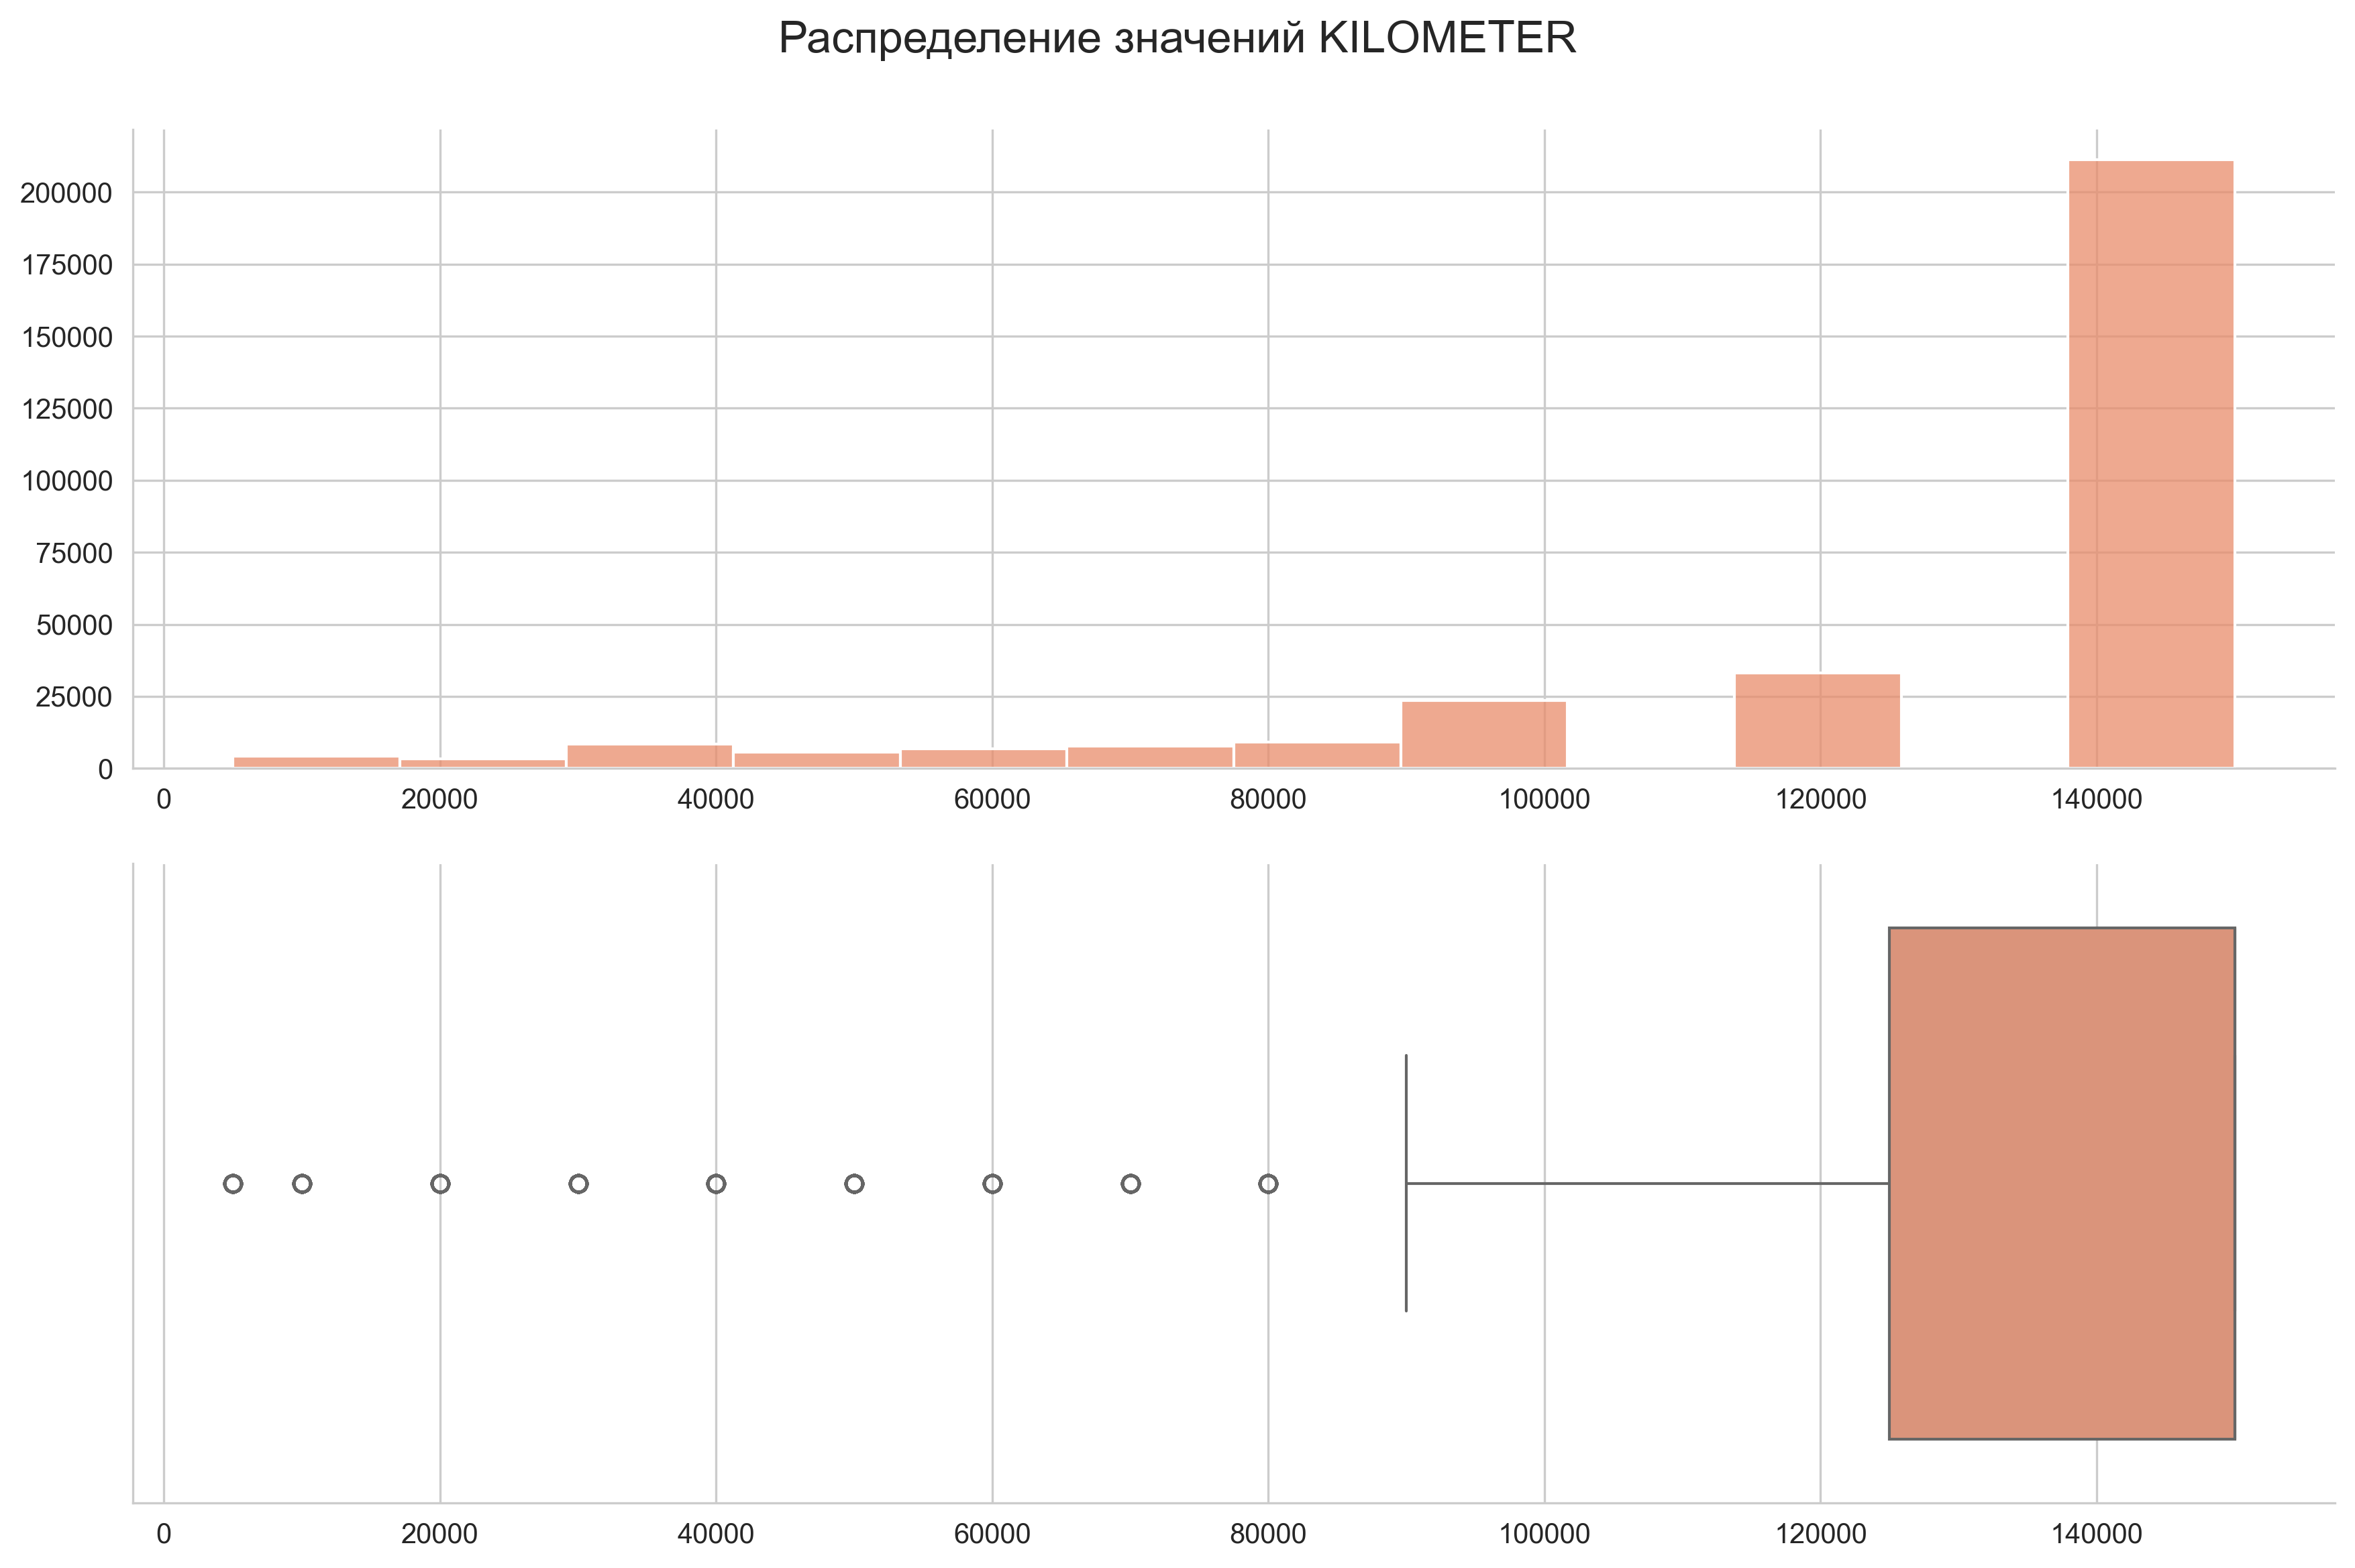

In [63]:
# вызываем функцию отрисовки распределений
get_distplots(data['kilometer'], bins=data['kilometer'].nunique() - 1)

In [64]:
# выводим описательные статистики
data['kilometer'].describe()

count    313626.00
mean     128982.98
std       36462.38
min        5000.00
25%      125000.00
50%      150000.00
75%      150000.00
max      150000.00
Name: kilometer, dtype: float64

Три четверти наблюдаемых авто имеет пробег $150$ тыс. км или близкое к этому значение. Судя по значениям вне межквартильного размаха (да и по описательным статистикам) видно, что автовладелец в основном указывал округлённый пробег. 

В рекомендациях по эксплуатации и обслуживанию транспортных средств упоминается, что нормальным пробегом можно назвать $75$ тыс. км для автомобиля возрастом пять лет. Если машина десятилетняя, то нормальным для нее считается пробег $150$ тыс. км. ([источник](https://www.autonews.ru/news/6464d5409a79476cf1f3adb1)). Проверим, наколько точно наблюдаемые нами авто соответствуют этому описанию.

count    211183.00
mean         14.17
std           5.18
min           0.00
25%          11.00
50%          14.00
75%          17.00
max          29.00
Name: age, dtype: float64

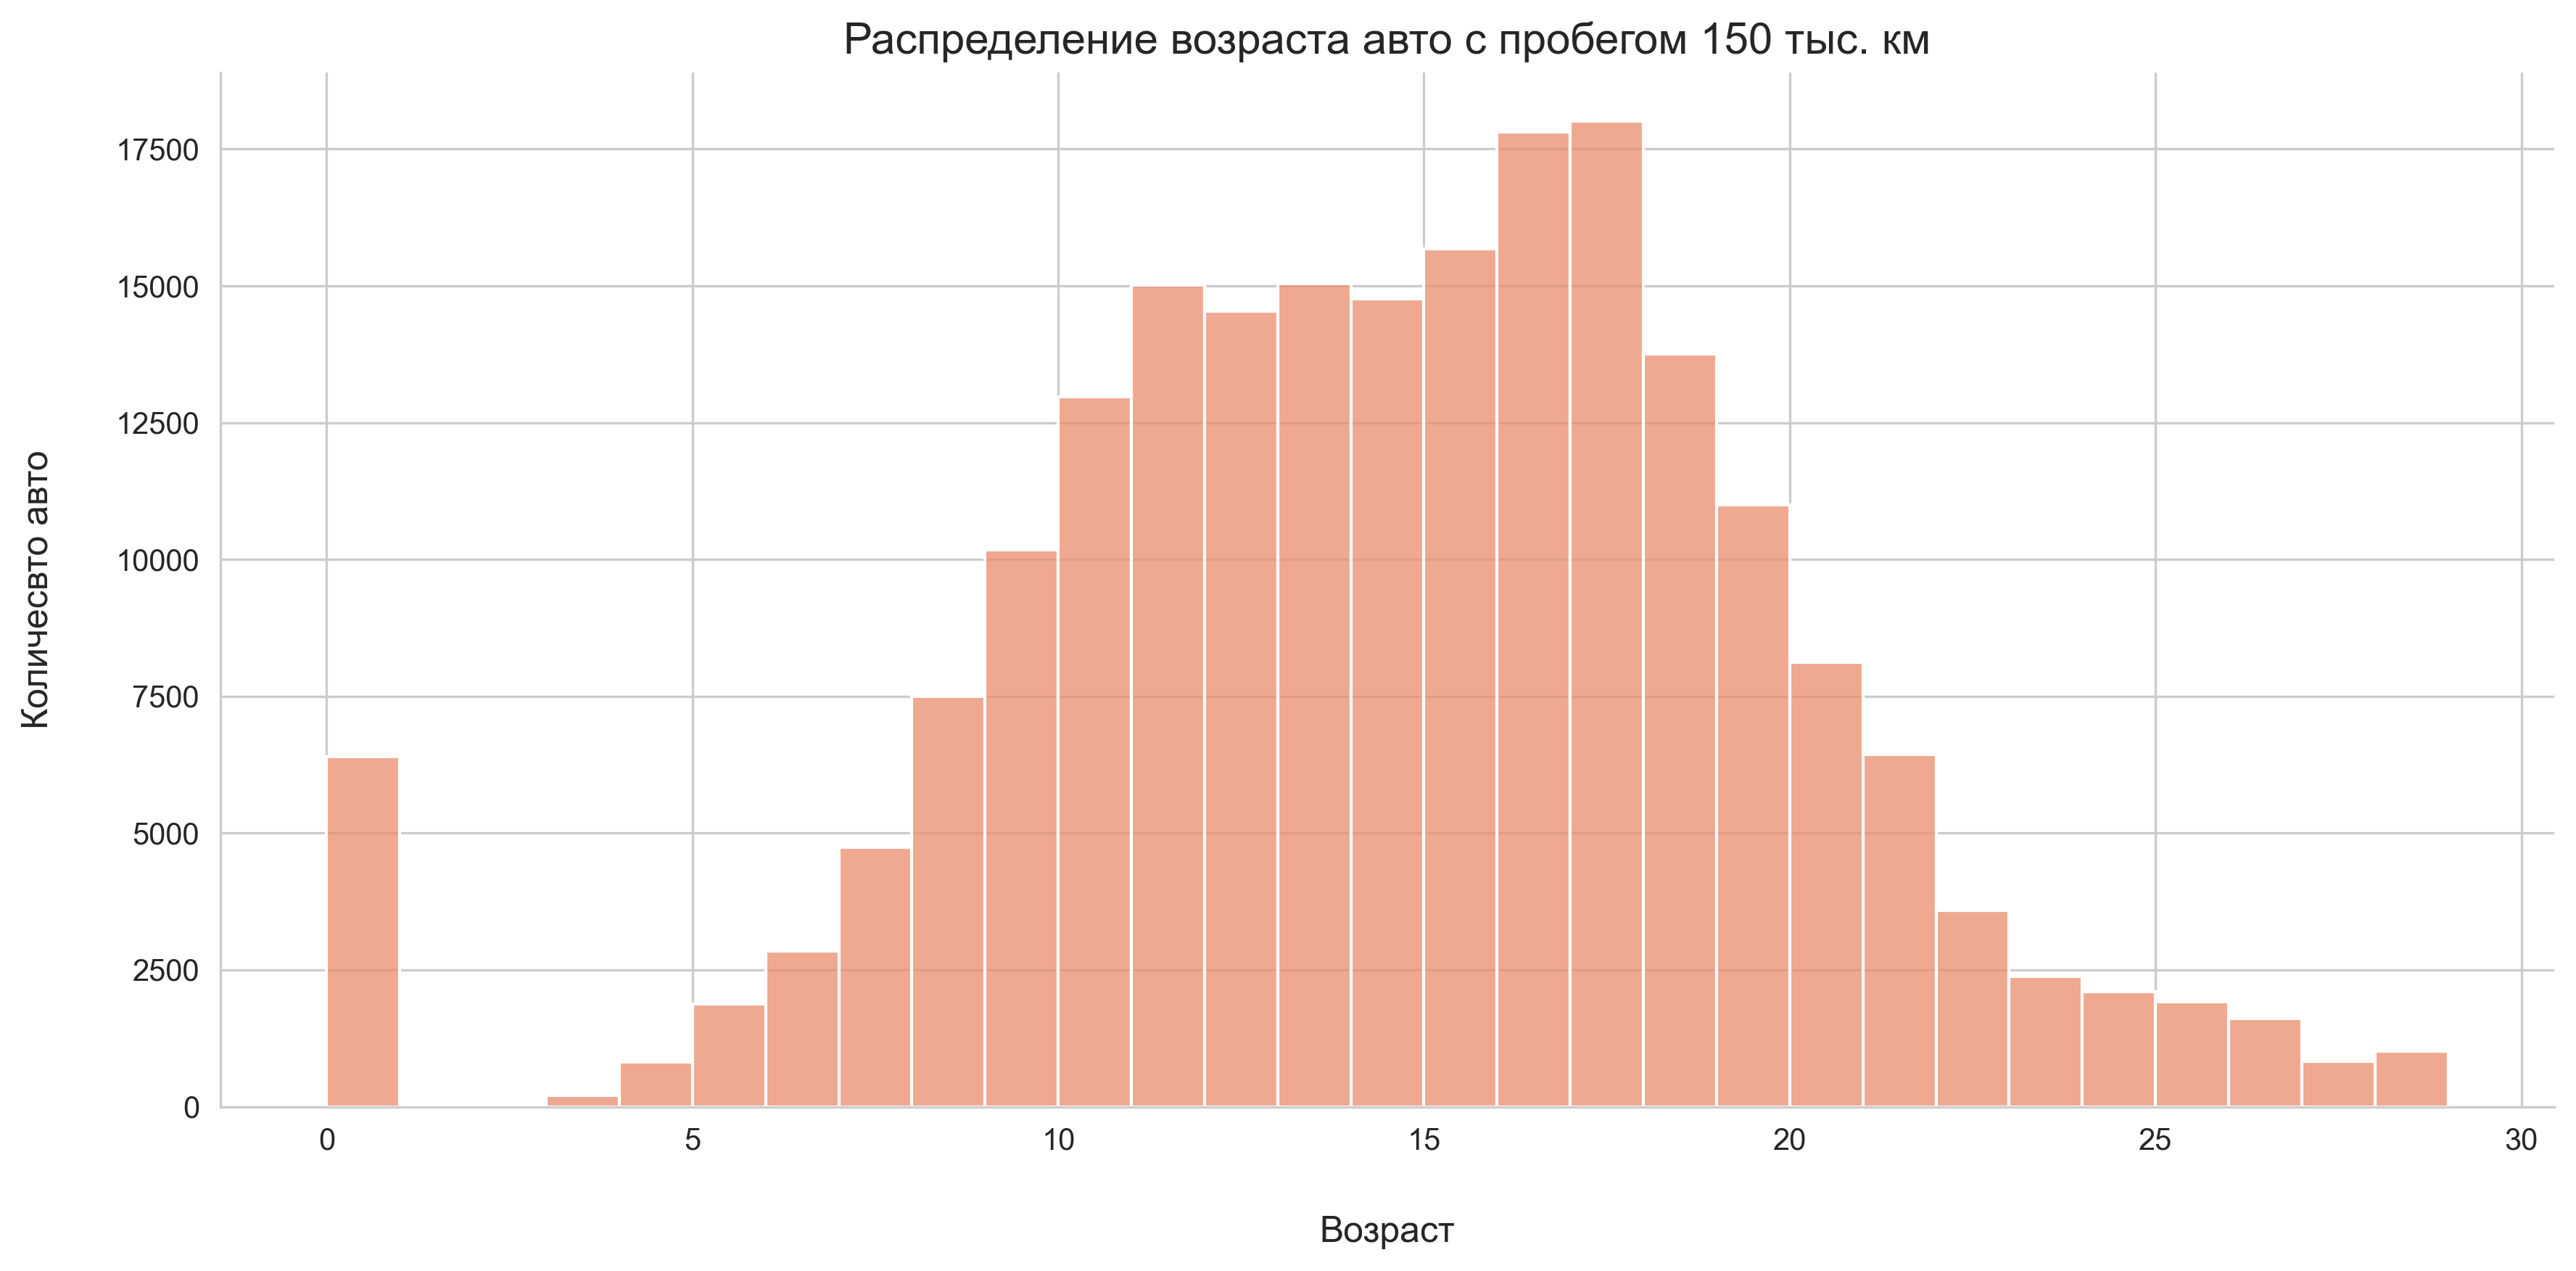

In [65]:
# фильтруем данные по пробегу
g = data.query('kilometer == 150000')['age']
# строим распределение фильтра
sns.histplot(g, bins=g.nunique() - 1)
plt.title('Распределение возраста авто с пробегом 150 тыс. км')
plt.xlabel('Возраст')
plt.ylabel('Количесвто авто')
# выводим описательную статистику
g.describe()

В среднем наблюдаемые авто с пробегом $150$ тыс. км имеют возраст $14$ лет. Если брать в расчёт стандартное отклонение, то какая-то часть наблюдений соответствет описанию нормального пробега. Очень старнно выглядит левый пик значнеий — есть авто с таким пробегом уже в первый год. Это надо каждый день проезжать $411$ км, что выглядит неправдоподобно. Удалим эти наблюдения, они будут только создавать шум.   

In [66]:
# удаляем строки по индексу
data.drop(
    # индексируемся на нужный пробег и возраст    
    data.loc[(data['kilometer'] == 150000) & (data['age'] == 0)].index,
    inplace=True
)

Теперь проверим вторую цифру «нормального» пробега из описания — $75$ тыс. км для пятилетнего авто. В нашем распределении нет такой цифры, поэтому мы будем использовать диапазон $70-80$. 

count    7865.00
mean        8.87
std         5.14
min         0.00
25%         5.00
50%         7.00
75%        11.00
max        29.00
Name: age, dtype: float64

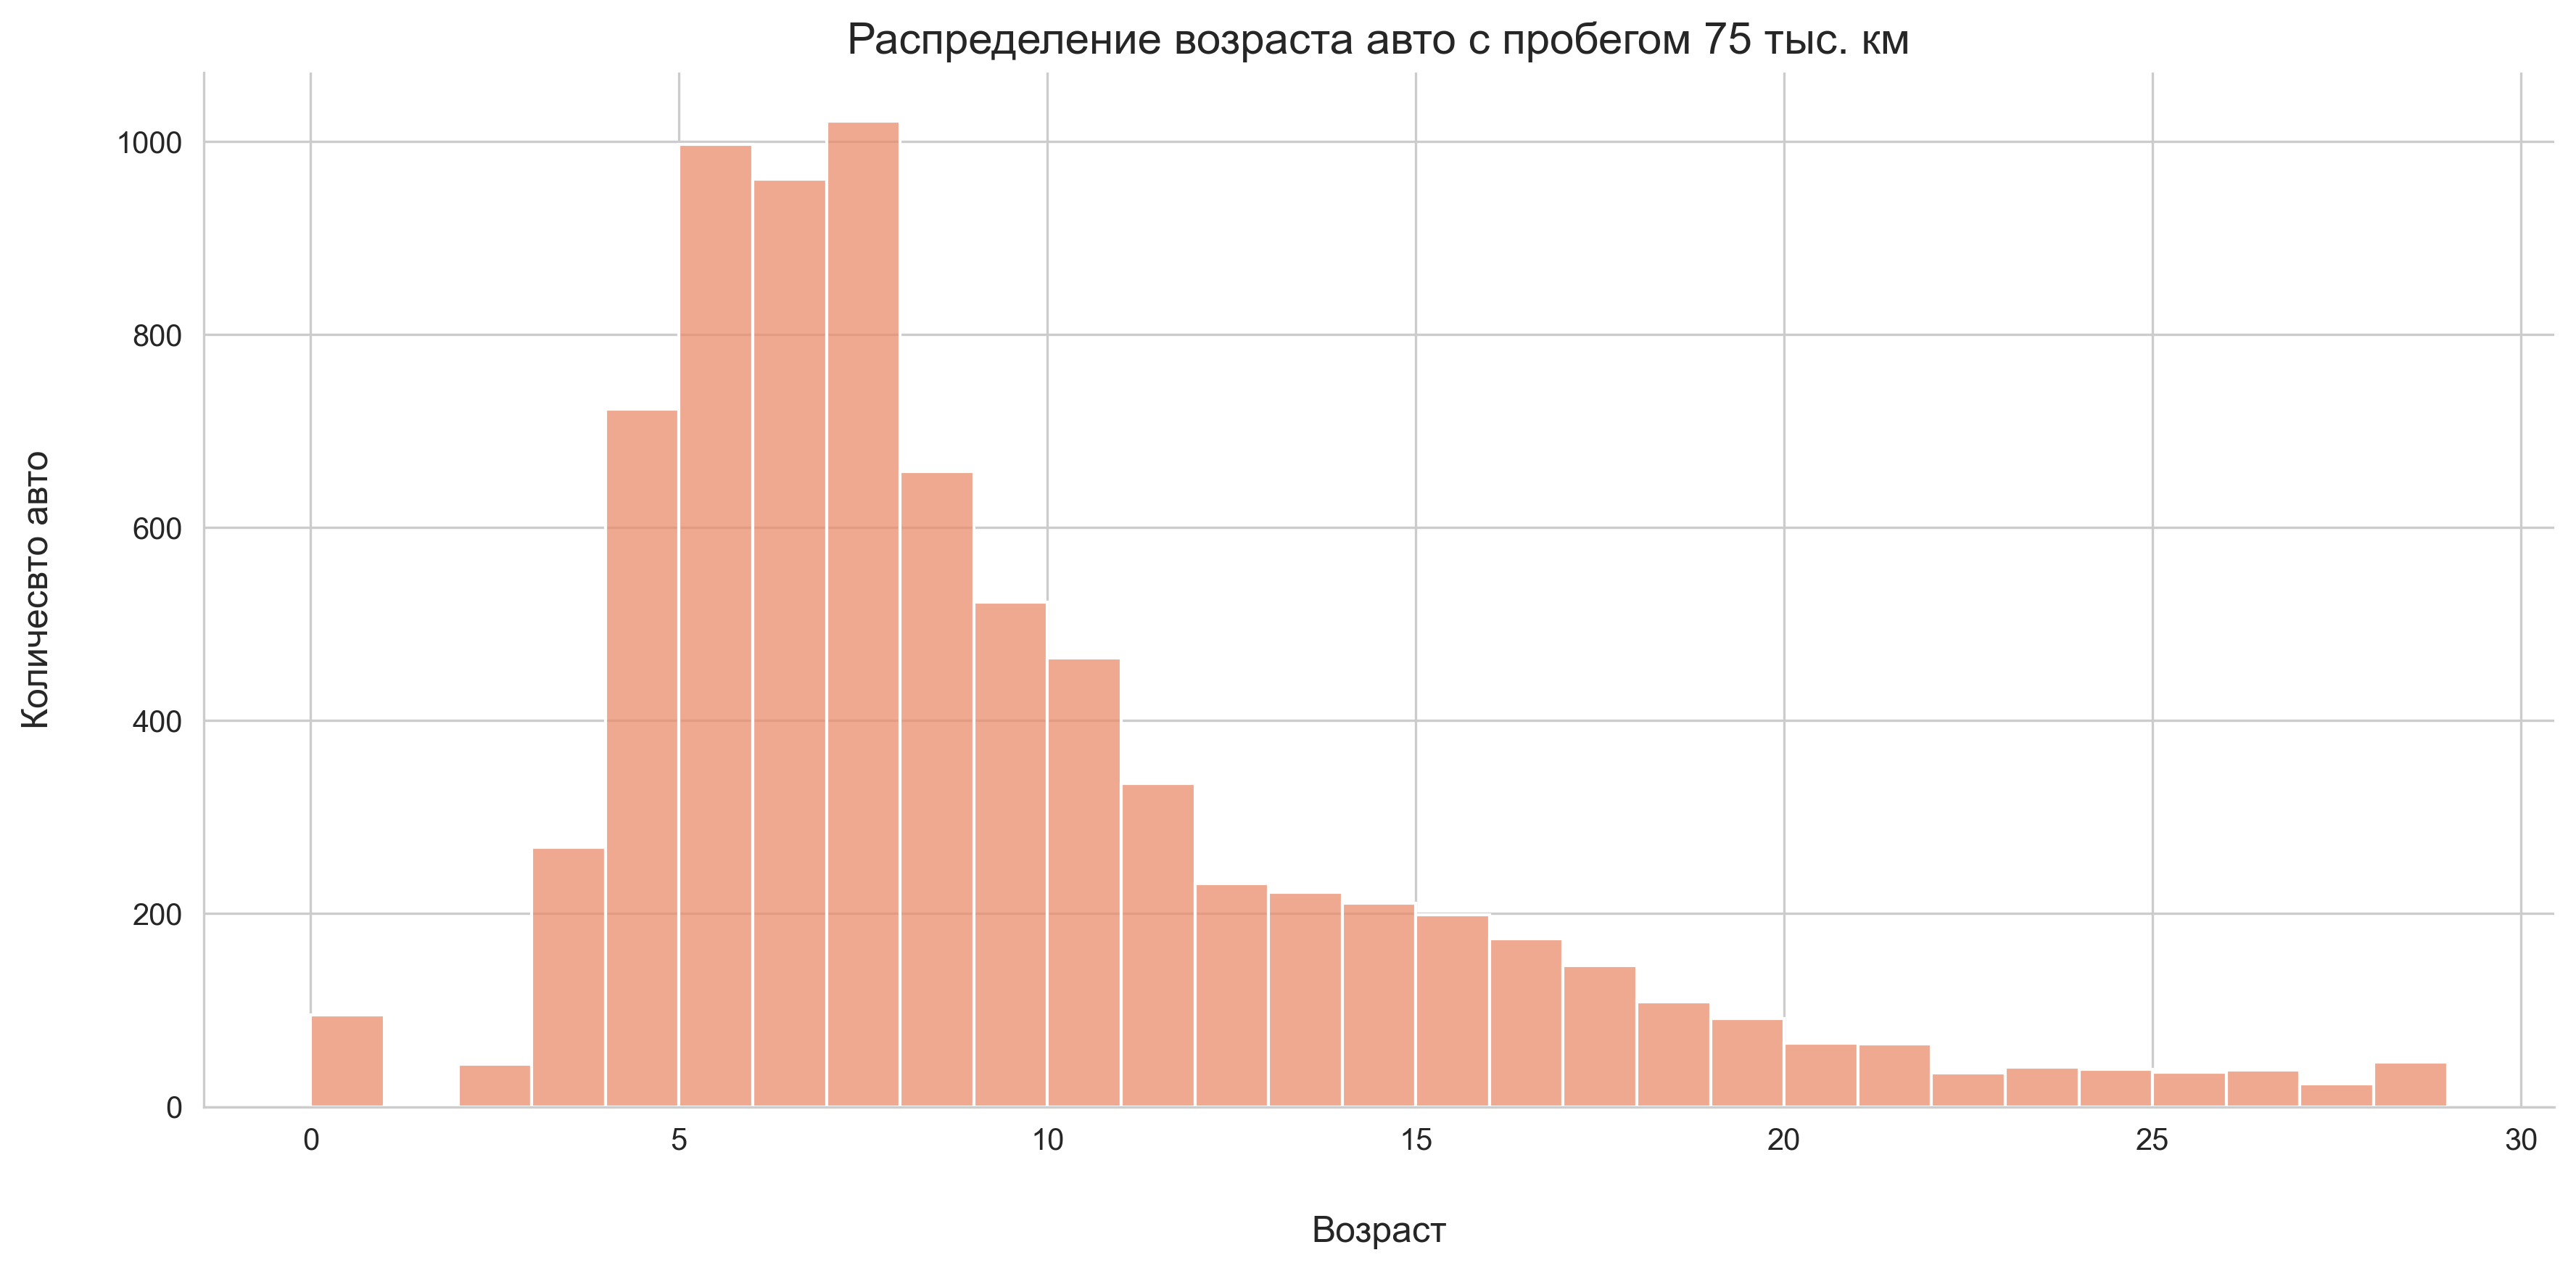

In [67]:
# фильтруем данные по пробегу
g = data.query('kilometer > 69000 & kilometer < 80000')['age']
# строим распределение фильтра
sns.histplot(g, bins=g.nunique() - 1)
plt.title('Распределение возраста авто с пробегом 75 тыс. км')
plt.xlabel('Возраст')
plt.ylabel('Количесвто авто')
# выводим описательную статистику
g.describe()

Авто с пробегом $75$ тыс. км в среднем имеют возраст почти $9$ лет. Стандартное отклонение даёт понять, что в таком срезе присутстуют наблюдения подходящие под описание авто с «нормальным» пробегом. Также присутствуют неправдоподобные наблюдения — есть автомобили с наблюдаемым пробегом уже на первом году эксплуатации. Для этого надо проезжать $205$ км в день. Поступим с этими наблюдениями как и с предыдущими.  

In [68]:
# удаляем строки по индексу
data.drop(
    # индексируемся на нужный пробег и возраст    
    data.loc[(data['kilometer'] > 69000) & \
             (data['kilometer'] < 80000) & \
             (data['age'] == 0)].index, inplace=True
)    

Так, а что же насчёт небольшого пробега, который присутствует в левом хвосте распределения? Исходя из того же наблюдения, что «нормальным» пробегом можно считать $150$ тыс. км за $10$ лет или $75$ тыс. км за $5$ лет (это $41$ км в день), мы можем проверить на «нормальность» авто в этом хвосте. Из расчёта получается, что пробег $20$ тыс. км должен быть у полуторагодовалого авто. Посмотрим на авто с пробегом меньше $20$ тыс. км и возрастом старше двух лет.  

In [69]:
# расчёт возраста авто с пробегом 20 тыс. км
(20000 / 41) / 365

1.3364517206815905

In [70]:
# индексируемся на авто с пробегом 20 тыс. км и старше 2-х лет
data.loc[(data['kilometer'] < 20000) & (data['age'] > 2)].head(10)

date_crawled  price vehicle_type  registration_year gearbox  power  \
157 2016-03-23 14:45:57   7500          suv               2007    auto    194   
158 2016-04-01 16:06:24    800        sedan               1993  manual      0   
261 2016-03-09 15:50:39   1450        sedan               1999  manual      0   
291 2016-04-01 00:51:10   2000        sedan               2004  manual    122   
392 2016-03-25 18:56:32   2350        small               2006     NaN      0   
668 2016-03-21 16:00:19    250          bus               2000     NaN      0   
736 2016-03-31 00:28:47   1290          bus               2001  manual    101   
770 2016-04-07 07:36:37    550        small               1995  manual     45   
899 2016-03-20 00:38:01   2799        sedan               2003  manual    135   
917 2016-03-14 18:55:19  14000  convertible               2003  manual     71   

           model  kilometer  registration_month fuel_type          brand  \
157      sorento       5000                  11  gasoline            kia   
158         golf      10000                   9  gasoline     volkswagen   
261     c_klasse       5000                   8  gasoline  mercedes_benz   
291      6_reihe       5000                   7  gasoline          mazda   
392           c1       5000                   0     other        citroen   
668  transporter       5000                   0  gasoline     volkswagen   
736      transit       5000                   6  gasoline           ford   
770         polo       5000                   5  gasoline     volkswagen   
899       scenic       5000                  12  gasoline        renault   
917        other       5000                   8  gasoline          smart   

    repaired date_created  number_of_pictures  postal_code  \
157      NaN   2016-03-23                   0        34314   
158      yes   2016-04-01                   0        65929   
261       no   2016-03-09                   0        39120   
291       no   2016-03-31                   0        54558   
392      NaN   2016-03-25                   0        26123   
668      NaN   2016-03-21                   0         7407   
736      NaN   2016-03-29                   0        35435   
770      NaN   2016-04-07                   0        45309   
899       no   2016-03-19                   0        82515   
917       no   2016-03-14                   0        66271   

              last_seen  age  
157 2016-04-05 15:47:51    9  
158 2016-04-07 11:17:07   23  
261 2016-03-10 01:17:06   17  
291 2016-04-05 00:44:27   12  
392 2016-04-07 00:46:08   10  
668 2016-04-06 14:45:38   16  
736 2016-04-02 21:11:39   15  
770 2016-04-07 07:36:37   21  
899 2016-03-26 13:46:29   13  
917 2016-04-02 05:18:16   13

Похоже, что на этих авто очень мало ездили или по причине поломки очень долго стояли на хранении. Такое может быть. Оставим эти  наблюдения без изменения и проверим сколько данных мы удалили в данном признаке.

In [71]:
# проверяем форму данных
get_sample_delta(data, SOURCE_DATA, display_mode='missed')

----------------------------------------------------------------------------
Исходная форма данных: (354369, 16)
----------------------------------------------------------------------------
Текущая форма данных: (307128, 17)
----------------------------------------------------------------------------
Было удалено 13.3% строк
----------------------------------------------------------------------------


Таким образом мы удалили ешё $2\%$ данных, избавившись от сомнительных наблюдений. Теперь проверим взаимосвязь *пробега авто* и его *цены* продажи. 

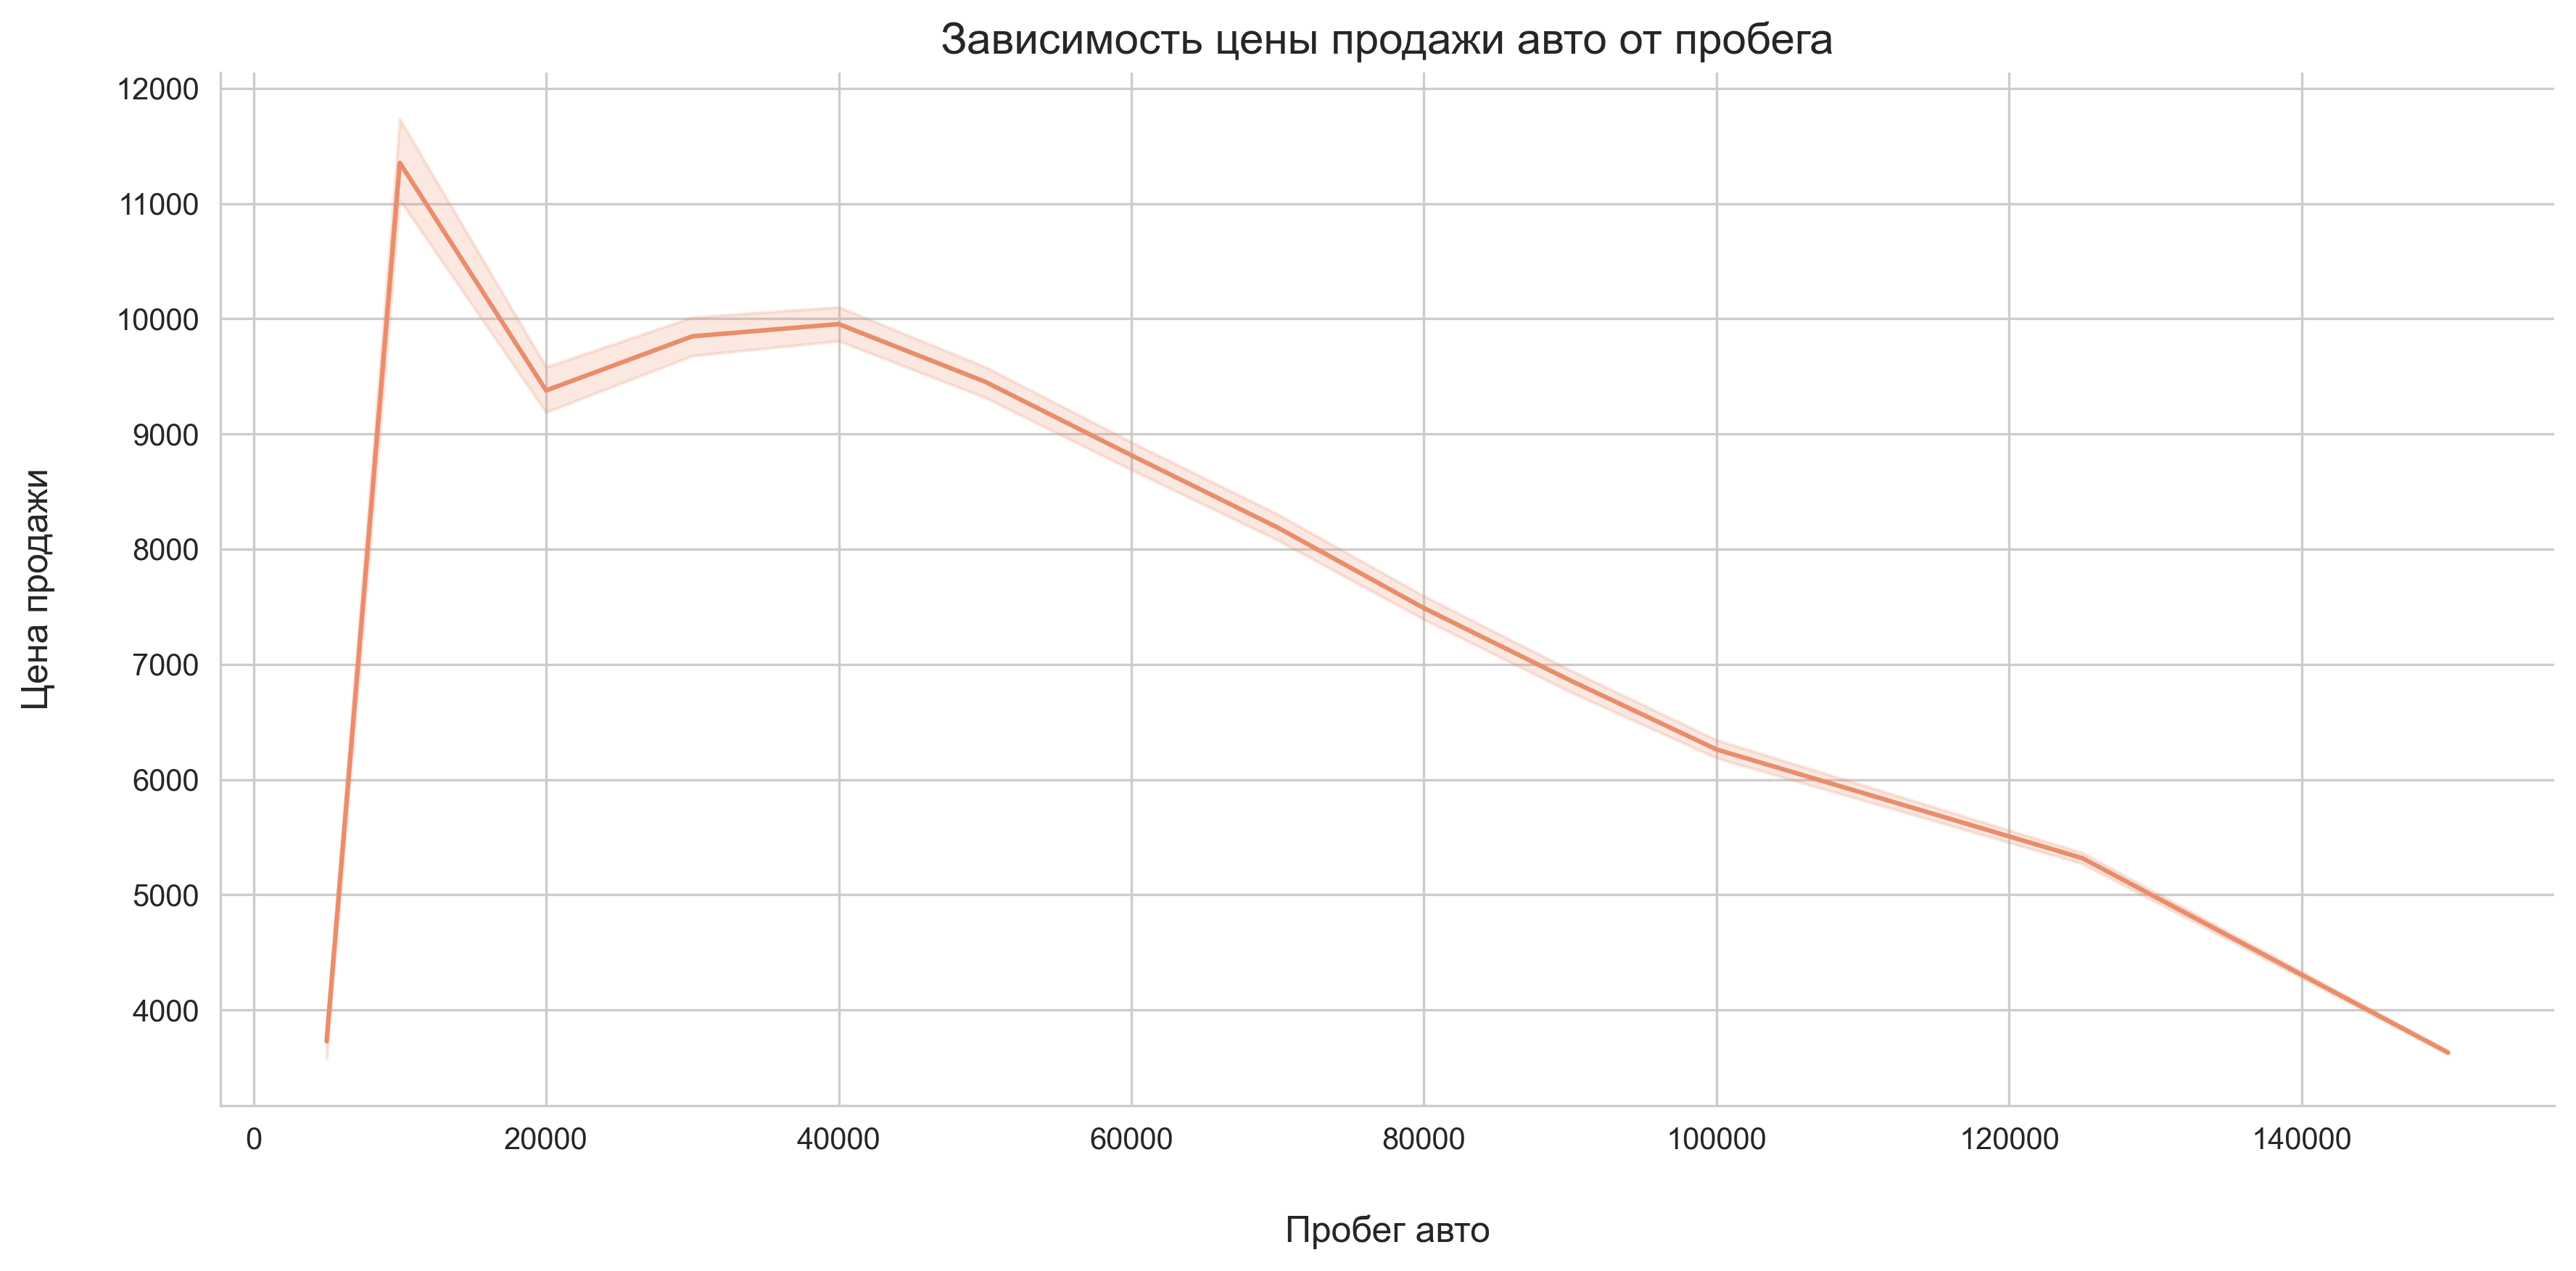

In [72]:
# строим график зависимости цены от пробега
sns.lineplot(data=data,x='kilometer', y='price')
plt.title('Зависимость цены продажи авто от пробега')
plt.xlabel('Пробег авто')
plt.ylabel('Цена продажи');

Мы видим явное падение цены с ростом пробега авто. «Американские горки» линии в начале графика сожно объяснить старыми авто, которые простояли на сохранении по какой-либо причине без ежедневной эксплуатации. Вполне возможно там есть ценные экземпляры, требующие восстановления. 

## Тип коробки передач

Коробка переключения передач — элемент трансмиссии автомобиля, который передает мощность от двигателя внутреннего сгорания на ведущие колеса, при этом расширяя диапазон частоты вращения и крутящего момента мотора. Этот узел отвечает за эффективную работу мотора, влияет на динамику движения и расход топлива.

В зависимости от степени участия водителя, «коробка» может быть с ручным управлением (механическая) или автоматическая, где выбор передачи выполняет электроника. К таким агрегатам, как правило, относят не только классическую гидромеханику, но также «роботов» и вариаторы. Отдельный класс — секвентальные коробки передач, которые чаще всего используют для гоночных автомобилей. Взглянем на уникальные значения и распределение признака `gearbox`.

In [73]:
# выводим уникальные значения
data['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

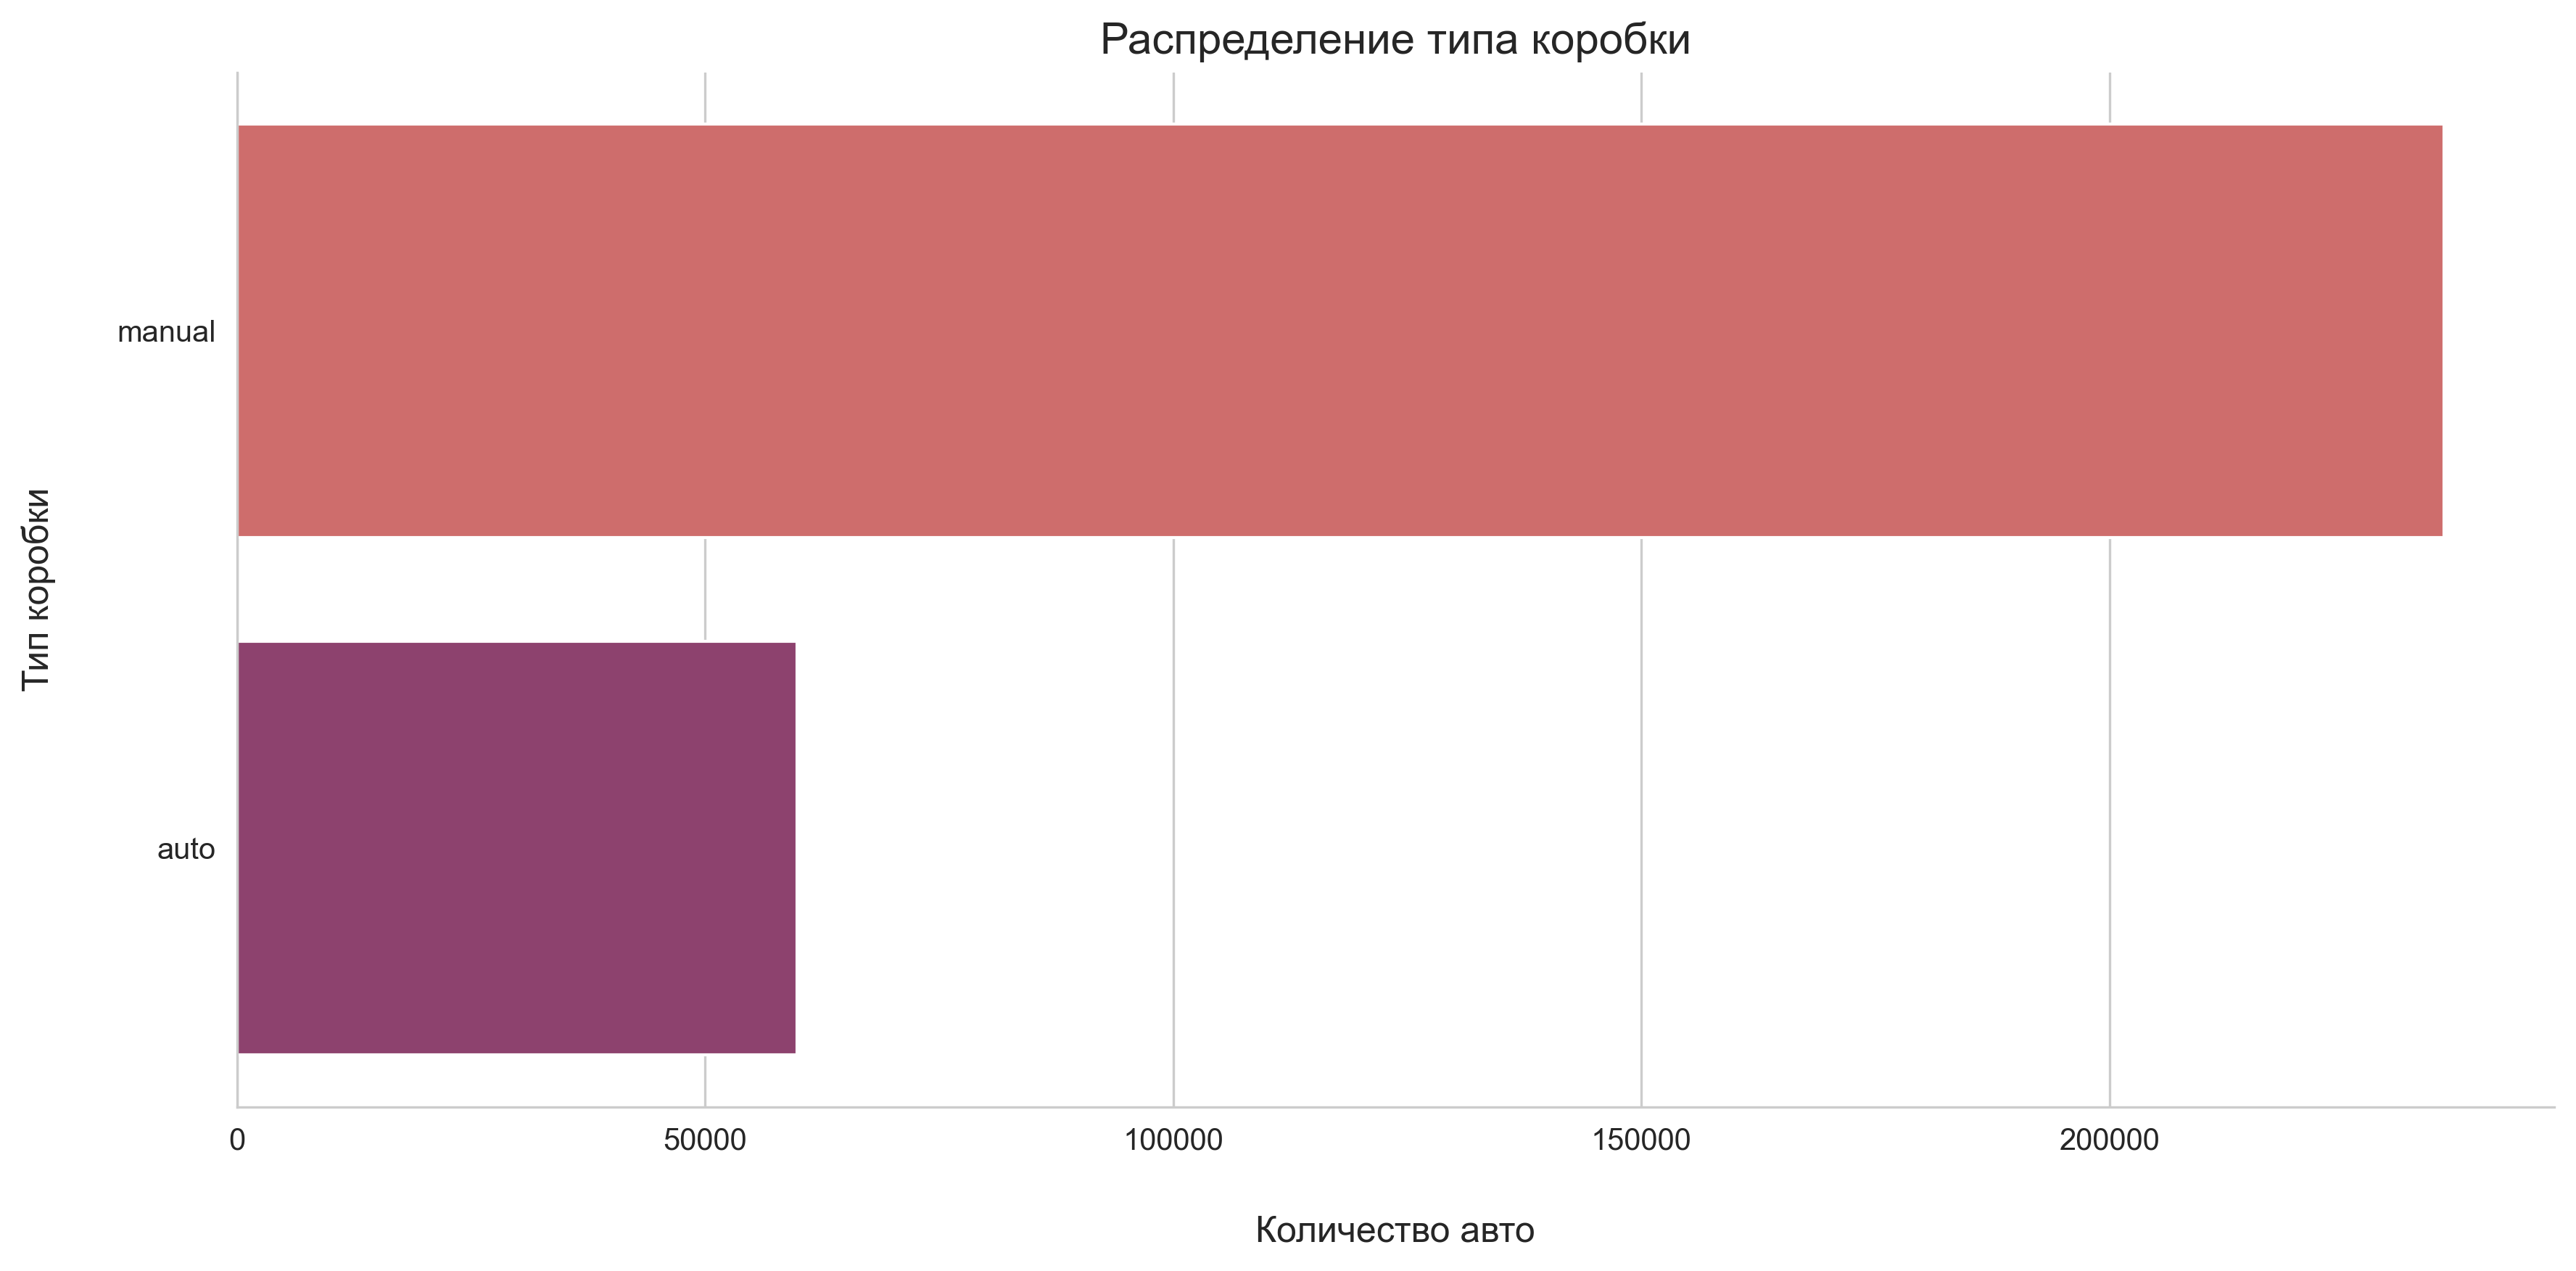

In [74]:
# строим диаграмму распределения
sns.countplot(y=data['gearbox'], palette='flare')
plt.title('Распределение типа коробки')
plt.xlabel('Количество авто')
plt.ylabel('Тип коробки');

В наших данных коробка разделяется на ручную и автоматическую. Ручной тип коробки распространён среди пользователей сервиса в четыре раза чаще. Подразумевается, что роботы и вариаторы вошли в категорию автоматики. Напомним, что мы рассматривем период c $1987$ года по $2016$ год. Первая [автоматическая коробка массового производства](https://ru.wikipedia.org/wiki/%D0%90%D0%B2%D1%82%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0_%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%87) появилась в $1940$ году, благодаря *General Motors*. Так что противоречий не наблюдается.

Рассматриваемый признак бинарный, его кодирование не принесёт нам в дальнейшем каких-либо проблем. Но в нём присутствуют пропущенные значения. Заполним их всё той же стратегией по группе с помощью нашей функции. Группировку выберем по *модели* и *году регистрации* авто. Но сначала рассмотрим зависимость цены продажи авто от его типа коробки передач.

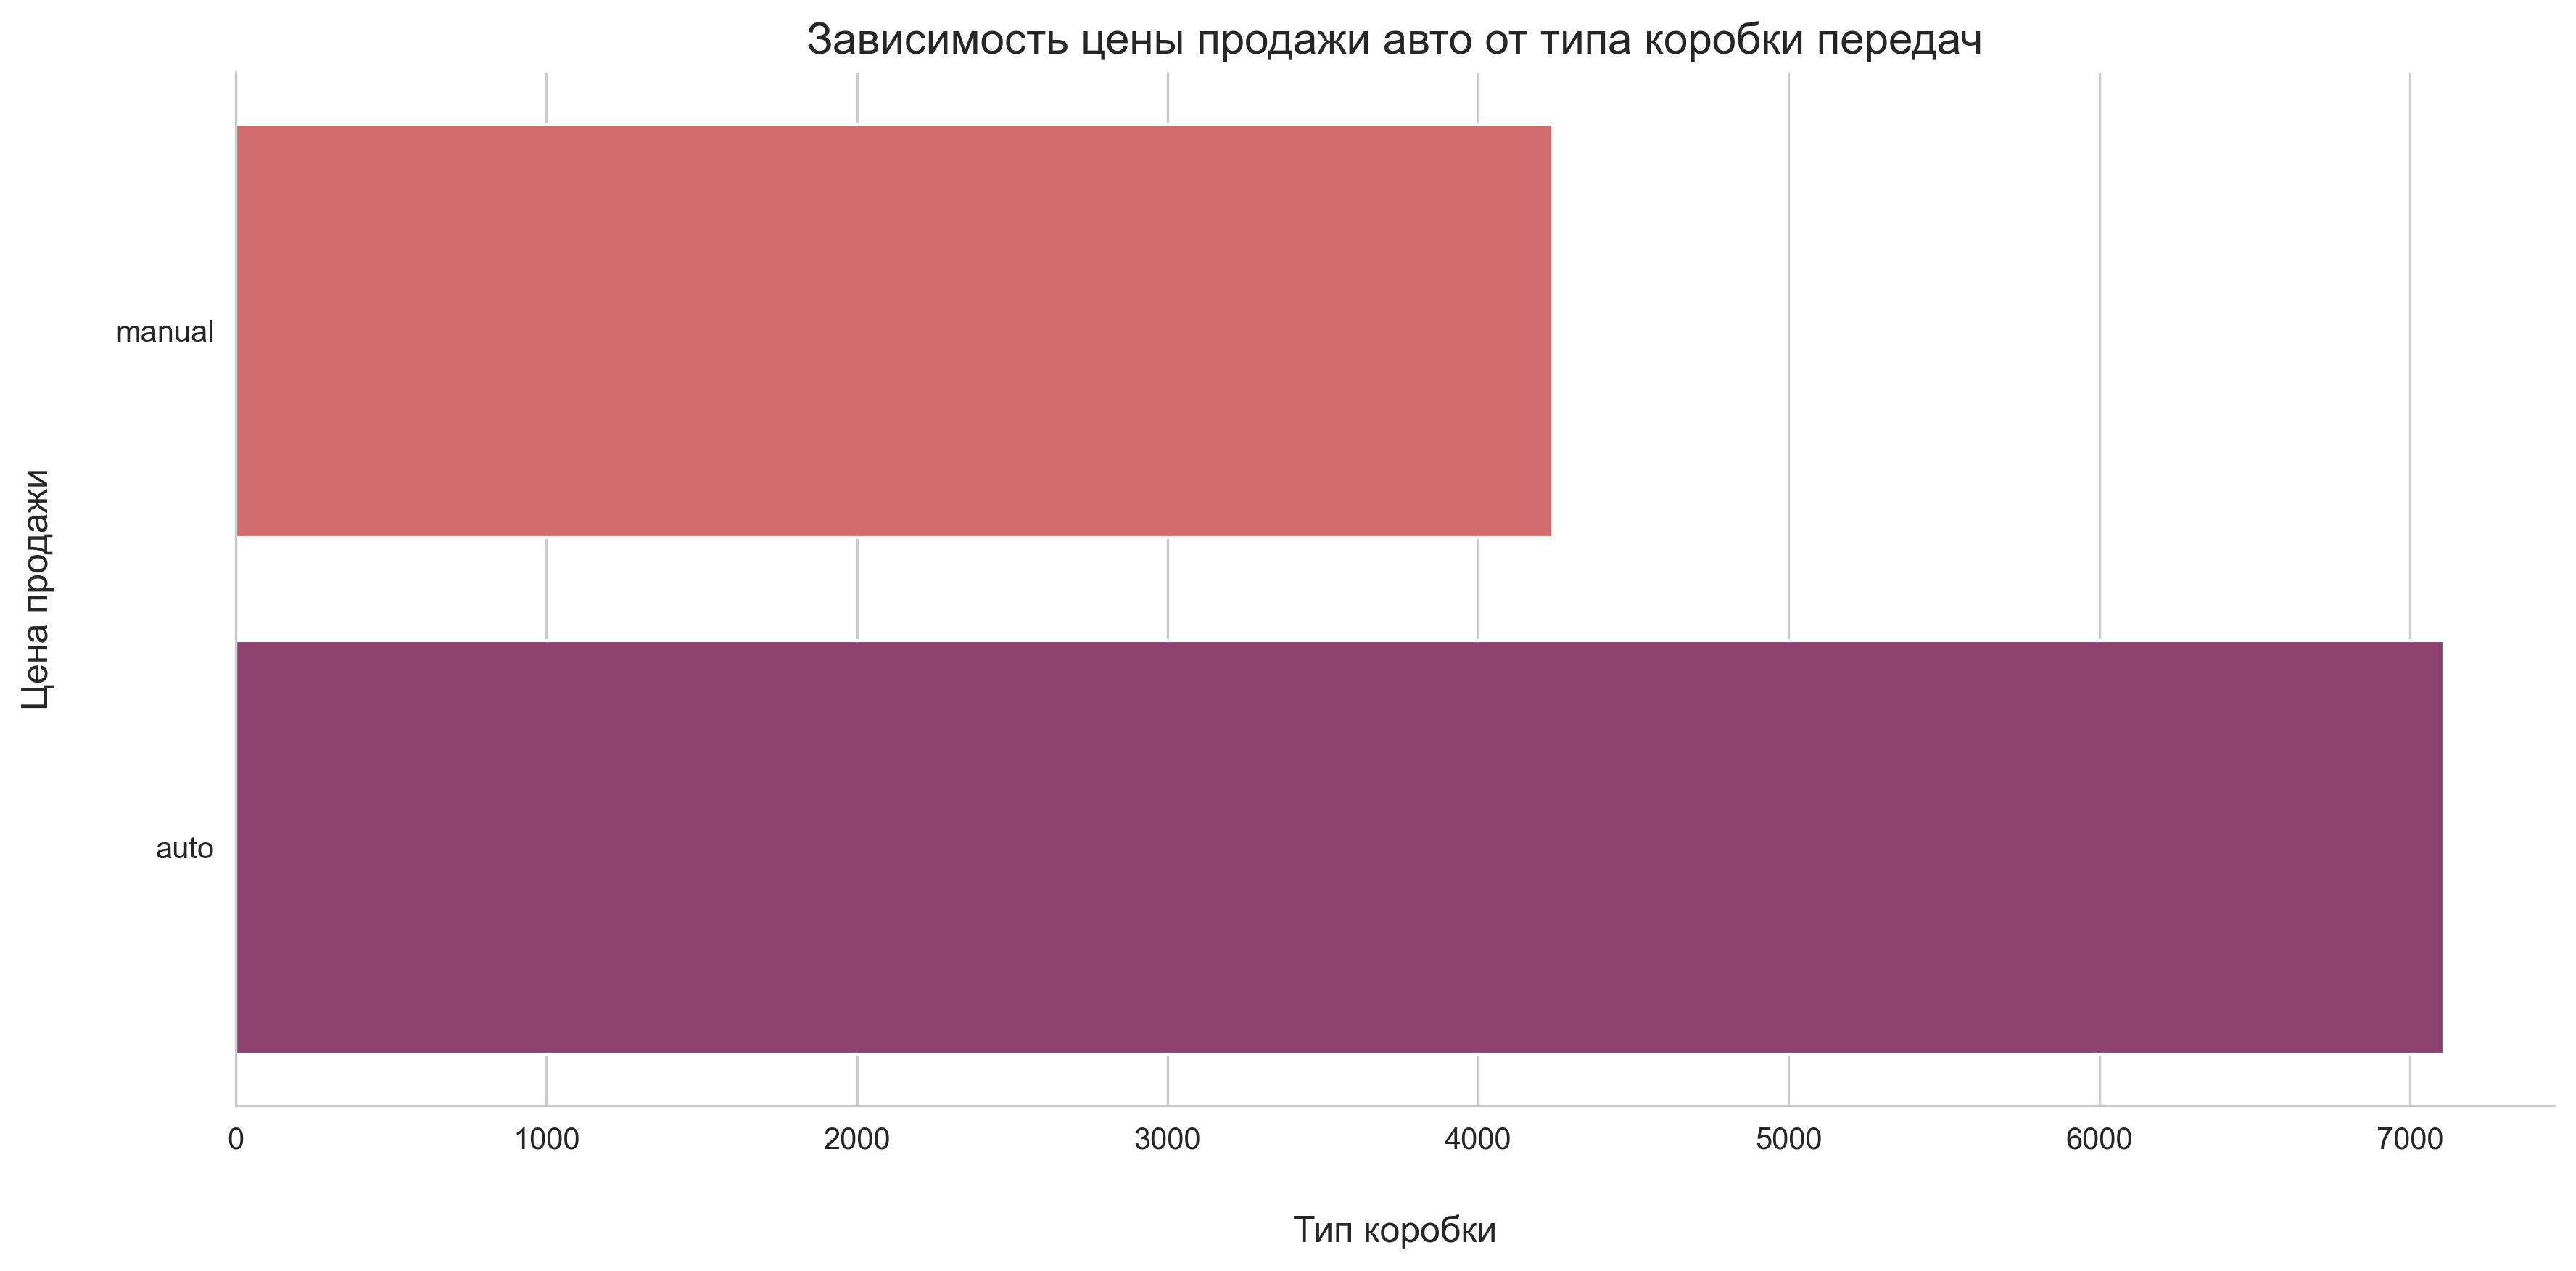

In [75]:
# считаем среднюю цену по типу коробки передач
g = data.groupby('gearbox')['price'].mean().sort_values()
# строим столбчатую диаграмму зависимости
sns.barplot(y=g.index, x=g, palette='flare')
plt.title('Зависимость цены продажи авто от типа коробки передач')
plt.xlabel('Тип коробки')
plt.ylabel('Цена продажи');

Средняя цена авто с ручной коробкой передач дешевле автомата больше чем на треть. Похоже что за удобства городского автомобиля надо платить. Теперь заполним пропуски вышеописанной стратегией.

In [76]:
# считаем количество пропусков
data['gearbox'].isna().sum()

11559

In [77]:
# заполняем пропуски в признаке
data['gearbox'] = groupby_fillna(data, ['model', 'registration_year'], 'gearbox')

150

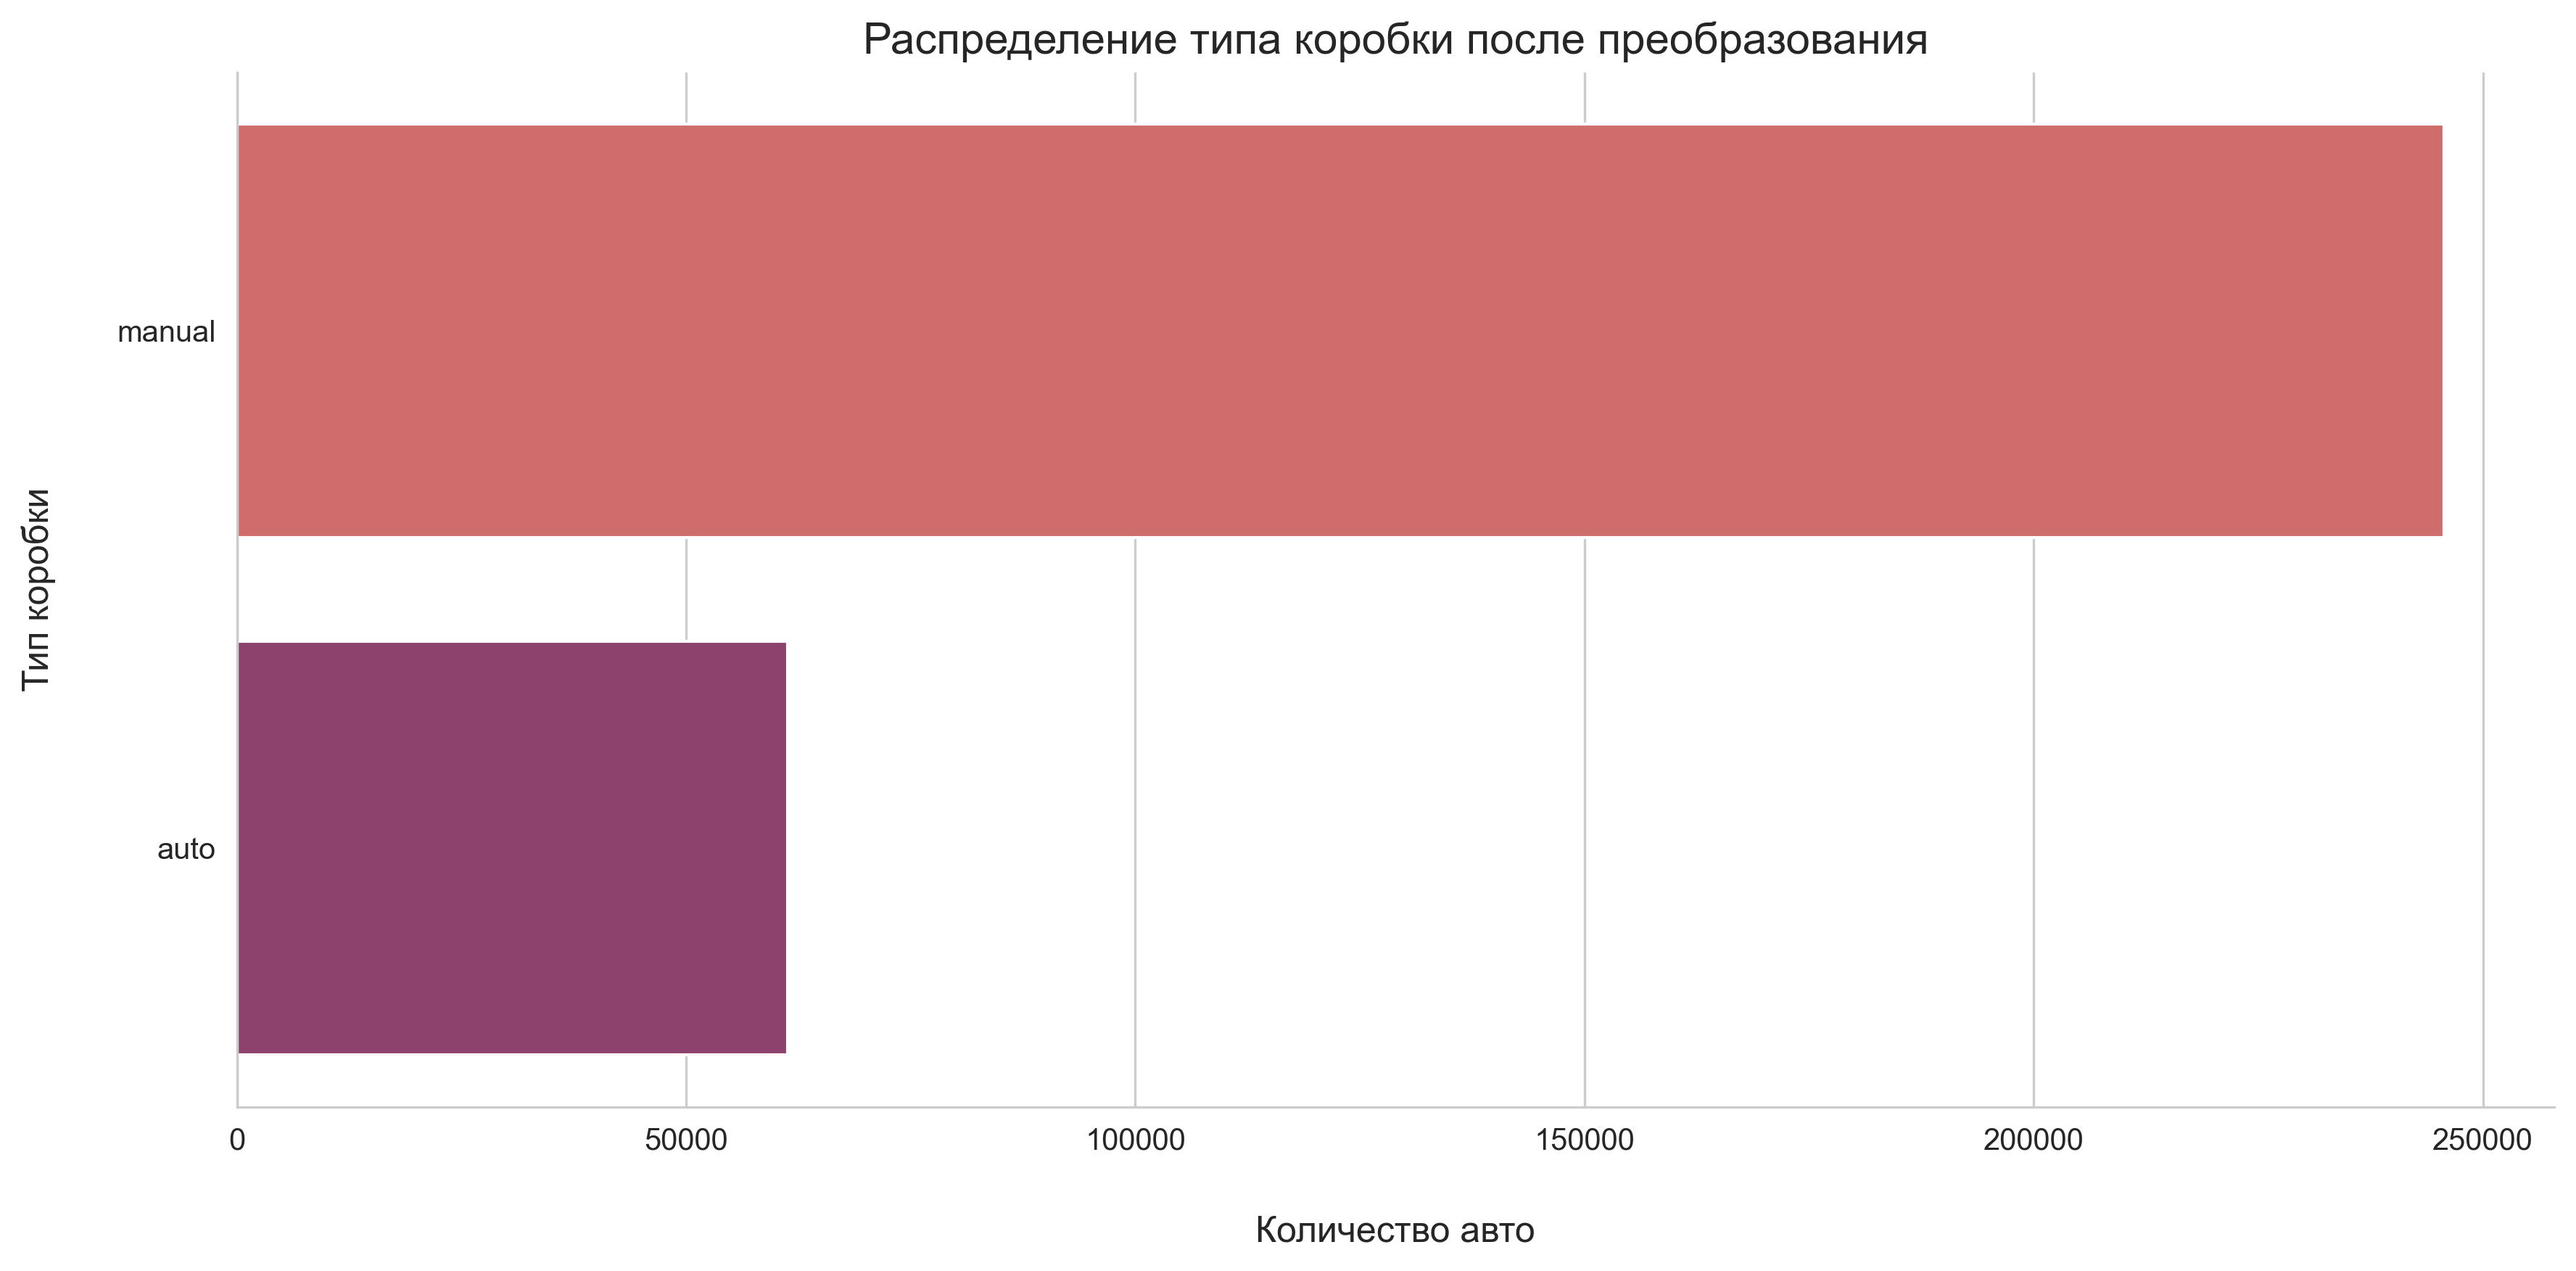

In [78]:
# проверяем распределение после преобразования
sns.countplot(y=data['gearbox'], palette='flare')
plt.title('Распределение типа коробки после преобразования')
plt.xlabel('Количество авто')
plt.ylabel('Тип коробки');

# считаем количество пропусков
data['gearbox'].isna().sum()

Распределение признака после преобразования не изменилось. Несколько пропусков нашей функции не удалось заполнить, их мы просто откинем. Сам признак добавим в список категориальных признаков. 

In [79]:
# удаляем оставшиеся пропуски
data.dropna(subset=['gearbox'], inplace=True)
# добавляем признак в список
cat_features.extend(['gearbox'])

## Была ли машина в ремонте

Все знают, что стоимость автомобиля после аварии, становится меньше даже при незначительных повреждениях. А что говорить о том, если авто пострадало существенно. Даже при небольших повреждениях корпуса автомобиля нарушается целостность лакокрасочного покрытия. И это уже снижает его стоимость, даже если ремонт был произведен качественно. Проверим это. 
* Узнаем какие значения содержит в себе признак `repaired`. На этапе обзора данных мы выяснили, что он по своему харакетру несёт логичесоке (булево) значение;
* После этого изучим как меняется цена в зависимости от этого признака.

In [80]:
# выводим уникальные значения
data['repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

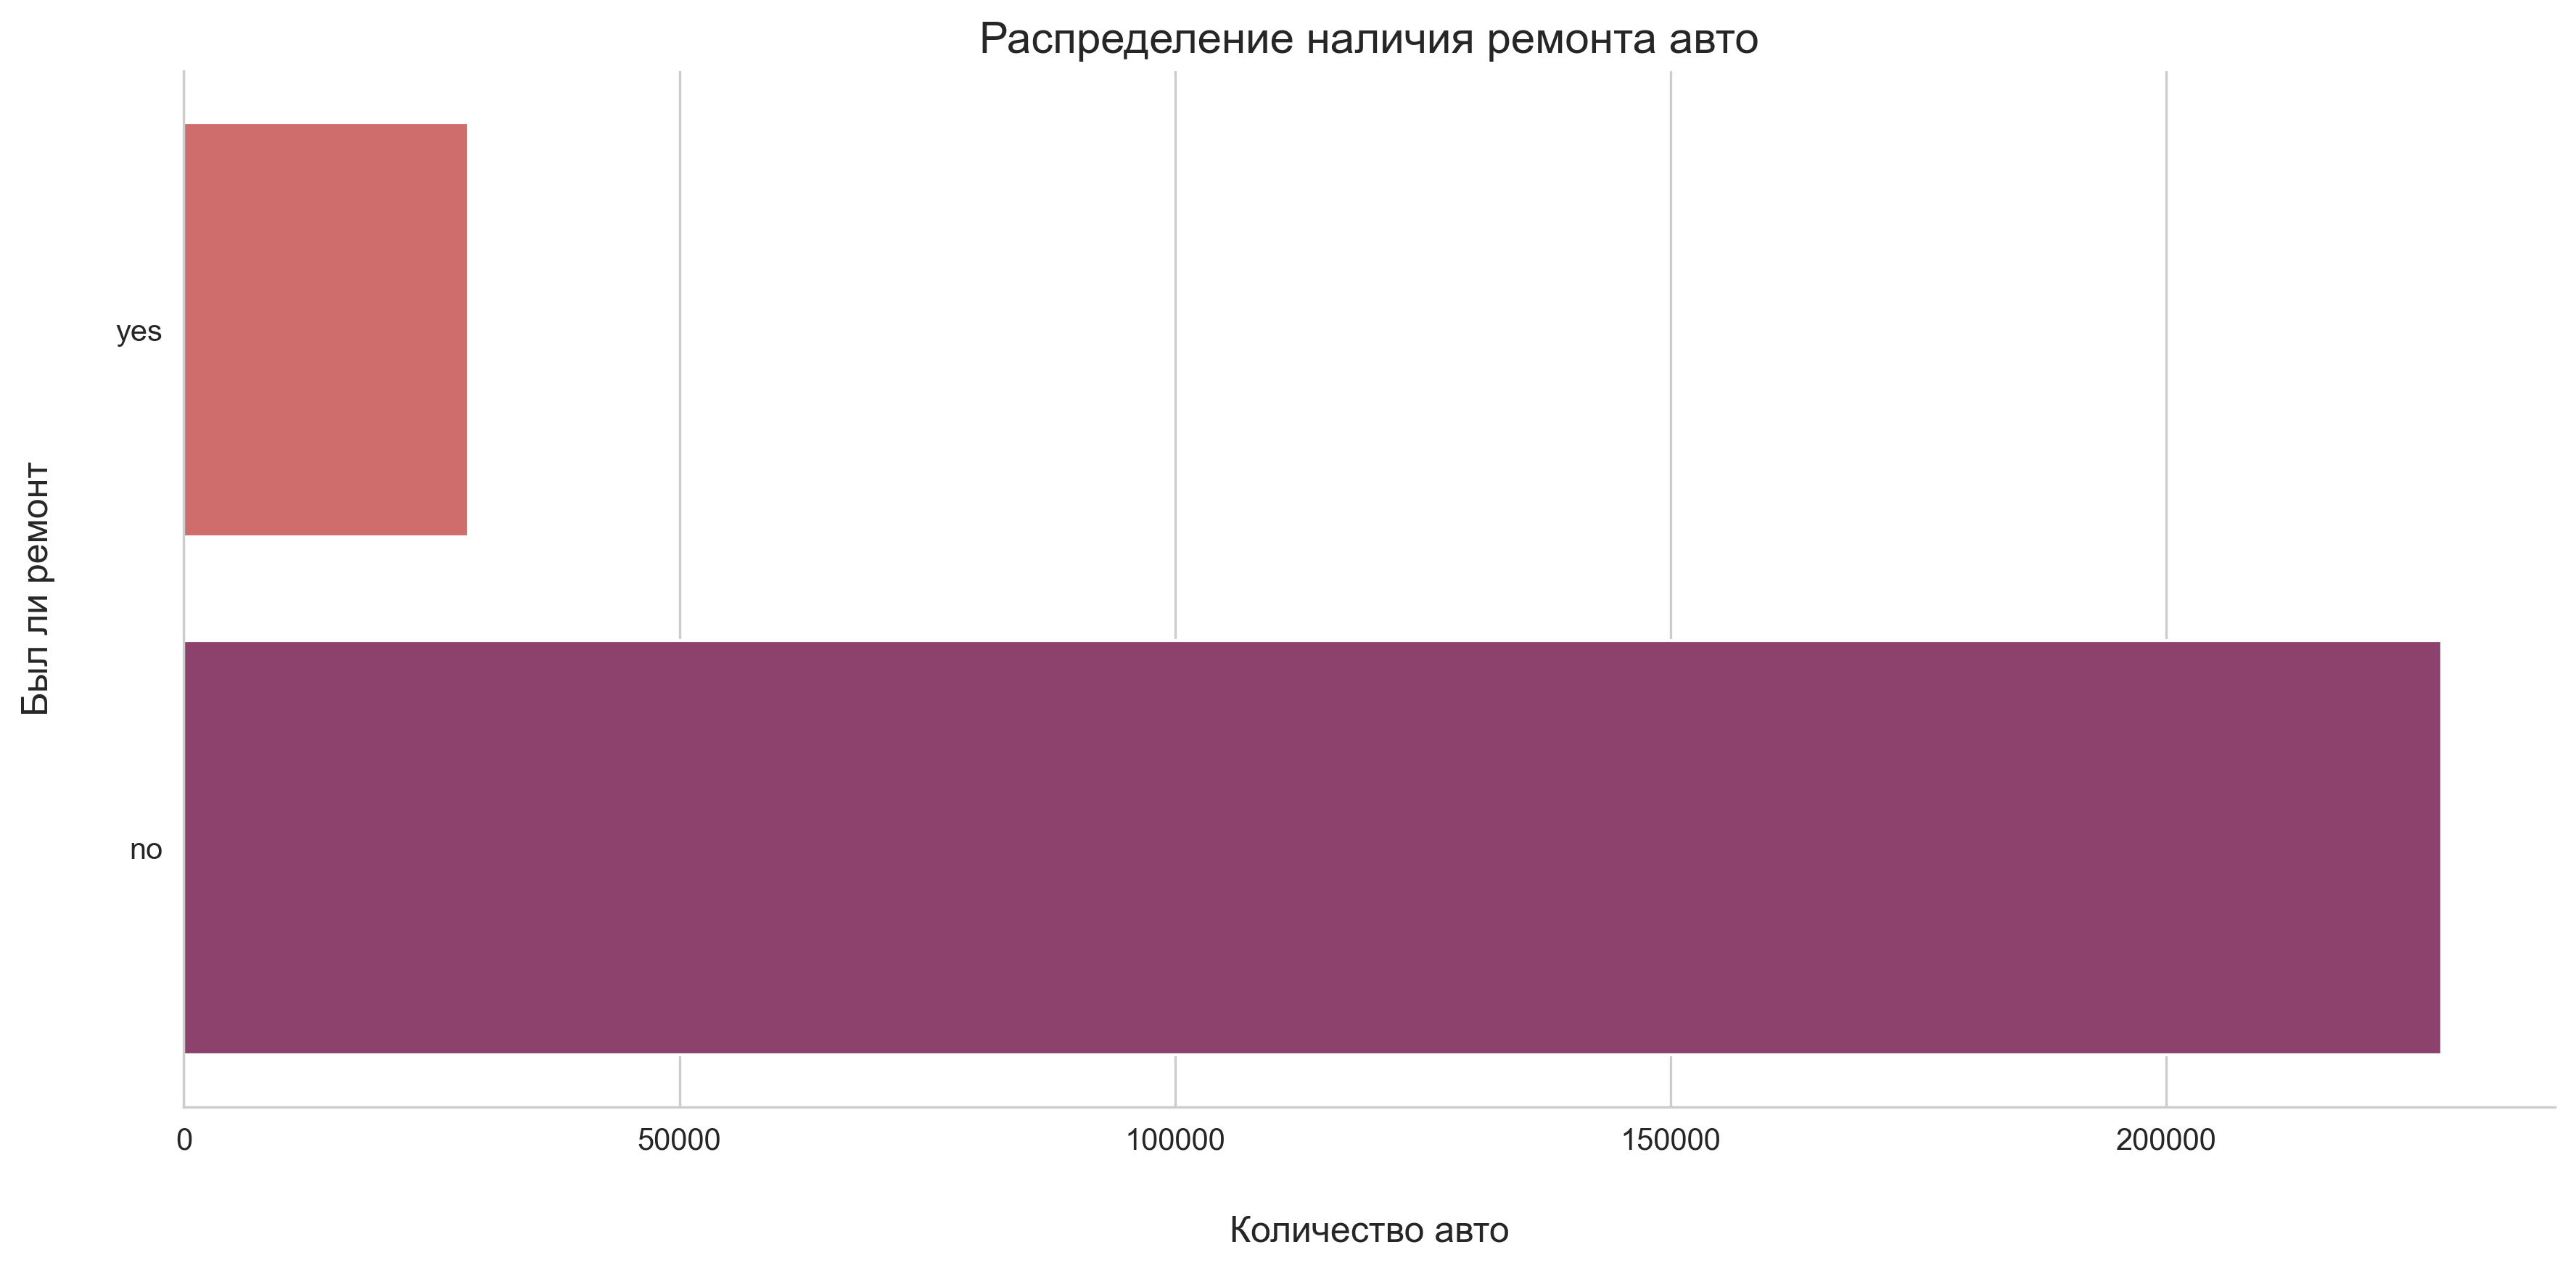

In [81]:
# строим диаграмму распределения
sns.countplot(y=data['repaired'],  palette='flare')
plt.title('Распределение наличия ремонта авто')
plt.xlabel('Количество авто')
plt.ylabel('Был ли ремонт');

Признак `repaired` принимает всего два значения — `yes` и `no` (к пропущенным значениям мы вернёмся позже), что можно расценивать как булевы значения. Небольшая часть автомобилей в наших данных подвергалась ремонту. К сожалению у нас нет подробностей того, что это мог быть за ремонт. Поэтому будем считать, что мелкий ремонт, такой как замена расходки, бокового стекла и прочее, сюда не относится. В таком случае царапина покрытия или деформация кузова должны сильно повлиять на цену продажи. Проверим это на пяти самых популярных моделях авто из 10 самых популярных брендов, которые есть в наших наблюдениях. Популярные бренды мы сохранили в `top_brands`. 

* Воспользуемся данной таблицей как фильтром для поиска популярных моделей;
* Возьмём топ пять и изучим их среднюю цену в разделении по признаку `repaired`. 

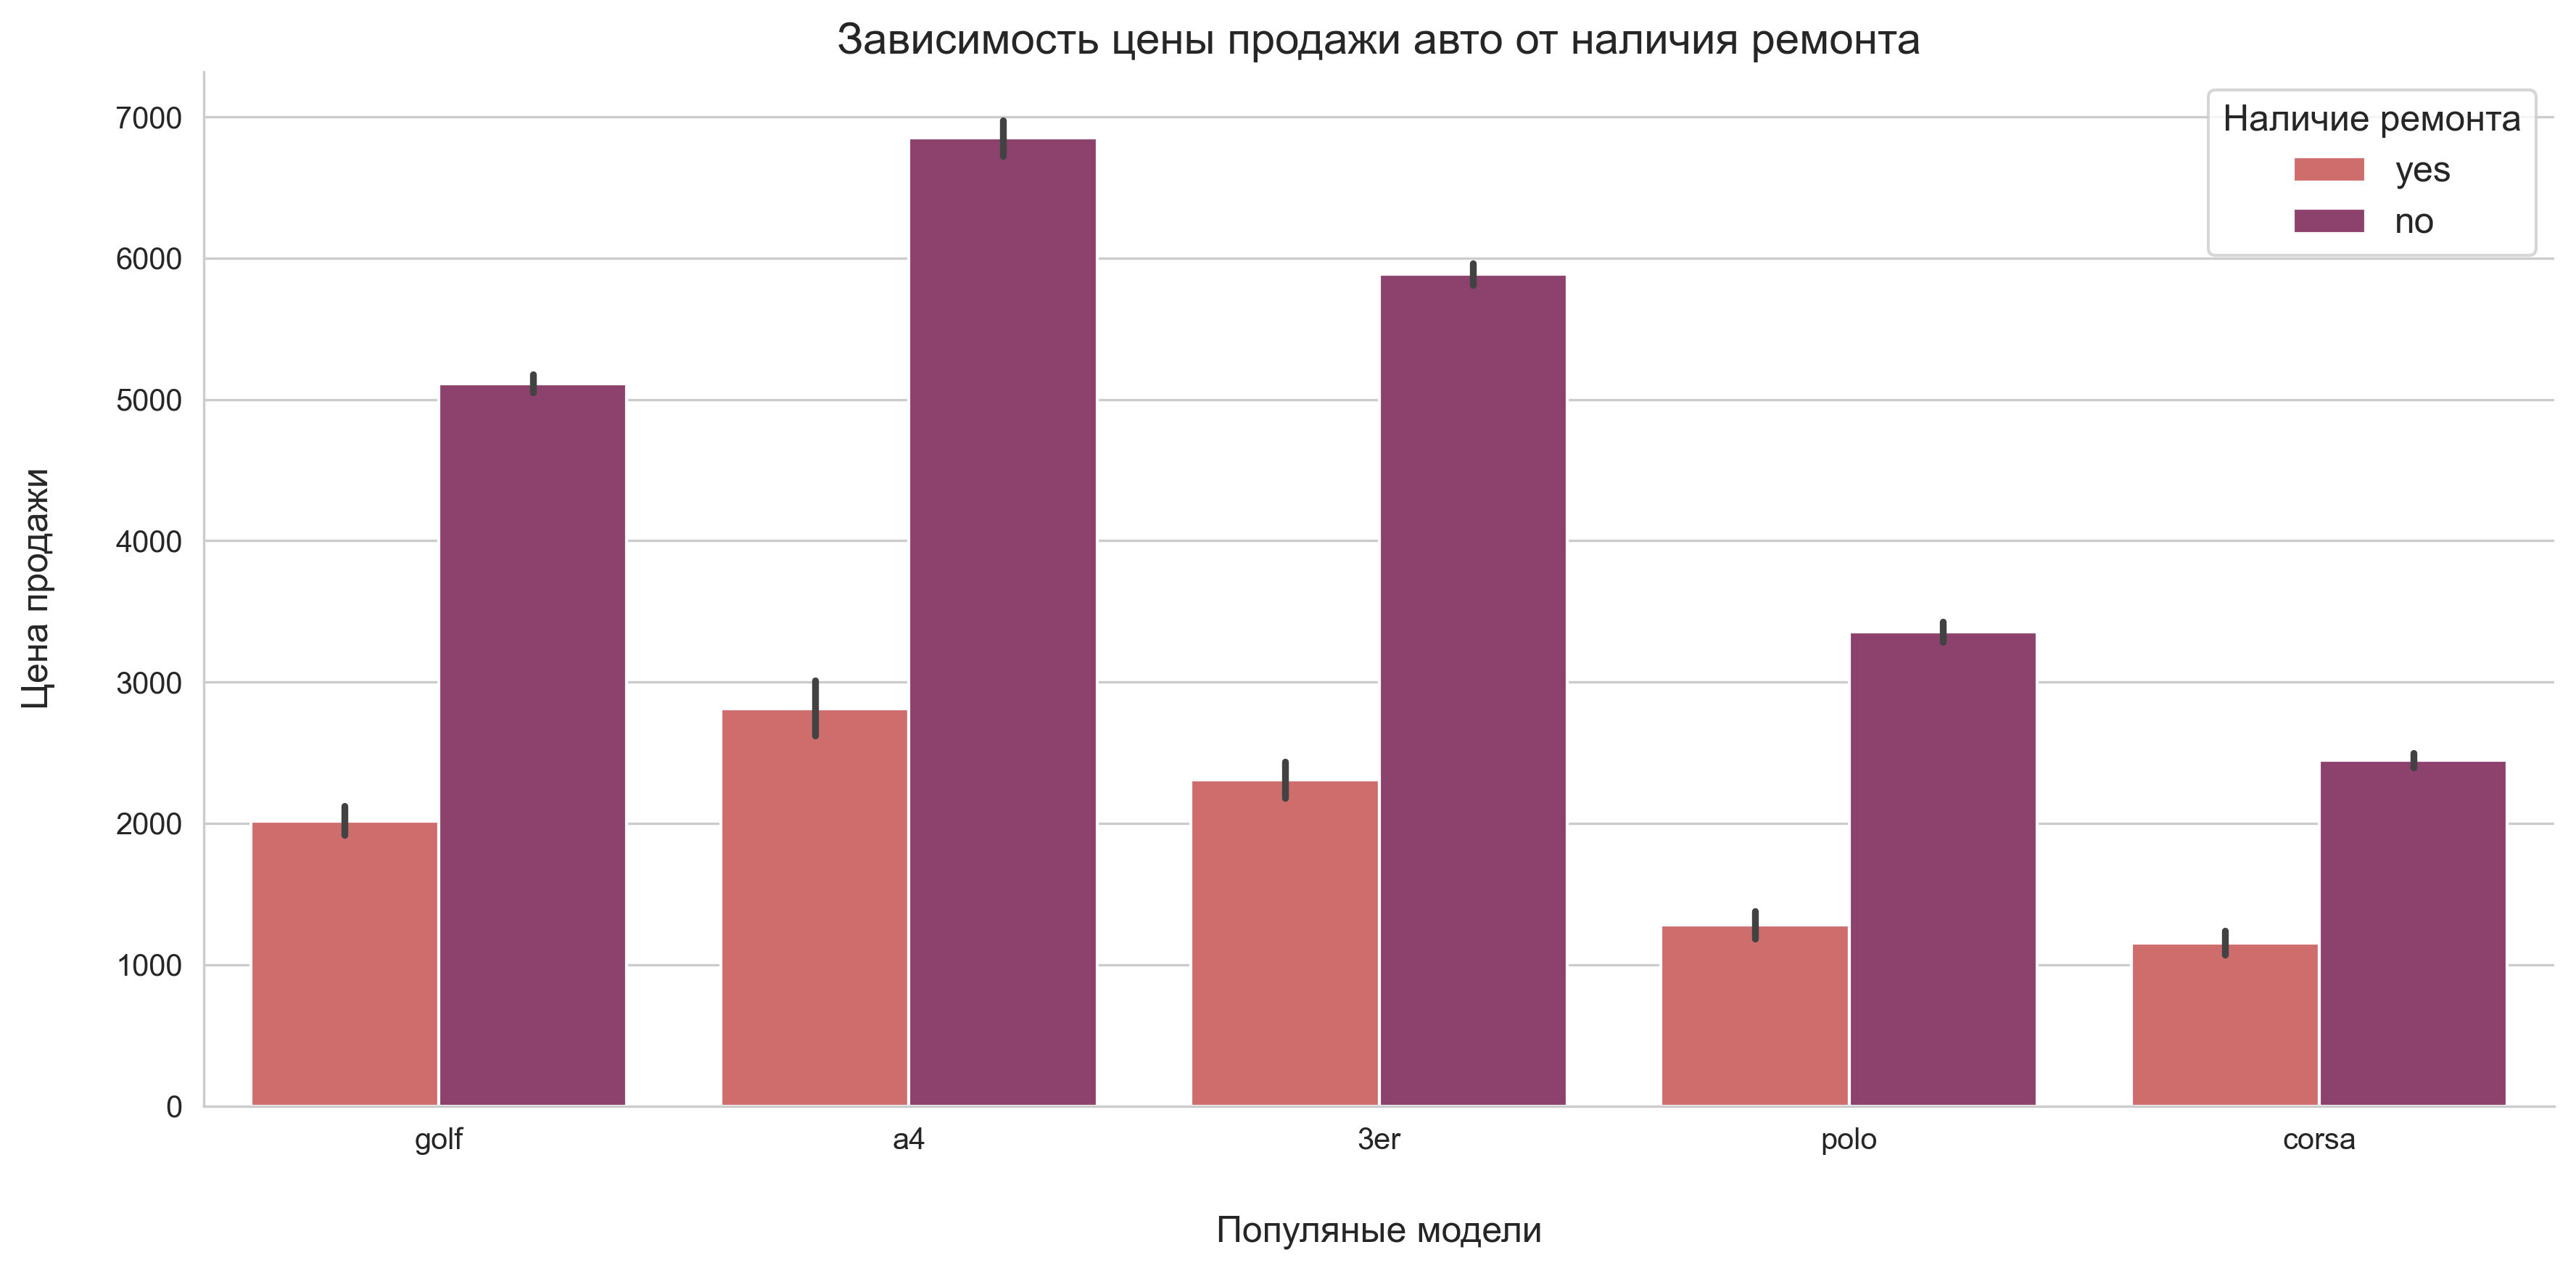

In [82]:
# получаем топ популярных моделей из самых популярных брендов
top_models = data.query('brand in @top_brands.index')['model'].value_counts().head()
# строим диаграмму зависимости цены от наличия ремонта этих моделей
sns.barplot(data=data.query('model in @top_models.index'), x='model', y='price', hue='repaired',  palette='flare')
plt.title('Зависимость цены продажи авто от наличия ремонта')
plt.xlabel('Популяные модели')
plt.ylabel('Цена продажи')
plt.legend(title='Наличие ремонта');

В пятерку популярных моделей попали автомобили таких брендов как `Volkswagen`, `BMW` и `Opel`. Цена продажи этих авто меняется в два раза в зависимости от наличия ремонта. «Битое» авто стоит значительно дешевле. На основании таких средних показаний самых частотных наблюдений мы подтверждаем мысль о том, что ремонт влияет на цену продажи авто.

Как мы уже увидели, в данном признаке присутствуют пропущенные значения. Учитывая тот факт, что анкету заполняет пользователь, есть высокая вероятность неслучайного возникновения пропуска в это признаке. Человек мог намеренно не указать наличие ремонта, с целью продать подороже. Мог произойти технический сбой при сборе данных или передаче. Другие признаки не дают какой-либо дополнительной информации о возможном ремонте, о его наличии может знать только сам владелец. Единственным решением для нас остается заполнить эти пропуски дополнительной категорией `undefined` — *не определено*. 

In [83]:
# заполняем пропуски в признаке
data['repaired'].fillna('undefined', inplace=True)
# поверяем результат
data['repaired'].unique()

array(['undefined', 'yes', 'no'], dtype=object)

Теперь этот признак уже не отнести к булевому из-за появившейся категории. Но он всё также остается категориальным. Добавим его в список категориальных признаков.

In [84]:
# добавляем признак в список
cat_features.extend(['repaired'])

## Мощность

Изобретенный более 100 лет назад поршневой двигатель внутреннего сгорания (ДВС), на сегодняшний день все еще является самым распространенным в автомобилестроении. ДВС можно оценить тремя основными показателями:

* мощность двигателя;
* крутящий момент;
* расход топлива.

В наших данных предствлена именно мощность, измеренная лошадиными силами. Это внесистемная единица мощности, официально [установленной](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D0%B6%D0%B4%D1%83%D0%BD%D0%B0%D1%80%D0%BE%D0%B4%D0%BD%D0%B0%D1%8F_%D1%81%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D0%B0_%D0%B5%D0%B4%D0%B8%D0%BD%D0%B8%D1%86) же единицей измерения мощности является *ватт*. Как правило, под *лошадиной* силой имеется в виду так называемая *метрическая лошадиная сила*, равная $735,49875$ ваттам. В автомобильной отрасли США и Великобритании *лошадиные силы* чаще до сих пор приравнивают к $745,69988145$ ватт, что равно $1,01386967887$ метрической лошадиной силы.

Логично было бы перевести занчения признака `power` в одну систему координат, в ватты, так как разная локация подразумевает разное понимание единицы *лошадиной силы*. Но как мы выяснили ранее, определение локации по почтовому индексу представляется неосуществимым. Значит, будем работать с тем, что есть. Для начала ознакомимся с расрпеделением значений.

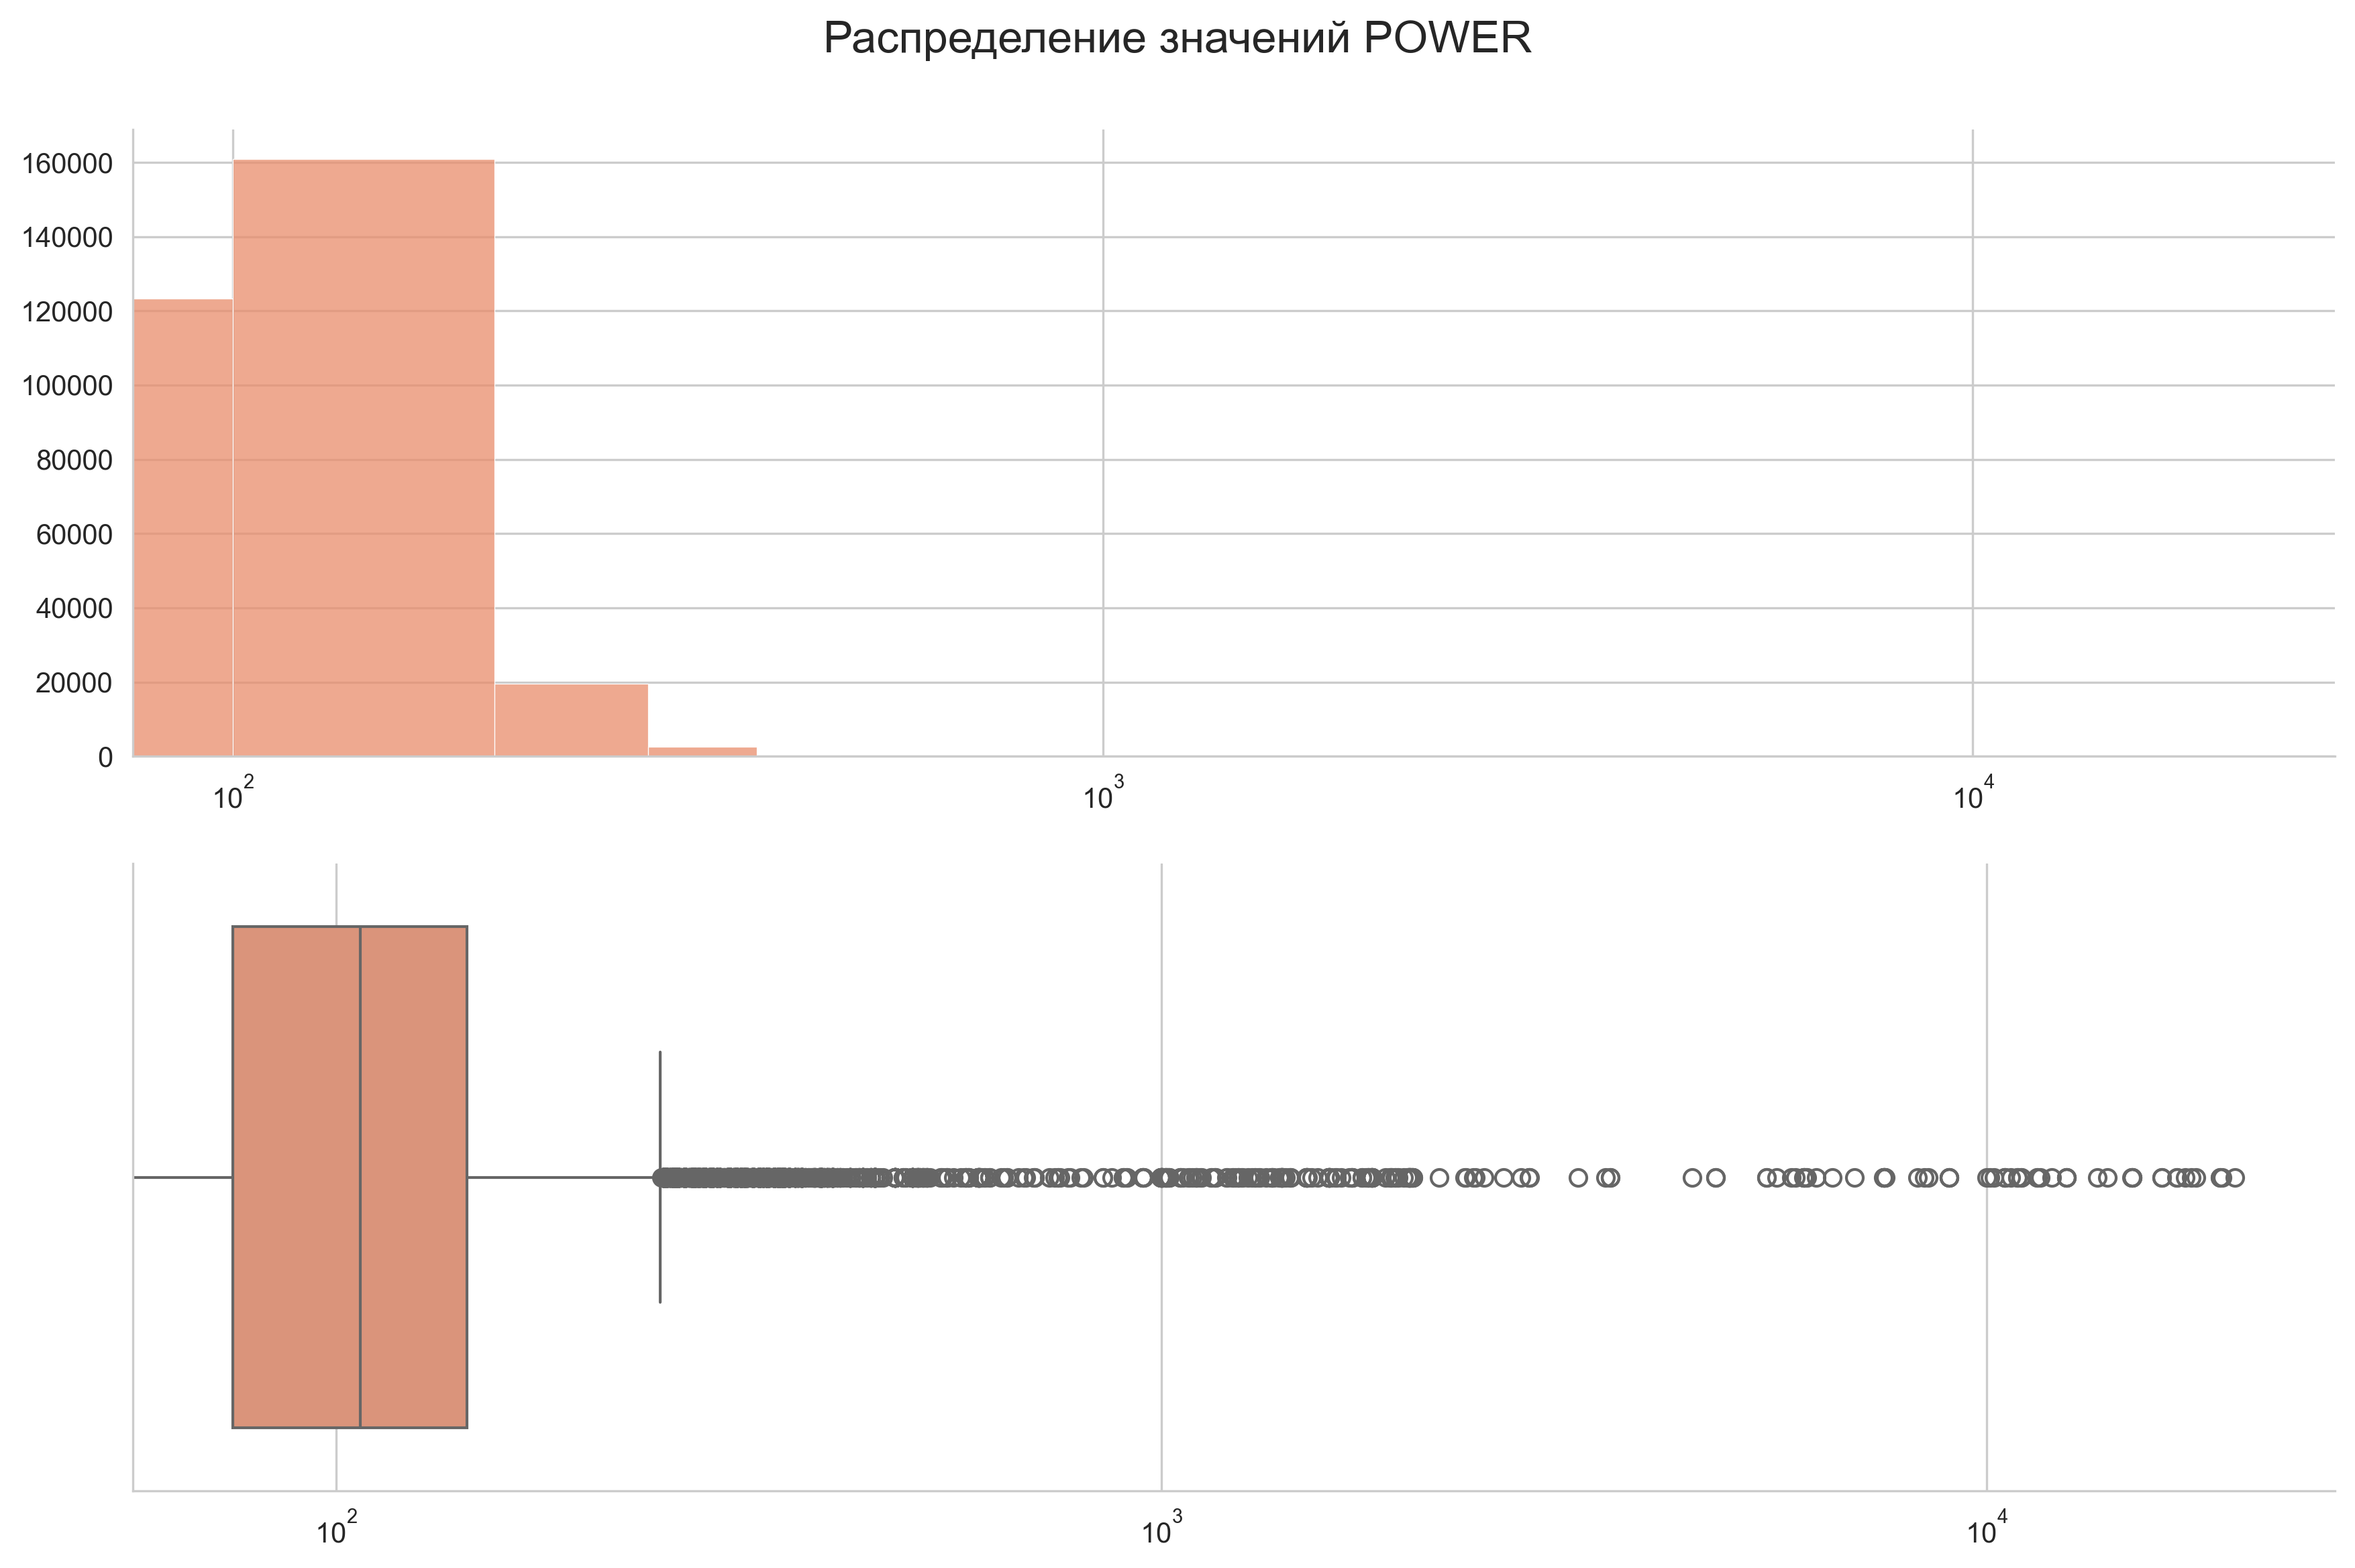

In [85]:
# вызываем функцию отрисовки распределений
get_distplots(data['power'], log_scale=True)

In [86]:
# получаем описательные статистики
data['power'].describe()

count    306978.00
mean        114.65
std         180.56
min           0.00
25%          75.00
50%         107.00
75%         144.00
max       20000.00
Name: power, dtype: float64

Межквартильный размах указывает на диапазон мощностей от $75$ до $144$, что выглядит вполне правдоподобно для машин повседневного пользования, всё таки не *NASCAR*. Меры центральной тенденции вполне соответствуют обычному городскому авто. Есть нулевые значения, спарва наблюдается очень длинный хвост значений, который можно охарактеризовать как выбросы. Вычислим полуторный межквартильный размах с помощью нашей самописной функции.  

In [87]:
# получаем границы полуторного межквартильного размаха
lower_bound, upper_bound = get_outlier_bounds(data['power'], display=True)

------------------------------------------
Первый квартиль: 75.0
------------------------------------------
Третий квартиль: 144.0
------------------------------------------
Межквартильный размах: 69.0
------------------------------------------
Нижняя граница 1.5(IQR): -28.5
------------------------------------------
Верхняя граница 1.5(IQR): 247.5
------------------------------------------


Верхняя граница выбросов определена как $247.5$ л.с. Согласно [вот этому обзору](https://quto.ru/journal/articles/kak-menyalas-srednyaya-moshnost-avtomobilei-za-vremya-sushestvovaniya-industrii.htm) к концу второй декады ($2010-2020$ года) мощность в $400$ л.с. в мощных автомобилях уже не была чем-то необычным, а *Mustang GT* достигал $460$ л.с. В $2000$-х годах *Koenigsegg* и *Bugatti* выжимали из своих гиперкаров $1500$ л.с. Однако средняя мощность составляла около $200$ л.с. Изучим, что находится за пределами верхней границы. 

In [88]:
# фильтруем данные относительно верхней границы 
data.query('power > 247.5').head(10)

date_crawled  price vehicle_type  registration_year gearbox  power  \
41  2016-03-30 20:38:20   7500        sedan               2002    auto    306   
113 2016-03-20 18:38:02   6300        sedan               2002  manual    265   
125 2016-03-11 20:55:37   1800        sedan               1995    auto    286   
172 2016-03-07 12:38:19  19750  convertible               2006  manual    305   
190 2016-03-08 21:52:34  11299        sedan               2006    auto    250   
204 2016-03-31 12:58:26  18400        wagon               2011    auto    313   
210 2016-04-05 11:48:01  14900        sedan               2007  manual    265   
250 2016-03-16 19:49:49   6799        sedan               2002    auto    286   
278 2016-03-17 22:52:09   6000        coupe               1995  manual    286   
313 2016-03-05 19:47:47  16500        coupe               2007  manual    265   

        model  kilometer  registration_month fuel_type          brand  \
41   e_klasse     150000                   4  gasoline  mercedes_benz   
113      golf     150000                   3  gasoline     volkswagen   
125       7er     150000                  12  gasoline            bmw   
172   mustang      50000                   7  gasoline           ford   
190      golf     150000                   8  gasoline     volkswagen   
204       5er     150000                  11  gasoline            bmw   
210       1er     150000                  10  gasoline            bmw   
250       5er     150000                   2       gas            bmw   
278     other     150000                   4  gasoline     mitsubishi   
313   z_reihe     150000                   3  gasoline            bmw   

      repaired date_created  number_of_pictures  postal_code  \
41   undefined   2016-03-30                   0        33649   
113         no   2016-03-20                   0        56759   
125        yes   2016-03-11                   0        77866   
172         no   2016-03-07                   0        38350   
190         no   2016-03-08                   0        22083   
204         no   2016-03-31                   0        52477   
210         no   2016-04-05                   0        14129   
250         no   2016-03-16                   0        41836   
278         no   2016-03-17                   0        36093   
313         no   2016-03-05                   0        71083   

              last_seen  age  
41  2016-04-03 11:44:49   14  
113 2016-04-07 01:45:06   14  
125 2016-03-20 10:17:59   21  
172 2016-03-12 20:18:29   10  
190 2016-03-19 09:46:58   10  
204 2016-03-31 13:44:44    5  
210 2016-04-05 11:48:01    9  
250 2016-04-07 05:16:57   14  
278 2016-04-05 18:45:15   21  
313 2016-04-07 12:17:24    9

В первой десятке наблюдаются мощные авто известных брендов, способных выдавать мощность выше $247.5$ л. c. Всё соответствует действительности. Согласно сводной таблице самых мощных авто из [Википедии](https/en.wikipedia.org/wiki/List_of_production_cars_by_power_output), на момент $2016$ года лидером был *Koenigsegg Regera* ($1500$ л. с.). Ограничимся диапазоном $500-1500$ и посмотрим какие авто там присутствуют.

In [89]:
# индексируемся на диапазон самых мощных авто
data.loc[(data['power'] > 500) & (data['power'] < 1500), 'model'].value_counts()

model
other          23
golf           12
m_reihe         9
3er             8
corsa           8
e_klasse        8
polo            6
cayenne         5
twingo          5
astra           5
s_klasse        4
a_klasse        4
matiz           4
fiesta          4
passat          4
a6              3
transporter     3
focus           3
vectra          3
3_reihe         3
civic           3
ypsilon         3
micra           3
ka              3
s_type          3
c4              2
touran          2
500             2
punto           2
lupo            2
2_reihe         2
galaxy          2
c2              2
m_klasse        2
arosa           2
c_klasse        2
scenic          2
a4              2
zafira          2
v40             2
a8              2
yaris           1
cl              1
kangoo          1
forfour         1
berlingo        1
5er             1
corolla         1
sharan          1
mustang         1
outlander       1
fortwo          1
clk             1
mondeo          1
1er             1
6_re

Ни одна представленная модель не может иметь такой мощности, потому что исторически они имеют совершенно другой класс. Исключением может быть категория `other`, которая нам ни о чём не говорит. Смело можем удалять данные выше $500$ л. с.

Что же касается нижней границы *мощности*, то как правило городские автомобили, предназначенные для повседневного использования, имеют нижнюю границу в $40$ л. с. и классифицируются как маломощные. Взглянем на распределение.

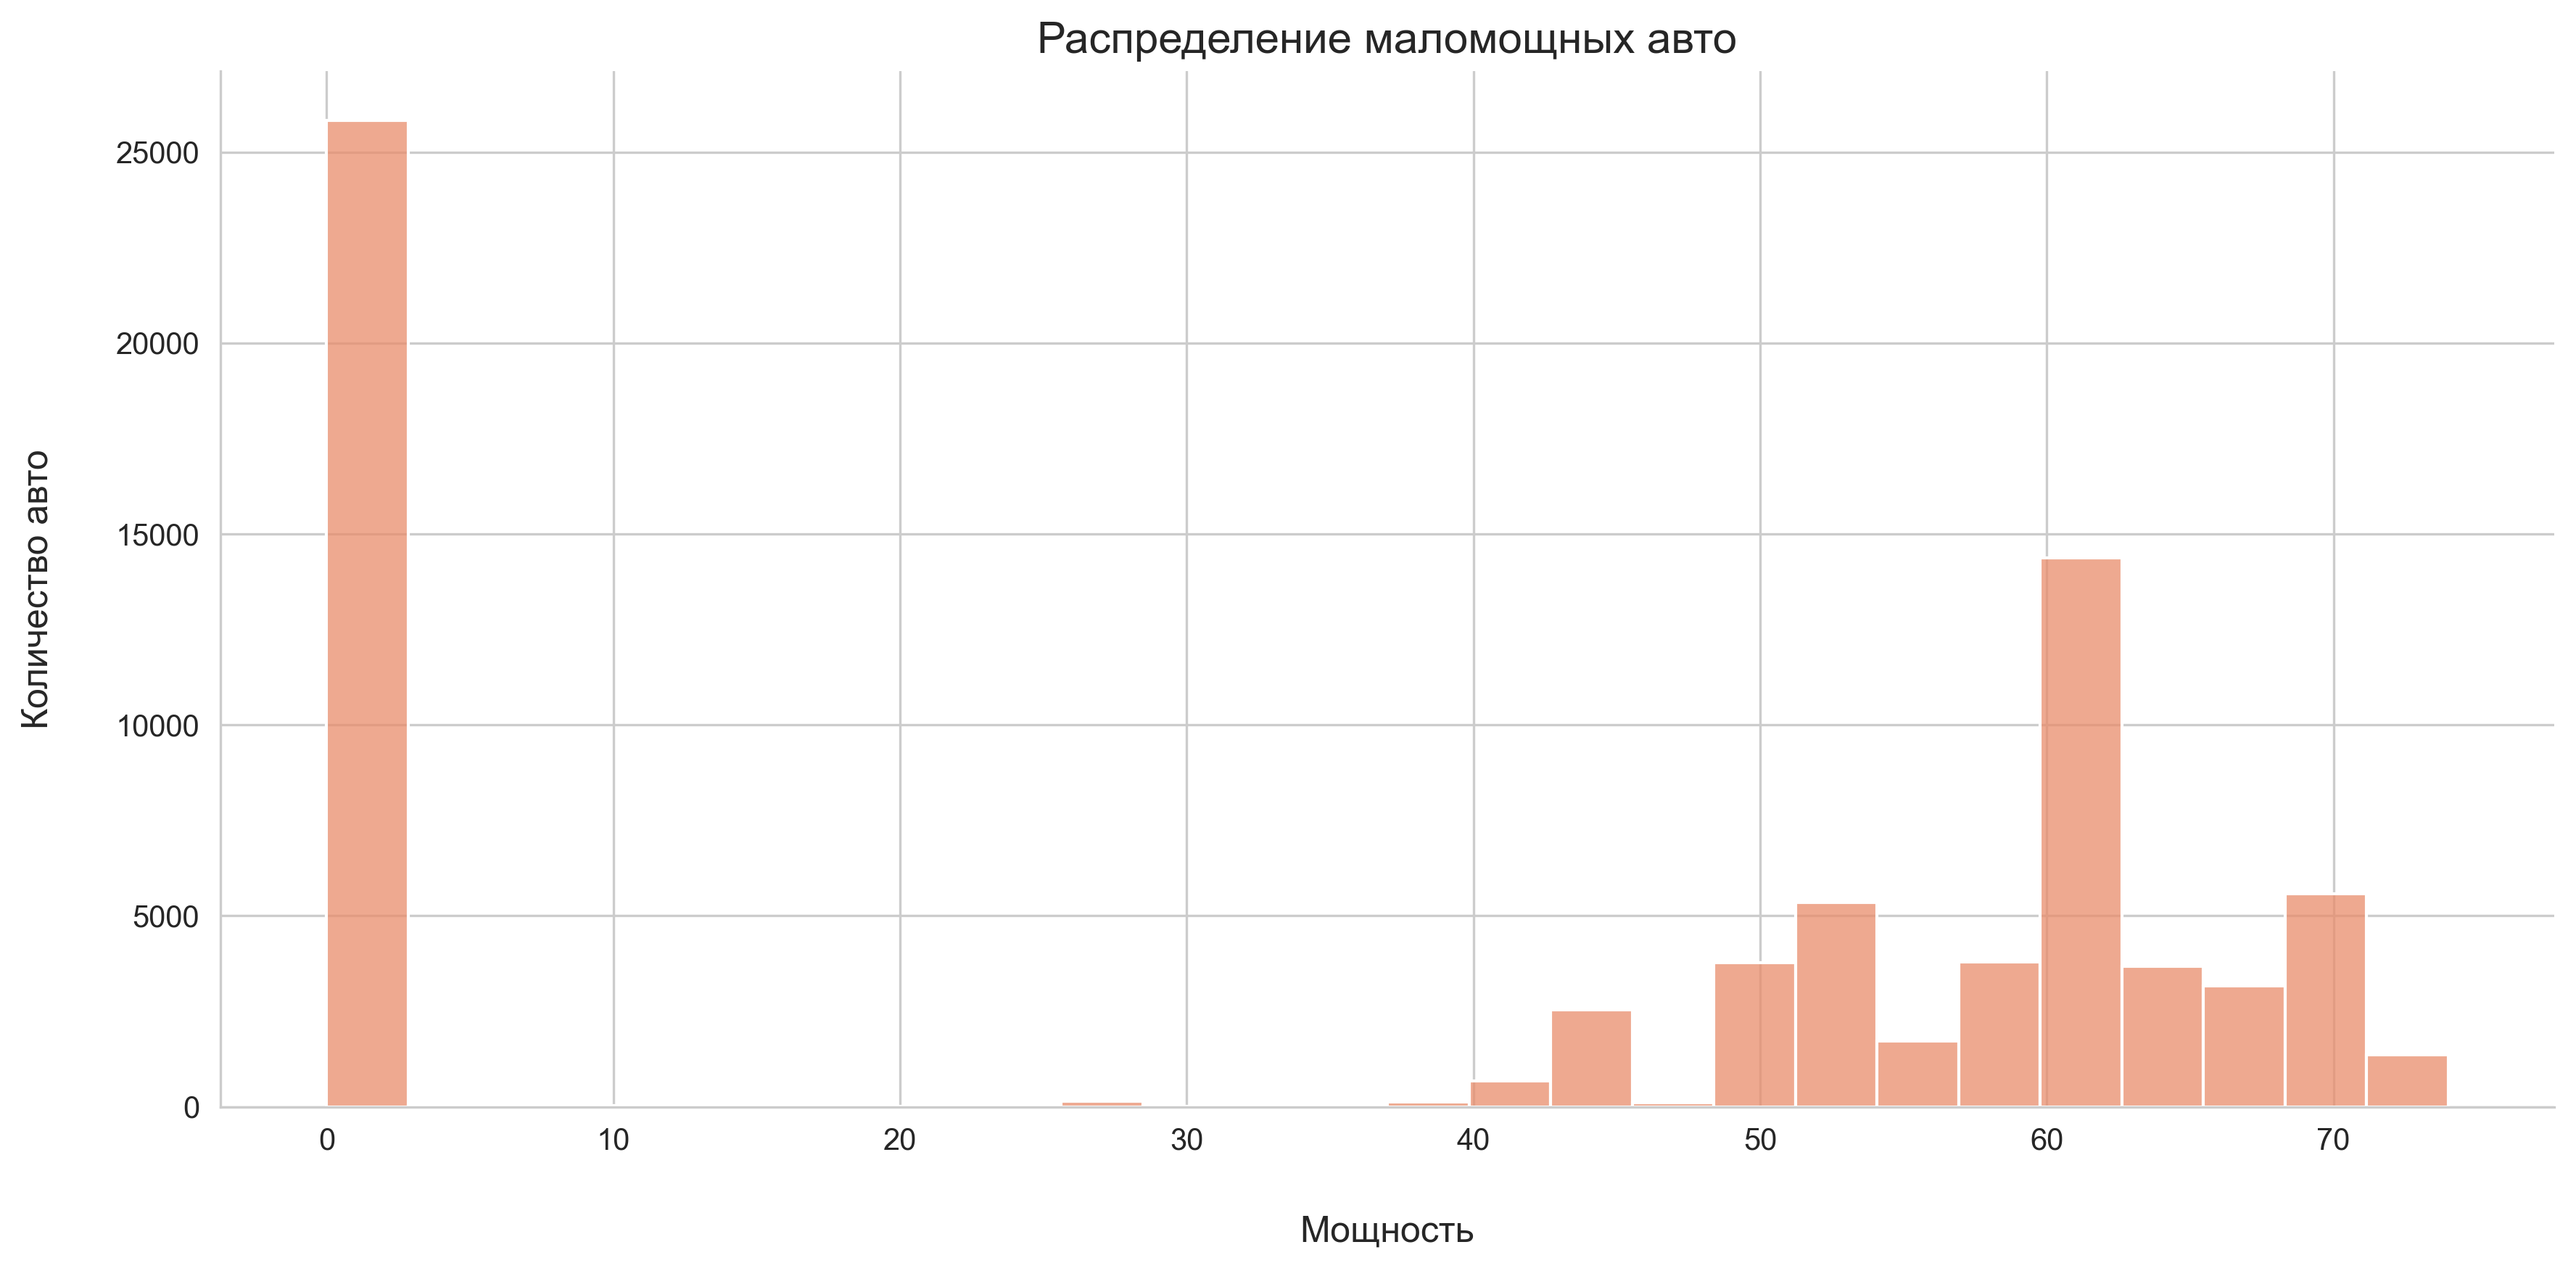

In [90]:
# строим расрпделение маломощных авто
sns.histplot(x=data.query('power < 75')['power'])
plt.title('Распределение маломощных авто')
plt.xlabel('Мощность')
plt.ylabel('Количество авто');

Мы видим, что меньше $40$ л. с. есть низкочастотные наблюдения. Околонулевые значения — $25000$ наблюдений. Что это? Кузов с колёсами? Нет двигателя — нет мощности? Пользователь не заполнил поле мощности и ему было присвоено нулевое значение? Как бы там ни было эти значения аномальны. Если это действительно техническая особенность процесса сбора данных, то разработчикам следует об этом задуматься. Если релизная модель встретит такие данные, она выдаст некорректный результат. Такие моменты необходимо отлавливать на стороне клиента сервиса. А пока избавимся от этих значений, также как и от верхней границы *мощности*.

In [91]:
# отсекаем выбросы и аномальные значения мощности
data = data.loc[(data['power'] < 500) & (data['power'] > 40)]

In [92]:
# проверяем форму данных
get_sample_delta(data, SOURCE_DATA, display_mode='missed')

----------------------------------------------------------------------------
Исходная форма данных: (354369, 16)
----------------------------------------------------------------------------
Текущая форма данных: (280084, 17)
----------------------------------------------------------------------------
Было удалено 21.0% строк
----------------------------------------------------------------------------


Что же, ещё $7\%$ данных было удалено нами. Это были аномальные значения, что поделать. Всего было удалено $21\%$ данных, что по нормам достаточно много. Зато мы избавились от грязных данных, что должно привести к более корректному результату будущего моделирования. Теперь проверим как меняется цена продажи авто от его мощности, есть ли корреляция.

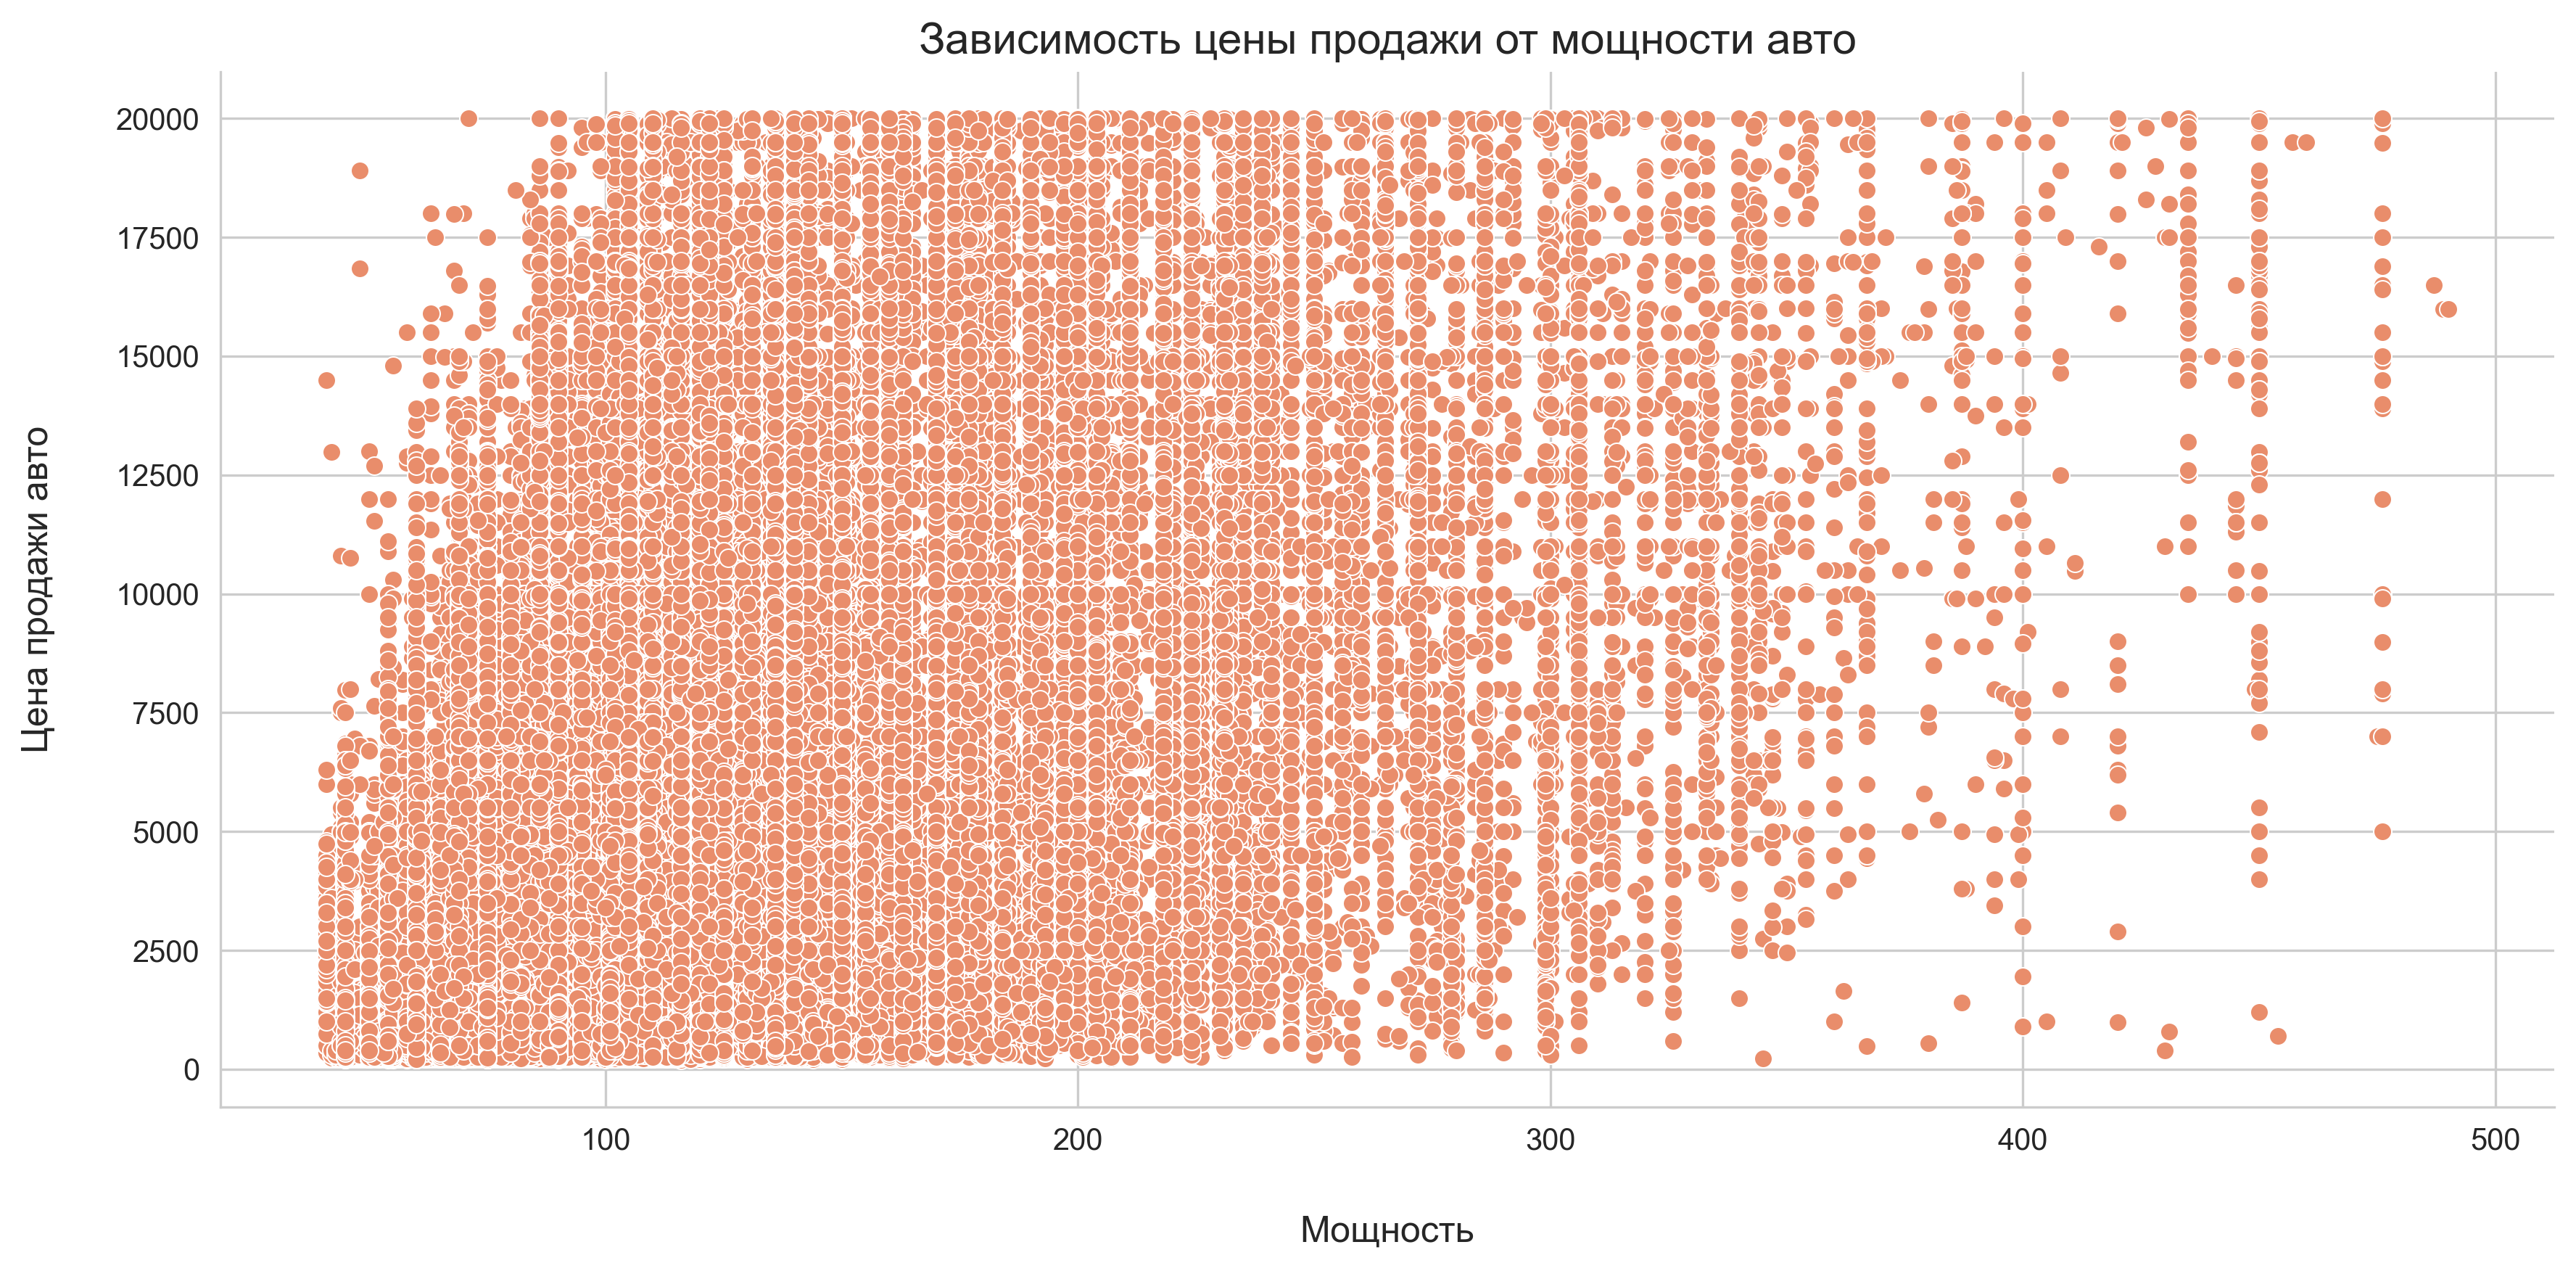

In [93]:
# строим диаграмму зависимости цены от мощности
sns.scatterplot(x=data['power'], y=data['price'])
plt.title('Зависимость цены продажи от мощности авто')
plt.xlabel('Мощность')
plt.ylabel('Цена продажи авто');

In [94]:
# вычисляем корреляцию признаков
data[['power', 'price']].corr()

power  price
power   1.00   0.51
price   0.51   1.00

Глядя на диаграмму рассеяния можно сказать, что есть некая зависимость. Начиная с $300$ л. с. мы всё реже наблюдаем авто за $2500$. Но и в диапазоне $100-300$ л. с. есть множество предложений за высокий `price`. Коэффициент Пирсона говорит, что между признаками есть средняя связь по [шкале Чеддока](https://statpsy.ru/correlation/velicina/).

## Инженеринг признаков и оставшаяся предобработка  

Прежде чем мы пойдём дальше, резюмируем то, что мы сделали, что отметили во время анализа, и что ещё необходимо сделать перед следующим этапом проекта. Итак:

* Мы заполнили все пропуски;
* Удалили явные и неявные дубликаты;
* Почистили данные от аномальных значений и выбросов;
* Отметили категориальные признаки;
* Отметили признаки, от которых следует избавиться;
* Решили объединить признаки `brand` и `model` в один;
* Добавили в данные новый признак — возраст авто `age`.

Что необходимо сделать:

* Проверить форму данных;
* Ещё раз проверить пропуски;
* Ещё раз проверить явные дубликаты;
* Проверить список категориальных данных, всё ли мы отметили;
* Сделать новый признак;
* Проверить список признаков на удаление, всё ли верно;
* Преобразовать типы данных.

In [95]:
# проверяем текущие признаки в данных
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen', 'age'],
      dtype='object')

In [96]:
# проверяем форму данных
get_sample_delta(data, SOURCE_DATA, display_mode='saved')

----------------------------------------------------------------------------
Исходная форма данных: (354369, 16)
----------------------------------------------------------------------------
Текущая форма данных: (280084, 17)
----------------------------------------------------------------------------
Было сохранено 79.0% данных
----------------------------------------------------------------------------


In [97]:
# проверяем наличие явных дубликатов
data.duplicated().sum()

0

In [98]:
# проверяем наличие пропусков
data.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
age                   0
dtype: int64

После чистки данных нам удалось сохранить $79\%$ данных от изначального объёма (мы старались). У нас добавился один признак — это возраст авто `age`. Все пропуски были заполнены, дыр не осталось. Явные дубликаты не обнаружены. Теперь добавим новый признак `car_model` соединив имя бренда и модель автомобиля. Не забудем добавить в список на удаление `brand` и `model`, а в категориальный спискок — новый. 

In [99]:
# объединяем два признака
data['car_model'] = data['brand'] + '_' + data['model']
# проверяем результат
data.head()

date_crawled  price vehicle_type  registration_year gearbox  power  \
1 2016-03-24 10:58:45  18300        coupe               2011  manual    190   
2 2016-03-14 12:52:21   9800          suv               2004    auto    163   
3 2016-03-17 16:54:04   1500        small               2001  manual     75   
4 2016-03-31 17:25:20   3600        small               2008  manual     69   
5 2016-04-04 17:36:23    650        sedan               1995  manual    102   

   model  kilometer  registration_month fuel_type       brand   repaired  \
1     a4     125000                   5  gasoline        audi        yes   
2  grand     125000                   8  gasoline        jeep  undefined   
3   golf     150000                   6  gasoline  volkswagen         no   
4  fabia      90000                   7  gasoline       skoda         no   
5    3er     150000                  10  gasoline         bmw        yes   

  date_created  number_of_pictures  postal_code           last_seen  age  \
1   2016-03-24                   0        66954 2016-04-07 01:46:50    5   
2   2016-03-14                   0        90480 2016-04-05 12:47:46   12   
3   2016-03-17                   0        91074 2016-03-17 17:40:17   15   
4   2016-03-31                   0        60437 2016-04-06 10:17:21    8   
5   2016-04-04                   0        33775 2016-04-06 19:17:07   21   

         car_model  
1          audi_a4  
2       jeep_grand  
3  volkswagen_golf  
4      skoda_fabia  
5          bmw_3er

In [100]:
# добавляем признаки в список на удаление
features_for_delete.extend(['brand', 'model'])
# добавляем новый признак в категориальный список
cat_features.extend(['car_model'])

In [101]:
print('-' * 42)
# проверяем категориальный список
print('Список категориальных признаков:', cat_features)
print('-' * 42)
# проверяем спиок признаков на удаление
print('Список признаков на удаление:', features_for_delete)
print('-' * 42)

------------------------------------------
Список категориальных признаков: ['vehicle_type', 'fuel_type', 'gearbox', 'repaired', 'car_model']
------------------------------------------
Список признаков на удаление: ['date_crawled', 'date_created', 'last_seen', 'postal_code', 'number_of_pictures', 'registration_month', 'registration_year', 'brand', 'model']
------------------------------------------


Наши списки содержат те признаки, что мы и хотели: в категориальном списке содержаться все категориальные признаки плюс новый признак, а в списке на удаление — те признаки, которые нам больше не понадобятся. 

## Вывод

Во время предобработки данных исправили обнаруженные проблемы и провели анализ признаков. В частности:

* Мы изменили имена столбцов в соответствии с хоршим стилем написания;
* Избавились от явных дубликатов и не явных дубликатов. Неявные дубликаты были обнаружены во время анализа моделей авто. Владельцы *Range Rover* по ошибке отметили бренд своего авто как *Rover*. Это две разные компании, но их модельный ряд в данных совпадал;
* Мы изменили некорректные типы данных на приемлемые;
* Избавились от пропусков в категориальных признаках стратегией заполнения модой по группам. Распределения признаков при этом не изменилось;

Во время анализа признаков нам удалось выяснить следующее:

* Актуальный наблюдаемый период данных — $2016$ год с марта по аперль;
* Почтовый индекс никак не связан с ценой продажи. Мы налбюдаем только плотность продаж в зависимости от локации;
* В среднем наблюдаемые авто были зарегестрированы в начале $00$-х, а в качестве рассматриваемой выборки мы выбрали автомобили, зарегестрированные с $1987$ года по $2016$ год. Этот период является полуторным межквартильным размахом года регистрации авто.
* Цена продажи варьировалась от $0$ до $20000$. Мы отсекли нижний пятый перцентиль, тем самым избавившись от сомнительных авто с ценой ниже $200$. Межквартильный размах цены показывает, что машины стоимостью от $14000$ являются выбросами. Но так как они располагаются достаточно плотно от границы размаха, то мы оставили эти наблюдения;
* Самыми популярными автомобилями являются немецкие: *Volkswagen*, *Opel*, *BMW*, *Mercedez Benz*.
* Компании чаще всего выпускают такие типы кузовов как *седан*, компактная версия седана и хетчбэки — *small*, универсал. Соответственно, чаще всего в данных встречаются именно эти типыкузова;
* Самый распространённый тип топлива — бензин. В разных странах его назвают по разному, поэтому в данных мы наблюдали неявный дубликат. Сравнение средних цен по типу топлива показало, что электромобили и гибриды являются самым дорогими.
* Пробег наблюдаемых авто в среднем составляет $150000$ км. Основная часть данных лежит за пределами $90000$ км;
* За наблюдаемый период ручная коробка передач среди авто встречается в четыре раза чаще, чем автомат;
* На цену продажи авто очень сильно влияет наличие ремонта. Автомобили после ремонта стоят в два раза дешевле. Такое наблюдение мы проверили на пяти самых популярных моделях автосамых популярных брендов: *Volkswagen Golf* и *Polo*, * Audi A4*, *BMW* третьей серии и *Opel Corsa*.
* В данных наблюдаются как маломощные авто, так и супермощные. Выше $500$ л. с. мы не рассматриваем, так как в этом диапазоне присутствуют как выбросы, так и аномалии.

В ходе исследовательского анализа данных мы выявили и отсекли как выбросы, так и обнаруженные аномальные значения. Также была снижена кардинальность некоторых признаков и созданы новые признаки:

* В признаке типа топлива были объединены похожие категории;
* Расчитан возраст авто;
* Объединены *бренд* и *модель авто* в одни признак.

В ходе этапа предобработки нам удалось сохранить $79\%$ данных, а в ходе анализа определить важные признаки для будущего моделирования.  

# Подготовка выборок для обучения

Прежде чем обучать модели данные необходимо подготовить должным образом: 

* Необходимо избавиться от признаков, которые никак не влияют на целевой. Такие признаки будут создавать шум, тем самым ухудшая качество модели;
* Категориальные признаки следует закодировать. На данный момент существующие модели пока не умеют работать с категориями. Это мир чисел;
* Целевой признак должен быть отделён от независимых признаков. Своего рода это ответы, на которые будет ориентирваться модель при обучении, а мы — при оценке качества модели;
* Данные должны быть разделены на выборки, тренировочную и тестовую. Причём они не должны пересекаться. Только тогда мы сможем адекватно оценть качество обученных моделей.

Сперва удалим ненужные признаки, для этого мы заранее подготовили список. Затем преобразуем тип данных категориальных признаков в `category`. Также нам понадобится ещё один список с числовыми признаками. В дальнейшем он нам пригодится.

In [102]:
# удаляем ненужные признаки
data.drop(features_for_delete, axis=1, inplace=True)
# проверяем результат
data.columns

Index(['price', 'vehicle_type', 'gearbox', 'power', 'kilometer', 'fuel_type',
       'repaired', 'age', 'car_model'],
      dtype='object')

In [103]:
# изменяем тип данных категориальных признаков
data[cat_features] = data[cat_features].astype('category')
# проверяем результат
data.select_dtypes('category').dtypes

vehicle_type    category
gearbox         category
fuel_type       category
repaired        category
car_model       category
dtype: object

In [104]:
# создаём список числовых признаков
num_features = data.select_dtypes(exclude='category').columns.tolist()
# удаляем целевой признак из списка
num_features.remove('price')
# проверяем результат
data.select_dtypes('number').dtypes

price        int64
power        int64
kilometer    int64
age          int64
dtype: object

## Разделение признаков

Разделим признаки на независимые и целевой. Предполагается, что независимые признаки в своей совокупности влияют на значение целевой переменной. При обучении алгоритм модели попытается найти эти связи, чтобы на новых, неизвестных ей данных применить эти связи. В этом и заключается суть обучения и предсказания. Наш целевой признак это `price`. Все остальные — независимые.  

In [105]:
# выделяем независимые признаки
X = data.drop('price', axis=1)
# выделяем целевой признак
y = data['price']

# проверяем результаты
print('-' * 42)
print('Независимые признаки:', X.columns.tolist())
print('-' * 42)
print('Целевой признак:', y.name)
print('-' * 42)

------------------------------------------
Независимые признаки: ['vehicle_type', 'gearbox', 'power', 'kilometer', 'fuel_type', 'repaired', 'age', 'car_model']
------------------------------------------
Целевой признак: price
------------------------------------------


## Разделение на выборки

Теперь разделим наши данные на тренировочную и обучающую выборки. На первой мы будем обучать наши модели, на второй — проверять качество обученной модели. После разделения проверим количество категорий всех категориальынх признаков во всех выборках. 

In [106]:
# разделяем данные на выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# проверяем размеры выборок
print('-' * 42)
print('Размер обучающей выборки:', X_train.shape)
print('-' * 42)
print('Размер проверочной выборки:', X_test.shape)
print('-' * 42)

------------------------------------------
Размер обучающей выборки: (210063, 8)
------------------------------------------
Размер проверочной выборки: (70021, 8)
------------------------------------------


In [107]:
# проходим циклом по категориальным признакам
for col in cat_features:
    # получаем количество признаков в обучающей выборке     
    train_nunique = X_train[col].nunique()
    # получаем количество признаков в тестовой выборке     
    test_nunique = X_test[col].nunique()
    # выводим результат     
    print('-' * 42)
    print('Признак:', col)
    print('Количество категорий в X_train:', train_nunique)
    print('Количество категорий в X_test:', test_nunique)

------------------------------------------
Признак: vehicle_type
Количество категорий в X_train: 8
Количество категорий в X_test: 8
------------------------------------------
Признак: fuel_type
Количество категорий в X_train: 5
Количество категорий в X_test: 5
------------------------------------------
Признак: gearbox
Количество категорий в X_train: 2
Количество категорий в X_test: 2
------------------------------------------
Признак: repaired
Количество категорий в X_train: 3
Количество категорий в X_test: 3
------------------------------------------
Признак: car_model
Количество категорий в X_train: 289
Количество категорий в X_test: 288


## Кодирование категориальных призанков 

Важную роль в кодировании таких признаков играет количество категорий в признаке и наличие их порядковости. Если категорий всего две или категории имеют порядок, то проблем никаких нет. Проблемы возникают, когда категорий много и они не имеют ранжированного порядка. Каждую категорию необходимо представить каким-то числом и при этом не внести в данные несуществующие связи в виде порядковости (порядок это степень важности). Благо существует несколько компромиссных способов избежать этих проблем. Попробуем разобраться какой из способов можно применить к нашим категориальным признакам.

* `gearbox` имеет всего две категории. Это ручная коробка передач и автомат. Тут всё просто: это либо $1$ или $0$. Этот признак можно закодировать способом *One Hot Encoding*, на выходе получим всего два новых признака;
* `repaired` был бинарным признаком, но после нашей предобработки пришлось добавить третью категорию-заглушку для пропусков — `undefined` — «неопределено» был ли ремонт. Чтобы не создавать излишнюю порядковость категорий, дял кодирования воспользуемся способом *One Hot Encoding*, как и в предыдущем пункте. Три категории — три новых признака. После этого наши данные вырастают всего на пять новых признаков. Терпимо. 
* `car_model` — категориальный признак высокой кардинальности. Порядковое кодирование здесь будет ошибочным и «dummy» кодирование не подойдёт (вырастает большое количество новых признаков). Лучшим решением будет найти какое-либо число, которое будет напрямую связано с каждой категорией в признаке и при этом не имеющее порядковости. Например, целевое-вероятностное кодирование. Способ заключается в следующем: для каждой категории вычисляется оценка вероятности целевой переменной, а затем категория заменяется этой оценкой. Минус этого способа кодирования — есть риск переобучения, так как мы допускаем прямую связь с целевой переменной. Но есть хорошие новости — для избежания переобучения существует регуляризация;
* `vehicle_type` и `fuel_type` имеют небольшую кардинальность, но достаточную, чтобы не использовать dummy-подобные способы кодирования. Иначе у нас появляется плюс 13 признаков. *Тип кузова и топлика* мы закодируем также как и *модель авто* — целевым средним с регуляризацией.

Итак, способы определены:

* `gearbox` — One Hot;
* `repaired` — One Hot;
* `vehicle_type` — M-estimate;
* `fuel_type` — M-estimate;
* `car_model` — M-estimate.

In [108]:
# инициируем порядковый кодировщик
one_hot_encoder = ce.OneHotEncoder(
    cols=['gearbox', 'repaired'],
    use_cat_names=True
)
# инициируем целе-вероятностный кодировщик
m_estimate_encoder = ce.MEstimateEncoder(
    cols=['vehicle_type', 'fuel_type', 'car_model'], 
    handle_unknown='other',
    random_state=42
)
# создаём пайплайн для категориальных признаков
cat_pipe = Pipeline([
    ('one_hot_encoder', one_hot_encoder),
    ('m_estimate_encoder', m_estimate_encoder)
])
# проверяем результат работы пайплайна
cat_pipe.fit_transform(X_train, y_train).sample(10)

vehicle_type  gearbox_manual  gearbox_auto  power  kilometer  \
331955       9414.89               1             0    141     150000   
149653       5732.89               1             0     63     150000   
329267       4960.52               0             1    177     100000   
340247       2980.35               1             0     86      60000   
205209       5732.89               1             0    140      90000   
100252       5217.45               1             0    174     150000   
44141        2980.35               1             0     60      60000   
229598       9414.89               1             0    140     125000   
167036       2980.35               1             0     60     150000   
310473       5217.45               1             0    218     150000   

        fuel_type  repaired_no  repaired_undefined  repaired_yes  age  \
331955    4171.69            1                   0             0   10   
149653    4963.87            0                   1             0    5   
329267    4963.87            1                   0             0    7   
340247    4963.87            1                   0             0    6   
205209    4963.87            1                   0             0    6   
100252    4963.87            0                   1             0   25   
44141     4963.87            1                   0             0   15   
229598    4963.87            1                   0             0    4   
167036    4963.87            0                   0             1   15   
310473    4963.87            1                   0             0   11   

        car_model  
331955    6627.11  
149653    4641.82  
329267    5339.77  
340247    3006.56  
205209    3986.01  
100252    4898.96  
44141     1766.17  
229598   13922.63  
167036    3006.56  
310473    6687.35

## Масштабирование числовых признаков

В наших числовых признаках есть разные значения. Они измеряются в разных единицах, а значит покрывают разные диапазоны. Например, разница между *возрастом авто* и *пробегом*. Это может сильно искажать результаты некоторых алгоритмов, а масштабирование позволяет этого избежать. В частности мы будем использовать стандартизацию, которая преобразует значения таким образом, что из каждого наблюдения каждого признака вычитается среднее значение и результат делится на стандартное отклонение этого признака.

In [109]:
# создаём пайплайн для числовых признаков
num_pipe = Pipeline([('scaler', StandardScaler())])
# проверяем результат работы пайплайна
pd.DataFrame(
    num_pipe.fit_transform(X_train[num_features]), 
    columns=num_pipe.get_feature_names_out()
).sample(10)

power  kilometer   age
68261   -1.17      -2.15 -1.09
161432   1.86       0.59 -1.27
180735  -1.29       0.59  0.57
108587   1.18      -0.78 -1.64
72042   -0.39      -0.78 -0.72
36438    0.16       0.59  0.20
91567    0.35       0.59 -0.72
202293  -0.17       0.59  1.49
206873  -0.13       0.59  0.94
142490  -0.93      -1.33 -0.72

## Вывод

На данном этапе мы подготовили данные для обучения следующим образом:

* Избавились от признаков, которые по результатам анализа никак не влияли на целевой признак. Такими признаками являются: *дата скачивания анкеты*, *дата создания анкеты*, *время последней активности пользователя*, *почтовый индекс пользователя*, *количество фотографий в автоморбиля*, *месяц регистрации*, *год регистрации*, *бренд автомобиля*, *модель автомобиля*;
* Отделили целевой признак от независимых признаков и разделили данные на выборки: обучающую и тестовую;
* Подготовили две группы признаков:
    * категориальные: *модель автомобиля*, *тип кузова*, *тип коробки передач*, *тип топлива*, *была ли машинав ремонте*;
    * числовые признаки: *пробег*, *мощность*, *возраст авто*;
* Написали пайплайн для предварительной обработки признаков. Каждая группа обрабатывается по-своему:
    * категориальные признаки кодируются разными способами в зависимости от своей кардинальности;
    * числовые признаки приводятся к одно масштабу с помощью стандартизации;

# Обучение моделей

Нашей главной задачей является разработка модели, которая умеет определять рыночную стоимость автомоблия по его техническим характеристикам и комплектации. Это значит, что перед нами стоит задача регрессии. Для оценки качества моделей мы будем применять метрику *RMSE*. Значение метрики должно быть не менньше $2500$. В выборе моделей для решения поставленной задачи мы ограничены некоторыми условиями:

* одна из моделей должна быть LightGMB;
* как минимум одна — не бустинг.

Последнее обусловлено тем, что более простые модели иногда работают лучше. Мы это обязательно проверим. В качестве других моделей мы выберем:

* линейную регрессию как не бустинг;
* гребневую регрессию как не бустинг, но с регуляризацией весов;
* СatBoost как второй бустинг.

Что мы сделаем далее:

* Напишем пайплайны для каждой модели, объединив с предобработкой признаков, которую мы подготовили в предыдущем пункте;
* Обучение моделей проведём на кросс-валидации вместе с поиском лучших гиперпараметров; 
* Также создадим сводную таблицу для результатов, куда запишем все результаты эксперимента: время обучения и предсказания, оценка качества модели.

In [110]:
# формируем полную предобработку признаков
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_features),
    ('num', num_pipe, num_features)
])

# создаём пайплайн линейной регрессии
linear_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# создаём пайплайн гребневой регрессии
ridge_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge(random_state=42))
])

# создаём пайплайн бустинга LGBM
lgbm_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(random_state=42))
])

# создаём пайплайн бустинга CatBoost
catboost_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostRegressor(verbose=False, random_state=42))
])

In [111]:
%%time
# создаём сеткку поиска для линейной регрессии
linear_grid = GridSearchCV(
    linear_pipe,
    scoring='neg_root_mean_squared_error',
    n_jobs = -1,
    verbose=5,
    cv=10,
    error_score=0,
    param_grid={}
)
# кросс-валидируем сетку 
linear_grid.fit(X_train, y_train)

# выводим оценку
print('-' * 60)
print('Лучшая оценка RMSE:', linear_grid.best_score_.round(2) * (-1))
print('-' * 60)
print('Среднее время обучения:', linear_grid.cv_results_['mean_fit_time'][0].round(2))
print('-' * 60)
print('Среднее время предсказания:', linear_grid.cv_results_['mean_score_time'][0].round(2))
print('-' * 60)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
------------------------------------------------------------
Лучшая оценка RMSE: 2485.96
------------------------------------------------------------
Среднее время обучения: 1.26
------------------------------------------------------------
Среднее время предсказания: 0.04
------------------------------------------------------------
CPU times: total: 1.05 s
Wall time: 4.75 s


In [112]:
%%time
# создаём сеткку поиска для гребневой регрессии
ridge_grid = RandomizedSearchCV(
    ridge_pipe,
    n_iter=100,
    scoring='neg_root_mean_squared_error',
    n_jobs = -1,
    verbose=5,
    cv=10,
    error_score=0,
    random_state=42,
    param_distributions={
        'model__alpha': [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80],
        'model__max_iter': np.arange(100, 2100, 100)
    }
)
# кросс-валидируем сетку 
ridge_grid.fit(X_train, y_train)

# выводим оценку
print('-' * 60)
print('Лучшая оценка RMSE:', ridge_grid.best_score_.round(2) * (-1))
print('-' * 60)
print('Среднее время обучения:', ridge_grid.cv_results_['mean_fit_time'][0].round(2))
print('-' * 60)
print('Среднее время предсказания:', ridge_grid.cv_results_['mean_score_time'][0].round(2))
print('-' * 60)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
------------------------------------------------------------
Лучшая оценка RMSE: 2485.96
------------------------------------------------------------
Среднее время обучения: 1.12
------------------------------------------------------------
Среднее время предсказания: 0.06
------------------------------------------------------------
CPU times: total: 14.1 s
Wall time: 3min 2s


In [113]:
%%time
# создаём сеткку поиска бустинга LGBM
lgbm_grid = RandomizedSearchCV(
    lgbm_pipe,
    n_iter=100,
    scoring='neg_root_mean_squared_error',
    n_jobs = -1,
    verbose=5,
    cv=5,
    error_score='raise',
    random_state=42,
    param_distributions={
        'model__n_estimators': np.arange(100, 1100, 100),
        'model__max_depth': np.arange(-1, 16, 1),
        'model__learning_rate:': [.01, .1, .5, 1]
    }
)
# кросс-валидируем сетку 
lgbm_grid.fit(X_train, y_train)

# выводим оценку
print('-' * 42)
print('Лучшая оценка RMSE:', lgbm_grid.best_score_.round(2) * (-1))
print('-' * 42)
print('Среднее время обучения:', lgbm_grid.cv_results_['mean_fit_time'][0].round(2))
print('-' * 42)
print('Среднее время предсказания:', lgbm_grid.cv_results_['mean_score_time'][0].round(2))
print('-' * 42)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] Unknown parameter: learning_rate:
------------------------------------------
Лучшая оценка RMSE: 1478.94
------------------------------------------
Среднее время обучения: 7.34
------------------------------------------
Среднее время предсказания: 2.23
------------------------------------------
CPU times: total: 16.7 s
Wall time: 9min 8s


In [114]:
%%time
# создаём сеткку поиска бустинга CatBoost
catboost_grid = RandomizedSearchCV(
    catboost_pipe,
    n_iter=100,
    scoring='neg_root_mean_squared_error',
    n_jobs = -1,
    verbose=5,
    cv=5,
    error_score='raise',
    random_state=42,
    param_distributions={
        'model__n_estimators': np.arange(100, 1100, 100),
        'model__learning_rate': [.01, .1, .5, 1]
    }
)
# кросс-валидируем сетку 
catboost_grid.fit(X_train, y_train)

# выводим оценку
print('-' * 42)
print('Лучшая оценка RMSE:', catboost_grid.best_score_.round(2) * (-1))
print('-' * 42)
print('Среднее время обучения:', catboost_grid.cv_results_['mean_fit_time'][0].round(2))
print('-' * 42)
print('Среднее время предсказания:', catboost_grid.cv_results_['mean_score_time'][0].round(2))
print('-' * 42)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
------------------------------------------
Лучшая оценка RMSE: 1495.12
------------------------------------------
Среднее время обучения: 6.5
------------------------------------------
Среднее время предсказания: 0.08
------------------------------------------
CPU times: total: 54.6 s
Wall time: 12min 33s


In [115]:
# создаём сводную таблицу пезультатов
results = pd.DataFrame(
    index=np.arange(0, 4, 1),
    columns=['model_name', 'cv_score', 'mean_fit_time', 'mean_pred_time']
)

# проходим циклом по сеткам
for i, grid in enumerate([linear_grid, ridge_grid, lgbm_grid, catboost_grid]):
    # получаем имя модели     
    name_model = type(grid.estimator.steps[1][1]).__name__ 
    # получаем лучшую оценку
    best_score = grid.best_score_.round(2) * (-1)
    # получаем среднее время обучения     
    fit_time = grid.cv_results_['mean_fit_time'][0].round(2)
    # получаем среднее время предсказания
    pred_time = grid.cv_results_['mean_score_time'][0].round(2)
    # c помощью цикла заполняем талбицу
    results.loc[i] = (name_model, best_score, fit_time, pred_time)

## Анализ эксперимента

Мы провели обучение нескольких моделей с подбором гиперпараметров и кросс-валидацией. Результаты были записаны в сволную таблицу `results`. Ознакомимся с результатами эксперимента и проанализируем полученные значения.

In [116]:
# выводим результаты
results

model_name cv_score mean_fit_time mean_pred_time
0   LinearRegression  2485.96          1.26           0.04
1              Ridge  2485.96          1.12           0.06
2      LGBMRegressor  1478.94          7.34           2.23
3  CatBoostRegressor  1495.12           6.5           0.08

Для определения стоимости автомобиля мы использовали две линейные модели и два градиентных бустинга. Линейные модели показали себя намного быстрее бустингов. Они быстро обучаются и ещё быстрее предсказывают. Но, в отличии от бустингов, делают менее точные предсказания. Причём регуляризация весов в гребневой регрессии никак не повлияла на оценку, но зато скорость обучения немного быстрее, чем у линейной регрессии.

Бустинги оказались медлительнее, но и точность предсказаний у них выше. Как и линейные модели, бустинги делают предсказания значительно быстрее, чем обучаются. Это обусловлено тем, что размеры выборок отличаются: для линейных моделей разделение фолдов было 10 к 1, а для бустингов — 5 к 1. Само же время обучения вырастает в разы по сравнению с линейными моделями из-за последовательного построения ансамбля (бустинг) и алгоритма поиска минимума функции потерь (градиентный спуск).

Что же касается оценки качества, то все используемые модели выполняют условие задачи — мы получили значение *RMSE* ниже $2500$. Линейные модели ближе к границе, бустинги же — с большим отрывом.  

## Выбор модели

Важными критериями для заказчика являются качество предсказания, время обучения и время предсказания модели. Согласно данным критериям нам подходят бустинги — в среднем в оценке цены продажи авто они ошибаются на $1500$ евро, что на $1000$ евро меньше, чем линейные модели. Из двух бустингов быстрее обучается и предсказывает *CatBoost*, но уступает *LightGBM* только в точности предсказний на $15$ евро.

Выбирая лучшую модель из тестируемых в эксперименте, мы остановимся на *CatBoost*. Пусть он и чуточку хуже предсказывает, зато время обучения и предсказания у него лучшие. Протестируем наш *CatBoost* на отложеных данных и сравним его оценку с фиктивной моделью.

In [117]:
# инициируем фиктивный регрессор
dummy = DummyRegressor()
# обучаем фиктивный регрессор
dummy.fit(preprocessor.fit_transform(X_train, y_train), y_train)
# делаем предсказания фиктивным регрессором
dummy_pred = dummy.predict(preprocessor.transform(X_test))
# считаем оценку предсказаний
dummy_score = mean_squared_error(y_test, dummy_pred, squared=False).round(2)

In [118]:
# делаем предсказания лучшей моделью
best_model_pred = catboost_grid.best_estimator_.predict(X_test)
# считаем оценку предсказаний 
best_model_score = mean_squared_error(y_test, best_model_pred, squared=False).round(2)
# выводим полученную оценку предсказаний
print('-' * 42)
print('Оценка RMSE:', best_model_score)
print('-' * 42)

------------------------------------------
Оценка RMSE: 1466.13
------------------------------------------


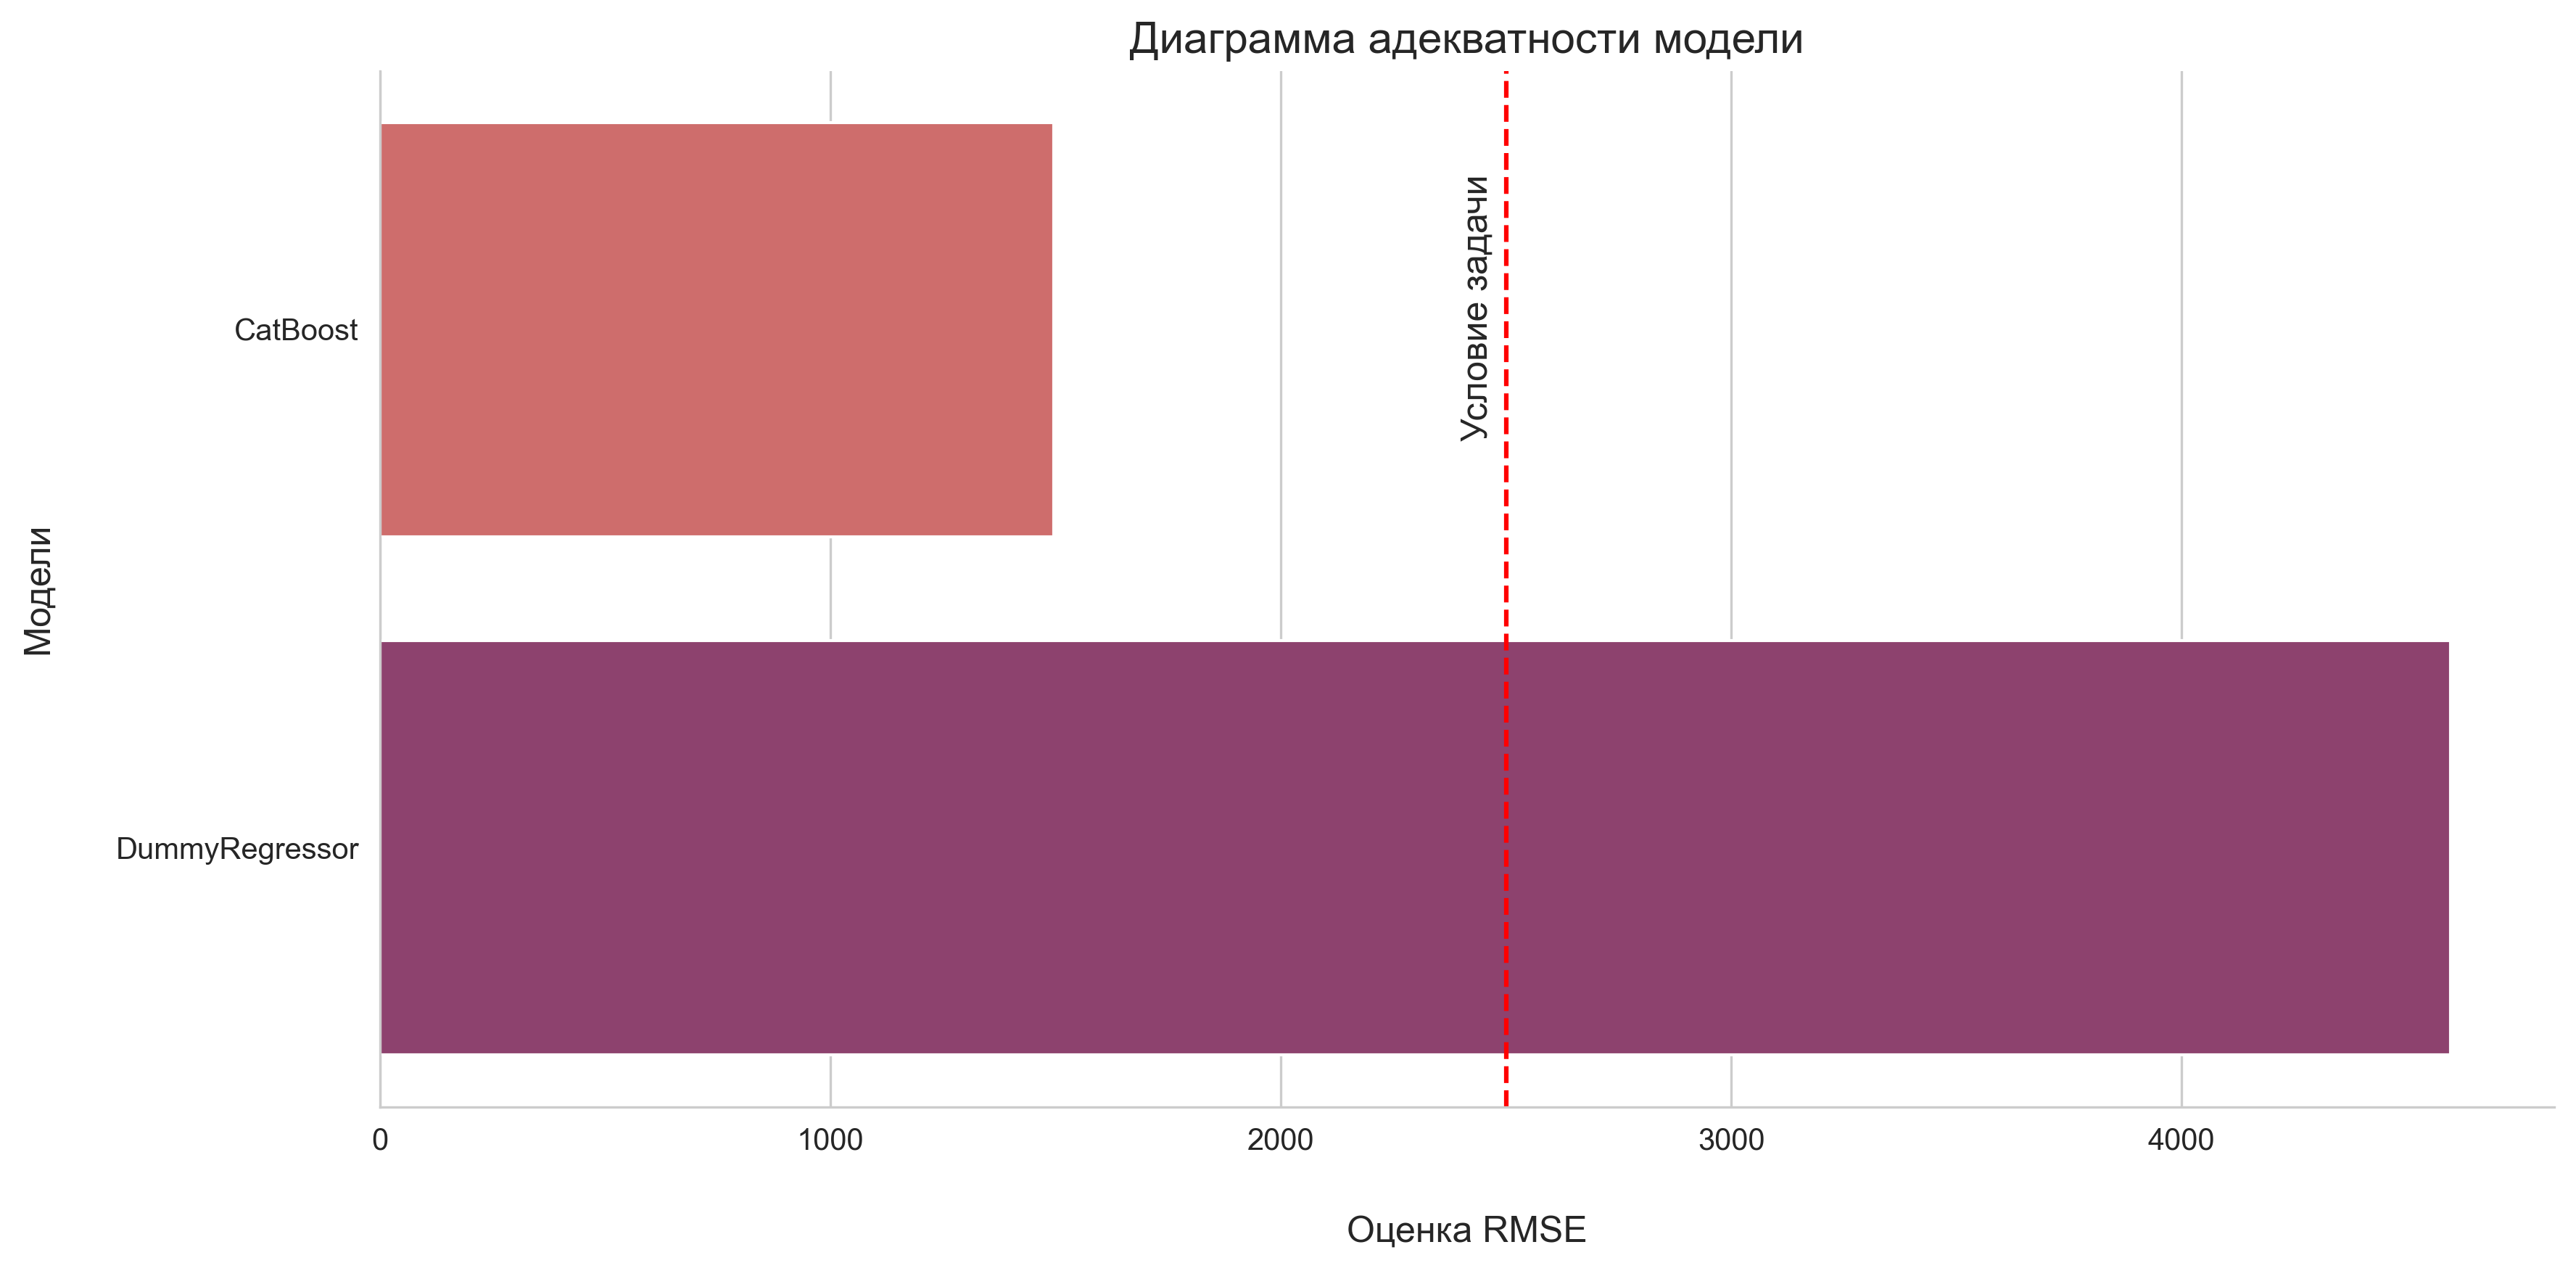

In [119]:
# строим диаграмму оценок
sns.barplot(x=[best_score, dummy_score], y=['CatBoost', 'DummyRegressor'], palette='flare')
# строим линию условия 
plt.axvline(x=2500, linestyle='--', color='red')
plt.text(x=2400, y=0.2, s='Условие задачи', rotation='vertical')
# настраиваем заголовки
plt.title('Диаграмма адекватности модели')
plt.xlabel('Оценка RMSE')
plt.ylabel('Модели');

Наша лучшая модель показывает результаты предсказаний не хуже, чем результаты на кросс-валидации. В сравнении с фиктивной моделью, которая всегда предсказывает среднее цены продажи, наша модель выглядит адекватной.

## Вывод

На этапе обучения моделей мы выбрали несколько моделей, согласно условиям задачи:

* линейную регрессию;
* гребневую регрессию;
* LightGBM регрессор;
* CatBoost регрессор.

Мы провели обучение моделей с подбором гиперпараметров и кросс-валидацией, а результаты записали в сволную таблицу. В ходе эксперимента нам удалось выяснить следующее:

* Все используемые модели выполняют условие задачи — мы получили значение RMSE ниже $2500$. Линейные модели ближе к границе, бустинги же — с большим отрывом;
* Линейные модели показали себя намного быстрее бустингов. Они быстро обучаются и ещё быстрее предсказывают;
* Регуляризация весов в гребневой регрессии никак не повлияла на оценку, но зато скорость обучения немного быстрее, чем у линейной регрессии;
* У бустингов точность предсказаний выше. В среднем они ошибаются в оценке цены продажи авто на $1500$ евро, что на $1000$ меньше, чем линейные модели.
* Как и линейные модели, бустинги делают предсказания значительно быстрее, чем обучаются;
* Из двух бустингов быстрее обучается и предсказывет *CatBoost*, но незначительно уступает *LightGBM* в точности предсказаний.

Выбирая лучшую модель из тестируемых в эксперименте, мы остановились на *CatBoost*. Он показывает результаты предсказаний на тесте не хуже, чем на кросс-валидации. В сравнении с фиктивной моделью, которая всегда предсказывает среднее цены продажи, наша модель выглядит адекватной. Модель удовлетворяет всем требованиям и критериям заказчика.